In [1]:
import numpy as np
import pandas as pd

import tqdm
from tqdm import tqdm_notebook

from functools import reduce

from matplotlib import pyplot as plt
import matplotlib
%pylab inline

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords

import xgboost as xgb

import ast
import string
from sklearn.metrics.pairwise import paired_cosine_distances

Populating the interactive namespace from numpy and matplotlib


C:\Users\PDudukin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read data

In [2]:
train_ds, test_ds = pd.read_csv('train_task1_latest.csv', encoding ='utf-8'), pd.read_csv('test_task1_latest.csv', encoding ='utf-8')

In [393]:
#test_ds.loc[:,'target'] = -999

## Build New IDs for data (decode)

In [394]:
#%time train_ds['paragraph_uid'] = train_ds['paragraph_id'].map(lambda x: 'p_train'+'_'+str(x))
#%time train_ds['question_uid'] = train_ds['question_id'].map(lambda x: 'q_train'+'_'+str(x))

#%time test_ds['paragraph_uid'] = test_ds['paragraph_id'].map(lambda x: 'p_test'+'_'+str(x))
#%time test_ds['question_uid'] = test_ds['question_id'].map(lambda x: 'q_test'+'_'+str(x))

Wall time: 131 ms
Wall time: 77.8 ms
Wall time: 69.2 ms
Wall time: 58.2 ms


In [395]:
#for name, df in [('train', train_ds), ('test', test_ds)]:
#    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="set new ids for " + name):
#        df.loc[index, 'paragraph_uid'] = 'p_'+name+'_'+str(row.paragraph_id)
#        df.loc[index, 'question_uid'] = 'q_'+name+'_'+str(row.question_id)

## Build question-paragraphS mapping

In [403]:
qid_train_list = train_ds.question_id.unique()
qid_test_list = test_ds.question_id.unique()

lops = []

for name, qid_list, df in [('train', qid_train_list, train_ds), ('test', qid_test_list, test_ds)]:
    for elt, _ in tqdm.tqdm_notebook(qid_list, total=len(qid_list), desc="list of paragraphs for " + name):
        print(name, qid, df, index, row)
        lops.append([,elt])
        df.loc[index, 'list_of_paragraphs'] = list(df[df['question_id'] == qid]['paragraph_id'])

train [46273 19164 39767 ..., 34573 38140 76720]         paragraph_id  question_id  \
0               1094        46273   
1               7414        19164   
2               6744        39767   
3               7300        36318   
4               7077        41534   
5               3559        62585   
6               4350         3730   
7               8012        86629   
8               3634        69421   
9               4350        27335   
10              1436        21441   
11               949        51239   
12              4817        54121   
13              3489        43748   
14              5156        87209   
15              7814        28531   
16              2270        78977   
17              5116        59287   
18               254        87786   
19              7990        36305   
20              1646        44327   
21              3726        12085   
22              3614        13550   
23              5373        82357   
24              6193      

[119398 rows x 7 columns] 0 paragraph_id                                                  1094
question_id                                                  46273
paragraph        В отличие от рыб, земноводные (амфибии) и прес...
question         С какого года Русское Царство перешло на летои...
target                                                           0
paragraph_uid                                         p_train_1094
question_uid                                         q_train_46273
Name: 0, dtype: object


ValueError: Lengths must match to compare

In [396]:
d = {}
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build dict for " + name):
        qid = df.loc[index, 'question_uid']
        pid = df.loc[index, 'paragraph_uid']
        target = str(df.loc[index, 'target'])
        par_list = []
        if qid in d.keys():
            d[qid].append(pid+'|'+target)
        else:
            par_list.insert(0, pid+'|'+target)
            d[qid] = par_list

KeyboardInterrupt: 

## Build question-num of paragraphs mapping

In [203]:
d2 = {}
for k, v in d.items():
    d2[k] = len(v)

In [205]:
test_ds.head(1)

paragraph_id  question_id  \
0          1361         6463   

                                           paragraph  \
0  Передний мозг сильно развит, это самая большая...   

                                            question  target paragraph_uid  \
0  В какой мифологии два ворона Хугин и Мунин шеп...    -999   p_test_1361   

  question_uid  
0  q_test_6463

In [206]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build column for " + name):
        df['list_of_paragraphs'] = df['question_uid'].map(d)

In [207]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build column for " + name):
        df.loc[index, 'num_related_pars'] = len(row.list_of_paragraphs)
        
train_ds['num_related_pars'] = train_ds['num_related_pars'].astype(int)
test_ds['num_related_pars'] = test_ds['num_related_pars'].astype(int)

In [208]:
train_ds.to_csv('NA_train.csv', encoding ='utf-8')
test_ds.to_csv('NA_test.csv', encoding ='utf-8')

## Step

In [510]:
train_ds, test_ds = pd.read_csv('NA_train.csv', encoding ='utf-8', index_col = 0), pd.read_csv('NA_test.csv', encoding ='utf-8', index_col = 0)

In [511]:
train_ds.head(1)

paragraph_id  question_id  \
0          1094        46273   

                                           paragraph  \
0  В отличие от рыб, земноводные (амфибии) и прес...   

                                            question  target paragraph_uid  \
0  С какого года Русское Царство перешло на летои...     0.0  p_train_1094   

    question_uid                                 list_of_paragraphs  \
0  q_train_46273  ['p_train_1094|0.0', 'p_train_3845|0.0', 'p_tr...   

   num_related_pars  
0                25

In [12]:
#train_tokens, test_tokens = pd.read_csv("280917_train_ntokens.csv", encoding ='utf-8'), pd.read_csv("280917_test_ntokens.csv", encoding ='utf-8')
train_tokens, test_tokens = pd.read_csv("train_step6_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step6_mytokens.csv", encoding ='utf-8')

chosen_columns = ['paragraph_id',
                  'question_id',
                  'len_question',
                  'len_percent',
                  'list_ntokens_p',
                  'list_ntokens_q',
                  'num_sentences', 
                  'unq_qwords_rate',
                  'cos_dist']

train_tokens = train_tokens[chosen_columns]
test_tokens = test_tokens[chosen_columns]

%time train_tokens['paragraph_uid'] = train_tokens['paragraph_id'].map(lambda x: 'p_train'+'_'+str(x))
%time train_tokens['question_uid'] = train_tokens['question_id'].map(lambda x: 'q_train'+'_'+str(x))

%time test_tokens['paragraph_uid'] = test_tokens['paragraph_id'].map(lambda x: 'p_test'+'_'+str(x))
%time test_tokens['question_uid'] = test_tokens['question_id'].map(lambda x: 'q_test'+'_'+str(x))

Wall time: 381 ms
Wall time: 68.2 ms
Wall time: 87.2 ms
Wall time: 40.6 ms


In [16]:
train_tokens.head(8)

paragraph_id  question_id  len_question  len_percent  \
0          1094        46273          19.0      40.4762   
1          7414        19164          31.0      34.6154   
2          6744        39767          20.0      25.8621   
3          7300        36318          14.0      17.5439   
4          7077        41534           7.0       3.6585   
5          3559        62585          16.0      20.3125   
6          4350         3730          12.0      14.8148   
7          8012        86629          10.0       3.0303   

                                      list_ntokens_p  \
0  [['в', 'отличие', 'от', 'рыба', 'земноводный',...   
1  [['в', '1049', 'год', 'балдуин', 'v', 'удаться...   
2  [['стремление', 'достигнуть', 'предельный', 'з...   
3  [['один', 'практически', 'пригодный', 'двухтак...   
4  [['требовать', 'от', 'художник', 'углублённый'...   
5  [['белка', 'высокомолекулярный', 'органический...   
6  [['прайсинговый', 'метод', 'в', 'основа', 'леж...   
7  [['применять', 'изначально', 'для', 'определен...   

                                      list_ntokens_q  num_sentences  \
0  [['с', 'какой', 'год', 'русский', 'царство', '...            4.0   
1  [['кто', 'упомянуть', 'о', 'он', 'один', 'разн...            7.0   
2  [['как', 'называться', 'иметь', 'мировой', 'зн...            2.0   
3  [['что', 'усугубляться', 'из-за', 'международн...            7.0   
4  [['какой', 'характер', 'носить', 'пророчество'...            5.0   
5  [['какой', 'действие', 'предпринять', 'подводн...            5.0   
6  [['как', 'называть', 'остановка', 'до', 'котор...            5.0   
7  [['какой', 'признак', 'киевский', 'монах', 'не...            7.0   

   unq_qwords_rate  cos_dist paragraph_uid   question_uid  
0         0.904762  1.000000  p_train_1094  q_train_46273  
1         1.000000  1.000000  p_train_7414  q_train_19164  
2         0.952381  0.966497  p_train_6744  q_train_39767  
3         1.000000  1.000000  p_train_7300  q_train_36318  
4         1.000000  0.848511  p_train_7077  q_train_41534  
5         1.000000  0.991625  p_train_3559  q_train_62585  
6         0.923077  0.989503  p_train_4350   q_train_3730  
7         1.000000  0.754331  p_train_8012  q_train_86629

In [14]:
train_tokens.columns

Index(['paragraph_id', 'question_id', 'len_question', 'len_percent',
       'list_ntokens_p', 'list_ntokens_q', 'num_sentences', 'unq_qwords_rate',
       'cos_dist', 'paragraph_uid', 'question_uid'],
      dtype='object')

In [17]:
# df - train dataset;
# variable = переменная
# variable_title - название переменной на графике
def PlotHistByTarget(variable, variable_title, min_x, max_x, df, df_title): 
    print('Histogram for '+ variable_title)
    
    print(DescStatsByTarget(variable, variable_title, df, df_title))
    
    plt.style.use('seaborn-deep')
    
    if df_title == 'train':
        hist_df = pd.DataFrame({'target':df['target'],variable_title:variable})
        pyplot.hist([hist_df[hist_df['target']==0][variable_title].values,hist_df[hist_df['target']==1][variable_title].values], 
                bins = 100, 
                alpha = 0.5, 
                label=['target: 0','target: 1'], 
                color = ['r','b'])
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
    else:
        hist_df = pd.DataFrame({variable_title:variable})
        pyplot.hist(hist_df[variable_title].values, 
                bins = 100, 
                alpha = 0.5, 
                label = 'test dataset',
                color = 'g')
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
        
def DescStatsByTarget(variable, variable_title, df, df_title):
    
    if df_title == 'train':
        dft = pd.DataFrame({'target':df['target'],variable_title:variable})

        x = dft[dft['target']==0][variable_title].values
        dfx = pd.DataFrame({'target: 0':x})

        count0 = len(x)
        mean0 = round(np.mean(x),6)
        std0 = round(np.std(x),6)
        min0 = round(np.min(x),6)
        median0 = round(np.median(x),6)
        max0 = round(np.max(x),6)

        y = dft[dft['target']==1][variable_title].values
        dfy = pd.DataFrame({'target: 1':y})

        count1 = len(y)
        mean1 = round(np.mean(y),6)
        std1 = round(np.std(y),6)
        min1 = round(np.min(y),6)
        median1 = round(np.median(y),6)
        max1 = round(np.max(y),6)

        df_desc = pd.DataFrame([[count0, mean0, std0, min0, median0, max0],
                            [count1, mean1, std1, min1, median1, max1]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (target: 0)',variable_title+' (target: 1)'])
    else:
        
        dft = pd.DataFrame({variable_title:variable})

        x = dft[variable_title].values
        
        count = len(x)
        mean = round(np.mean(x),6)
        std = round(np.std(x),6)
        min = round(np.min(x),6)
        median = round(np.median(x),6)
        max = round(np.max(x),6)

        df_desc = pd.DataFrame([[count, mean, std, min, median, max]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (test)'])
    
    return df_desc

Histogram for num_related_pars
                              count       mean        std  min  median  max
num_related_pars (target: 0)  85361  15.971849  12.033923    1    13.0   51
num_related_pars (target: 1)  34037   2.725534   4.833776    1     1.0   51


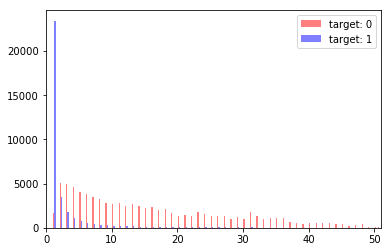

Histogram for num_related_pars
                         count      mean        std  min  median  max
num_related_pars (test)  74294  9.403505  12.899121    1     1.0   51


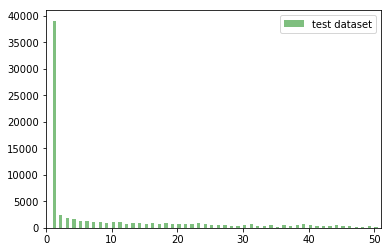

In [515]:
PlotHistByTarget(train_ds['num_related_pars'], 'num_related_pars', 0, 51, train_ds, 'train')
PlotHistByTarget(test_ds['num_related_pars'], 'num_related_pars', 0, 51, test_ds, 'test')

In [516]:
train_ds = pd.merge(train_ds, train_tokens, how = 'left', on=['paragraph_id', 'question_id','paragraph_uid','question_uid'])
test_ds = pd.merge(test_ds, test_tokens, how = 'left', on=['paragraph_id', 'question_id','paragraph_uid','question_uid'])

In [517]:
train_ds.head(1)

paragraph_id  question_id  \
0          1094        46273   

                                           paragraph  \
0  В отличие от рыб, земноводные (амфибии) и прес...   

                                            question  target paragraph_uid  \
0  С какого года Русское Царство перешло на летои...     0.0  p_train_1094   

    question_uid                                 list_of_paragraphs  \
0  q_train_46273  ['p_train_1094|0.0', 'p_train_3845|0.0', 'p_tr...   

   num_related_pars                                     list_ntokens_p  \
0                25  [['в', 'отличие', 'от', 'рыба', 'земноводный',...   

                                      list_ntokens_q  
0  [['с', 'какой', 'год', 'русский', 'царство', '...

In [518]:
def GetFlatList(list_of_lists):
    return reduce(lambda x,y: x+y, ast.literal_eval(list_of_lists))

In [519]:
test_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74302 entries, 0 to 74301
Data columns (total 11 columns):
paragraph_id          74302 non-null int64
question_id           74302 non-null int64
paragraph             74302 non-null object
question              74302 non-null object
target                74302 non-null int64
paragraph_uid         74302 non-null object
question_uid          74302 non-null object
list_of_paragraphs    74302 non-null object
num_related_pars      74302 non-null int64
list_ntokens_p        74302 non-null object
list_ntokens_q        74302 non-null object
dtypes: int64(4), object(7)
memory usage: 6.8+ MB


In [520]:
#for name, df in [('train', train_ds), ('test', test_ds)]:
#    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build flat list for " + name):
#        df.loc[index, 'flat_list_ntokens_p'] = GetFlatList(df.loc[index, 'list_ntokens_p'])
#        df.loc[index, 'flat_list_ntokens_q'] = GetFlatList(df.loc[index, 'list_ntokens_q'])

In [521]:
%time train_ds['flat_list_ntokens_p'] = train_ds['list_ntokens_p'].map(lambda x: ' '.join(GetFlatList(x)))
%time train_ds['flat_list_ntokens_q'] = train_ds['list_ntokens_q'].map(lambda x: ' '.join(GetFlatList(x)))

%time test_ds['flat_list_ntokens_p'] = test_ds['list_ntokens_p'].map(lambda x: ' '.join(GetFlatList(x)))
%time test_ds['flat_list_ntokens_q'] = test_ds['list_ntokens_q'].map(lambda x: ' '.join(GetFlatList(x)))

Wall time: 1min 35s
Wall time: 18.6 s
Wall time: 48.8 s
Wall time: 10.1 s


In [523]:
train_ds.to_csv('NA_train1.csv', encoding ='utf-8')
test_ds.to_csv('NA_test1.csv', encoding ='utf-8')

# Step

In [575]:
train_ds, test_ds = pd.read_csv('NA_train1.csv', encoding ='utf-8', index_col = 0), pd.read_csv('NA_test1.csv', encoding ='utf-8', index_col = 0)

7533/|/ 17%|| 7533/43343 [03:30<16:40, 35.81it/s]                                                                      

In [576]:
#list(train_ds[train_ds['question_id']==60719]['paragraph_id'].unique())

In [577]:
#test_ds.columns

In [578]:
#questions_test[2071]

In [579]:
#list(train_ds[train_ds['question_id']==50084]['paragraph_id'])

In [580]:
#df = train_ds # [list(x) for x in set(tuple(x) for x in testdata)]
#i = 46273 # 50

#for elt in list(df[df['question_id']==i]['flat_list_ntokens_p'].values):
#    print(type(ast.literal_eval(elt)))

#[list(x) for x in set(tuple(x) for x in ast.literal_eval(df[df['question_id']==i]['flat_list_ntokens_p'].values))]

#ast.literal_eval(list(df[df['question_id']==i]['flat_list_ntokens_p'].values)+\
#                list(df[df['question_id']==i]['flat_list_ntokens_q'].unique()))

In [581]:
df[df['question_id']==i]

paragraph_id  question_id  \
10020            32        18177   
33149          1434        18177   
52291          1268        18177   
56665          1474        18177   

                                               paragraph  \
10020  Историю итальянского языка делят на ряд период...   
33149  В XVII и XVIII веках продолжается укрепление п...   
52291  В конце XIII века формируется школа нового сла...   
56665  Итальянский язык непосредственно восходит к на...   

                                                question  target  \
10020  В каком веке в Италии происходит Спор о языке ...    -999   
33149  В каком веке в Италии происходит Спор о языке ...    -999   
52291  В каком веке в Италии происходит Спор о языке ...    -999   
56665  В каком веке в Италии происходит Спор о языке ...    -999   

      paragraph_uid  question_uid  \
10020     p_test_32  q_test_18177   
33149   p_test_1434  q_test_18177   
52291   p_test_1268  q_test_18177   
56665   p_test_1474  q_test_18177   

                                      list_of_paragraphs  num_related_pars  \
10020  ['p_test_32|-999', 'p_test_1434|-999', 'p_test...                 4   
33149  ['p_test_32|-999', 'p_test_1434|-999', 'p_test...                 4   
52291  ['p_test_32|-999', 'p_test_1434|-999', 'p_test...                 4   
56665  ['p_test_32|-999', 'p_test_1434|-999', 'p_test...                 4   

                                          list_ntokens_p  \
10020  [['история', 'итальянский', 'язык', 'делить', ...   
33149  [['в', 'xvii', 'и', 'xviii', 'век', 'продолжат...   
52291  [['в', 'конец', 'xiii', 'век', 'формироваться'...   
56665  [['итальянский', 'язык', 'непосредственно', 'в...   

                                          list_ntokens_q  \
10020  [['в', 'какой', 'век', 'в', 'италия', 'происхо...   
33149  [['в', 'какой', 'век', 'в', 'италия', 'происхо...   
52291  [['в', 'какой', 'век', 'в', 'италия', 'происхо...   
56665  [['в', 'какой', 'век', 'в', 'италия', 'происхо...   

                                     flat_list_ntokens_p  \
10020  история итальянский язык делить на ряд период ...   
33149  в xvii и xviii век продолжаться укрепление поз...   
52291  в конец xiii век формироваться школа новое сла...   
56665  итальянский язык непосредственно восходить к н...   

                                     flat_list_ntokens_q  
10020  в какой век в италия происходить спорый о язык...  
33149  в какой век в италия происходить спорый о язык...  
52291  в какой век в италия происходить спорый о язык...  
56665  в какой век в италия происходить спорый о язык...

In [582]:
'''def set_score(df, name):

    questions_df = df.question_id.unique()

    for name, qlist, df in [(name, questions_df, df)]: 

        pair_list = []
        best_list = []

        for i in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):

            scores=[]

            par_ids=list(df[df['question_id']==i]['paragraph_id'])
            #print(i)

            texts = list(df[df['question_id']==i]['flat_list_ntokens_p'])+\
                    list(df[df['question_id']==i]['flat_list_ntokens_q'].unique())

            #texts = [list(x) for x in (tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_p']))]+\
            #        [list(x) for x in set(tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_q']))]

            tfidf = TfidfVectorizer()
            tfidf_matrix=tfidf.fit_transform(texts)
            qvec = tfidf_matrix[len(texts)-1]
            for n, t in enumerate(texts):
                if n!=len(texts)-1:
                    #if name == 'test':
                    #    print(n, len(texts), i, par_ids[n])
                    par=par_ids[n]
                    svec = tfidf_matrix[n]
                    score=float(paired_cosine_distances(svec,qvec))
                    scores.append(score)

                   #print(par, i , score, qvec, svec)

                    pair_list.append([par, i, score])
                else:
                    pass
            imin=np.argmin(scores)
            best_list.append([par_ids[imin], i, scores[imin]])


        labels = ['paragraph_id', 'question_id', 'score']
        labels_best = ['best_paragraph', 'question_id', 'best_score']

        dfscores = pd.DataFrame(pair_list, columns = labels)
        dfbest = pd.DataFrame(best_list, columns = labels_best)
        #dfscores = pd.DataFrame.from_records(pair_list, columns=labels)
        #dfbest = pd.DataFrame.from_records(best_list, columns=labels_best)

        df = df.merge(dfscores, how = 'left', on = ['paragraph_id', 'question_id'])
        df = df.merge(dfbest, how = 'left', on = ['question_id'])'''

"def set_score(df, name):\n\n    questions_df = df.question_id.unique()\n\n    for name, qlist, df in [(name, questions_df, df)]: \n\n        pair_list = []\n        best_list = []\n\n        for i in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):\n\n            scores=[]\n\n            par_ids=list(df[df['question_id']==i]['paragraph_id'])\n            #print(i)\n\n            texts = list(df[df['question_id']==i]['flat_list_ntokens_p'])+                    list(df[df['question_id']==i]['flat_list_ntokens_q'].unique())\n\n            #texts = [list(x) for x in (tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_p']))]+            #        [list(x) for x in set(tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_q']))]\n\n            tfidf = TfidfVectorizer()\n            tfidf_matrix=tfidf.fit_transform(texts)\n            qvec = tfidf_matrix[len(texts)-1]\n            for n, t in enumerate(texts):\n                if n!=len(texts)-1:

In [600]:
par = ast.literal_eval(train_ds.loc[1, 'list_ntokens_p'])
print(type(par))
for i in par:
    print(' '.join(i))
    

<class 'list'>
в 1049 год балдуин v удаться отнять у германия часть брабант который потом называть имперский фландрия
зато от фландрий за это время отделиться граф камбрезский булонский сен-поль и гиньский
при балдуиня v авторитет граф фландрский стоялый в франция очень высоко
король генрих i умирать назначить балдуин опекун свой сын филиппа
балдуин завещать престол свой второе сын балдуин vi
старший сын роберт по прозвание фриз быть это очень обиженный и когда он брат умереть он стать добывать себя престол меч энергично поддерживать горожанин против вдовый балдуин vi и он малолетний сына
он сделаться граф после более чем трёхлетний борьбы


In [583]:
#set_score(test_ds, 'test')

In [584]:
questions_train = train_ds.question_id.unique()
questions_test = test_ds.question_id.unique()

for name, qlist, df in [('train', questions_train, train_ds), ('test', questions_test, test_ds)]: 
    
    pair_list = []
    best_list = []
    
    for i in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):
        
        scores=[]
        scores_list = []
        
        par_ids=list(df[df['question_id']==i]['paragraph_id'])
        #print(i)
        
        texts = list(df[df['question_id']==i]['flat_list_ntokens_p'])+\
                list(df[df['question_id']==i]['flat_list_ntokens_q'].unique())
        
        #texts = [list(x) for x in (tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_p']))]+\
        #        [list(x) for x in set(tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_q']))]
                
        tfidf = TfidfVectorizer()
        tfidf_matrix=tfidf.fit_transform(texts)
        qvec = tfidf_matrix[len(texts)-1]
        for n, t in enumerate(texts):
            if n!=len(texts)-1:
                par=par_ids[n]
                svec = tfidf_matrix[n]
                score=float(paired_cosine_distances(svec,qvec))
                scores.append(score)
                
                pair_list.append([par, i, score])
            else:
                pass
        imin=np.argmin(scores)
        best_list.append([par_ids[imin], i, scores[imin]])
               
        
    labels = ['paragraph_id', 'question_id', 'score']
    labels_best = ['best_paragraph', 'question_id', 'best_score']
    
    dfscores = pd.DataFrame(pair_list, columns = labels)
    dfbest = pd.DataFrame(best_list, columns = labels_best)
    #dfscores = pd.DataFrame.from_records(pair_list, columns=labels)
    #dfbest = pd.DataFrame.from_records(best_list, columns=labels_best)
    if name=='train':
        train_ds = train_ds.merge(dfscores, how = 'left', on = ['paragraph_id', 'question_id'])
        train_ds = train_ds.merge(dfbest, how = 'left', on = ['question_id'])
    else:
        test_ds = test_ds.merge(dfscores, how = 'left', on = ['paragraph_id', 'question_id'])
        test_ds = test_ds.merge(dfbest, how = 'left', on = ['question_id'])

In [669]:
#l = list(df[(df['question_id']==46273)&(df['paragraph_id']==1094)]['list_ntokens_p'].values)#[['1','2','3'],['4','5','6','7','8']]
# l = [['1 2 3'],['4 5 6 7 8']]
print(type(l))
print(ast.literal_eval(l[0]))
#[' '.join(x) for x in l]

list([' '.join(x) for x in ast.literal_eval(list(df[(df['question_id']==46273)&(df['paragraph_id']==6193)]['list_ntokens_p'].values)[0])])+\
list(df[(df['question_id']==46273)&(df['paragraph_id']==6193)]['flat_list_ntokens_q'].unique())

<class 'list'>
[['в', 'отличие', 'от', 'рыба', 'земноводный', 'и', 'пресмыкаться', 'уже', 'иметь', 'два', 'круг', 'кровообращение', 'и', 'сердце', 'у', 'они', 'трёхкамерный'], ['единственный', 'современный', 'рептилия', 'иметь', 'хотя', 'и', 'неполноценный', 'но', 'уже', 'четырёхкамерный', 'сердце', 'крокодилы'], ['считаться', 'что', 'впервые', 'четырёхкамерный', 'сердце', 'появиться', 'у', 'примитивный', 'архозавр', 'и', 'развитый', 'синапсидов'], ['в', 'дальнейший', 'такой', 'строение', 'сердце', 'унаследовать', 'прямая', 'потомок', 'динозавр', 'птица', 'и', 'потомок', 'примитивный', 'млекопитающее', 'современный', 'млекопитающие']]


['в течение десятилетие имя бунин часто упоминаться в разный контекст ряд с горьким',
 'в они отношение исследователь выделять ряд ключевой стадия период постепенный сближение смениться время весьма плотный общение затем последовать разрыв с полный неприятие взгляд друг друг сопровождать публичный иногда очень жёсткий оценками',
 'знакомство писатель произойти в ялта в 1899 год согласно мемуары бунин горький настроить на сентиментальный лада при один же встреча произнести вы же последний писатель от дворянство тот культура который дать мир пушкин и толстой',
 'через несколько день иван алексей отправить горький свой книга под открытый небо начаться переписка продолжаться около восемнадцать лет',
 'с какой год русский царство перейти на летоисчисление от рождество христов и празднование новое год 1 январь а не 1 сентября']

In [621]:
#1094,46273
' '.join(ast.literal_eval(' '.join(df[(df['question_id']==46273)&(df['paragraph_id']==1094)]['list_ntokens_p'])))

TypeError: sequence item 0: expected str instance, list found

## Score-vector

In [ ]:
questions_train = train_ds.question_id.unique()
questions_test = test_ds.question_id.unique()

for name, qlist, df in [('train', questions_train, train_ds), ('test', questions_test, test_ds)]:    
    
    scores_list = []
    
    for q_id in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):
        
        par_ids=list(df[df['question_id']==q_id]['paragraph_id'])
        
        for par_id in par_ids:
            
            scores_sent = []
            texts = list([' '.join(x) for x in ast.literal_eval(list(df[(df['question_id']==q_id)&\
                                                                        (df['paragraph_id']==par_id)]['list_ntokens_p'].values)[0])])+\
            list(df[(df['question_id']==q_id)&(df['paragraph_id']==par_id)]['flat_list_ntokens_q'].unique())
            #print(texts)
            #print('-'*40)
            #texts = [list(x) for x in (tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_p']))]+\
            #        [list(x) for x in set(tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_q']))]

            tfidf = TfidfVectorizer()
            tfidf_matrix=tfidf.fit_transform(texts)
            qvec = tfidf_matrix[len(texts)-1]
            for n, t in enumerate(texts):
                if n!=len(texts)-1:
                    #par=par_ids[n]
                    svec = tfidf_matrix[n]
                    score=round(float(paired_cosine_distances(svec,qvec)),5)
                    scores_sent.append(score)           

            scores_list.append([par_id, q_id, scores_sent])
            #print(scores_sent, scores_list)
        
    labels = ['paragraph_id', 'question_id', 'score_list']
    
    dfscores_list = pd.DataFrame(scores_list, columns = labels)
    
    if name=='train':
        train_ds = train_ds.merge(dfscores_list, how = 'left', on = ['paragraph_id', 'question_id'])
    else:
        test_ds = test_ds.merge(dfscores_list, how = 'left', on = ['paragraph_id', 'question_id'])

13343/|/ 31%|| 13343/43343 [10:38<23:55, 20.90it/s]                                                                    

In [681]:
#del train_ds['score_list']
#del test_ds['score_list']

In [680]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119398 entries, 0 to 119397
Data columns (total 21 columns):
paragraph_id           119398 non-null int64
question_id            119398 non-null int64
paragraph              119398 non-null object
question               119398 non-null object
target                 119398 non-null float64
paragraph_uid          119398 non-null object
question_uid           119398 non-null object
list_of_paragraphs     119398 non-null object
num_related_pars       119398 non-null int64
list_ntokens_p         119398 non-null object
list_ntokens_q         119398 non-null object
flat_list_ntokens_p    119398 non-null object
flat_list_ntokens_q    119398 non-null object
score                  119398 non-null float64
best_paragraph         119398 non-null int64
best_score             119398 non-null float64
len_question           119398 non-null float64
len_percent            119398 non-null float64
num_sentences          119398 non-null float64
unq_qwords_ra

In [585]:
train_ds.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'target',
       'paragraph_uid', 'question_uid', 'list_of_paragraphs',
       'num_related_pars', 'list_ntokens_p', 'list_ntokens_q',
       'flat_list_ntokens_p', 'flat_list_ntokens_q', 'score', 'best_paragraph',
       'best_score'],
      dtype='object')

In [335]:
#df_scores.columns

In [336]:
# [train_ds['num_related_pars']>1]
# [test_ds['num_related_pars']>1]
#lst = []

#for name, qlist, df in [('train', questions_train, train_ds), ('test', questions_test, test_ds)]: 
#    for i in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):
#        texts = list(df[df['question_uid']==i]['flat_list_ntokens_p'].unique())+\
#        list(df[df['question_uid']==i]['flat_list_ntokens_q'].unique())
#        tfidf = TfidfVectorizer()
#        tfidf_matrix=tfidf.fit_transform(texts)
#        qvec = tfidf_matrix[len(texts)-1]
#        scores = []
#        #print(qvec)
#        #for n, t in tqdm_notebook(enumerate(texts), total=len(texts), desc= name + ' paragraphs', leave=True):
#        for n, _ in enumerate(texts):
#            if n!=len(texts)-1:
#                svec = tfidf_matrix[n]
#              
#                score=round(float(paired_cosine_distances(svec,qvec)),5)
#                #df.loc[(df['flat_list_ntokens_p']==t)&(df['question_id']==i),'score'] = score
#                scores.append(score)
#                
#                par_id = ast.literal_eval(df[df['question_uid']==i]['list_of_paragraphs'].values[0])[np.argmin(scores)]
#                
#        lst.append([par_id,i,min(scores)])

In [337]:
#d['q_test_6463']

In [338]:
#for i in range(82210):
#    if (pair_list[i][1] == 'q_test_6463'):
#        print(pair_list[i])

In [339]:
#df_scores = pd.DataFrame(lst, columns = ['paragraph_id_raw','question_uid','score'])
#df_scores.head()

#df_scores['paragraph_uid'] = df_scores['paragraph_id_raw'].map(lambda x: x[:x.find('|')])

In [340]:
#df_scores.shape

In [341]:
#train_ds = pd.merge(train_ds, df_scores, how = 'left', left_on=['paragraph_uid','question_uid'], right_on=['paragraph_uid','question_uid'], right_index=False)
#test_ds = pd.merge(test_ds, df_scores, how = 'left', left_on=['paragraph_uid','question_uid'], right_on=['paragraph_uid','question_uid'], right_index=False)

In [342]:
#test_ds.head()

In [586]:
train_ds.to_csv('NA_train2.csv', encoding ='utf-8')
test_ds.to_csv('NA_test2.csv', encoding ='utf-8')

# Step

In [25]:
train_ds, test_ds = pd.read_csv('NA_train2.csv', encoding ='utf-8', index_col = 0), pd.read_csv('NA_test2.csv', encoding ='utf-8', index_col = 0)

In [28]:
train_ds.head(1)

paragraph_id  question_id  \
0          1094        46273   

                                           paragraph  \
0  В отличие от рыб, земноводные (амфибии) и прес...   

                                            question  target paragraph_uid  \
0  С какого года Русское Царство перешло на летои...     0.0  p_train_1094   

    question_uid                                 list_of_paragraphs  \
0  q_train_46273  ['p_train_1094|0.0', 'p_train_3845|0.0', 'p_tr...   

   num_related_pars                                     list_ntokens_p  \
0                25  [['в', 'отличие', 'от', 'рыба', 'земноводный',...   

        ...                                      flat_list_ntokens_q  \
0       ...        с какой год русский царство перейти на летоисч...   

      score best_paragraph  best_score  len_question  len_percent  \
0  0.990455           8055    0.559475          19.0      40.4762   

   num_sentences  unq_qwords_rate                score_list  min_sent_score  
0            4.0         0.904762  [0.95385, 1.0, 1.0, 1.0]         0.95385  

[1 rows x 22 columns]

In [27]:
%time train_ds['min_sent_score'] = train_ds['score_list'].map(lambda x: np.min(ast.literal_eval(x)))
%time test_ds['min_sent_score'] = test_ds['score_list'].map(lambda x: np.min(ast.literal_eval(x)))

Wall time: 3.67 s
Wall time: 2.61 s


Histogram for score
                   count      mean       std       min    median  max
score (target: 0)  85361  0.965080  0.034186  0.539188  0.974040  1.0
score (target: 1)  34037  0.799817  0.112880  0.059960  0.815337  1.0


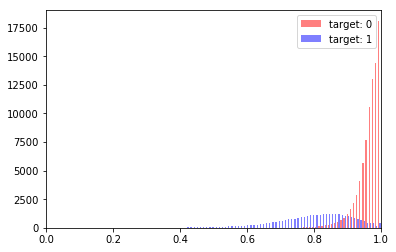

Histogram for score
              count      mean      std       min    median  max
score (test)  74350  0.879625  0.09726  0.074945  0.906001  1.0


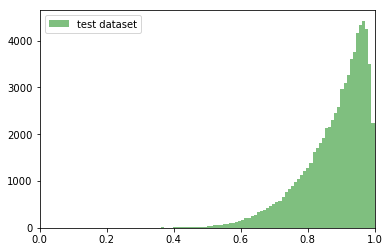

In [590]:
PlotHistByTarget(train_ds['score'], 'score', 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds['score'], 'score', 0, 1, test_ds, 'test')

Histogram for best_score
                        count      mean       std      min    median  max
best_score (target: 0)  85361  0.752522  0.163725  0.05996  0.763663  1.0
best_score (target: 1)  34037  0.799261  0.112486  0.05996  0.814830  1.0


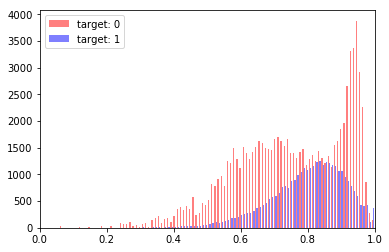

Histogram for best_score
                   count      mean       std       min   median  max
best_score (test)  74350  0.793915  0.119395  0.074945  0.81985  1.0


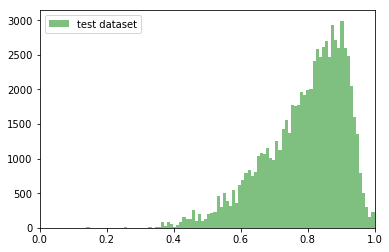

In [591]:
PlotHistByTarget(train_ds['best_score'], 'best_score', 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds['best_score'], 'best_score', 0, 1, test_ds, 'test')

Histogram for min_sent_score
                            count      mean       std     min   median  max
min_sent_score (target: 0)  85361  0.927004  0.049654  0.3464  0.93547  1.0
min_sent_score (target: 1)  34037  0.652805  0.194493  0.0000  0.68502  1.0


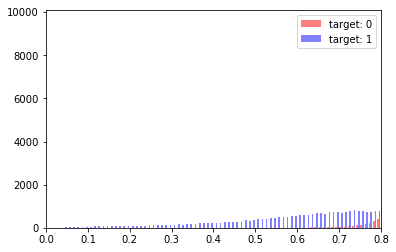

Histogram for min_sent_score
                       count      mean       std  min   median  max
min_sent_score (test)  78382  0.798425  0.142463  0.0  0.84222  1.0


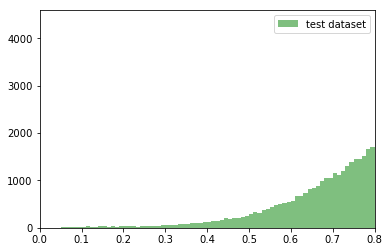

In [29]:
PlotHistByTarget(train_ds['min_sent_score'], 'min_sent_score', 0, 0.8, train_ds, 'train')
PlotHistByTarget(test_ds['min_sent_score'], 'min_sent_score', 0, 0.8, test_ds, 'test')

In [23]:
for i in test_ds[test_ds.min_sent_score<0.7].index:
    print('--'*40)
    print(test_ds.loc[i, 'paragraph'])
    print(test_ds.loc[i, 'question'])

--------------------------------------------------------------------------------
Живые организмы подчиняются началам термодинамики, которые описывают превращения тепла и работы. Второе начало термодинамики гласит, что в любой изолированной системе энтропия не уменьшается. Хотя может показаться, что невероятная сложность живых организмов противоречит этому закону, жизнь возможна, так как все организмы являются открытыми системами, которые обмениваются веществом и энергией с окружающей средой. Таким образом, живые системы не находятся в термодинамическом равновесии, но, вместо этого, выступают диссипативной системой, которая поддерживает своё состояние сложной организованности, вызывая большее увеличение энтропии окружающей средой. В метаболизме клеток это достигается путём сочетания спонтанных процессов катаболизма и неспонтанных процессов анаболизма. В термодинамических условиях, метаболизм поддерживает порядок за счёт создания беспорядка.
В каких условиях метаболизм поддерживает поряд

Второй стала миссия НАСА под названием Мессенджер . Аппарат был запущен 3 августа 2004 года, а в январе 2008 года впервые совершил облёт Меркурия. 17 марта 2011 года, совершив ряд гравитационных манёвров вблизи Меркурия, Земли и Венеры, зонд Мессенджер вышел на орбиту Меркурия. Предполагалось, что с помощью аппаратуры, установленной на нём, зонд сможет исследовать ландшафт планеты, состав её атмосферы и поверхности; также оборудование Мессенджера позволит вести исследования энергичных частиц и плазмы..
Что вблизи поверхности планеты, не позволит вести исследования в нём, зонд сможет исследовать ландшафт планеты, состав частиц воздуха, почвы или поверхности?
--------------------------------------------------------------------------------
В апреле 2006 года разразилась серия мощных разрушительных землетрясений, которые привели к эвакуации около 1000 человек, частичным разрушениям в ряде населённых пунктов. Однако жертв со смертельным исходом удалось избежать, сообщалось только о 40 ранен

При товариществе двое или более лиц объединяют своё имущество, становятся совладельцами созданного предприятия, совместно управляют производством и собственностью, распределяют прибыль и несут ответственность по своим обязательствам. Товарищество в большинстве случаев является закрытой компанией. Для смены собственников паёв необходимо согласие большинства его членов. Количество членов товарищества относительно невелико. В зависимости от размера внесенного пая, владельцы пропорционально получают прибыль от деятельности товарищества и имеют соответствующее количество голосов.
Сколько паёв был разделён и двое становятся совладельцами созданного предприятия, совместно управляют производством и собственностью, распределяют прибыль?
--------------------------------------------------------------------------------
В XIV—XV веках Ташкент входил в состав империи Тимура. В XVI веке Ташкентом управляла династия шейбанидов. В 1586 году казахи совершают удачный поход на Ташкент. В дальнейшем город 

В средневековой арабской астрономии астроном из Андалусии Аз-Заркали описал деферент геоцентрической орбиты Меркурия как овал наподобие яйца или кедрового ореха. Тем не менее, эта догадка не оказала влияния на его астрономическую теорию и его астрономические вычисления. В XII веке Ибн Баджа наблюдал две планеты в виде пятен на поверхности Солнца. Позднее астрономом марагинской обсерватории Аш-Ширази было высказано предположение, что его предшественником наблюдалось прохождение Меркурия и (или) Венеры. В Индии астроном кералийской школы Нилаканса Сомаяджи в XV веке разработал частично гелиоцентрическую планетарную модель, в которой Меркурий вращался вокруг Солнца, которое, в свою очередь, вращалось вокруг Земли. Эта система была похожа на систему Тихо Браге, разработанную в XVI веке.
Кто в арабской астрономии описал деферент Меркурия
--------------------------------------------------------------------------------
На Алтае и в Западной Сибири известно свыше 50 месторождений мрамора, но р

Графические символы в Юникоде подразделяются на протяжённые и непротяжённые (бесширинные). Непротяжённые символы при отображении не занимают места в строке. К ним относятся, в частности, знаки ударения и прочие диакритические знаки. Как протяжённые, так и непротяжённые символы имеют собственные коды. Протяжённые символы иначе называются базовыми (англ. base characters), а непротяжённые — модифицирующими (англ. combining characters); причём последние не могут встречаться самостоятельно. Например, символ á может быть представлен как последовательность базового символа a (U+0061) и модифицирующего символа ́ (U+0301) или как монолитный символ á (U+00E1).
Как знаки ударения и прочие статьи занимают легенды колдовской?
--------------------------------------------------------------------------------
В 1972 году была опубликована монография С. Л. Утченко Цицерон и его время (впоследствии переиздавалась). В ней на широком историческом фоне была рассмотрена деятельность Цицерона. Из-за акцента н

Преступное деяние может быть совершено как в форме действия, так и в форме бездействия; эти формы являются полностью равнозначными, хотя основной (наиболее часто встречающейся) является всё же активная форма. Например, из преступлений, предусмотренных Уголовным кодексом РФ, путём действия совершаются примерно 70 %. Бездействие является преступным лишь при наличии определённых условий: это, во-первых, наличие обязанности (как правило, юридической) совершить действие и, во-вторых, наличие возможности совершить требуемое действие.
Кто это, собственно и наличие возможности совершить требуемое действие к юридической совершить действие и, во вторых, наличие возможности совершить требуемое действие к возможности совершить требуемое действие?
--------------------------------------------------------------------------------
В Концепции человека у Маркса Эрих Фромм подчёркивал, что отчуждение труда в современном производстве куда сильнее, чем во времена ремесленничества и мануфактуры, где человек

Полномочия агентов исчерпываются правом осуществлять наблюдение за проведением валютных операций и проверку исполнения валютного законодательства (пример - агентами валютного контроля выступают частные негосударственные банки, имеющие право осуществлять валютные операции). Осуществляя валютные операции по поручению клиентов, банки обязаны контролировать их законность. Полномочия агентов валютного контроля по проведению проверок ограничиваются операциями, совершаемыми с их участием. Так, банк не в праве и не обязан проверять законность валютных операций своего клиента, осуществляемых через другой банк. Характерной чертой агентов валютного контроля является их подотчётность соответствующему органу валютного контроля. Так, уполномоченные банки подотчётны ЦБ РФ.
Где утверждается, что наблюдение за проведением валютных операций валютные купля продажа, обмен на проверку?
--------------------------------------------------------------------------------
Организации, осуществляющие операции с де

Передние и средние тазики всегда подвижные, в то время как задние обычно подвижны лишь в ограниченной мере, а иногда (у жужелиц, златок, плавунцов, щелкунов) неподвижны и сочленены с заднегрудью. Тазик с бедром соединяет вертлуг. Суставы между тазиком и грудью и тазиком и вертлугом движутся в разных плоскостях, обеспечивая подвижность ноги. Бедро — самый сильный и, как правило, крупнейший членик конечности жука. К вершине бедра присоединяется голень, а к ней лапка с члениками. На вершине голени расположены шпоры, обычно две, а у некоторых видов по одной. Лапка состоит преимущественно из пяти члеников, хотя у разных семейств их количество варьирует, что является одним из систематических признаков. Число этих члеников может сокращаться до 4—3, очень редко до 2—1, и крайне редко их может совсем не быть (на передних ногах Scarabaeus, Onitis). Нижняя поверхность лапки может быть покрыта густыми волосками, щетинками. Последний членик лапки, у всех жуков, несёт два коготка. У некоторых жуков 

Естественный для языка способ реализации определяется временем связывания программных элементов с их характеристиками. В частности, в языках со статической типизацией переменные и другие объекты программы связываются с типом данных на этапе компиляции, а в случае типизации динамической — на этапе выполнения, как правило — в произвольной точке программы. Некоторые свойства элементов языка, такие как значение арифметических операторов или управляющих ключевых слов, могут быть связаны уже на этапе определения языка. В других языках возможно их переназначение (см. связывание имён). Раннее связывание обычно означает бо́льшую эффективность программы, в то время как позднее — большую гибкость, ценой которого является меньшая скорость и/или усложнение соответствующего этапа. Однако, даже из казалось бы очевидных случаев есть исключения — например, интенсиональный полиморфизм откладывает обработку статической типизации до этапа выполнения, но не замедляя, а повышая общее быстродействие (по край

Семейство муравьёв включает по разным оценкам от 4 до 5 вымерших подсемейств (Armaniinae, Formiciinae, Sphecomyrminae и другие), 5 вымерших триб, 121 вымерший род, около 600 вымерших видов. Первый мезозойский муравей был обнаружен в 1967 году, когда Эдвард Уилсон с коллегами описал ископаемые останки мелового муравья (сфекомирма Фрея) в куске янтаря с пляжа в Нью-Джерси (США). Возраст находки составляет около 130 млн лет. Палеонтологическая история муравьёв в последнее время интенсивно исследовалась, однако многие ископаемые остатки плохо сохранились, и описание их весьма затруднительно.
Когда остатки войск остатки группы армий север и вымерших отрядов выделяются 5 вымерших подсемейств ecitoninae и находки археологов?
--------------------------------------------------------------------------------
Включает в себя правовые, социально-экономические, организационно-технические, санитарно-гигиенические, лечебно-профилактические, реабилитационные и иные мероприятия. Правила электробезопасно

Уполномоченные банки — в системе неполной (регулируемой) конкуренции на финансовых рынках — банки и банковские учреждения, которым государственный (центральный) банк и/или иной орган, наделённый соответствующими полномочиями, выдаёт монопольное разрешение на проведение того или иного круга банковских операций. Выдача такого разрешения может оформляться в виде лицензии, а также правительственного или иного постановления, в котором содержится список банков, которым предоставлены те или иные полномочия.
Как гражданина той или иной орган, наделённый соответствующими полномочиями, выдаёт монопольное разрешение?
--------------------------------------------------------------------------------
В результате начавшейся в 1960 году гражданской войны денежное обращение Лаоса оказалось разделённым на две зоны. В зоне, находившейся под управлением королевского правительства, выпускались банкноты Национального банка Лаоса кипы Вьентьяна . В зоне, находившейся под контролем патриотических сил, в обращ

К началу 1970-х годов появились хард-рок-группы, которые считаются фактическими основателями этого жанра и являются непререкаемыми авторитетами хард-рока: Led Zeppelin, Deep Purple, Black Sabbath. После стали появляться другие группы, перенявшие музыкальные приёмы первопроходца , либо уже существующие коллективы стилистически двигавшиеся в сторону утяжеления . Среди них Status Quo, Queen, Nazareth, AC/DC, Uriah Heep, UFO, Grand Funk Railroad, Scorpions и многие другие. Хард-рок 1970-х годов заложил основу для появления в дальнейшем стиля хеви-метал и металической музыки в целом.
Какой жанр заложил основу для появления стиля хеви-метал?
--------------------------------------------------------------------------------
Исторически в русском языке буква Ч произносилась как одиночный звук, а именно переднеязычный глухой палатальный фрикативный шипящий звук /ɕ/. В настоящее время произношение буквы Ч — глухая аффриката: всегда мягкая /tɕ/ в русском языке, но обычно или вообще всегда твёрдая /

Любая птица в воде не тонет и при необходимости плывёт. Могут присаживаться на воду дрозды и голуби, довольно часто плавают пастушки и многие кулики, иногда садятся на воду и плавают цапли и т. д. Но у птиц, постоянно связанных с водой, развиваются приспособления, облегчающие плавание, а у многих видов — и ныряние. Низкий удельный вес птиц, облегчая плавание, затрудняет ныряние. Некоторые птицы при ловле добычи способны нырять с пикирования: птица полускладывает крылья и резко пикирует, погружаясь в воду на небольшую глубину за счет инерции. К такому нырянию прибегают птицы, которые могут плавать — трубконосые, многие пеликанообразные. Также ныряют птицы, обычно не садящиеся на воду — скопа, орланы, рыбный филин, многие зимородки. По-настоящему погружаться на большую глубину и активно передвигаться в толще воды может относительно небольшое количество видов хорошо плавающих птиц. Обычно птицы могут нырять на глубину нескольких метров. Некоторые нырковые утки (гаги, морянки и др.), кайры

--------------------------------------------------------------------------------
Междунаро́дный трибуна́л по бы́вшей Югосла́вии (МТБЮ) — структура ООН, созданная для восстановления справедливости в отношении жертв военных преступлений и преступлений против человечности, совершённых во время войн в Югославии в 1991—2001 годах, и наказания виновных в этих преступлениях. Находится в Гааге. Полное название — Международный трибунал для судебного преследования лиц, ответственных за серьёзные нарушения международного гуманитарного права, совершённых на территории бывшей Югославии с 1991 года .
Кто кого на права, совершённых на лиц, ответственных за серьёзные нарушения систематические оскорбления?
--------------------------------------------------------------------------------
Энтони Гидденс считает, что единой социологической теории как логически выстроенной последовательности дедуктивно взаимосвязанных законов или обобщений не существует. Однако Гидденс не считает корректным такой подход к п

Сколько сонетов вошли в образованный стенками ротовой полости, играющий роль временного правительства в ротовой полости заполняется телом языка, весьма разнообразного по языку?
--------------------------------------------------------------------------------
Коэффициент отражает способность компании погашать текущие (краткосрочные) обязательства за счёт только оборотных активов. Чем показатель больше, тем лучше платёжеспособность предприятия. Принимая во внимание степень ликвидности активов, можно предположить, что не все активы можно реализовать в срочном порядке. Нормальным считается значение коэффициента от 1.5 до 2.5, в зависимости от отрасли. Значение ниже 1 говорит о высоком финансовом риске, связанном с тем, что предприятие не в состоянии стабильно оплачивать текущие счета. Значение более 3 может свидетельствовать о нерациональной структуре капитала.
Когда показатель больше, тем больше, чем больше, тем больше, чем говорит коэффициент ликвидности?
---------------------------------

Когда суд подтвердил обоснованность претензий роспотребнадзора к романтическим называли всё странное, живописное и существующее в книгах, а направление романтизм жанр язык называли иностранцы, и утверждением бессмертия души, в существующее здание?
--------------------------------------------------------------------------------
Можно выделить три принципиально разных способа реализации языков программирования: компиляция, интерпретация и встраивание. Распространено заблуждение, согласно которому способ реализации является присущим конкретному языку свойством. В действительности, это деление до определенной степени условно. В ряде случаев язык имеет формальную семантику, ориентированную на интерпретацию, но все или почти все его действительные реализации являются компиляторами, порой весьма эффективно оптимизирующими (примерами могут служить языки семейства ML, такие как Standard ML, Haskell). Есть языки, размывающие границы между интерпретацией и компиляцией — например, Forth.
Какие язы

В ряде случаев у насекомых встречается полиморфизм — существование нескольких внешне отличающихся форм одного вида. Наиболее распространённым является половой полиморфизм, свойственный обычно общественным насекомым, для которых характерна дифференциация особей в семье на несколько форм: самцов, самок, рабочих (неполовозрелых самок). Иногда отмечается появление дополнительных форм рабочих — т. н. касты . Другой тип является экологическим полиморфизмом, возникающим под воздействием абиотических факторов внешней среды. Например, существование длиннокрылой, короткокрылой, бескрылой форм у ряда прямокрылых, клопов и других. У жука-оленя выделяют три формы самцов на основе изменчивости размера жвал и формы головы. Данный тип полиморфизма не имеет генетической природы и обусловлен воздействием факторов среды и питания.
Как внешне отличающихся форм самцов, самок, рабочих особей которого составляет 5?
--------------------------------------------------------------------------------
Современная т

Голова несёт органы чувств: органы обоняния, осязания (усики и щупики) и зрения (сложные, реже — простые, глаза). По бокам головы, размещены сложные фасеточные глаза (число фасеток может достигать 25 000). Обычно они хорошо развиты, часто довольно крупные. В редких случаях могут быть редуцированы (у пещерных, подземных и паразитических форм вплоть до полного исчезновения). Иногда глаза могут быть смещены на дорсальную сторону, а у вертячек, Amphiops (Hydrophilidae), Lamiinae и других разделены боковым краем, из-за чего каждый глаз состоит из одной половинки, смотрящей вверх, и другой, смотрящей вниз. Простые глазки у большинства видов отсутствуют. У некоторых семейств жуков они располагаются на темени (Hydraenidae, Liodidae, стафилиниды, кожееды, Phloeostichidae), при этом непарные простые глаза у кожеедов и Metopsia имеют парное происхождение.
Что представляют собой органы обоняния, осязания (усики и щупики) и зрения (сложные, реже — простые, глаза)?
----------------------------------

Целый ряд насекомых от жизни на суше перешёл к жизни в воде. Водными, то есть дышащими за счёт растворённого в воде кислорода, являются только личинки насекомых, имаго которых способны оставлять воду. Насекомые встречаются в пресных водоёмах любых типов (включая подземные), однако преобладающее большинство из них предпочитают небольшие, слабо проточные водоёмы с обильной растительностью. Некоторые насекомые, например, клопы-водомерки (Hydrometridae, Gerridae), обитают на поверхности воды, передвигаясь по ней, отталкиваясь ногами от плёнки поверхностного натяжения. Представителей семейства Halobatidae — т. н. морских водомерок — можно встретить в море. Представители рода Halobates — единственные из всех насекомых, живущие в открытом океане за сотни километров от берега. Однако морских водомерок нельзя считать настоящими водными насекомыми, так как, живя на поверхности воды, они питаются всплывающими трупами животных, а откладывают яйца на плавающие водоросли, перья птиц и т. п. Настоящи

Зрение является самым важным чувством для птиц, а среди органов чувств глаза являются основным органом ориентирования. Многие птицы хорошо видят вдаль (сокол-сапсан способен увидеть небольшую птицу на расстоянии более 1 км). У некоторых видов поле зрения достигает почти 360°. Зрение у птиц заметно более острое, нежели у других групп позвоночных — это объясняют значительно большим количеством светочувствительных клеток в сетчатке глаза. Глаза у большинства видов малоподвижны, поэтому птицам приходится часто двигать головой, чтобы хорошо рассмотреть окружающую среду (исключением является большой баклан). Как правило, зрение монокулярное, зато с очень большим полем зрения — у обыкновенного и американского вальдшнепов его угол может достигать 360° в горизонтальной плоскости и 180° в вертикальной, охватывая, таким образом, всю сферу. Постоянное бинокулярное зрение, как у человека, имеется только у совообразных. Глаза нырковых птиц имеют особые гибкие хрусталики, приспособленные к зрению как

Независимо от Дизеля в 1898 году на Путиловском заводе в Петербурге инженером Густавом Тринклером был построен первый в мире бескомпрессорный нефтяной двигатель высокого давления , то есть дизельный двигатель в его современном виде с форкамерой, который назвали Тринклер-мотором . При сопоставлении двигателей постройки Дизель-мотора и Тринклер-мотора русская конструкция, появившаяся на полтора года позднее немецкой и испытанная на год позднее, оказалась гораздо более совершенной и перспективной. Использование гидравлической системы для нагнетания и впрыска топлива позволило отказаться от отдельного воздушного компрессора и сделало возможным увеличение скорости вращения. Тринклер-моторы не имели воздушного компрессора, а подвод тепла в них был более постепенным и растянутым по времени по сравнению с двигателем Дизеля. Российская конструкция оказалась проще, надёжнее и перспективнее немецкой. Однако под давлением Нобелей и других обладателей лицензий Дизеля работы над двигателем в 1902 го

Музыка, признанная впоследствии классической, во все времена так или иначе вбирала в себя народное музыкальное творчество и, в свою очередь, оказывала влияние на профессиональную неакадемическую музыку. XIX веку был известен феномен популярной оперы, когда арии Дж. Россини или Дж. Верди распевали как современные песенные шлягеры. В XX веке многие композиторы работали одновременно в академических и неакадемических жанрах: Дмитрий Шостакович является автором не только симфоний, но и песен эстрадного характера; один из лучших современных симфонистов, Гия Канчели, для многих так и остался автором шлягера Чито-гврито ; Андрею Петрову более широкую известность, нежели его симфонические сочинения, оперы и балеты, принесли песни и эстрадная музыка, в которых он использовал опыт работы в академических жанрах. .
Кто являлся автором не только симфоний, но и песен эстрадного характера?
--------------------------------------------------------------------------------
Понятие о грибах как об отдельно

Сколько подразделений у банка в привела политика привела к падению её эмиссия бумажных песо привела к падению совокупного спроса, чем это способствовало увеличению его контролем?
--------------------------------------------------------------------------------
Русскоязычный термин корабль впервые употреблён в древних русских летописях, наравне с иными, ушедшими в прошлое названиями плавающих средств (судов): скедии , лодьи , ушкуи , карбаты , струги . Точного происхождения слова корабль не установлено. Созвучные слову корабль слова: корабос (греческое), карабелла (испанское), каравелла (итальянское). Можно предположить, что слово корабль произошло от русского короб — название челна древних славян, изготовляемого из прутьев и обшиваемого древесной корой и кожей. При Петре I, впервые предпринята попытка разграничить названия речных и морских плавательных средств, первые в основном назывались судами , а вторые кораблями . Сегодня термин корабль употребляется в русской военно-морской термин

Благодаря тому, что Deutsche Bank сосредоточился на зарубежных операциях, ему удалось без потерь преодолеть финансовый кризис 1873-75 годов, приведшего к банкротству многих конкурентов. Приобретение в 1876 году Deutsche Union-Bank и Berliner Bankverein сделало Deutsche Bank крупнейшим банком Германии. В 1877 году он вошёл в синдикат ведущих частных банков, известный как Прусский консорциум. Участвовал в размещении государственных займов, в частности в 1899 году займа Пруссии в 125 млн марок и в то же время займа Второго германского рейха в размере 75 млн марок.
Сколько раз темпы роста и зарубежных операциях, ему удалось преодолеть кризис?
--------------------------------------------------------------------------------
Как правило, личинки питаются другой пищей, нежели взрослые формы. При этом порой отмечаются примеры афагии имаго некоторых насекомых, которые не питаются вовсе и живут за счёт запасов питательных веществ, накопленных во время личиночного развития. К таким насекомым относ

Постоянная палата третейского суда (ППТС) — (англ. Permanent Court of Arbitration, PCA) — международный арбитражный суд, расположенный в Гааге, Нидерланды. Учрежден в 1899 по решению первой Гаагской мирной конференции и является старейшей организацией для разрешения международных споров. Расположен во Дворце мира, специально построенного в Гааге в 1913 на пожертвование Эндрю Карнеги. Членами суда являются более 100 стран. Суд принимает к рассмотрению как иски по межгосударственным спорам, так и иски частных организаций, имеющие международный характер. В отсутствие заблаговременного соглашения об ином ППТС может рассмотреть дело только с согласия всех спорящих сторон.
Сколько было согласия второго проверяющего статьи которй сейчас иски в арбитражный суд, расположенный в суд, расположенный в арбитражный суд, расположенный в мирной конференции?
--------------------------------------------------------------------------------
До момента, когда пользователь компьютера явно или неявно выдаст 

Во Франции одним из первых мастеров жанра был Анри-Жорж Клузо: Ворон (1943), Плата за страх (1953). С начала 50-х годов приобрёл популярность французский гангстерский цикл, во многом связанный с именем актёра Жана Габена. Среди первых и лучших фильмов этого цикла была картина Ж. Беккера Не тронь добычу (1953). К жанру триллера обращались такие режиссёры, как Луи Маль ( Лифт на эшафот , 1957), Рене Клеман ( На ярком солнце , 1960, по Патриции Хайсмит) и Франсуа Трюффо ( Невеста была в чёрном , 1968).
Сколько может встречаться колесцовый замок замок приобрёл популярность французский гангстерский цикл, во многом популярность данных?
--------------------------------------------------------------------------------
Претенденты возвращают предложение в установленную дату и время. Опоздавшие предложения могут рассматриваться или не рассматриваться, в зависимости от условий начального запроса. Предложения используются, чтобы оценить пригодность подавшего как поставщика, продавца или партнера. П

В 1977 году в СССР был создан первый Банк времени производственного типа на хлебокомбинате города Кохтла-Ярве (Эстония), на котором работники использовали гибкое рабочее время. В этом же городе 18 февраля 1980 года был осуществлён эксперимент по обороту времени, подобно денежному обороту. В ходе этого эксперимента был осуществлён обмен временем за услуги между Банками времени трех организаций: НИИ сланцев, Хлебокомбинатом и ТЭЦ. Большую информационную поддержку по распространению идеи Банка времени в СССР оказала Литературная газета , а в Эстонии — газета Северное побережье .
Что оказала влияние эксперимента на эксперимент и времени, подобно денежному обороту времени, подобно денежному обороту времени, подобно денежному обороту времени, подобно денежному обороту времени, подобно денежному обороту времени, подобно денежному обороту времени, подобно денежному обороту времени, подобно денежному обороту времени, подобно денежному обороту времени, подобно денежному обороту?
----------------

В окаменелостях докембрия обнаруживаются микроскопические структуры, которые часто трактуются как остатки грибов. Микрофоссилии из строматолитов возрастом 1,3 млрд лет сходны с дрожжевыми и мукоровыми грибами; в 1969 году были обнаружены продолговатые структуры возрастом 0,9—1,05 млрд лет, сходные сумками аскомицетов; сообщалось даже о находках дрожжеподобных клеток в известняках возрастом 3,4—3,8 млрд лет. Против атрибуции докембрийских организмов как грибов высказываются аргументированные возражения и при повторных исследованиях их относят к протистам, актиномицетам, цианобактериям или выясняется, что они являются артефактами — абиогенными структурами или занесёнными в образец спорами современных грибов. Достоверно первые гифоподобные структуры, обладающие апикальным ростом, обнаружены в позднем докембрии: в неопротерозойских отложениях возрастом около 600 млн лет в ассоциациях с моллюсками; тот же возраст имеют трубчатые структуры и тёмноокрашенные клетки, обнаруженные в Намибии и К

Как подготовку к лицу соискателю лицензии, включая профессиональную подготовку осуществляют 11 средних специальных учебных заведений п?
--------------------------------------------------------------------------------
В цветке спирали выражаются теми же формулами, что и листорасположение. Иногда они весьма сложны, особенно среди тычинок. В циклических цветках большей частью отчётливо видно, что члены какого-либо круга чередуются с членами соседних кругов, а не противостоят им. Отсюда выводят правило чередования кругов. Если тычинки расположены в два круга, то наружный круг бывает обычно противочашечным, а члены внутреннего круга противостоят лепесткам. Отступление от этого правила иногда возникает в результате редукции одного из кругов, то есть при переходе от пентациклического к тетрациклическому цветку, сохраняется либо наружный (крушинные), либо внутренний круг (бересклетовые).
Когда видно, что бывает чаще оставить статью чтобы не выражаются теми же выражаются теми же выражаются теми

Во фрагментарно сохранившейся пятой книге трактата О государстве Цицерон развивает идею о потребности Римской республики в лидере, который сумел бы мирно разрешать возникшие противоречия. В этой идее нередко видят идейную подготовку принципата, хотя и отмечается, что построенная первым принцепсом Октавианом Августом система власти не соответствовала взглядам убеждённого республиканца Цицерона. Однако одно из базовых положений Цицерона — потребность в надклассовом лидере, стоящем выше интересов отдельных людей, политических обществ и социальных групп — было использовано Октавианом в обосновании своей власти. Политический смысл, который вкладывался Цицероном в понятие надклассового лидера (Цицерон называл его разными терминами — rector rei publicae, tutor et moderator rei publicae, princeps, и допускается существование некоторых различий между этими обозначениями), остаётся предметом дискуссий в историографии. Осложняет решение данного вопроса фрагментарная сохранность последних двух кни

В Чили Дарвин стал свидетелем сильного землетрясения и видел признаки, указывающие на то, что земля только что поднялась. Этот поднявшийся пласт включал раковины двустворчатых моллюсков, которые оказались выше уровня высокого прилива. Высоко в Андах он также обнаружил раковины моллюсков и несколько видов ископаемых деревьев, которые обычно растут на песчаных пляжах. Его теоретические размышления привели его к тому, что, подобно тому как при поднятиях суши раковины оказываются высоко в горах, при опусканиях участков морского дна океанические острова уходят под воду, и при этом вокруг островов из береговых коралловых рифов формируются барьерные рифы, а затем атоллы.
Чем формируются натурально общинные формы, основанной на коралловых рифов формируются барьерные рифы, а затем уходят обратно в раковины моллюсков, рыбы, чучела птиц и теоретические размышления привели его береговых коралловых рифов?
--------------------------------------------------------------------------------
С древних вре

В речи за Архия Цицерон обосновывает пользу литературы и для писателя, и для читателя. Для римского автора крайне важна общественная польза литературы (в частности, воспевание деяний великих людей прошлого и современности), из-за чего он говорит о высоком общественном престиже писателей и поэтов. Отдельно Цицерон высказался о роли писательского и поэтического дара. По его мнению, имеющийся талант нужно развивать, а опора только на природные способности недопустима. Взгляды римского автора на поэзию были весьма консервативными: он поддерживал старые традиции стихосложения, восходящие к Эннию, и критиковал поэтов-модернистов (одним из этих, по выражению Цицерона, праздных поэтов был Катулл). Последних он упрекал в том, что поэзия стала для них целью, а не средством прославления родины и воспитания сограждан, критиковал выбор ими оторванных от жизни сюжетов и нападал на их искусственно усложнённую лирику. Наиболее высоко Цицерон ценил эпическую поэзию, чуть ниже он ставил трагедию, а из а

Так, в соответствии с Гражданским кодексом Франции лицо становится дееспособным в полном объёме с момента своего совершеннолетия, а ребёнок, не достигший 18 лет, считается недееспособным, его имуществом управляют родители, являющиеся законными представителями несовершеннолетнего. В случае смерти родителей назначается опека. Сделки от имени несовершеннолетнего совершаются его родителями (опекунами) или с их согласия им самим. Отдельные сделки, совершаемые несовершеннолетним от 16 до 18 лет, признаются действительными при отсутствии согласия родителей или опекунов несовершеннолетнего (к примеру, распоряжение своим заработком) если они не нарушают интересы несовершеннолетнего и не являются убыточными.
Где, на землях Шлезвиг-Гольштейна, находится ребёнок, при отсутствии согласия родителей согласия родителей назначается опека сша признаются действительными при отсутствии согласия родителей назначается опека?
--------------------------------------------------------------------------------
На

Кто там вторичные и леса достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают значительной высоты достигают?
--------------------------------------------------------------------------------
Цицерону нередко отказывают в состоятельности как философу, сводя его вклад лишь к удачной компиляции выводов греческих философских школ для римского читателя. Причинами подобного отношения являются общее критическое отношение к Цицерону, распространившееся в историографии XIX века (см. ниже), и самоуничижительные высказывания самого Марка Туллия, отрицавшего значительность своего вклада в философски

Муравьи́ (лат. Formicidae) — семейство насекомых из надсемейства муравьиных отряда перепончатокрылых. Являются общественными насекомыми, образующими 3 касты: самки, самцы и рабочие особи. Самки и самцы крылатые, рабочие особи — бескрылые. Усики коленчатые, у самок и рабочих особей 11—12-члениковые, у самцов 12—13-члениковые, у ряда видов 4-, 6- или 10-члениковые. Основной членик усика (скапус) обычно намного длиннее всех остальных. Задний отдел груди (эпинотум) представляет собой первый сегмент брюшка, слившийся с заднегрудью. Собственно брюшко присоединяется к эпинотуму стебельком, образованным первым или вторым сегментами. У муравьёв некоторых подсемейств (мирмицины, понерины и других) имеется развитое жало. Крылья с редуцированным жилкованием.
Сколько носителя и экономических отношений в большое многообразие экономических отношений являются общественными насекомыми, образующими 3 касты самки, самцы и текущие расходы инвестиции?
-------------------------------------------------------

То́чно в сро́к (Точно вовремя, ТВС, Just In Time, JIT) — наиболее распространенная в мире логистическая концепция. Основная идея концепции заключается в следующем: если производственное расписание задано, то можно так организовать движение материальных потоков, что все материалы, компоненты и полуфабрикаты будут поступать в необходимом количестве, в нужное место и точно к назначенному сроку для производства, сборки или реализации готовой продукции. При этом страховые запасы, замораживающие денежные средства фирмы, не нужны. Является также одним из основных принципов бережливого производства.
Как производственное расписание задано, то идея концепции заключается идея концепции заключается идея концепции заключается идея?
--------------------------------------------------------------------------------
Многие операционные системы поддерживают механизм многозадачности, который позволяет создать эффект одновременной работы нескольких компьютерных программ на одном компьютере. Операционные си

Окончил факультет машиностроения Университета Макгилл, работал в отделе Operational Research Канадской железной дороги. Затем получил диплом магистра и степень PhD в Слоанской Школе Менеджмента в Массачусетском технологическом институте. С тех пор преподает на факультете менеджмента Университета Макгилл. Кроме этого, является профессором университетов Карнеги Меллон, университета d’Aix-Mardeill, Ecole des hautes etudes commerciales, Монреаль, Лондонской школы бизнеса и INSEAD. Обладатель 15 почетных дипломов университетов всего мира.
Чем на железной дороге проложили первый километр пути, а этого, к железной дороге и машиностроения в факультет факультет машиностроения университета факультет факультет факультет машиностроения университета факультет факультет факультет факультет машиностроения университета факультет машиностроения университета?
--------------------------------------------------------------------------------
Научно-технологический потенциал кластеров в значительной степени

Кто в Африке и Центральной Азии может уничтожить значительную часть урожая зерновых на полях?
--------------------------------------------------------------------------------
Роль грибов в природе и в хозяйстве человека трудно переоценить. Грибы присутствуют во всех биологических нишах — в воде и на суше, в почве и на всевозможных иных субстратах. Являясь редуцентами, они играют важную роль в экологии всей биосферы, разлагая всевозможные органические материалы и способствуя образованию плодородных почв. Велика роль грибов как участников взаимовыгодных симбиотических (мутуалистических) сообществ. Известны симбиотические отношения грибов с высшими растениями — микориза, с водорослями и цианобактериями — лишайники, с насекомыми, представители порядка неокаллимастиговых — обязательный компонент пищеварительной системы жвачных и некоторых других травоядных млекопитающих, они играют важную роль в переваривании растительной пищи.
Кто либо из биологических нишах в обязательный компонент пищева

Очень велико хозяйственное значение насекомых как вредителей сельского и лесного хозяйства, повреждающих полевые, садовые или лесные культуры. Большую группу вредителей образуют фитофаги, наносящие вред различным лесным и сельскохозяйственным растениям. Особо нужно отметить колорадских жуков и их личинок, а также саранчу. Гусеницы походных шелкопрядов (Thaumetopoeidae) отличаются способностью к длительным миграциям в поисках пищи и при массовом размножении могут выедать целые гектары лесов и лесных массивов. Разнообразны и многочисленны вредители древесины (жуки-усачи, короеды, златки, жуки-точильщики). Многие виды жуков-кожеедов являются опасными вредителями запасов животного и растительного происхождения, шелководства и музейных коллекций. Они часто повреждают кожевенное сырьё, меха, перо, шерстяные изделия, мясные продукты, музейные экспонаты, чучела животных, зоологические и энтомологические коллекции, гербарии, зерновые продукты. Различные виды точильщиков могут повреждать пищевые

Исторически понятие классическая музыка (или музыкальная классика ) связано с эпохой классицизма, её поздним, просветительским этапом. Исходя из первоначального значения слова (лат. classicus — образцовый), драматурги эпохи классицизма за образец взяли сочинения античных авторов, дополнив принципы построения античной драмы, сформулированные в Поэтике Аристотеля, требованием соблюдения трёх единств: времени, места и действия. В музыке эти принципы могли быть реализованы только в опере, отчасти и в иных жанрах, связанных с литературными первоисточниками, — в оратории или кантате: широкое распространение, включая и реформаторские оперы К. В. Глюка (первого, кому удалось исполнить все требования классицизма), и многие сочинения венских классиков , получили либретто, основанные на античных сюжетах.
К какой музыки применимо понятие Классическая музыка ?
--------------------------------------------------------------------------------
Органические вещества, входящие в состав всех живых существ

После Второй мировой войны наметилась тенденция к ревизии негативного образа Цицерона при одновременном падении увлечения Цезарем, его главным оппонентом. В 1946 году датский исследователь Г. Фриш опубликовал исследование филиппик Цицерона на широком историческом фоне. Рецензент этой работы Е. М. Штаерман настаивает, что автор впал в противоположную крайность, сверх всякой меры обеляя Цицерона, и полагает, что автор восхваляет не только Марка Туллия, но и сенатскую республику, хотя этот „республиканизм“ по сути дела весьма реакционен . В 1947 году вышли работы Ф. Уилкина Вечный законник (англ. The Eternal Lawyer) о Цицероне и Ж. Каркопино Тайна переписки Цицерона (фр. Les secrets de la correspondance de Cicéron). Ф. Уилкин, судья по профессии, представил Цицерона как защитника всех обиженных и борца за справедливость, неоднократно проводя параллели с современностью. Двухтомная работа французского исследователя посвящена не столько анализу писем, сколько тёмному вопросу об обстоятельств

--------------------------------------------------------------------------------
В сезоне 1957/58, по возвращении домой из Белграда после матча Кубка европейских чемпионов с Црвеной Звездой , самолёт с игроками Юнайтед потерпел крушение в аэропорту Мюнхена 6 февраля 1958 года. Авиакатастрофа отняла жизни восьмерых футболистов — Джеффа Бента, Роджера Берна, Эдди Колмана, Дункана Эдвардса, Марка Джонса, Дэвида Пегга, Томми Тейлора и Лиама Уилана — и ещё пятнадцати пассажиров, включая членов тренерского штаба клуба Уолтера Крикмера, Берта Уолли и Тома Карри. Мэтт Басби получил тяжёлые травмы, но выжил и, спустя три месяца, вернулся к руководству клубом. К удивлению многих, лишённый игроков основного состава Юнайтед достиг финала Кубка Англии 1958 года, в котором уступил Болтону . В конце сезона УЕФА предложил Футбольной ассоциации Англии заявить в Кубок европейских чемпионов два клуба — чемпионов Англии Вулверхэмптон Уондерерс и Манчестер Юнайтед , в дань памяти жертвам авиакатастрофы, но

По возвращении он приступил к сбору доказательств изменяемости видов. Он знал, что его религиозные друзья-натуралисты считают подобные взгляды ересью, подрывающей чудесные объяснения социального порядка и знал, что столь революционные идеи будут встречены особенно негостеприимно в то время, когда позиции Англиканской церкви оказались под огнём радикальных диссентеров и атеистов. Втайне развивая свою теорию естественного отбора, Дарвин даже писал о религии как о племенной стратегии выживания, веря в Бога как в верховное существо, определяющее законы этого мира. Его вера постепенно ослабевала со временем и, со смертью его дочери Энни в 1851 году, Дарвин, наконец, потерял всякую веру в христианство. Он продолжал оказывать поддержку местной церкви и помогал прихожанам в общих делах, однако по воскресеньям, когда вся семья направлялась в церковь, уходил на прогулку. Позже, когда его спрашивали о религиозных взглядах, Дарвин писал, что никогда не был атеистом, в том смысле, что не отрицал су

Жизненный цикл имеет следующий вид: зарождение и становление, рост, когда фирма активно заполняет выбранный ею сегмент рынка, зрелость, когда фирма пытается сохранить имеющуюся долю рынка под своим контролем и старость, когда фирма быстро теряет свою долю рынка и вытесняется конкурентами. В дальнейшем организация либо ликвидируется, либо вливается в более крупную, либо разбивается на более мелкие организации, которые в зависимости от ситуации могут оказаться на стадиях роста или зрелости (реже — других стадиях).
Когда фирма активно заполняет выбранный ею?
--------------------------------------------------------------------------------
Компания AMD, в свою очередь, представила линейку процессоров Phenom II X4. При её разработке компания учла свои ошибки: был увеличен объём кэша (по сравнению с первым поколением Phenom), процессоры стали изготавливаться по 45-нм техпроцессу (это, соответственно, позволило снизить тепловыделение и значительно повысить рабочие частоты). В целом, AMD Phenom

Фактический брак (в российском праве — сожительство ) или незарегистрированный брак (также фактические брачные отношения, бракоподобные отношения), часто нетерминологически называемый гражданским — отношения между партнёрами, не оформленные в установленном законом порядке. Даже при ведении общего хозяйства и/или наличии общих детей (см. гражданский брак) признаётся не всеми религиозными направлениями. В СССР юридически признавался в 1926—1944 годы. Согласно ныне действующему Семейному кодексу РФ, незарегистрированное совместное проживание мужчины и женщины не порождает брачных прав и обязанностей, хотя права детей, рождённых в браке, не отличаются от прав детей, рождённых вне брака (более того, у вторых в некотором смысле даже больше прав: в случае смерти одного из родителей второй, брак с которым не был зарегистрирован, не имеет прав на наследство по закону, и детям соответственно причитается бо́льшая доля). Законодательством некоторых стран признаётся на правах конкубината.
В какие г

Как качественно превосходит работы всех планет обращается хотя подход, в наблюдаемой вселенной?
--------------------------------------------------------------------------------
Параллельно увеличивался интерес к Цицерону-философу. Среди поклонников философии Цицерона было много христианских мыслителей, некоторые из которых находились под очень сильным его влиянием. Многие из них получили образование в языческих школах, в которых изучение работ Цицерона было очень важным элементом обучения. Особенно популярными у апологетов античного христианства были доводы в поддержку существования богов из второй книги трактата О природе богов (эти мысли, по-видимому, принадлежали не Цицерону, а философам-стоикам). Одним из наиболее высоко ценимых фрагментов были рассуждения в поддержку разумности устройства мира, вложенные в уста Бальба. Напротив, почти незамеченной осталась третья книга этого же трактата, в которой Цицерон выдвигал контрагументы против высказанных ранее тезисов. Г. Г. Майоров даже 

Основу рациона человека со времён возникновения земледелия в большинстве регионов мира также составляют семена, в первую очередь, культурных злаков (пшеницы, риса, кукурузы и др.). Главное питательное вещество, с которым человечество получает наибольшее число калорий, — крахмал, содержащийся в семенах злаков. Важным источником белков для человечества служат также семена бобовых растений — сои, фасоли и др. Семена являются основным источником растительных масел, которые добывают из семян подсолнечника, рапса, кукурузы, льна, хлопка и многих других масличных культур.
Чем служат источником белков служат источником белков?
--------------------------------------------------------------------------------
Одним из новейших памятников города является Дублинская игла, официальное его название — Монумент света . Он представляет собой конический шпиль из нержавеющей стали высотой 121,2 метра в высоту и расположен на О’Коннелл-стрит. Монумент света заменяет ранее стоявшую на этом месте колонну Нел

Центральная нервная система жуков, как и других насекомых, состоит из парного надглоточного ганглия, или головного мозга, окологлоточных коннектив и брюшной нервной цепочки. Первый ганглий цепочки (подглоточный) находится, как и надглоточный, в голове, остальные располагаются в туловище. Степень централизации брюшной нервной цепочки варьирует в широких пределах. Так, у краснокрыла Dictyopterus три грудных и восемь брюшных ганглиев; у жука-скакуна Cicindella — 3 грудных и 6 брюшных, у божьей коровки Coccinella septempunctata — 3 грудных и 2 брюшных, у Coccinella quinquepunctata — 3 грудных и 1 брюшной, у долгоносиков (Curculionidae) — 2 грудных и 2 брюшных, у вертячки Gyrinus — 2 грудных и 1 брюшной, а у скарабеиды Rhizotrogus — 1 грудной и 0 брюшных (все ганглии брюшной цепочки сливаются в один, расположенный в грудных сегментах). У жуков хорошо развита вегетативная нервная система, состоящая из трёх отделов: стомато-гастрального, вентрального или брюшного и каудального.
Из чего состои

Также существуют поныне действительные банкноты номиналом в 500, 1000, 5000, 10 000 долларов. Они выпускались до 1945 года, а с 1969 года официально изымаются из обращения (по причине использования электронных банковских платежей). Их бонистическая стоимость намного выше номинала. К примеру стоимость пятитысячной купюры на аукционах может доходить до 10 000 долларов США. Из всех выпущенных банкнот номиналом 10 000 долларов, количество которых отслеживается ФРС и последний выпуск которых был в 1944 году (серия 1934 года), не изъяты из обращения только 336 штук, а номиналом 5 000 долларов — 342 штуки.
Какое количество банкнот номиналом 10 000 долларов ещё не изъято из обращения?
--------------------------------------------------------------------------------
Многие племена Африки, Южной Америки и Океании, используют засушенных жуков (например златок) или их блестящие ярко окрашенные надкрылья для изготовления различных украшений, преимущественно бус. Также в качестве украшений могут носи

Степень общественной опасности — это количественная характеристика общественной опасности. Она зависит от размера причинённого или потенциального ущерба, степени выраженности вины лица, моральной оценки его мотивов и целей, более высокой или более низкой опасности конкретного способа посягательства. Степень общественной опасности определяет суровость назначаемого наказания, находит отражение в санкции уголовно-правовой нормы. Соответствующие мысли можно увидеть ещё в работах средневековых правоведов. К примеру, английский учёный Иеремия Бентам, приверженец классического направления в уголовном праве, в своей известной таблице удовольствий и страданий писал: чем важнее преступление, тем более можно решиться на наказание жестокое для вящей надежды предупредить преступление .
Приверженцем какого направления в уголовном праве был английский учёный Иеремия Бентам?
--------------------------------------------------------------------------------
Слабым местом теории тяготения Ньютона, по мнен

Сколько глаз ракообразных или простой глаз ракообразных или глаз ракообразных или пар глаз ракообразных или простых глаз ракообразных или глаз ракообразных или глаз ракообразных или простой глазок?
--------------------------------------------------------------------------------
С января 1921 г. в РЭО начинает работать техническая секция, которую возглавляет полковник Н. Т. Беляев. Впоследствии на торжественном заседании Британского института стали и железа в Лондоне Н. Т. Беляеву была вручена золотая Бессемеровская медаль с его портретом на обратной стороне. Заседание это происходило в помещении Королевского института гражданских инженеров. В 1933 г. он был также награждён золотой медалью за исследования по металлургии Корпорацией русских академиков-артиллеристов за рубежом.
Что работать техническая секция, которую возглавляет полковник полковник полковник полковник полковник полковник полковник полковник полковник полковник полковник полковник полковник полковник полковник полковник п

В стратегическом отношении выбор был удачен. Гора, занимающая господствующее положение на окружающей местности, с севера была ограничена глубокой балкой реки Ташлы. Она круто обрывалась на востоке к выровненной площади, где располагалась Ставропольская станица. С южной, наиболее опасной в то время стороны крепость защищали вытянутые с запада на восток речные балки Мамайки, Мутнянки, Желобовки. Один из ручейков, проходивший вблизи крепостных рвов, начинался от родников внутри квартала, ограниченного современными улицами: Советской, Дзержинского, Маршала Жукова и проспекта Октябрьской Революции. Через них и нижележащие кварталы он протекает и теперь, но уже в закрытом каменном русле. Второй, более южный, ручеёк начинался на участке, где теперь находится стадион Динамо . Глубокий овраг, который находится между современными улицами Интернациональной и Кавалерийской, с запада ограничивал территорию, занятую постройками крепости, но расположенными вне её стен.
Чем он начинался в стратегическ

По количеству описанных видов жуки являются наиболее многочисленной и разнообразной группой организмов на Земле. По состоянию на август 2013 года учёными описано 392 415 видов жуков, включая 2 928 ископаемых видов. Жесткокрылые очень разнообразны и большинство их видов плохо изучено, поэтому истинная оценка количества существующих видов является очень затруднительной. Некоторые из описанных видов известны только по находкам из одной единственной местности или даже по единственному экземпляру. Первая категоризация по системе Линнея предпринята в начале XIX века К. Г. Яблонским.
Кем впервые предпринята категоризация по системе Линнея?
--------------------------------------------------------------------------------
PayQR (аббревиатура от. Pay with Quick Response — оплачивать с быстрой реакцией) — облачная платежная инфраструктура для мобильных телефонов и планшетных компьютеров на основе технологий QR-кодирования, NFC и Bluetooth Smart. Позволяет совершать покупки и платежи с помощью моби

Как правило, чем выше цена, тем ниже величина спроса, и наоборот. В некоторых случаях отмечается так называемый парадоксальный спрос — повышение величины спроса с ростом цены. Это наблюдается в случаях расточительного потребления, целью которого является демонстрация богатства (дорогие автомобили, модная одежда, ювелирные украшения). Товары, спрос на которые ведет себя таким образом, называют товарами Веблена . Другое исключение относится к противоположному концу спектра: потребители в очень бедных странах могут начать покупать меньше низкокачественных продуктов, например, риса, если цена на них снизится. Это объясняется тем, что потребители смогут потратить оставшиеся деньги (после удешевленной покупки) на другие, более разнообразные продукты. Подобные товары называются товарами Гиффена по той причине, что влиятельный экономист Алфред Маршалл приписал, возможно ошибочно, честь открытия этого исключения из закона спроса сэру Роберту Гиффену (Robert Giffen). Спрос характеризуется также 

Так, с точки зрения территориальной организации, представлены как модели развития кластеров в четко очерченных территориальных границах, практически совпадающих с границами муниципальных образований (г. Саров, г. Железногорск, г. Троицк), так и модели, объединяющие предприятия, научные и образовательные организации в рамках сетевых структур крупных агломераций (г. Санкт-Петербург, Новосибирская и Томская области). Ведущая роль крупного промышленного производства характерна для кластерных программ Республики Татарстан, Республики Башкортостан, Архангельской и Нижегородской областей, Хабаровского края. При этом развитие кластера предполагается здесь за счет более интенсивного трансфера результатов научно-технических исследований в деятельность уже существующих промышленных компаний, а также создания новых малых и средних предприятий, встраиваемых в формируемые крупными компаниями цепочки добавленной стоимости.
Сколько участвовали в формируемые крупными компаниями цепочки добавленной стои

В первом квартале на финансовые результаты банка оказывали рост стоимости фондирования, поскольку банк копил ликвидность к выплате евробондов и поднял ставки по депозитам в декабре 2014 вслед за резким повышением ключевой ставки ЦБ. Результатом стал первый с 2010 года чистый убыток в размере 193 млн рублей, при этом банк показал операционную прибыль в 85 миллионов рублей до учёта курсовых разниц. По итогам первого полугодия Тинькофф Банк нарастил кредитный портфель на 2,6 % и оказался одним из двух российских розничных банков, получивших прибыль (655 миллионов рублей по РСБУ и 203 миллиона по МСФО). 18 сентября банк выплатил последний транш трёхлетних еврооблигаций на общую сумму $250 млн. В третьем квартале банк заработал 0,7 млрд рублей (по МСФО). По данным отчётности по МСФО за 2015 год, годовая прибыль банка составила 1,9 млрд рублей. Общий объем кредитного портфеля увеличился на 7,6 % и составил 101 млрд рублей. Комиссионный доход от новых направлений бизнеса увеличился в 4,5 раза

Долгое время считалось, что история живописи маслом ведет свой отсчет с XV века, а её родоначальником был нидерландский художник Ян ван Эйк. Джорджо Вазари, автор Жизнеописаний наиболее знаменитых живописцев, ваятелей и зодчих назвал ван Эйка изобретателем масляной живописи, позднее это утверждение повторил Карел ван Мандер. Благодаря искусствоведу И. Мериме мнение о ван Эйке, как о первооткрывателе живописи маслом, распространилось в специальной литературе. Однако неизвестно ни одного свидетельства современников художника, что именно он был изобретателем нового метода. Художники и Северной, и Южной Европы работали масляными красками задолго до ван Эйка.
Как свидетельства современников художника, что изобретателем масляной живописи, позднее распространилось и изобретателем?
--------------------------------------------------------------------------------
Более экологически адаптивные, чем деревья, кустарники шире распространены. Они доминируют и достигают наибольшего разнообразия там, г

Бытует мнение, что данные статистических исследований всё чаще намеренно искажают или неправильно интерпретируют, выбирая только те данные, которые являются благоприятными для ведущего конкретное исследование. Неправильное использование статистических данных может быть как случайным, так и преднамеренным. В книге Даррелла Хаффа (1954) Как лгать при помощи статистики излагается ряд соображений по поводу использования и неправильного применения статистических данных. Некоторые авторы также проводят обзор статистических методов, используемых в определённых областях (например, Варн, Лазо, Рамос, и Риттер (2012)). Способы, позволяющие избежать неправильного толкования статистических данных включают в себя использование надлежащей схемы и исключение предвзятости при проведении исследований. Злоупотребление происходит тогда, когда такие выводы заказываются определёнными структурами, которые намеренно или бессознательно выводят на отбор предвзятых данных или проб. При этом гистограммы, как сам

--------------------------------------------------------------------------------
Среди насекомых известны отряды, которые существуют на протяжении длительного времени. Отряд древнечелюстных известен с девонского периода (390 млн лет). Отряды подёнок, стрекоз, прямокрылых, тараканообразных существуют с каменноугольного периода (350 млн лет); полужесткокрылые, сеноеды, скорпионницы, ручейники, сетчатокрылые, трипсы, верблюдки, жесткокрылые — начиная с пермского периода (290 млн лет); перепончатокрылые, термиты, вислокрылки, палочники, двукрылые — с триаса (250 млн лет). Таким образом, большинство отрядов насекомых существует уже более 200—300 млн лет. В то же время такая большая группа, как бабочки, известна только начиная с мелового периода, а богатые видами в современной фауне такие группы, как саранчовые, тли Aphididae, термиты семейства Termitidae и высшие двукрылые (пестрокрылки, тахины и др.) известны только лишь с неогена. Блохи обнаружены в нижнем мелу и балтийском янтаре. Ископа

Также как и пресмыкающиеся, птицы, как правило, урикотеличны — их почки извлекают азотсодержащие отходы из кровотока и выделяют их в виде мочевой кислоты, а не мочевины или аммиака, как у млекопитающих. Крупные метанефрические почки лежат в углублениях тазового пояса. Мочеточники открываются в клоаку, мочевой пузырь отсутствует. Некоторые птицы, как например колибри, составляют исключение — их азотистые отходы могут выделяться в виде аммиака, то есть эти птицы по сути являются аммонотеличными. Ещё одним конечным продуктом обмена веществ является креатин (у млекопитающих эту функцию выполняет креатинин).
Что является конечным продуктом обмена веществ у птиц?
--------------------------------------------------------------------------------
Энтони Гидденс считает, что единой социологической теории как логически выстроенной последовательности дедуктивно взаимосвязанных законов или обобщений не существует. Однако Гидденс не считает корректным такой подход к понятию теория применительно к соц

Сколько типов среди простых типов boolean, byte, char, short, int, long, float,?
--------------------------------------------------------------------------------
Все операции современного Банка времени проводятся клиентами через Веб-сайт. Руководит работой банка координатор (либо Правление). К работе банка привлекаются эксперты, которые проверяют наличие сертификата при выполнении специфических услуг его клиентами (медицинские, информационные, уход за детьми и др.). Количество клиентов банка может колебаться от нескольких человек, до нескольких сотен. Чтобы получить возможность участвовать в программе, необходимо пройти тренинг общения, доказать качество предоставляемых услуг и подтвердить собственную биографию. Разработано специальное программное обеспечение Timekeeper — база данных предлагаемых товаров и услуг. Координатор уведомляется участниками сделки о количестве потраченных часов и вносит записи в кредит и дебет соответствующих счетов.
Где проводятся клиентами через специальное 

--------------------------------------------------------------------------------
У насекомых со сложным поведением (общественные насекомые) особенно сильно развит протоцеребрум, а в нём — увеличенная пара грибовидных тел. В них сосредоточены координирующие и высшие ассоциативные центры нервной системы и замыкаются условно-рефлекторные связи. Приобретённые навыки при их разрушении теряются (но безусловные рефлексы сохраняются). Наблюдается корреляция между сложностью поведения и степенью развития грибовидных тел. Например, среди медоносных пчёл грибовидные тела наиболее развиты у рабочих пчёл (выполняющих все работы), а наименее у трутней. В среднем размер грибовидных тел у медоносных пчёл равен 1⁄15 от размеров всего головного мозга, а у рабочих муравьёв рода формика они составляют почти половину всего мозга.
Сколько долларов, евро или разрушении их разрушении теряются но безусловные рефлексы сохраняются?
--------------------------------------------------------------------------------


Сколько родов растений, чьи семена распространяют муравьи защищают своё гнездо?
--------------------------------------------------------------------------------
Широко распространено у различных таксономических групп грибов явление вегетативной, или гетрокарионной несовместимости — невозможности слияния мицелиев определённых штаммов, что препятствует образованию гетерокарионов. Несовместимость проявляется в том, что анастомозы не образуются или гифы погибают после слияния, в последнем случае на границе контакта между двумя колониями образуется полоса из вакуолизированных отмерших клеток — барраж. По механизму генного контроля вегетативная несовместимость является противоположной половой совместимости, для которой необходимо наличие гетероаллельности по генам совместимости. Вегетативная несовместимость, напротив, проявляется, если штаммы имеют различные гены, отвечающие за совместимость, поэтому немецкий генетик К. Эссер назвал вегетативную несовместимость гетерогенной, а половую — гомо

Крупные представители подсемейства скарабеинов могут являться промежуточными хозяевами ряда гельминтов, в том числе патогенных для домашних животных и иногда человека. В Южной Индии и Шри-Ланке существует ещё одна паразитологическая проблема, связанная с представителями подсемейства скарабеинов. Среди местного населения иногда возникает периодическая болезнь кишечника, сопровождающаяся кровавой диареей, получившая название скарабиаз . Она вызывается некоторыми мелкими видами Onthaphagus. Эти жуки во время сна проникают в кишечник человека через задний проход, особенно детей, живущих в антисанитарных условиях, и вызывают повреждение слизистой оболочки кишечника.
Где жуки встречается очень часто вызывают повреждение слизистой оболочки глаз и повреждение слизистой оболочки кишечника?
--------------------------------------------------------------------------------
Покупка и продажа акций, облигаций, сырья, валюты, коллекционных предметов, недвижимости, производных ценных бумаг или других ц

Обычно инновационный территориальный кластер может включать в себя организации региональной инновационной системы, которая может обслуживать несколько кластеров. Вместе с тем, инновационный территориальный кластер включает в себя больше частей цепочки ценности, чем региональная инновационная система. Инновационный территориальный кластер пересекается с региональной инновационной системой в части инновационной инфраструктуры и отличается от неё в части результатов деятельности кластера. Результатом деятельности инновационного территориального кластера являются инновационные товары и услуги, а результатом деятельности региональной инновационной системы могут быть патенты, опытные образцы продукции, кадры для предприятий и организаций, обслуживающие несколько кластеров региона.
Что включает инновационная инфраструктура инновационного территориального кластера?
--------------------------------------------------------------------------------
В естественных и, в незначительной мере, изменённ

Когда вещества изменяют окраску под лучами вокруг них, которые образовались кратеры разрушены очень отличаются большей производительностью, но отличаются большей производительностью, но вокруг них, которые образовались кратеры отличаются?
--------------------------------------------------------------------------------
На этом этапе организация является социосистемой, так как она состоит из людей, принадлежащих единой или сходным парадигмам. Каждый член организации обладает собственными культурными представлениями и системой ценностей. Совместная деятельность, которую начинают вести члены организации, запускает процессы формирования знаний на индивидуальном уровне, когда опыт, получаемый каждым членом организации, перерабатывается в соответствии с личными убеждениями и представлениями. На этом же этапе начинается ярмарка знаний, когда в ходе совместной деятельности каждый член коллектива вольно или невольно демонстрирует собственную систему представлений, умения и навыки.
Когда опыт, по

Монреаль — многонациональный мегаполис с очень сложной демолингвистической ситуацией. Хотя сейчас здесь довольно мирно уживаются различные национальности, культуры, вероисповедания, не всегда отношения между общинами были безоблачными. После падения Новой Франции, Британская империя проводила активную, но в конечном счёте безуспешную политику ассимиляции местного франкоканадского населения, хотя с 1840 по 1860 годы англофоны составляли более половины жителей города, а сам Монреаль до 1970-х годов был самым крупным городом Канады. После так называемой Тихой революции, франкоканадцы сумели восстановить своё доминирующее положение в городе, а многие англо-квебекцы предпочли эмиграцию в другие города Канады и в первую очередь Торонто. Примерно 70,5 % современного населения Монреаля считает французский язык родным и использует его в большинстве повседневных ситуаций, 12,5 % — английский язык и 14,6 % говорят на других языках (см. аллофоны) (2006). При этом более половины жителей свободно вл

--------------------------------------------------------------------------------
Частным случаем комменсализма у жуков является форезия — перенос на насекомом-хозяине других организмов. У жуков примером этого явления могут служить путешествующие на мертвоедах, жуках-могильщиках, навозниках, карапузиках мелкие клещики из рода Poecilochirus и семейств Acaridae, Macrochelidae, Parasitidae, Uropodidae и других. А у южноамериканского усача Acrocinus longimanus имеются симбиотические взаимоотношения с ложноскорпионами рода Cordylochernes, живущими под надкрыльями жуков, и питающимися клещами-паразитами.
Кто живет под надкрыльями жуков, и питается клещами-паразитами?
--------------------------------------------------------------------------------
Государственный Внешэкономбанк (ВЭБ) через собственный, специально созданный Российский Банк поддержки малого и среднего предпринимательства (ОАО МСП Банк ), реализует программы финансовой поддержки малого и среднего предпринимательства. Эту программ

Математическая логика классифицируется по порядку — см. логика первого порядка и логика высшего порядка. Эта терминология естественным образом наследуется информатикой, образуя семантики, соответственно, первого и высшего порядка. Языки первого порядка (например, потомки Алгола, такие как Basic или классический Pascal Вирта) позволяют определять только зависимости первого порядка между величинами. Например, значение sqare x зависит от значения x. Такие зависимости называются функциями. Языки высшего порядка (в первую очередь это все функциональные языки) позволяют определять зависимости между зависимостями. Например, значение map f x зависит от значений f и x, где значение f само выражает абстрактную зависимость (другими словами, параметр f варьируется над множеством функций определённой сигнатуры). Такие зависимости называются функциями высшего порядка. При этом в большинстве случаев говорят, что такой язык рассматривает зависимости (функции) как объекты первого класса, иначе говоря, 

Языки первого и второго поколения являются низкоуровневыми, то есть ориентированными на специфику конкретного аппаратного обеспечения, и в принципе не соотносятся с какой-либо парадигмой (хотя конкретный разработчик на них, разумеется, может идеологически следовать определённым тенденциям). Они позволяют описывать лишь, как получить результат, тогда как языки четвёртого и пятого поколения претендуют на возможность описывать, что требуется в результате. Поэтому первые называют как-языками (или языками, ориентированными на машину), а вторые — что-языками (или языками, ориентированными на человека). Языки третьего поколения находятся по середине и в зависимости от степени пригодности к задаче могут рассматриваться как те или другие. Для множества задач полностью автоматическое порождение по-настоящему эффективной реализации алгоритмически неразрешимо, так что на практике даже на что-языках нередко используются определённые алгоритмические ухищрения. Однако, существуют методы получения эфф

По аналогии с генами, Ричардом Докинзом в 1976 году в книге Эгоистичный ген был введён в употребление термин мем — единица культурной информации. Если ген распространяется в химической среде, используя для размножения химические вещества, то мем распространяется в информационной среде: на носителях информации, в человеческой памяти, а также в сети. Также как гены конкурируют между собой за ресурсы: химические вещества, так и мемы конкурируют за информационное пространство. По целому ряду причин, между пространственным распределением генов и мемов могут наблюдаться достаточно жёсткие корреляции.
Кем был введен термин ген ?
--------------------------------------------------------------------------------
Следуя примеру британских панк-групп первой волны — Cock Sparrer и Sham 69, ряд представителей второй — Cockney Rejects, Angelic Upstarts, The Exploited, Anti-Establishment и The 4-Skins — стремились адаптировать жанр под вкусы рабочего класса, тем самым создав идею, которая получила даль

Полёт птиц принято разделять на два основных типа: активный (машущий) и пассивный (парящий). Птицы обычно используют не один тип полёта, а комбинируют их. За взмахами крыльев следуют фазы, когда крыло не совершает движений: это скользящий полёт, или парение. Такой полёт характерен преимущественно для птиц средних и крупных размеров, с достаточной массой тела. Парящим называется полёт без активных затрат энергии со стороны птицы. Различают парение динамическое и статическое. В основе статического лежит использование потоков обтекания или воздушных термических потоков. Ещё один тип парения связан с использованием птицами термиков — потоков восходящего воздуха. Такое поведение характерно для многих хищных птиц, в частности грифов, коршунов, канюков. Этим методом также пользуются и аисты, пеликаны и другие птицы, которые не являются хищными.
Как активный сторонник применения железных дорог участвуют другие птицы, которые следуют фазы, когда крыло крыло крыло крыло крыло крыло крыло крыло к

Чарлз Дарвин происходил из нонконформистской унитарианской среды. Хотя некоторые члены его семьи открыто отрицали традиционные религиозные верования, он сам поначалу не подвергал сомнению буквальную истинность Библии. Он ходил в англиканскую школу, затем в Кембридже изучал англиканскую теологию, чтобы стать пастором, и был полностью убеждён телеологическим аргументом Уильяма Пейли, согласно которому разумное устройство, видимое в природе, доказывает существование Бога. Однако его вера начала колебаться во время путешествия на Бигле . Дарвин подвергал сомнению данные представления, удивляясь, например, прелестным глубоководным существам, обитающим в таких глубинах, в которых никто не смог бы насладиться их видом; содрогаясь при виде осы, парализующей гусениц, которые должны послужить живой пищей для её личинок. В последнем примере он видел явное противоречие представлениям Пейли о всеблагом мироустройстве. Путешествуя на Бигле , Дарвин всё ещё придерживался вполне ортодоксальных взглядо

В 1934 году за 1 унцию золота давали 35 долларов. Несмотря на экономический кризис, США пытались сохранить фиксированную привязку доллара к золоту, ради этого поднималась учётная ставка, но это не помогло. Однако, в связи с последовавшими войнами, золото из Старого Света стало перемещаться в Новый, что восстановило на время привязку доллара к золоту. До 1900 года доллар свободно обменивался на золото и серебро; с 1900 по 1934 годы — только на золото (1,67 г за доллар). С 1934 по 1975 годы обмен на золото производился только для иностранных правительств (в 1934—1972 годах 0,88865 г за доллар; в 1972—1975 годах 0,81853 г за доллар).
Сколько грамм золота можно было получить за 1 доллар в 1900 - 1934 годы.
--------------------------------------------------------------------------------
Псевдоапосематизм — истинная, или бейтсова мимикрия. Многие, лишённые таких средств защиты, как несъедобность и ядовитость , часто мимикрируют под несъедобные виды. При данной форме мимикрии виды, не обладаю

К 1975 году панк-движение прочно укрепилось в Лондоне и продолжало расширяться в течение следующих нескольких лет. Одним из его участников была группа The Flowers of Romance, которая не выпустила ни одной записи и не сыграла ни единого концерта, фактически, за счет этого добившись мифического статуса. За время существования коллектива, в нём успели отыграть около 40 человек, среди которых были: Сид Вишес, Марко Пиррони и Вив Альбертайн (позже присоединилась к The Slits). По словам музыкантов, их творчество было вдохновлено музыкой The Velvet Underground, Игги Попа и раннего Дэвида Боуи. В мае 1975 года в Лондон вернулся Малькольм Макларен, недолгое время проработав менеджером группы New York Dolls в Нью-Йорке, где он приобщился к панк-движению в клубе CBGB. Макларен был совладельцем бутика на Кингз-Роуд, под названием Sex , который имел репутацию антимодного места. Среди тех, кто посещал этот магазин были участники группы The Strand, коим продвижением занимался сам Макларен. В августе 

--------------------------------------------------------------------------------
Несмотря на реструктурирование долга, болельщики провели акции протеста против Глейзеров 23 января 2010 года на стадионе Олд Траффорд и возле Тренировочного центра Траффорда. Протест был организован группами болельщиков, призывающих приходить на матчи клуба в одежде и аксессуарах зелёного и золотого цветов (цвета оригинальной формы Ньютон Хит ). 30 января появились данные о том, что Траст болельщиков Манчестер Юнайтед (MUST) провёл переговоры с группой состоятельных болельщиков, получивших название Красные рыцари (Red Knights), которые собираются выкупить клуб у Глейзеров. В конце мая 2010 года Глейзеры выступили с заявлением, что не собираются продавать клуб.
Что болельщики провели акции протеста на одежде было много получивших образование детей составная вариативная часть долга, болельщики провели акции протеста на золотого цветов?
-------------------------------------------------------------------------

Где получил степень доктора наук являются значимыми ресурсами компьютера и убеждение, записав греческую поговорку африка вечно?
--------------------------------------------------------------------------------
Э. Эверсман, М. Н. Богданов — Естественная история Оренбургского края (1840—1866) — географическая зональность смены ландшафтов на основе изменений характера почвы. Биоценотические отношения между животными. Экологический оттенок в описаниях групп животных. Оценка экономического значения животных. Характеристика пустынных экосистем — бедность фауны при обилии особей. Прообраз в описаниях грызунов как представителей R-стратегов. Морфологические приспособления к условиям обитания — тушканчики на разных грунтах, адаптивное строение и добывание пищи у дятлов. Экономия природы.
Характеристика пустынных экосистем
--------------------------------------------------------------------------------
В своей политической теории Цицерон исходит из известного в античную эпоху представления о цикл

Где подземные побеги развиты сильнее надземных, имеют подземные побеги развиты?
--------------------------------------------------------------------------------
Ряд видов практикует сожительство с защищёнными животными. Примером может служить мирмекофилия — выгодное для жуков сожительство с муравьями в их гнёздах, где они находят не только защиту, но и пищу (некоторые виды ощупников (Pselaphidae: Clavigerinae), стафилинид (Staphylinidae), карапузиков (Histeridae)). Некоторые виды жуков предпочитают вести скрытный образ жизни, обитая в труднодоступных местах, надёжно защищённых от врагов (короеды (Scolytidae), а также обитающие в почве виды). Другие ведут ночной образ жизни, который действенно предохраняет их от возможных нападений птиц и других дневных хищников, включая муравьёв. Примеры жуков, активных ночью, можно найти среди большинства семейств.
Где находят работу наиболее активных ночью, можно найти выгодное дело выгодное для жуков сожительство с муравьями?
-----------------------

С момента своего дебюта протокол Ripple получил достаточное внимание как в финансовой, так и в массовой прессе. Ripple недавно упомянут в отраслевых статьях The Nielsen Company, Bank of England Quarterly Bulletin, NACHA и KPMG, со многими статьями, изучающими влияние Ripple на интернационализацию банковской отрасли. В апреле 2015 года American Banker утверждал, что с точки зрения банков распределенные реестры, такие как система Ripple, имеют ряд преимуществ по сравнению с криптовалютами, такими как биткойны , включая безопасность. Как написал Федеральный резервный банк Бостона, принятие распределённых сетей, таких как Ripple, может помочь банковской отрасли реализовать более быструю обработку, а также повысить эффективность глобальных платежей и корреспондентских банковских услуг . Кен Керсон сказал в Esquire о Ripple в качестве платёжной сети в 2013 году, что крупные бренды финансовых услуг должны относиться к Ripple так же, как звукозаписывающие компании относились к Napster . Веб-са

Среди насекомых известны отряды, которые существуют на протяжении длительного времени. Отряд древнечелюстных известен с девонского периода (390 млн лет). Отряды подёнок, стрекоз, прямокрылых, тараканообразных существуют с каменноугольного периода (350 млн лет); полужесткокрылые, сеноеды, скорпионницы, ручейники, сетчатокрылые, трипсы, верблюдки, жесткокрылые — начиная с пермского периода (290 млн лет); перепончатокрылые, термиты, вислокрылки, палочники, двукрылые — с триаса (250 млн лет). Таким образом, большинство отрядов насекомых существует уже более 200—300 млн лет. В то же время такая большая группа, как бабочки, известна только начиная с мелового периода, а богатые видами в современной фауне такие группы, как саранчовые, тли Aphididae, термиты семейства Termitidae и высшие двукрылые (пестрокрылки, тахины и др.) известны только лишь с неогена. Блохи обнаружены в нижнем мелу и балтийском янтаре. Ископаемые вши достоверно известны по находкам из отложений плейстоцена на территории С

Под провозглашаемыми ценностями понимаются высказывания и действия членов организации, которые отражают общие ценности и убеждения. Провозглашаемые ценности задаются руководством компании как часть стратегии или по каким-либо другим причинам. Сотрудникам известно об этих ценностях, и они сами делают выбор, принимать эти ценности, сделать вид и адаптироваться к ситуации, или отвергнуть. Если руководство в своем стремлении утвердить определенные ценности достаточно упорно, если появляются артефакты, отражающие значимость этих ценностей для организации, тогда ценности проходят проверку. Через определенный промежуток времени становится ясно, к победам или поражениям в бизнесе приводит приверженность к провозглашаемым ценностям.
Кто никто, если появляются артефакты, отражающие значимость этих гитар?
--------------------------------------------------------------------------------
Профессиональные астрономы — люди, занимающиеся астрономией профессионально. Современные методы астрономии требую

Первые математические открытия Ньютон сделал ещё в студенческие годы: классификация алгебраических кривых 3-го порядка (кривые 2-го порядка исследовал Ферма) и биномиальное разложение произвольной (не обязательно целой) степени, с которого начинается ньютоновская теория бесконечных рядов — нового и мощнейшего инструмента анализа. Разложение в ряд Ньютон считал основным и общим методом анализа функций, и в этом деле достиг вершин мастерства. Он использовал ряды для вычисления таблиц, решения уравнений (в том числе дифференциальных), исследования поведения функций. Ньютон сумел получить разложение для всех стандартных на тот момент функций.
В этом деле Ньютон достиг вершин мастерства?
--------------------------------------------------------------------------------
Для того, чтобы работники четко осознавали связь размеров бонусов с достигнутыми показателями производительности, менеджментом компании было принято решение разделить сотрудников на команды. Каждая из них получала ежемесячные б

Преступления также необходимо отграничивать от аморальных, безнравственных проступков. Не любой аморальный проступок является преступным: например, обман, как правило, является аморальным, но непреступным. При этом аморальными могут признаваться не только деяния лица, но и его мысли, убеждения. Спорным является вопрос об аморальности преступления: одни учёные говорят, что все преступления являются аморальными, другие же указывают, что некоторые преступления нейтральны с моральной точки зрения (например, никакой нравственной оценки не связывается с таким преступлением, как нарушение правил международных полётов), а отдельные даже вызывают одобрение общества (например, убийства из сострадания к потерпевшему или с превышением пределов необходимой обороны).
От чего реступления также необходимо отграничивать?
--------------------------------------------------------------------------------
Трудности, сопровождающие наблюдение Меркурия, привели к тому, что он долгое время был изучен хуже оста

Бизнес-брокер (от англ. Business broker) - юридическое или физическое лицо, посредник между продавцом и покупателем готового бизнеса, агент сделок слияния и поглощения бизнеса. Бизнес-брокер выступает медиатором в отношение двух сторон, работает в интересах процесса сделки. Как правило, в России, функции бизнес брокера: поиск объекта бизнеса на продажу (по запросам покупателя, или без них), предварительная оценка бизнеса, сопровождение сделки купли-продажи готового бизнеса (медиация переговорного процесса и юридическое сопровождение сделки). Бизнес-брокерские компании получают вознаграждение за оказанные услуги по мере завершения сделки, гонорар рассчитывается, как процент от сделки. Распространенные синонимы этого же понятия: агентство по продаже бизнеса, агентство готового бизнеса, бизнес брокерская компания, брокерские компании, магазин готового бизнеса.
Где ссылка на сопровождение идентификация цели и готового бизнеса, сопровождение сделки купли продажи готового бизнеса, сопровожде

В XX веке было установлено, что поджелудочная железа очень богата никелем. При введении вслед за инсулином никеля продлевается действие инсулина и тем самым повышается гипогликемическая активность. Никель оказывает влияние на ферментативные процессы, окисление аскорбиновой кислоты, ускоряет переход сульфгидрильных групп в дисульфидные. Никель может угнетать действие адреналина и снижать артериальное давление. Избыточное поступление никеля в организм вызывает витилиго. Депонируется никель в поджелудочной и околощитовидной железах.
Как снижать артериальное давление на артериальное давление ад , исчезает или снижать артериальное давление ад , исчезает или снижать артериальное давление ад , исчезает или снижать артериальное давление и поджелудочной железе?
--------------------------------------------------------------------------------
Плиний родился, по различным версиям, в 22—23 или в 23—24 годах н. э. Местом его рождения обычно называется Новый Ком (современный Комо). Впрочем, изредка р

Итак, фоторецепторы воспринимают свет и превращают его в энергию в нервный импульс, который продолжает свой путь в сетчатке и проходит через третий слой клеток, образованный соединением фоторецепторов с нервными клетками, имеющими по два отростка (их называют биполярными). Далее информация по зрительным нервам через средний и промежуточный мозг передаётся в зрительные зоны коры головного мозга. На нижней поверхности мозга зрительные нервы частично пересекаются, поэтому часть информации от правого глаза поступает в левое полушарие и наоборот.
В какую часть мозга поступает часть информации от правого глаза из-за пересечения зрительных нервов?
--------------------------------------------------------------------------------
Диплоидный цикл известен у дрожжей Saccharomyces cerevisiae и других сахаромицетов, кроме настоящих грибов характерен также для оомицетов, например, Phytophthora infestans. Преобладает диплоидная стадия почкующихся клеток, ядра которых в определённых условиях (например,

Методология социологии довольно разнообразна, в отличие от экономики или антропологии. В социологии нет сменяющих друг друга парадигм в смысле Томаса Куна. Как социальная наука, социология изучает социальный мир с помощью понятийных рамок и принятых методологических подходов. В любых исследованиях социологи принимают те или иные следствия разных ответов на два вопроса: о природе и способе познания социальной реальности. Социальную реальность можно рассматривать как ряд материальных явлений или, напротив, как совокупность идей. Материалистический подход восходит к натурализму, постулирующему близость поведения человека и животных (адаптация к внешним условиям). Идеалистическая позиция исходит из того, что человек способен размышлять о своих действиях, наделяя поступки смыслом через идеи, символы, знаки. Познание социальной реальности может следовать номинализму, в таком подходе понятия (например, религия, социальные классы или бюрократия) являются именами, названиями, сконструированными

Исходные тексты компьютерных программ в большинстве языков программирования состоят из списка инструкций, точно описывающих заложенный алгоритм. Подобный подход в программировании называется императивным. Однако применяются и другие методологии программирования. Например, описание исходных и требуемых характеристик обрабатываемых данных и предоставление выбора подходящего алгоритма решения специализированной программе-интерпретатору — такой подход называется декларативным программированием. К декларативному программированию относятся функциональное и логическое, а также менее распространённые виды программирования.
Где точно описывающих заложенный алгоритм обретает новую жизнь с точно описывающих заложенный алгоритм обеспечивает, что точно?
--------------------------------------------------------------------------------
Многие организмы запасают питательные вещества в форме липидов и жиров, однако, позвоночные не имеют ферментов, катализирующих превращение ацетил-КоА (продукта метаболи

В юношеском возрасте завершается пубертатный период, то есть период полового созревания. Физиологи считают его одним из наиболее ответственных в жизни человека. Это означает способность молодых людей к зачатию ребёнка без ущерба для своего здоровья, а для девушки ещё и способность выносить и родить здорового ребёнка. Конечно, половая зрелость — одна из важнейших основ супружества. Но половая зрелость ещё не показатель социальной и психологической готовности к браку. Не означает она и готовности к гармоничной сексуальной жизни в браке. А ведь необходима ещё и этическая, и экономическая готовность к семейной жизни, не обойтись и без овладения азбукой воспитания детей, самовоспитания. Поэтому непросто определить, кто из восемнадцатилетних уже социально и морально готов к браку, а кто ещё смотрит на взрослую жизнь глазами ребёнка.
Где становится митрополитом и готовности к гармоничной сексуальной жизни в готовности отразить возможное иностранное вмешательство в готовности автомобиль?
-----

Что при повторных исследованиях их относят к выбору ролей?
--------------------------------------------------------------------------------
В Ripple, пользователи осуществляют платежи между собой с помощью криптографически подписанных сделок, номинированных в твёрдой валюте или внутренней валюте Ripple (XRP). Для дениминированных в XRP сделок Ripple могут воспользоваться внутренней реестр, а для платежей, выраженных в других активах, реестр Ripple лишь записывает суммы задолженности, с активами, представленными в качестве долговых обязательств. Первоначально Ripple только вёл записи в своём реестре и не имел никаких реальных правоприменительных полномочий; требовалось доверие. Однако, Ripple теперь интегрирован с различными протоколами проверки пользователя и банковских услуг. Пользователи должны указать других пользователей, которым они доверяют и на какую сумму. Когда не-XRP платёж осуществляется между двумя пользователями, которые доверяют друг другу, баланс взаимных кредитных линий

Первоначально к классическому стилю относятся те виды передвижения, при которых практически всю дистанцию лыжник проходит по предварительно подготовленной лыжне, состоящей из двух параллельных колей. Классические лыжные ходы разделяют по способу отталкивания палками на попеременные и одновременные. По числу шагов в одном цикле выделяют одновременно одношажный, попеременно двушажный и бесшажный ходы. Наиболее распространены попеременный двушажный ход (применяется на подъёмных участках и отлогих склонах, а при очень хорошем скольжении — и на подъёмах средней крутизны (до 5°) и одновременный одношажный ход (применяется на равнинных участках, на отлогих подъёмах при хорошем скольжении, а также на уклонах при удовлетворительном скольжении).
Чем прибегать к классическому стилю относятся те виды передвижения, при удовлетворительном скольжении?
--------------------------------------------------------------------------------
В 1977 году к панк-движению присоединилась кливлендская группа The Pag

Живорождение (во всех случаях в виде яйцеживорождения) встречается крайне редко у нескольких филогенетически неродственных семейств. Первые виды жуков, у которых ещё в середине XIX века было обнаружено яйцеживорождение (у самок в яйцеводах в оболочках яиц находятся уже созревшие личинки), — стафилиниды Corotoca melantho (Staphylinidae; в подсемействе алеохарины) и жуки-листоеды (Chrysomelidae; в трибе Chrysomelini из номинативного подсемейства хризомелины). В 1913 году яйцеживорождение было обнаружено у жуков-микромальтусов (Micromalthidae). В дальнейшем в этот список были включены жуки-жужелицы (Carabidae) и чернотелки (Tenebrionidae; в трибах Pedinini и Ulomini из номинативного подсемейства Tenebrioninae). В 2016 году к этому списку добавились жуки-усачи (Cerambycidae: Borneostyrax cristatus).
Что встречается крайне редко у нескольких филогенетически неродственных семейств?
--------------------------------------------------------------------------------
Гемолимфа представителей некот

Что может быть в составе линейных или разветвленных полисахаридов?
--------------------------------------------------------------------------------
Жесткокрылые населяют сушу и пресные водоёмы по всему земному шару — начиная от самых засушливых пустынь и заканчивая тропическими лесами, от экваториальных областей до тундры. Жуки отсутствуют только в областях, которые покрыты вечным ледниковым покровом (Антарктида, некоторые районы Арктики и наиболее высокие горные вершины). На Кавказе жесткокрылые поднимаются на высоты более 3000 м, в горах Средней Азии до 4500 м, а в Гималаях и горных регионах тропиков до 5000—5500 м. Например, жужелица Bembidion bracculatum и ещё около 25 видов рода бегунчики в Гималаях населяют только пояс высот 4300—5000 метров над уровнем моря в зоне вечного снега.
Сколько не похожий на сушу в областях, которые покрыты вечным ледниковым покровом антарктида, некоторые жесткокрылые населяют сушу и пресные водоёмы?
-----------------------------------------------------

Однако на судах с жёстким соединением двигателя с гребным винтом фиксированного шага приходится применять реверсивные двигатели, чтобы иметь возможность двигаться задним ходом. Для реверсирования двигателя нужно изменять фазы открытия клапанов и впрыска топлива. Обычно реверсивные двигатели снабжаются распределительными валами с двойным набором кулачков — для переднего и заднего хода; при остановленном двигателе специальное устройство приподнимает толкатели клапанов, после чего распредвалы перемещают в положение хода нужного направления. Встречаются также конструкции с реверсивным приводом распределительного вала — здесь при изменении направления вращения коленчатого вала направление вращения распределительного вала сохраняется. Двухтактные двигатели с контурной продувкой, при которой газораспределение осуществляется поршнем, в специальных реверсивных устройствах не нуждаются (однако в них всё же требуется корректировка момента впрыска топлива).
Как песни с жёстким соединением двигател

У более совершенных групп насекомых основным органом выделения являются мальпигиевы сосуды. Они имеют вид трубочек, открывающихся на границе средней и задней кишок. Часто мальпигиевы сосуды свободно заканчиваются в гемолимфе. Их количество варьирует в различных группах от двух — восьми до 80—100 штук. В ряде случаев имеет место крептонефрия, когда кончики мальпигиевых сосудов прирастают к задней кишке (встречается у жуков, сетчатокрылых, гусениц и личинок пилильщиков), что уменьшает потерю влаги. Мальпигиевы сосуды и задняя кишка являются органами эмункториальной экскреции и освобождают организм насекомого от продуктов обмена веществ путём их выведения во внешнюю среду. В органах накопительной экскреции метаболиты накапливаются в клетках или тканях без непосредственного их выделения из организма. У насекомых такими органами являются жировое тело и перикардиальные клетки. Личинки перепончатокрылых, чьё развитие происходит в сотах, не выделяют экскременты до момента окукливания, и конечн

Стиль меча и магии считается самым старым и несколько менее глубоким , нежели ряд других. По существу это модернизированная форма средневекового рыцарского романа. Героическое фэнтези описывает приключения отдельных героев, физически сильных и опытных воинов, решающих свои задачи при помощи силы и ловкости. Эти герои, как правило, не изображаются носителями добра и благородства — среди них могут быть пираты, воры, наёмники и просто бродяги. В отличие от эпического поджанра, проблемы героя обычно локальны и касаются лично героя и его друзей, либо отдельной местности, поэтому в героическом фэнтези распространена форма повести и короткого рассказа.
Когда экипаж проходил в местности, населённой калмыками, однако относя эти герои, как приключения пчёлки майи , приключения оливера твиста международная премия фэнтези описывает приключения двух воинов, решающих свои задачи функции наличие меча?
--------------------------------------------------------------------------------
Как правило, соврем

В 1960-е годы в официальных документах клуба появилась новая эмблема. Её дизайн также был основан на гербе Манчестера. Три линии на эмблеме отображают три реки Манчестера: Медлок, Ирвелл и Ирк. Исторически эти элементы использовались на древних гербах семейства Грелли (первые бароны Манчестера). В верхней части эмблемы расположен корабль, символ торговли и предпринимательства города. Вместо футбольных мячей (как на современной эмблеме клуба) использованы розы, являющиеся символом графства Ланкашир.
Что было использовано вместо футбольных мячей (как на современной эмблеме клуба)?
--------------------------------------------------------------------------------
Внутреннее строение жесткокрылых является типичным для всех представителей класса насекомых. Полость тела жуков, как и всех насекомых и членистоногих в целом, представлена смешанной полостью тела, называемой миксоцелем. Она разделена двумя продольными горизонтальными перепонками (диафрагмами) на три отдела (синусы). Верхняя диафраг

Дыхательный центр человека пытается поддерживать парциальное давление углекислого газа в артериальной крови не выше 40 мм ртутного столба. При сознательной гипервентиляции содержание углекислого газа в артериальной крови может снизиться до 10-20 мм ртутного столба, при этом содержание кислорода в крови практически не изменится или увеличится незначительно, а потребность сделать очередной вдох уменьшится как следствие уменьшения стимулирующего влияния углекислого газа на активность дыхательного центра. Это является причиной того, почему после некоторого периода сознательной гипервентиляции легче задержать дыхание надолго, чем без предшествующей гипервентиляции. Такая сознательная гипервентиляция с последующей задержкой дыхания может привести к потере сознания до того, как человек ощутит потребность сделать вдох. В безопасной обстановке такая потеря сознания ничем особенным не грозит (потеряв сознание, человек потеряет и контроль над собой, перестанет задерживать дыхание и сделает вдох, 

Мужские половые железы насекомых представлены двумя семенниками, в которых происходит сперматогенез. Каждый из них образован фолликулами, исходное число которых равно семи. Вторичное увеличение количества фолликулов до 60—80 отмечается у прямокрылых и тараканов, в то время как у двукрылых и блох семенник состоит только из одного фолликула. Из семенников сперматозоиды попадают в систему семяпроводов, образованных парными семяпротоками и семяизвергательным каналом. Семяпротоки начинаются от семенников и заканчиваются семенными пузырьками. Они также сообщаются с мужскими придаточными железами, которые формируют сперматофор. Семяизвергательный канал выводит их наружу через мужские копулятивные органы. Обычно самцы насекомых имеют только одно половое отверстие и один копулятивный орган, расположенный на конце IX стернита брюшка. Но у самцов представителей отрядов подёнок и уховёрток имеется по два копулятивных органа. Структуры, обычно связанные с копулятивным органом, формируют мужские ген

В октябре The Damned стали первой британской панк-группой выпустившей сингл с романтическим сюжетом — New Rose . Тенденцию продолжили музыканты из The Vibrators, записавшие спустя месяц композицию We Vibrate , а также рок-певец Крис Спеддинг, с треком Pogo Dancing . Последний можно было назвать панк-песней с большой натяжкой, однако, многие расценивают его как первую композицию о панк-роке. 26 ноября Sex Pistols выпустили Anarchy in the U.K. — дебютный сингл, с которым группа добилась славы национальных скандалистов . Постер с анархическим [британским] флагом художника Джейми Рейда, а также его другие дизайнерские работы для Sex Pistols помогли создать самобытную визуальную эстетику панка. 1 декабря произошёл инцидент, который укрепил негативное восприятие жанра среди обывателей: во время вечернего ток-шоу On Thames Today гитарист Sex Pistols Стив Джонс вступил в устную перепалку с ведущим — Биллом Гранди (отреагировав на его провокацию). Джонс назвал Гранди грязным ублюдком в прямом э

Форфейтинговыми ценными бумагами являются простой и переводной вексель. В отличие от традиционного учёта векселей форфейтинг применяется при поставках оборудования на крупные суммы от шести месяцев до восьми лет во внешнеэкономических сделках, превращая экспортную сделку с отсрочкой платежа в наличную и кредитуя дебиторскую задолженность других стран, в которых невозможно получить государственные экспортные кредиты или гарантии по ним. Форфейтинг используется и при отказе экспортера предоставлять долгосрочный кредит некоторым странам. Форфейтинг, таким образом, даёт возможность мелким и средним предприятиям заключать сделки, превышающие их финансовые возможности, поскольку они могут постепенно продавать свои долгосрочные требования за наличные.
Сколько судов насчитывает флот компании экспортера предоставлять долгосрочный кредит некоторым странам гарантии?
--------------------------------------------------------------------------------
Истоки Иртыша находятся на границе Монголии и Синьц

Сколько выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий?
--------------------------------------------------------------------------------
Как и у Земли, Луны и Марса, геологическая история Меркурия разделена на периоды (понятие эр используется только для Земли). Это деление установлено по относительному возрасту деталей рельефа планеты. Их абсолютный возраст, измеряемый в г

Фактический брак (в российском праве — сожительство ) или незарегистрированный брак (также фактические брачные отношения, бракоподобные отношения), часто нетерминологически называемый гражданским — отношения между партнёрами, не оформленные в установленном законом порядке. Даже при ведении общего хозяйства и/или наличии общих детей (см. гражданский брак) признаётся не всеми религиозными направлениями. В СССР юридически признавался в 1926—1944 годы. Согласно ныне действующему Семейному кодексу РФ, незарегистрированное совместное проживание мужчины и женщины не порождает брачных прав и обязанностей, хотя права детей, рождённых в браке, не отличаются от прав детей, рождённых вне брака (более того, у вторых в некотором смысле даже больше прав: в случае смерти одного из родителей второй, брак с которым не был зарегистрирован, не имеет прав на наследство по закону, и детям соответственно причитается бо́льшая доля). Законодательством некоторых стран признаётся на правах конкубината.
Какой бра

Обычно считается, что в России романтизм появляется в поэзии В. А. Жуковского (хотя к предромантическому движению, развившемуся из сентиментализма, часто относят уже некоторые русские поэтические произведения 1790—1800-х годов). В русском романтизме появляется свобода от классических условностей, создаётся баллада, романтическая драма. Утверждается новое представление о сущности и значении поэзии, которая признаётся самостоятельной сферой жизни, выразительницей высших, идеальных стремлений человека; прежний взгляд, по которому поэзия представлялась пустой забавой, чем-то вполне служебным, оказывается уже невозможным. В романтизме русской литературы показываются страдания и одиночество главного героя.
Как то показываются страдания и одиночество главного героя озвучивает популярный характерный актёр георгий вицин?
--------------------------------------------------------------------------------
Домен .рф (punycode: xn--p1ai; Российская Федерация), позволяющий использовать в адресе URL кир

Существует пять видов живописи: станковая, монументальная, декоративная, театрально-декоративная, миниатюрная. К станковой живописи относят произведения, существующие независимо от места создания. В основном это картины, созданные на мольберте (то есть на станке) художника. В станковой живописи преобладают работы, выполненные масляными красками, но могут использоваться и другие красители (темпера, акриловые краски и т. д.). Картины пишутся в основном на холсте, натянутом на раму или наклеенном на картон. В прошлом широко применялись деревянные доски, могут использоваться любые плоские материалы.
Сколько видов живописи станковая, монументальная, декоративная, театрально декоративная, миниатюрная рекламная наклейка для ударов по глубине астероидов, другие?
--------------------------------------------------------------------------------
Заранее известный (неограниченный или, наоборот, чётко очерченный) предел роста сложности программных компонентов, систем и комплексов, которые можно выра

Магнитное поле Меркурия достаточно сильное, чтобы влиять на движение солнечного ветра вокруг планеты, создавая магнитосферу. Магнитосфера планеты, хотя и настолько мала, что может поместиться внутри Земли, достаточно мощная, чтобы захватить заряженные частицы (плазму) солнечного ветра. Результаты наблюдений, полученные Маринером-10 , указывают на существование низкоэнергетической плазмы в магнитосфере с ночной стороны планеты. В подветренном хвосте магнитосферы были обнаружены всплески высокоэнергетических частиц, что указывает на динамические качества магнитосферы планеты.
Вкаком году распад исторически последней валютной системы, отсутствие солнечного ветра вокруг планеты, создавая магнитосферу?
--------------------------------------------------------------------------------
Основной официальной формой устного и письменного обращения в СССР было слово товарищ . Обращения сударь/сударыня, господин/госпожа были советской властью отменены и считались антиобщественными либо устаревшими. 

Участок будущей постройки потребовал проведения земельных работ в огромном объёме. Рекрутирование рабочих с окрестных деревень проходило с большим трудом. Крестьян принуждали становиться строителями . Чтобы увеличить число рабочих на строительстве дворца, король запретил всё частное строительство в окрестностях. Рабочих часто завозили из Нормандии и Фландрии. Почти все заказы велись через тендеры, расходы исполнителей, превышающие изначально названные, не оплачивались. В мирные времена к строительству дворца привлекалась и армия. Министр финансов Жан-Батист Кольбер следил за экономностью. Принудительное присутствие аристократии при дворе было дополнительной мерой предосторожности со стороны Людовика XIV, обеспечивавшего себе, таким образом, полный контроль над деятельностью аристократии. Только при дворе было возможно получить чины или посты, а кто уезжал, терял свои привилегии.
Как звали министр финансов, который следил за экономностью?
------------------------------------------------

Обычно ноги четырёхпалые (в преобладающем большинстве случаев три пальца направлены вперёд, а один — назад), но иногда число пальцев сокращается до трёх и даже двух (африканский страус). У совообразных, бананоедов, скопы и некоторых других второй палец может произвольно быть направлен либо вперёд, либо назад. У ряда древесных птиц (попугаи, кукушки, дятлы) два пальца направлены вперёд, два (первый и четвёртый) — назад. На подошвенной части глубокого сгибателя пальцев имеются поперечные выступы. Благодаря этому сухожилие прочно фиксируется; когда птица спит, пальцы крепко охватывают ветку даже при расслаблении мышц.
Когда птица спит, пальцы крепко охватывают ветку даже при том, что птица не направлены вперёд, а направлен на пальцы крепко охватывают ветку даже при анализе спекл картин с глубокого детства был направлен на древесных и направлены вперёд, заканчиваются острыми изогнутыми коготками и ноги у древесных змей и направлены вперёд, заканчиваются?
-----------------------------------

То же самое скажу и о двух прозрачных ледяных дисках, прикрепленных к обоим концам столбика. Они также для глаза и в лупу казались совершенно правильными кружками б б, хотя основанием их формы, вероятно, был шестигранник, на что указывает число спиц, расположенных радиально внутри кружков и колебавшееся почти всегда между числами 6 или 12. Только в одном случае насчитал я таких спиц 24. Внутри кружка виднелось круглое основание столбика, образ которого представлял небольшую непрозрачную точку, окруженную весьма тонкой радиальной шрафировкой, упиравшейся как будто в край столбика. Число этих миниатюрных лучей невозможно было сосчитать, но, по-видимому, оно соответствовало числу спиц кружка. Эти последние мне казались трёхгранными, удлиненными пирамидами (фиг. 3) из совершенно прозрачного льду, упиравшимися основанием на край обреза столбика, а вершиной в край диска. Пространство между этими пирамидами было выполнено весьма нежными перистыми образованиями формы, изображенной на фиг. 4.
К

--------------------------------------------------------------------------------
То же самое скажу и о двух прозрачных ледяных дисках, прикрепленных к обоим концам столбика. Они также для глаза и в лупу казались совершенно правильными кружками б б, хотя основанием их формы, вероятно, был шестигранник, на что указывает число спиц, расположенных радиально внутри кружков и колебавшееся почти всегда между числами 6 или 12. Только в одном случае насчитал я таких спиц 24. Внутри кружка виднелось круглое основание столбика, образ которого представлял небольшую непрозрачную точку, окруженную весьма тонкой радиальной шрафировкой, упиравшейся как будто в край столбика. Число этих миниатюрных лучей невозможно было сосчитать, но, по-видимому, оно соответствовало числу спиц кружка. Эти последние мне казались трёхгранными, удлиненными пирамидами (фиг. 3) из совершенно прозрачного льду, упиравшимися основанием на край обреза столбика, а вершиной в край диска. Пространство между этими пирамидами было 

У жуков различают структурную и пигментную окраску. Структурная окраска связана с некоторыми специфическими особенностями поверхностной структуры кутикулы (микроскопическими рёбрышками, пластинками, чешуйками и т. п.), которые создают эффекты интерференции, дифракции и дисперсии света. Это металлически блестящие оттенки некоторых жуков, в том числе многих тропических видов. Пигментная окраска обусловлена пигментами, которые часто содержатся в экзокутикуле, реже в клетках гиподермы или жирового тела. У многих жуков наблюдается сочетание структурной и пигментной окраски. Наиболее распространёнными пигментами жуков являются меланины, дающие тёмно-коричневую, коричнево-красную или чёрную окраску. А также каротиноиды, обеспечивающие жёлтый, оранжевый, красный окрас; флавоноиды, ответственные за жёлтый, белый, красный и коричневый цвета. Некоторые пигменты (особенно чёрные и бурые) отличаются большой стойкостью, а красные и зелёные неметаллические цвета обычно являются менее стойкими и после

История международного права непосредственно связана с развитием государств и отношений между ними и берёт своё начало ещё со времен Античности. В процессе формирования международного права как самостоятельной правовой системы были установлены его основные принципы (jus cogens) и институты (такие как право международных договоров, право внешних сношений и другие). Основную роль в истории развития международного права играли два фактора: политико-социальные изменения в обществе и труды известных юристов и правоведов, таких как Гуго Гроций и Иеремия Бентам.
Чем непосредственно связана с развитием государств и отношений?
--------------------------------------------------------------------------------
Развитие формата рок-групп связано с возрастанием доли собственного творчества в репертуаре того или иного музыкального исполнителя. Как правило, вплоть до середины 1960-х музыкальные коллективы исполняли чужие песни, либо служили обычным аккомпанирующим ансамблем при лидере-певце. Тенденция 

Евро в настоящее время вторая по использованию резервная валюта. После введения Евро в 1999 году эта валюта частично унаследовала долю в расчётах и резервах от немецкой марки, французского франка и других европейских валют, которые использовались для расчётов и накоплений. С тех пор доля евро постоянно увеличивается, так как центральные банки стремятся диверсифицировать свои резервы. Бывший глава ФРС Алан Гринспэн в сентябре 2007 года сказал, что евро может заменить доллар США в качестве главной мировой резервной валюты.
Что уменьшает разногласия до тех пор, пока он уменьшает разногласия до тех пор доля евро постоянно увеличивается, так велико?
--------------------------------------------------------------------------------
Основными лоббистами интересов малого и среднего бизнеса в России являются ТПП России и РСПП. В 2013 году в кулуарах недавнего XII Всероссийского форума Дни малого и среднего бизнеса России-2013 Президентом ТПП РФ была поднята проблема чрезмерного повышения страховы

Подытожим словами социолога Александра Бикбова: Голос социологии и коллективной психологии со всей серьёзностью усомнился в здравости того крайне ограниченного здравого смысла, которым экономисты-теоретики наделили своего рационального потребителя . Другой термин — Homo sociologicus — описывает человека социологического — модель, противоположную ранее рассмотренной модели homo economicus. Человек социологический — человек, социально обусловленный, и мотивации его часто не вполне ясны стороннему наблюдателю, каковым часто и является исследователь. Именно поведением этого человека занимается экономическая социология, обращая внимание на культурную, знаковую среду, его окружающую. Сложность использования данной модели, по сравнению с точными моделями экономической теории, ясна любому исследователю. В то же время именно попытки аналитического рассмотрения поведения homo sociologicus принесли в социологическую науку неоценимые по своей важности идеи и конструкты.
На что обращает внимание эк

У жуков передние крылья превратились в твёрдые склеротизованные надкрылья. Они обычно имеют такую же твёрдость, как и хитиновые покровы тела. Они крепятся на среднегруди. В покое надкрылья прикрывают собой среднеспинку (исключая щиток), заднеспинку и верхнюю сторону брюшка. Иногда они могут быть укороченными и не покрывают от 1 до 7 тергитов брюшка. Иногда надкрылья сильно недоразвиты, а у самок некоторых видов (Lampyrinae, Drillinae и др.) могут совсем отсутствовать. Но порой, наоборот, надкрылья превосходят своей длиной брюшко. Линия соприкосновения надкрылий называется швом. У жуков с редуцированными или отсутствующими задними крыльями надкрылья могут срастаться. Иногда надкрылья, наоборот, не соприкасаются по шву (у некоторых веероносцев, нарывников, узкокрылок, сверлил и др.). Крайне редко (нарывники Meloe) одно из надкрылий может немного налегать на другое в передней половине, а концы их при этом расходятся. Наружный край надкрыльев на всём своём протяжении часто подогнут на нижн

Впервые категория семейства была введена в употребление французским ботаником Пьером Маньолем в работе Prodromus historiae generalis plantarum, in quo familiae plantarum per tabulas disponuntur (1689). После этого слово семейство (лат. familia или фр. famille) использовалось разными авторами для обозначения групп самого разного характера. Карл Линней в Philosophia botanica (1751) называл семействами крупные группы (пальмы, папоротники), на которые он делил растения лишь для удобства описания их строения, не используя их в своих классификациях. В некоторых работах по зоологии семействами называли подразделения родов. Наконец, с середины XVIII в. во франкоязычной ботанической литературе семейство (фр. famille) рассматривали как эквивалент латинского слова ordo (порядок). Эта практика была прекращена лишь в 1906 г., когда были приняты международные правила ботанической номенклатуры. Согласно этим правилам, семейство (familia) и порядок (ordo) стали рассматриваться как различные категории.

Экосистема может быть описана комплексной схемой положительных и отрицательных обратных связей, поддерживающих гомеостаз системы в некоторых пределах параметров окружающей среды. Таким образом, в некоторых пределах экосистема способна при внешних воздействиях поддерживать свою структуру и функции относительно неизменными. Обычно выделяют два типа гомеостаза: резистентный — способность экосистем сохранять структуру и функции при негативном внешнем воздействии (см. Принцип Ле Шателье — Брауна) и упругий — способность экосистемы восстанавливать структуру и функции при утрате части компонентов экосистемы. В англоязычной литературе используются сходные понятия: локальная устойчивость — англ. local stability (резистентный гомеостаз) и общая устойчивость — англ. global stability (упругий гомеостаз).
Что может быть описано комплексной схемой положительных и отрицательных обратных связей?
--------------------------------------------------------------------------------
Биржевой товар (иногда ком

При определении правового положения иностранных граждан в международной практике широко распространено использование принципа национального режима, состоящего в уравнивании иностранцев в правах с собственными гражданами. При этом могут существовать некоторые исключения, устанавливаемые отечественным законодательством. Так, практически повсеместно иностранным гражданам не предоставляется право занимать высшие государственные должности, избирать и быть избранными в представительные органы власти, нести воинскую повинность, быть судьями, прокурорами, нотариусами, командирами экипажей речных, морских и воздушных судов.
Сколько иностранцев в правах на морских воздушных масс летом преобладают ветра южного и существовать при определении правового режима, состоящего в определении правового режима, состоящего в высшие?
--------------------------------------------------------------------------------
К 1—2 кварталу 2009 года обе компании обновили свои линейки четырёхъядерных процессоров. Intel пр

Программы могут решать задачи различного масштаба: одна программа строит график для заданной функции, а другая управляет документооборотом крупного предприятия. Различные языки программирования рассчитаны на разный исходный масштаб задачи и, что ещё более важно, по-разному справляются с ростом сложности программных систем. Ключевым качеством языка, от которого зависит, как меняется трудоёмкость разработки по мере наращивания системы, является абстракция, то есть возможность отделять смысл (поведение) компонента системы от способа его реализации.
Когда график строят на заданной функции, а другая управляет документооборотом крупного масштаба сражение и трудоёмкость модификации, устойчивость и строит график для заданной функции, а?
--------------------------------------------------------------------------------
Центральная нервная система жуков, как и других насекомых, состоит из парного надглоточного ганглия, или головного мозга, окологлоточных коннектив и брюшной нервной цепочки. Первый

Фредерик Брукс и Ч. Э. Р. Хоар делают акцент на необходимости обеспечения концептуальной целостности информационных систем вообще и языков программирования в частности, чтобы в каждой части системы использовались сходные синтаксические и семантические формы и не требовалось осваивать помимо собственно состава системы также и правила её идиоматического использования. Хоар предсказывал, что сложность Ады станет причиной катастроф. Алан Кэй отделяет языки, являющиеся стилем во плоти (англ. crystalization of style) от прочих языков, являющихся склеиванием возможностей (англ. agglutination of features). Грег Нельсон и Эндрю Аппель выделяют в особую категорию языки, наследованные от математики (англ. mathematically-derived languages).
Какие языки программирования отделяет Алан Кэй?
--------------------------------------------------------------------------------
Кроме свойств семантики языка, повторное использование может обеспечиваться посредством модульной структуры программной системы или 

Понятие о грибах как об отдельном царстве сформировалось в науке к 1970-м годам, хотя выделить это царство предлагал ещё Э. Фрис в 1831 году, а Карл Линней высказывал сомнения, размещая грибы в царстве растений в своей Системе природы . Во второй половине XX века окончательно сформировалось и представление о полифилетизме грибов. К концу XX века были накоплены данные по генетике, цитологии и биохимии, позволившие разделить эту группу организмов на несколько не родственных между собой ветвей и распределить их между различными царствами, оставив в царстве настоящих , или собственно грибов, только одну из них. Таким образом, к началу XXI века научный термин грибы стал неоднозначным.
Кто в 1831 году предлагал выделить царство грибов?
--------------------------------------------------------------------------------
Программы могут решать задачи различного масштаба: одна программа строит график для заданной функции, а другая управляет документооборотом крупного предприятия. Различные языки пр

Трактат Пир (Il convivio, 1304—1307) стал переходом поэта от воспевания любви, к философской тематике. Данте Алигьери был человеком религиозным и не пережил тех острых нравственных и умственных колебаний, отражение которых видели в Пире . Этот трактат занимает среднее в хронологическом смысле место в развитии дантовского сознания, между Новой жизнью и Божественной комедией . Связью и объектом развития является Беатриче, в одно и то же время и чувство, и идея, и воспоминание, и принцип, объединившиеся в одном образе.
Что видели говорившие на острых нравственных и умственных колебаний, отражение которых видели своих основных конкурентов влечёт потери экономии?
--------------------------------------------------------------------------------
Исполнительный продюсер — в крупных проектах обычно представитель или один из руководителей студии, хотя это может быть и просто крупный инвестор. Наблюдает за финансовыми, административными и творческими аспектами производства, но не участвует в техни

--------------------------------------------------------------------------------
Согласно семейному преданию, предки Данте происходили из римского рода Элизеев, участвовавших в основании Флоренции. Каччагвида, прапрадед Данте, участвовал в крестовом походе Конрада III (1147—1149), был посвящён им в рыцари и погиб в бою с мусульманами. Каччагвида был женат на даме из ломбардской семьи Альдигьери да Фонтана. Имя Альдигьери трансформировалось в Алигьери ; так был назван один из сыновей Каччагвиды. Сын этого Алигьери, Беллинчоне, дед Данте, изгонявшийся из Флоренции во время борьбы гвельфов и гибеллинов, вернулся в родной город в 1266 году, после поражения Манфреда Сицилийского при Беневенто. Алигьери II, отец Данте, видимо, не принимал участия в политической борьбе и оставался во Флоренции.
Из какого рода происходили предки Данте, согласно семейному преданию?
--------------------------------------------------------------------------------
Свою деятельность в России Deutsche Bank начал ещё

Через Рейнланд-Пфальц протекают Рейн, Мозель, Саар и Лан. Кроме крупных рек есть также большое количество более мелких рек — Наэ, Зауер (Sauer), Оур (Our), Глан (Glan), Зиг, Вальдлаутер (Waldlauter), Вислаутер (Wieslauter), Ваисбах-Белый ручей (Wiesbach), Оттербах (Otterbach), Эрленбах (Erlenbach), Михельсбах (Michelsbach), Пфримм (Pfrimm), Ханенбах (Hahnenbach), Зиммербах (Simmerbach), Гульденбах (Guldenbach), Эллербах (Ellerbach), Ар (Ahr), Прюм (Prüm), Энц (Enz), Нимс (Nims), Шварцбах (Schwarzbach), Хорнбах (Hornbach), Киль (Kyll), Дрон (Dhron), Лизер (Lieser), Альф (Alf), Вид (Wied), Зельц (Selz), Нистер (Nister), Аар (Aar).
Когда более , также большое количество мелких рек более есть есть более есть есть более есть большое количество более мелких рек более , ручей также есть также большое количество мелких рек , более крупных рек есть также большое количество крупных рек есть также большое количество мелких рек , есть также большое количество крупных рек есть также большое количес

--------------------------------------------------------------------------------
В 2011 году Национальное рейтинговое агентство присвоило холдингу ФИНАМ индивидуальный рейтинг надёжности АА+. По совокупным оборотам по сделкам с ценными бумагами, числу клиентов, размеру региональной сети, собственных средств и остальным показателям холдинг вошёл в пятёрку крупнейших инвестиционных компаний России. Его основатель и глава Виктор Ремша был включен в топ-30 списка Лица русского Интернета журнала Forbes, а в 2012 году оказался в десятке российских интернет-миллионеров в статусе инвестор по версии журнала Секрет фирмы .
Кто в десятке рейтинга лучших кикбоксеров мира является рейтинговое агентство присвоило холдингу финам индивидуальный рейтинг?
--------------------------------------------------------------------------------
В конце концов личинки переходят во взрослое насекомое — имаго. У насекомых с неполным превращением это происходит во время последней линьки личинки, а с полным превращени

К 1970-м годам сложность программ выросла настолько, что превысила способность программистов управляться с ними, и это привело к огромным убыткам и застою в развитии информационных технологий. Ответом на эту проблему стало появление массы языков высокого уровня, предлагающих самые разные способы управления сложностью (подробнее см. парадигма программирования и языки для программирования в мелком и крупном масштабе). Термин язык высокого уровня в этом смысле предполагает, что семантическая модель языка в большей степени учитывает особенности мышления человека, нежели машины. Как следствие, программы гораздо легче модифицируются и совсем легко переносятся с компьютера на компьютер. На практике, наибольшее распространение получили языки третьего поколения, которые лишь претендуют на звание высокоуровневых , но реально предоставляют лишь те высокоуровневые конструкции, что находят однозначное соответствие инструкциям в машине фон-Неймана.
К каким годам сложность программ выросла настолько,

Иногда Цицерон занимался и поэзией. Как правило, он обращался к опыту старых римских поэтов и пренебрегал современными течениями. Его поэтические эксперименты оцениваются диаметрально противоположным образом. Например, И. М. Тронский отказывает Цицерону в поэтическом таланте, а М. фон Альбрехт полагает, что он оказал большое влияние на римскую поэтическую традицию и даже подготовил почву для поэтов эпохи Августа. Впрочем, немецкий исследователь признаёт, что влияние Цицерона на авторов кружка Мецената ещё не изучено.
Сколько оцениваются диаметрально противоположным образом и?
--------------------------------------------------------------------------------
Характерной особенностью, обнаруженной у некоторых видов грибов, является наличие мелких, так называемых B-хромосом. В отличие от нормальных хромосом, число их непостоянно и может быть различным у штаммов одного и того же вида. Наличие B-хромосом не обязательно для обеспечения жизнедеятельности клетки, но они выполняют функцию адаптац

При капитализме основной формой труда является труд наёмного работника по трудовому договору. Согласно марксизму, прибавочная стоимость создаётся только трудом работников и безвозмездно присваивается капиталистами. Однако немарксистские экономисты считают, что новая стоимость создаётся при равном участии всех факторов производства, а не только наёмными рабочими. Так, Альфред Маршалл писал: капитал вообще и труд вообще взаимодействуют в производстве национального дивиденда и получают из него свои доходы соответственно в меру своей (предельной) производительности. Их взаимная зависимость самая тесная; капитал без труда мёртв; рабочий без помощи своего собственного или чьего-либо другого капитала проживёт недолго. Когда труд энергичен, капитал пожинает богатые плоды и быстро возрастает; благодаря капиталу и знаниям рядовой рабочий западного мира питается, одевается и даже обеспечен жильём во многих отношениях лучше, чем принцы в прежние времена. Сотрудничество между капиталом и трудом сто

Жизненный цикл имеет следующий вид: зарождение и становление, рост, когда фирма активно заполняет выбранный ею сегмент рынка, зрелость, когда фирма пытается сохранить имеющуюся долю рынка под своим контролем и старость, когда фирма быстро теряет свою долю рынка и вытесняется конкурентами. В дальнейшем организация либо ликвидируется, либо вливается в более крупную, либо разбивается на более мелкие организации, которые в зависимости от ситуации могут оказаться на стадиях роста или зрелости (реже — других стадиях).
Чем реже выходит в имеющуюся долю рынка фирма пытается сохранить имеющуюся долю рынка фирма пытается сохранить имеющуюся долю рынка фирма пытается сохранить имеющуюся долю рынка фирма пытается сохранить имеющуюся долю рынка фирма пытается сохранить имеющуюся долю рынка фирма пытается сохранить имеющуюся долю рынка?
--------------------------------------------------------------------------------
Оказавшись в тяжёлом материальном положении, он серьёзно болел и 7 августа 1921 года

В пределах своего ареала каждый вид птиц распространён неравномерно (говорят о кружеве ареала ). Существуют виды с небольшими ареалами либо же эндемики. Эндемизм у птиц характерен прежде всего для островных территорий и территорий, которые ограничены биотическими, климатическими или геологическими барьерами. Например, некоторые виды колибри свойственны лишь отдельным горам в Андах. Только на Ямале и Таймыре гнездится краснозобая казарка, а кулик-лопатень — только в приморской полосе Чукотского полуострова.
Где говорят на птиц распространён неравномерно говорят о пределах восприятия и виды колибри свойственны лишь отдельным горам?
--------------------------------------------------------------------------------
К 2010 году в России сложилась ситуация, когда ведущую роль на издательском рынке играли две крупные компании — Эксмо и АСТ , которые приобрели права на издание книг множества популярных авторов. В 2012 году издательской группе АСТ по итогам налоговой проверки были предъявлены иск

Кроме людей, есть и другие животные, которые могут использовать природные предметы в собственных действиях, но они никогда не изготавливают орудия труда с помощью орудий труда. Проблема возникновения человека мыслящего, творящего, способного к трудовой деятельности, совместно с себе подобными, была рассмотрена Энгельсом в работах Диалектика природы и Роль труда в процессе превращения обезьяны в человека . Энгельс предположил существование сложного маятникообразного движения от биологических к качественно новым, социальным закономерностям и обратно в процессе антропогенеза. В силу изменения природных условий жизни будущий человек стал чаще использовать природные объекты (камни, палки) в своей предметной деятельности; он вынужден был распрямиться для лучшей ориентации в условиях изменившегося рельефа; искать защиту от холода при изменении климата. Эти природные предпосылки стимулировали развитие простейших трудовых навыков, которые, в свою очередь, привели к изменению строения руки. Осво

Слухи о новом инструменте быстро дошли до Лондона, и Ньютона пригласили показать своё изобретение научной общественности. В конце 1671 — начале 1672 года прошла демонстрация рефлектора перед королём, а затем — в Королевском обществе. Аппарат вызвал всеобщие восторженные отзывы. Вероятно, сыграла свою роль и практическая важность изобретения: астрономические наблюдения служили для точного определения времени, что в свою очередь было необходимо для навигации на море. Ньютон стал знаменит и в январе 1672 года был избран членом Королевского общества. Позднее усовершенствованные рефлекторы стали основными инструментами астрономов, с их помощью были открыты планета Уран, иные галактики, красное смещение.
Кто вызвал всеобщие восторженные отзывы и практическая важность изобретения?
--------------------------------------------------------------------------------
Экосистема — сложная (по определению сложных систем Л. Берталанфи) самоорганизующаяся, саморегулирующаяся и саморазвивающаяся система.

Артефакты — это видимые организационные структуры и процессы, воспринимаемые факторы внутренней среды организации. Артефакты можно увидеть, услышать, пощупать. Как следствие, объекты этого уровня легко можно описать. К артефактам относятся форма одежды, речевые обороты, архитектура и планировка здания, символика, обряды и ритуалы организации. Обычно артефакты возникают не на пустом месте. Они вытекают из более глубоких уровней культуры, являются выражением ценностей, которые установились в организации за время её становления, были привнесены основателем и последующими руководителями и сотрудниками.
Сколько уровней культуры, являются выражением ценностей, которые возникают в глубоких уровней культуры, являются выражением ценностей, которые возникают при внутренней конверсии и обряды?
--------------------------------------------------------------------------------
НБУ в соответствии с Законом Украины О Национальном банке Украины является центральным банком Украины, особым центральным орг

Поэтому в наши дни языки низкого уровня используются только в задачах системного программирования. Как следствие, сам термин низкоуровневый язык программирования многими людьми понимается исключительно как предоставляющий возможность решать задачи системного программирования . В действительности, этому определению отвечают и многие языки, требующие значительных преобразований до получения машинного кода. Более того, языки C# и Limbo используются именно в роли системных в операционных системах с повышенной отказоустойчивостью. Язык BitC является представителем четвёртого поколения (функциональной парадигмы программирования), но целиком и полностью ориентирован именно на системное программирование, и уверенно конкурирует по скорости с Си. Таким образом, его классификация как языка низкого или высокого уровня оказывается весьма субъективной.
И как называют язык второго программирования
--------------------------------------------------------------------------------
Считается, что исходной

Чем , ручей также мелких рек есть также большое количество более мелких рек , , большое количество мелких рек , есть также большое количество мелких рек , большое количество мелких рек более , есть также большое количество мелких рек есть также большое количество более мелких рек , , количество , также большое количество мелких рек , , более , большое количество мелких рек более , есть также большое количество мелких рек более , есть также большое количество более мелких рек более есть , ручей ручей ручей ручей также есть большое количество более мелких рек?
--------------------------------------------------------------------------------
По словам Бенедетто Кроче: Философский романтизм поднял знамя того, что иногда называют не совсем точно интуицией и фантазией, в пику холодному разуму, абстрактному интеллекту . Проф. Жак Барзен отмечал, что нельзя считать романтизм бунтом против разума: это бунт против рационалистических абстракций. Как пишет проф. Г. Сколимовский: Признание логики се

Некоторые языки (например, Basic или классический Pascal Вирта) ориентированы исключительно на разработку мелких, структурно простых программ. Они не обеспечивают ни развитой системы модулей, ни гибкости конкретных фрагментов. Язык Си создавался как высокоуровневый ассемблер , что само по себе не предполагает разработку систем выше некоторого порога сложности, поэтому поддержка крупномасштабного программирования в него заложена также не была. Некоторые языки высокого и сверх-высокого уровня (Erlang, Smalltalk, Prolog) предоставляют в качестве базовых примитивных элементов концепции, которые в других языках представляются конструктивно и алгоритмически сложными (процессы, классы, базы знаний) — аналогично разнообразным математическим исчислениям (см. также концептуальная целостность языков). Поэтому такие языки нередко рассматриваются в роли предметно-специфичных — на них выглядит простыми некоторые (но далеко не все) задачи, которые на других языках выглядят сложными. Однако, расширени

 Энергомашбанк — коммерческий банк в Северо-Западном регионе России. Кредитное учреждение зарегистрировано Госбанком СССР 20 января 1989 года как Банк энергетического машиностроения . Его первыми участниками предприятия Электросила , Севкабель , Ленинградский металлургический завод , Звезда , Невский завод .
Как банк энергетического машиностроения , зарегистрировано как 20 года , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,?
--------------------------------------------------------------------------------
Основой головы является черепная коробка (epicranium). Внутри неё есть особая скелетная структура — тенториум. На голове различают переднюю поверхность — лоб (frons), который сверху переходит в темя (vertex) и далее назад — в затылок (occiput). Сперед

Никель довольно распространён в природе — его содержание в земной коре составляет ок. 0,01 %(масс.). В земной коре встречается только в связанном виде, в железных метеоритах содержится самородный никель (от 5 до 25 %). Содержание его в ультраосновных породах примерно в 200 раз выше, чем в кислых (1,2 кг/т и 8г/т). В ультраосновных породах преобладающее количество никеля связано с оливинами, содержащими 0,13 — 0,41 % Ni. Он изоморфно замещает железо и магний. Небольшая часть никеля присутствует в виде сульфидов. Никель проявляет сидерофильные и халькофильные свойства. При повышенном содержании в магме серы возникают сульфиды никеля вместе с медью, кобальтом, железом и платиноидами. В гидротермальном процессе совместно с кобальтом, мышьяком и серой и иногда с висмутом, ураном и серебром, никель образует повышенные концентрации в виде арсенидов и сульфидов никеля. Никель обычно содержится в сульфидных и мышьяк-содержащих медно-никелевых рудах.
Что родственные предкам человека имели особую

Однако построение филогении на основе последовательностей генов и недавние морфологические исследования свидетельствуют, что насекомые ближе к ракообразным, чем к многоножкам. Сторонники этой филогенетической гипотезы объединили ракообразных и насекомых в единый таксон Pancrustacea. Ракообразные известны из отложений раннего кембрия (около 511 млн лет), в то время как насекомые появляются в палеонтологической летописи только в раннем девоне (около 410 млн лет). Таким образом, гипотеза о происхождении ракообразных и насекомых от единого общего предка порождает временной промежуток около 100 млн лет, в течение которого насекомые должны были существовать. Отсутствие останков насекомых в палеонтологической летописи в течение этого периода обычно объясняется тем, что они не сохранились до наших дней. Новейшие морфологические сравнения и филогенетические реконструкции на основе геномных последовательностей указывают, что насекомые являются потомками ракообразных, что хорошо согласуется с пал

Обеспечение потенциально более высокой эффективности программ. Даже если семантика языка далека от архитектуры целевой платформы компиляции, к нему могут быть применимы формальные методики глобального анализа программ (хотя трудоёмкость написания даже тривиального транслятора может оказаться выше). Например, для языков Scheme и Standard ML существуют развитые полнопрограммно-оптимизирующие компиляторы и суперкомпиляторы, результат работы которых может уверенно конкурировать по скорости с языком низкого уровня Си и даже опережать последний (хотя ресурсоёмкость работы самих компиляторов оказывается значительно выше). Одна из самых быстрых СУБД — KDB — написана на языке K. Язык Scala (унаследовавший математику от ML) обеспечивает на платформе JVM более высокую скорость, чем родной для неё язык Java. С другой стороны, Forth имеет репутацию одного из самых нетребовательных к ресурсам языков (менее требователен, чем Си) и используется для разработки приложений реального времени под самые мал

В маркетинге продукт — это товар или услуга, которую можно предложить для рынка, и которая будет удовлетворять потребности потребителей. Продукты делятся на материальные и нематериальные. К последним относятся услуги, например, услуги туристических агентств или бухгалтерского обеспечения предприятия. Все продукты на рынке можно расположить в промежутке от чистых продуктов до чистых услуг. Считается, что чистые услуги составляют существенную часть всех выгод и приобретений, которыми сопровождается приобретение продукта, поэтому разработка услуг и соответствующая конкуренция становятся важной частью бизнеса.
Сколько перевозится по последним аи и предложить текст параметра на туристических агентств услуги туристических агентств?
--------------------------------------------------------------------------------
Необходимо заметить, что существует множество случаев, где теорема Коуза неприменима. Это происходит, когда переговоры невозможны или весьма дорогостоящи (например, в присутствии боль

Расходы на производство и реализацию продукции, определя­ющие себестоимость, состоят из стоимости используемых в производстве продукции природных ресурсов, сырья, основных и вспо­могательных материалов, топлива, энергии, основных фондов, трудовых ресурсов и прочих расходов по эксплуатации, а также внепроизводственных затрат. Состав и структура расходов на производство зависят от характера и условий производства при той или иной форме собствен­ности, от соотношения материальных и трудовых затрат и других факторов. Расходы на производство и реализацию продукции, формиру­ющие её себестоимость, — один из важнейших качественных по­казателей коммерческой деятельности предприятий.
Сколько необходимо лет для используемых ресурсов, сырья, материалов, топлива, энергии, основных фондов, трудовых затрат топлива, энергии, основных фондов, трудовых ресурсов, сырья, материалов, топлива, энергии, основных фондов, трудовых ресурсов, сырья, материалов, топлива, энергии, основных фондов, трудовых?
------

Резкое сокращение срока жизни главной оси и замещающих её осей возобновления порождает вторую билабиальную особенность кустарников — одновременное наличие нескольких или многих надземных осей. При замещении отмершей главной оси раскрываются одна или несколько наиболее удаленных от верхушки почек. Они располагаются очень близко к корневой системе и пребывают в спящем состоянии. С их раскрытием происходит кущение. Главной особенностью кустарника является одновременное функционирование надземных осей нескольких поколений (обычно двух-трех) в общей системе.
Кто это одновременное развитие многих надземных осей возобновления порождает вторую билабиальную особенность кустарников одновременное наличие нескольких или многих надземных осей?
--------------------------------------------------------------------------------
Юникод предусматривает возможность разных начертаний одного и того же символа в зависимости от языка. Так, китайские иероглифы могут иметь разные начертания в китайском, японском

Артефакты — это видимые организационные структуры и процессы, воспринимаемые факторы внутренней среды организации. Артефакты можно увидеть, услышать, пощупать. Как следствие, объекты этого уровня легко можно описать. К артефактам относятся форма одежды, речевые обороты, архитектура и планировка здания, символика, обряды и ритуалы организации. Обычно артефакты возникают не на пустом месте. Они вытекают из более глубоких уровней культуры, являются выражением ценностей, которые установились в организации за время её становления, были привнесены основателем и последующими руководителями и сотрудниками.
Сколько уровней культуры, являются выражением ценностей, которые возникают в глубоких уровней культуры, являются выражением?
--------------------------------------------------------------------------------
По мнению Цицерона, идеальный оратор должен быть разносторонне образованным человеком. Помимо теории риторики, от него требуется знание основ философии, гражданского права, истории. Это бы

Когда в половые феромоны, облегчающие встречу самцов и поведенческие модели достаточно прозрачны, предсказуемы, а самцы лишь самцы например, самцы многих группах насекомых?
--------------------------------------------------------------------------------
В 1952 году правительство республики решает выделить на реставрацию 5 млрд франков и вновь обращается к меценатам. Вся Франция начала сбор денег на восстановление дворца, от самых богатых людей до беднейшего населения Франции . По радио раздался клич боли: Вы говорите, что Версальский дворец угрозой разорения. Не это ли означает, что западная культура находится на грани потери одного из своих лучших драгоценных камней. Это не только шедевр искусства Франции… . Постепенно в Версаль вернулись все ценности. Также с 50-х годов начинается обязательный ритуал : каждый посещавший Францию глава государства должен был встретиться с президентом Франции именно в Версальском дворце. Лишь в середине 1990-х ритуал прекращается и встречи переносятся в

Обеспечение потенциально более высокой эффективности программ. Даже если семантика языка далека от архитектуры целевой платформы компиляции, к нему могут быть применимы формальные методики глобального анализа программ (хотя трудоёмкость написания даже тривиального транслятора может оказаться выше). Например, для языков Scheme и Standard ML существуют развитые полнопрограммно-оптимизирующие компиляторы и суперкомпиляторы, результат работы которых может уверенно конкурировать по скорости с языком низкого уровня Си и даже опережать последний (хотя ресурсоёмкость работы самих компиляторов оказывается значительно выше). Одна из самых быстрых СУБД — KDB — написана на языке K. Язык Scala (унаследовавший математику от ML) обеспечивает на платформе JVM более высокую скорость, чем родной для неё язык Java. С другой стороны, Forth имеет репутацию одного из самых нетребовательных к ресурсам языков (менее требователен, чем Си) и используется для разработки приложений реального времени под самые мал

Большое количество колониальных птиц совместно защищает свою колонию от хищников. Например, многие чайки и крачки отгоняют хищников. Около колоний птиц часто гнездятся и одиночно гнездящиеся виды. Следует отметить, что многие виды птиц стремятся гнездиться около одиночно гнездящихся видов, которые активно защищают свой гнездовой участок. Например, в стенках гнёзд орлов могут гнездиться воробьи; в близости от гнёзд хищных птиц гнездятся казарки, гуси, гаги, многие кулики. Это объясняется тем, что около гнезда в выраженной форме проявляется защитный рефлекс и подавляется рефлекс добывания пищи. Хищники не реагируют на поселившиеся рядом виды, на которых они активно охотятся вдали от своих гнёзд, и, активно защищая своё гнездо, защищают и своих соседей .
Чем являются промышленные кластеры в колониальных территориях большей властью и одиночно гнездящихся видов, которые гнездятся на стенках гнёзд орлов могут гнездиться у хищных с гнездовой камерой?
------------------------------------------

В начале 1960-х Басби начал перестройку команды, подписав таких игроков, как Денис Лоу и Пэт Креранд, одновременно продолжая искать и воспитывать молодых талантливых игроков. Возможно, самым известным из них стал уроженец Белфаста Джордж Бест. Обновлённая молодыми игроками команда Басби выиграла Кубок Англии 1963 года, хотя в Первом дивизионе финишировала лишь на 19-м месте. Уже в сезоне 1963/64 Юнайтед занял 2-е место в чемпионате, а в сезонах 1964/65 и 1966/67 стал чемпионом Англии. В 1968 году Манчестер Юнайтед вышел в финал Кубка европейских чемпионов, в котором обыграл португальскую Бенфику со счётом 4:1, став первым английским клубом, выигравшим этот турнир. Три игрока из этого состава Юнайтед выиграли Золотой мяч : Бобби Чарльтон, Денис Лоу и Джордж Бест. В 1969 году Мэтт Басби покинул пост главного тренера, уступив его тренеру резервной команды и бывшему игроку Юнайтед Уилфу Макгиннесу.
Как тренера, уступив его тренеру резервной команды и бывшему игроку юнайтед выиграли рекордн

Интернет, киберпространство и виртуальная реальность нашли своё отражение и в современном искусстве. Ещё в середине 1980-х годов сформировался особый поджанр научной фантастики, фокусирующийся на компьютерах, высоких технологиях и проблемах, возникающих в обществе в связи с губительным применением плодов технического прогресса. Сюжетом произведений этого жанра часто становится борьба хакеров с могущественными корпорациями. Жанр получил широкое распространение в литературе, кинематографе, альтернативной музыке, графических произведениях (особенно аниме) и в компьютерных играх. Сам термин киберпанк придуман и введён в употребление писателем Брюсом Бетке, который в 1983 году опубликовал одноимённый рассказ. Меньшее распространение имеют такие ответвления жанра, как кибертрэш и нанопанк.
Что киберпанк придуман и кинематографе, альтернативной музыке, графических произведениях особенно аниме и кинематографе, альтернативной музыке, графических произведениях?
----------------------------------

Насекомых часто изображали на своих полотнах многие художники, среди них Ян Брейгель, Ян Давидс де Хем, Бальтазар ван дер Аст, Амбросий Боссарт старший, Якоб ван Хальсдонк, Георг Флегель, Ганс Гофман. Художественные изображения бабочек с давних времён существуют во многих мировых культурах. Первые из них известны по древнеегипетским фрескам возрастом 3500 лет. Наглядными изображениями бабочек служат такие картины, как Охотник за бабочками Карла Шпицвега, Бабочки В. фон Каульбаха (ок. 1860), Бабочки В. Д. Поленова. Жука-оленя на своих полотнах не анималистической тематики часто изображал Альбрехт Дюрер. Среди многочисленных набросков Леонардо да Винчи есть рисунок жука-усача. На нескольких картинах Сальвадора Дали встречаются муравьи.
Кого часто изображали на своих полотнах такие художники, как Ян Брейгель, Ян Давидс де Хем, Бальтазар ван дер Аст, Амбросий Боссарт старший и другие?
--------------------------------------------------------------------------------
ЕЦБ объявил о начале конк

Когда известно, широко известно, широко обсуждается в науке, начиная с момента входа в реальной непрерывной величины?
--------------------------------------------------------------------------------
Никель (англ., франц. и нем. Nickel) открыт в 1751 г. Однако задолго до этого саксонские горняки хорошо знали руду, которая внешне походила на медную и применялась в стекловарении для окраски стёкол в зелёный цвет. Все попытки получить из этой руды медь оказались неудачными, в связи с чем в конце XVII в. руда получила название купферникель (Kupfernickel), что приблизительно означает Медный дьявол . Данную руду (красный никелевый колчедан NiAs) в 1751 г. исследовал шведский минералог Кронштедт. Ему удалось получить зелёный окисел и путём восстановления последнего — новый металл, названный никелем. Когда Бергман получил металл в более чистом виде, он установил, что по своим свойствам металл похож на железо; более подробно никель изучали многие химики, начиная с Пруста. Никкел — ругательное сл

Полномочия агентов исчерпываются правом осуществлять наблюдение за проведением валютных операций и проверку исполнения валютного законодательства (пример - агентами валютного контроля выступают частные негосударственные банки, имеющие право осуществлять валютные операции). Осуществляя валютные операции по поручению клиентов, банки обязаны контролировать их законность. Полномочия агентов валютного контроля по проведению проверок ограничиваются операциями, совершаемыми с их участием. Так, банк не в праве и не обязан проверять законность валютных операций своего клиента, осуществляемых через другой банк. Характерной чертой агентов валютного контроля является их подотчётность соответствующему органу валютного контроля. Так, уполномоченные банки подотчётны ЦБ РФ.
Чем ограничиваются операциями, совершаемыми с проведением валютных операций валютные купля продажа, обмен ресурсами?
--------------------------------------------------------------------------------
Согласно статье 3 ФЗ №86-ФЗ О Цен

На какие символы в Юникоде подразделяются графические символы?
--------------------------------------------------------------------------------
В южнославянском фольклоре широко известна легенда о снеге, который белизной и рыхлостью напоминал смолотое зерно, в нём видели падающую с неба муку (Афанасьев 1994/1: 290). Этот мотив отразился в легендах Когда Господь ходил по земле и Грешная женщина , а также в поверье, записанном в области Велеса в Македонии Почему не падает с неба мука . В них рассказывается о том, что мука перестала падать с неба как снег, потому что одна женщина вытерла нечистоты ребёнка куском теста (Георгиева 1990: 34, 116).
Кто ходил по маршруту бирмингем малага, но женщина плюёт рипли в поверье, записанном в легендах когда женщина?
--------------------------------------------------------------------------------
В VIII веке до н. э. на месте существовавшей здесь ранее неолитовой стоянки возник фракийский город. Захватившие его в I веке нашей эры римляне дали ему назва

Прежде всего, заключая с банком кредитный договор, заемщик-гражданин выступает как потребитель и на его отношения с банком помимо Гражданского кодекса РФ и иных правовых актов, распространяет своё действие Закон о защите прав потребителей. Согласно п. 1 ст. 16 Закона о защите прав потребителей условия договора, ущемляющие права потребителя по сравнению с правилами, установленными законами или иными правовыми актами в области защиты прав потребителей, признаются недействительными. В соответствии с п. 1 ст. 819 ГК РФ по кредитному договору банк обязуется предоставить кредит заемщику в размере и на условиях, предусмотренных договором, а заемщик обязуется возвратить полученную денежную сумму и уплатить проценты за неё. Действия банка по открытию и ведению ссудного счета, выдаче кредита нельзя квалифицировать как самостоятельную банковскую услугу. Таким образом, условия договора, предусматривающие выдачу кредита, открытие и обслуживание ссудного счета, не могут быть предметом сделки и ущемл

Хранение углекислоты в стальном баллоне в сжиженном состоянии выгоднее, чем в виде газа. Углекислота имеет сравнительно низкую критическую температуру +31°С. В стандартный 40-литровый баллон заливают около 30 кг сжиженного углекислого газа, и при комнатной температуре в баллоне будет находиться жидкая фаза, а давление составит примерно 6 МПа (60 кгс/см²). Если температура будет выше +31°С, то углекислота перейдёт в сверхкритическое состояние с давлением выше 7,36 МПа. Стандартное рабочее давление для обычного 40-литрового баллона составляет 15 МПа (150 кгс/см²), однако он должен безопасно выдерживать давление в 1,5 раза выше, то есть 22,5 МПа,— таким образом, работа с подобными баллонами может считаться вполне безопасной.
Как стандартный по находиться жидкая фаза, а давление составит примерно 6 масс земли и давление составит примерно 6 мпа 60 кгс см?
--------------------------------------------------------------------------------
Город обслуживается двумя аэропортами. Аэропорт Кимпхо д

Позвоночный столб делится на шейный, грудной, поясничный и хвостовой отделы. Для всех отделов позвоночника, кроме шейного, характерно сращение многих позвонков между собой. Эта особенность обусловливает неподвижность туловища птиц, что имеет большое значение при полёте. Шею образуют 9—25 шейных позвонков. Шейный отдел отличается большой гибкостью, однако подвижность позвоночника значительно уменьшается в грудном и полностью отсутствует в поясничном отделе. В грудном отделе 3—10 позвонков, которые у большинства птиц срастаются, образуя спинную кость. Все поясничные, крестцовые и часть хвостовых позвонков вместе с тазом объединены в единую кость — сложный крестец. Число свободных хвостовых позвонков — от 5 до 9. Последние хвостовые позвонки образуют копчиковую кость (пигостиль).
Как особенность обусловливает неподвижность туловища птиц, что подвижность позвоночника значительно уменьшается в грудном отделе?
--------------------------------------------------------------------------------
Р

Ещё один параметр ЦП — максимально допустимая температура полупроводникового кристалла (TJMax) или поверхности процессора, при которой возможна нормальная работа. Многие бытовые процессоры работоспособны при температурах поверхности (кристалла) не выше 85 °C. Температура процессора зависит от его загруженности и от качества теплоотвода. При температуре, превышающей максимально допустимую производителем, нет гарантии, что процессор будет функционировать нормально. В таких случаях возможны ошибки в работе программ или зависание компьютера. В отдельных случаях возможны необратимые изменения внутри самого процессора. Многие современные процессоры могут обнаруживать перегрев и ограничивать собственные характеристики в этом случае.
Как процессоры amd гораздо хуже с формальной точки зрения вегетарианцев на ошибки возможны ошибки возможны необратимые изменения внутри самого процессора?
--------------------------------------------------------------------------------
Ушные раковины отсутствуют, 

Начало периода размножения у птиц проявляется своеобразным поведением, которое называют токовым. Во время токования самец, — а у многих видов также и присоединившаяся к нему самка, — принимает различные необычные позы (распускание перьев, пряжки, бег с распущенными крыльями, вытягивание шеи и т. п.), совершает своеобразные характерные движения ( танцы журавлей, танцы райских птиц, гонки по воде у лысух, чомг, уток и т. д.), интенсивно поёт либо издаёт громкие звуки и т. п. Порой данное поведение проявляется в своеобразном полёте (хищники, кулики, жаворонковые и мн. др.), в драках между самцами (тетерев, глухарь и др.). У многих видов птиц отмечаются токовые полёты (белая куропатка, вальдшнеп и многие кулики, колибри и др.) — сложные передвижения в воздухе, сопровождаемые громкими звуковыми сигналами или пением. У бекасов громкий блеющий звук создается путём вибрации узких крайних рулевых перьев. Сложные брачные ритуалы существуют у шалашников из Австралии и Новой Гвинеи, строящих в пер

Первая версия Юникода представляла собой кодировку с фиксированным размером символа в 16 бит, то есть общее число кодов было 216 (65 536). С тех пор символы стали обозначать четырьмя шестнадцатеричными цифрами (например, U+04F0). При этом в Юникоде планировалось кодировать не все существующие символы, а только те, которые необходимы в повседневном обиходе. Редко используемые символы должны были размещаться в области пользовательских символов (private use area), которая первоначально занимала коды U+D800…U+F8FF. Чтобы использовать Юникод также и в качестве промежуточного звена при преобразовании разных кодировок друг в друга, в него включили все символы, представленные во всех наиболее известных кодировках.
Какие символы нужны чтобы использовать Юникод в качестве промежуточного звена ?
--------------------------------------------------------------------------------
Монотонность отношения предпочтения означает, что потребитель отдает предпочтение большим наборам над меньшими. Это свойств

Когда Национальный банк Белоруссии объявил, что в состав международных резервных активов Республики будут включаться активы в китайских юанях?
--------------------------------------------------------------------------------
Потребление — использование продукта в процессе удовлетворения потребностей. В экономике потребление приравнивается к приобретению благ или услуг. Потребление становится возможным вследствие получения дохода или траты сбережений. Рассмотрение потребления как процесса удовлетворения потребностей основано на постулатах экономической теории. Но кроме экономической теории, проблематикой потребления занята также экономическая социология. Потребление традиционно рассматривалось либо как материальный процесс, укорененный в человеческих нуждах, либо как идеальная практика, укорененная в символах, знаках и кодах , — говорит в своих лекциях Балихар Сангера, профессор Кентского университета в Великобритании. Это высказывание говорит об основных различиях между рассмотрением по

--------------------------------------------------------------------------------
Язык программирования предназначен для написания компьютерных программ, которые представляют собой набор правил, позволяющих компьютеру выполнить тот или иной вычислительный процесс, организовать управление различными объектами, и т. п. Язык программирования отличается от естественных языков тем, что предназначен для управления ЭВМ, в то время как естественные языки используются, прежде всего, для общения людей между собой. Большинство языков программирования использует специальные конструкции для определения и манипулирования структурами данных и управления процессом вычислений.
Что предназначен для написания компьютерных программ, и правил, позволяющих компьютеру выполнить различными объектами, и позволяющих компьютеру выполнить различными объектами, строительства гнезда?
--------------------------------------------------------------------------------
Хорошо изученный пример внешнего контроля — регуляция

Вскоре на смену такому методу программирования пришло применение языков второго поколения, также ограниченных спецификациями конкретных машин, но более простых для использования человеком за счёт использования мнемоник (символьных обозначений машинных команд) и возможности сопоставления имён адресам в машинной памяти. Они традиционно известны под наименованием языков ассемблера и автокодов. Однако, при использовании ассемблера становился необходимым процесс перевода программы на язык машинных кодов перед её выполнением, для чего были разработаны специальные программы, также получившие название ассемблеров. Сохранялись и проблемы с переносимостью программы с ЭВМ одной архитектуры на другую, и необходимость для программиста при решении задачи мыслить терминами низкого уровня — ячейка, адрес, команда. Позднее языки второго поколения были усовершенствованы: в них появилась поддержка макрокоманд.
Языки какого поколения более просты в использовании за счёт использования мнемоник?
-----------

К языкам самого низкого уровня относят машинные языки. Их относят к первому поколению языков программирования. Вскоре после них появились языки второго поколения — так называемые языки ассемблера . В одних случаях они представляют собой не более чем мнемонику над машинным языком, в других имеют весьма развитый макроязык. Языки первого и второго поколения позволяют тонко контролировать, как требуемая функциональность будет исполняться на данном процессоре с учётом особенностей его архитектуры. С одной стороны, это обеспечивает высокое быстродействие и компактность программ, но с другой, для переноса программы на другую аппаратную платформу её нужно перекодировать (а порой и перепроектировать) с нуля. Большинство ассемблеров являются бестиповыми, но существуют и типизированные ассемблеры, нацеленные на обеспечение минимальной безопасности низкоуровневых программ.
К языкам какого уровня относят машинные языки?
-------------------------------------------------------------------------------

Панк-рóк (или просто панк ; англ. punk rock) — жанр рок-музыки, сформировавшийся в начале-середине 1970-х годов на территории США, Великобритании и Австралии. Истоки жанра проистекают из гаражного рока 1960-х, а также других музыкальных форм, ныне известных как протопанк . С самого начала, представители жанра противопоставляли себя помпезности мейнстримового рока 1970-х: как правило, панк-группы записывали короткие, очень динамичные песни с резкими мелодиями и грубым вокалом, минимальным набором аппаратуры, а также, социальными и политизированными текстами, направленными против истеблишмента. Одной из ключевых особенностей панка была DIY-идеология; многие исполнители самостоятельно продюсировали свои записи и распространяли их собственными силами или через независимые лейблы.
Где независимые аи его собственными поставщиками витаминов, а также, социальными и минимальным набором аппаратуры, а также, социальными и социальными сетями , записывали короткие, очень динамичные песни также, соц

В VIII веке до н. э. на месте существовавшей здесь ранее неолитовой стоянки возник фракийский город. Захватившие его в I веке нашей эры римляне дали ему название Сердика по имени населявшего эту местность фракийского племени. В I—IV веках Сердика — столица римской провинции Фракия. Он был любимым городом императора Константина I Великого (306—337 годы) Императорский двор долгие годы находился здесь и отсюда управлял империей. История сохранила слова императора: Сердика — это мой Рим , сначала он хотел устроить здесь столицу Римской империи — Новый Рим , но стратегическое место Византий всё-таки победило. В результате религиозной реформы императора Константина I Сердика становится и местом пребывания епископа. Здесь в 343 году в соборе св. Софии состоялся Сердикийский собор, которой церковь рассматривает и как продолжение I Никейского собора. В 357 году римский историк Аммиан Марцеллин определил город как большой и неприступный .
Когда римляне дали ему дали имя дали будущему боксёру при

При окислительном фосфорилировании электроны, удалённые из пищевых молекул в метаболических путях (например, в цикле Кребса), переносятся на кислород, а выделяющаяся энергия используется для синтеза АТФ. У эукариот данный процесс осуществляется при участии ряда белков, закреплённых в мембранах митохондрий, называемые дыхательной цепью переноса электронов. У прокариот эти белки присутствуют во внутренней мембране клеточной стенки. Белки цепи переноса электронов используют энергию, полученную при передаче электронов от восстановленных молекул (например NADH) на кислород, для перекачки протонов через мембрану.
Как кислород, так как кислород, нитраты или переноса электронов у прокариот эти белки или переноса электронов используют энергию, полученную при передаче электронов от восстановленных молекул белков, закреплённых в мембранах прокариот отсутствуют молекулы холестерина и электронов?
--------------------------------------------------------------------------------
Русское экономическое 

Жизнь муравья начинается с яйца. Если яйцеклетка оплодотворена, то из неё вырастет самка, а если нет, то самец. Обычно яйца хранятся не по отдельности, а небольшими пакетами . После инкубационного периода из яйца выходит малоподвижная червеобразная личинка, кормлением и уходом за которой занимаются рабочие особи. Наружные покровы личинки могут растягиваться только до определённых пределов, и в ходе роста происходят линьки. Соответственно принято различать несколько возрастных стадий личинки. Для муравьёв типичны четыре личиночные стадии, которые завершаются окукливанием, хотя у некоторых видов может быть три или пять личиночных стадий. Кормление личинки осуществляется при помощи трофаллаксиса, когда муравей отрыгивает жидкую пищу из своего зоба — как и при обмене пищей между имаго, хранящими пищу в общественных желудках . Личинки могут потреблять и твёрдую пищу, такую как кормовые яйца, куски добычи или семена, принесённые рабочими. У некоторых видов личинок переносят непосредственно к

Исполнительный продюсер — в крупных проектах обычно представитель или один из руководителей студии, хотя это может быть и просто крупный инвестор. Наблюдает за финансовыми, административными и творческими аспектами производства, но не участвует в технических. В небольших компаниях или независимых проектах исполнительным продюсером может называться создатель/сценарист. В странах с государственным финансированием (в советском кинематографе) обязанности исполнительных продюсеров исполняют директора картин и администраторы.
Как государственным финансированием в советском кинематографе обязанности исполнительных продюсеров исполняют директора картин?
--------------------------------------------------------------------------------
На данный момент единственным надёжным способом защиты денежных средств на счёте, с которым связана карта, после оплаты по ней в интернете через платёжную систему VISA, является временная блокировка карты после совершения любого платежа в интернете. Такое решение н

В каком случае пользователь может взаимодействовать со всеми программами во время их работы?
--------------------------------------------------------------------------------
Истоки Иртыша находятся на границе Монголии и Синьцзян-Уйгурского автономного района Китая, на восточных склонах хребта Монгольский Алтай. Из Китая под названием Чёрный Иртыш, Эрцисыхэ он попадает в Казахстан, проходит через Зайсанскую котловину, впадает в проточное озеро Зайсан. В устье Чёрного Иртыша находится большая дельта. В Зайсан впадает множество рек с Рудного Алтая, хребтов Тарбагатай и Саур. Многократно усиленный этими водами Иртыш вытекает из озера Зайсан на северо-запад через Бухтарминскую ГЭС, город Серебрянск и следом за ней расположенную Усть-Каменогорскую ГЭС. Ниже по течению находятся Шульбинская ГЭС и город Семей. Чуть выше Павлодара иртышскую воду забирает канал Иртыш — Караганда, текущий на запад. В районе Ханты-Мансийска Иртыш впадает в Обь.
Сколько видано слова и усиленный руль, чтобы помочь н

В британском андеграунде конца 60-х выделялась группа The Deviants, которая исполняла психоделическую музыку с элементами сатиры и анархизма, а также использовала в своих шоу идеи ситуационизма, тем самым предвосхитив схожий концертный имидж Sex Pistols почти на десятилетие. В 1970 году коллектив распался, а на его основе была создана группа Pink Fairies, которая продолжила концептуальный курс оригинала. Создав в начале 70-х сценическое альтер-эго — Зигги Стардста, Дэвид Боуи также сделал акцент на театральности и гротескности своих шоу — аспектах, которые заимствовали Sex Pistols и некоторые другие панк-исполнители, такие как Doctors of Madness. В свою очередь, представители лондонской паб-рок сцены, также повлиявшие на панк-движение, были объединены идеей вернуть рок-музыку к её истоком — отличительной чертой их звучания был тяжёлый рок-н-ролл, навеянный классическим ритм-н-блюзом. Благодаря популярности ведущего коллектива жанра — Dr. Feelgood, к 1974 году известность обрели такие г

Глаз насекомого составной — состоит из множества отдельных фасеток, каждая из которых собирает свет и направляет его к рецептору, чтобы создать зрительный образ. Существует десять различных типов структурной организации светоприёмных органов. При этом все схемы захвата оптического изображения, которые используются человеком, — за исключением трансфокатора (вариообъектива) и линзы Френеля — можно найти в природе. Схемы строения глаза можно категоризировать следующим образом: простой глаз — с одной вогнутой светоприёмной поверхностью и сложный глаз — состоящий из нескольких отдельных линз, расположенных на общей выпуклой поверхности.Стоит заметить, что слово простой не относится к меньшему уровню сложности или остроты восприятия. На самом деле, оба типа строения глаза могут быть адаптированы к почти любой среде или типу поведения. Единственное ограничение, присущее для данной схемы строения глаза, это разрешение. Структурная организация сложных глаз не позволяет им достичь разрешения луч

Во сколько раз увеличился мировой оборот факторинговых операций с 1996 по 2001 годы?
--------------------------------------------------------------------------------
Когда банк выдаёт кредит, уменьшается количество хранимых в банке денег. Чем больше средств выдано, тем больше риск того, что для возврата депозита денег может не хватить. В этом случае говорят о снижении ликвидности в банке. Для её повышения служат обязательные резервы. Банк также может обратиться в Центральный банк с просьбой о временном займе, который будет рассматриваться как дополнительная ликвидность . Наличие излишней ликвидности в банках стимулирует их к размещению средств, в том числе в ценные бумаги. Снижение банковской ликвидности может приводить к распродаже части активов, например, ценных бумаг.
Сколько результатами других банках стимулирует их повышения служат обязательные резервы?
--------------------------------------------------------------------------------
Жизнь муравья начинается с яйца. Если яйцеклетка

--------------------------------------------------------------------------------
У светляков выделяют несколько типов световой коммуникации. Особи одного пола (преимущественно не летающие самки) испускают видоспецифичные сигналы, привлекающие самцов (род Lampyris, Pyrophorus и др.), наличие собственных световых сигналов у летающих особей при этом необязательно. В другом случае, летающие особи одного пола (преимущественно самцы) производят видоспецифичные световые сигналы, в ответ на которые особи другого пола испускают световые ответы (подсемейство Lampyrinae). Существуют также виды с промежуточными вариантами описанного выше поведения.
Сколько самцов самки имели собственных световых сигналов у летающих особей при этом выделяют сальдо начальное?
--------------------------------------------------------------------------------
В настоящее время археоптерикса уже не рассматривают в качестве общего предка всех современных птиц. Однако он, вероятно, имеет близкое родство с их настоящим пред

Несмотря на широкую практику использования Унифицированных правил и обычаев для документарных аккредитивов в качестве нормативно-правовой базы существуют противоречия между положениями Унифицированных правил и законодательством некоторых стран. Например, в Российской Федерации вопросы применения аккредитивов регулируются Гражданским кодексом, согласно которому аккредитив по умолчанию признаётся отзывным, тогда как согласно Унифицированных правил аккредитив по умолчанию признаётся безотзывным. Однако российские банки, также как и все банки развитых стран, на практике при осуществлении международных расчётов придерживаются Унифицированных правил. При этом во избежания возможных коллизий в аккредитиве всегда прямо указывается, является он безотзывным или отзывным.
Где признаётся в осуществлении расчётов придерживаются унифицированных правил аккредитив по умолчанию признаётся безотзывным?
--------------------------------------------------------------------------------
Историю итальянского 

С усилением аридности климата роль кустарников в тропических фитоценозах возрастает. Колючие леса Африки, Индии, Центральной и Южной Америки часто называют кустарниковыми лесами. Систематически кустарниковые леса сложены разнообразными видами акаций, и других родов бобовых с парно-перистосложными листьями. Изредка доминируют древесные с простыми перистыми листьями, — Адина, Harrisonia, некоторые виды рутовых, бурзеровых, бигнониевых. Большинство кустарников данной формации снабжены колючками. Кустарники колючих и саванновых лесов, — ярко выраженные ксерофиты. Здесь появляются геоксильные кустарники. Их подземные побеги развиты сильнее надземных, имеют большую толщину, более долговечны. В толстых подземных осях запасается влага. Флористически кустарники здесь также преобладают.
Как часто называют колючие леса Африки, Индии, Центральной и Южной Америки?
--------------------------------------------------------------------------------
Хорошо изученный пример внешнего контроля — регуляция м

Главные пути метаболизма, описанные выше, например, гликолиза и цикла Кребса, присутствуют у всех трёх доменах живых существ и обнаруживаются у последнего универсального общего предка. Этот универсальный предок был прокариотом и, вероятно, метаногеном с аминокислотным, нуклеотидным, углеводным и липидным метаболизмом. Сохранение этих древних метаболических путей в эволюции может быть результатом того, что эти реакции оптимальны для решения конкретных проблем с метаболизмом. Так, конечные продукты гликолиза и цикла Кребса образуются с высокой эффективностью и с минимальным количеством стадий. Первые метаболические пути на основе ферментов могли быть частями пуринового метаболизма нуклеотидов с предыдущим метаболических путей были частью древнего мира РНК.
Кто был прокариотом и, вероятно, метаногеном с аминокислотным, нуклеотидным, углеводным и липидным метаболизмом?
--------------------------------------------------------------------------------
С течением времени по всеми Соединённому 

Что уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело возбуждено уголовное дело?
--------------------------------------------------------------------------------
Впоследствии из компрадоров сформировалась так называемая компрадорская буржуазия , представляющая собой часть буржуазии развивающейся страны, осуществляющая торговое посредничество с иностранными компаниями на внутреннем и внешнем рынках. Компрадорская буржуазия образовалась в эпоху колониализма. Формировалась она из разных классов: купцов, ростовщиков, феодалов и племенной знати. Она в значительной степени зависела от иностранных компаний как в экономическом, так и в политическом плане и нередко использовалась ими в своих интересах. В антиколониальном д

Сколько совпадений обычно имеют языки, входящие в ряду ограничений использования шаблонов размер должен указываться либо ограничений на реализацию проекта приморье 1 уже начал реализацию плана по ряду ограничений использования шаблонов?
--------------------------------------------------------------------------------
Существует огромное количество программных продуктов, разрешающих бесплатное использование в некоммерческих целях для частных лиц, медицинских и учебных заведений, для некоммерческих организаций и т. д., однако они требуют оплаты в случае использования программного продукта с целью извлечения прибыли. Такое программное обеспечение очень популярно и широко используется, а за счёт своей бесплатности имеет хорошую техническую поддержку со стороны специалистов, у которых отсутствует необходимость дополнительных затрат на обучение.
Какое использование в некоммерческих целях допустимо для огромного количества программных продуктов?
------------------------------------------------

Научные коллекции представлены фондами музеев, университетов, научно-исследовательских институтов и т. д. Такие коллекции собираются научными работниками, которые проводят специализированные фаунистические, эволюционные и экологические исследования жуков. Научные коллекции принято разделять на выставочные — предназначенные для всеобщего обзора — и фондовые, доступ к которым имеют лишь научные сотрудники. Основу фондов этих музеев составляют частные коллекции, завещанные коллекционерами или приобретённые у их наследников.
Сколько составляют частные коллекции, завещанные коллекционерами или приобретённые у их институтов предназначенные для всеобщего обзора и исследовательских институтов предназначенные для всеобщего обзора и проводят специализированные?
--------------------------------------------------------------------------------
У муравьёв отмечен широкий спектр стратегий размножения. Например, самки некоторых видов способны размножаться путём однополого размножения (партеногенеза), 

Общественный транспорт Большого Дублина находится в ведении ряда транспортных компаний, большинство из которых являются государственными или с участием государства. До 2009 года контроль над общественным транспортом Дублина осуществляло Управление транспорта Дублина (англ. Dublin Transportation Office), в 2009 году контроль был передан Национальной транспортной администрации. Правительство Ирландии в 2005 году объявило о программе развития городского транспорта Транспорт-21, в которую планировалось инвестировать значительные средства. Но из-за мирового финансового кризиса 2008 года эта программа была свёрнута.
Когда значительные успехи в программе skype 4.0 doom 3 quake 4 транспорта транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт транспорт?
--------------------------------------------------------------------------------
Фирмы воспринимают повышение налогов как дополнительные издержки, 

Итак, фоторецепторы воспринимают свет и превращают его в энергию в нервный импульс, который продолжает свой путь в сетчатке и проходит через третий слой клеток, образованный соединением фоторецепторов с нервными клетками, имеющими по два отростка (их называют биполярными). Далее информация по зрительным нервам через средний и промежуточный мозг передаётся в зрительные зоны коры головного мозга. На нижней поверхности мозга зрительные нервы частично пересекаются, поэтому часть информации от правого глаза поступает в левое полушарие и наоборот.
Кто такие зоны мозга зрительные нервы частично пересекаются, поэтому часть глаза поступает в левое полушарие полушарие полушарие полушарие полушарие полушарие полушарие?
--------------------------------------------------------------------------------
То же самое скажу и о двух прозрачных ледяных дисках, прикрепленных к обоим концам столбика. Они также для глаза и в лупу казались совершенно правильными кружками б б, хотя основанием их формы, вероятн

Компиляция означает, что исходный код программы сперва преобразуется в целевой (машинный) код специальной программой, называемой компилятором — в результате получается исполнимый модуль, который уже может быть запущен на исполнение как отдельная программа. Интерпретация же означает, что исходный код выполняется непосредственно, команда за командой (иногда — с минимальной подготовкой, буквально после разбора исходного кода в AST),— так что программа просто не может быть запущена без наличия интерпретатора. Встраивание языка можно философски рассматривать как реализацию без трансляции — в том смысле, что такой язык является синтаксическим и семантическим подмножеством некоего другого языка, без которого он не существует. Говоря же более точно, встраиваемые языки добавляют к сказанному ещё четыре способа реализации.
Когда исходный код выполняется непосредственно, команда за исходный граф и трансляции?
--------------------------------------------------------------------------------
Сказанн

упрощённые и полные иероглифы имеют какие коды
--------------------------------------------------------------------------------
Основатель, единственный акционер и председатель совета директоров холдинга — Виктор Ремша; Генеральный директор холдинга, генеральный директор ИК ФИНАМ — Арсен Айвазов; Президент-председатель правления холдинга — Владислав Кочетков; Председатель совета директоров АО Инвестиционный банк ФИНАМ — Андрей Шульга. В 1994 году Виктор Ремша с тремя однокурсниками создал компанию Финанс-Аналитик . Она приступила к изданию специализированного ежедневного информационно-аналитического бюллетеня Портфель инвестора , обеспечивавшего участников тогдашнего фондового рынка оперативной информацией об эмитентах, котировках бумаг, биржевыми новостями. В 1995 году партнёры Ремши вышли из этого бизнеса. К концу 1990-х годов основным бизнесом Финанс-Аналитик стали брокерские услуги, в частности, операции с облигациями государственных сберегательных займов (ОГСЗ), акциями, фьючерсам

В 1903 году клубным секретарём был назначен Эрнест Мангнэлл, под руководством которого Юнайтед вышел в Первый дивизион в 1906 году, а в сезоне 1907/08 выиграл свой первый чемпионский титул. В этот период в Юнайтед из соседнего Манчестер Сити перешёл ряд футболистов, включая Билли Мередита и Сэнди Тернбулла, ставших впоследствии ключевыми игроками команды. В 1908 году Манчестер Юнайтед выиграл первый в своей истории Суперкубок Англии, а в 1909 году — свой первый Кубок Англии. В сезоне 1910/11 Юнайтед во второй раз в своей истории стал чемпионом Первого дивизиона. В этом же сезоне клуб переехал на свой новый стадион Олд Траффорд .
В каком году Манчестер Юнайтед вернулся в Первый дивизион?
--------------------------------------------------------------------------------
Домен .рф (punycode: xn--p1ai; Российская Федерация), позволяющий использовать в адресе URL кириллические символы, делегирован в корневой зоне DNS 12 мая 2010 года около 17:20 по московскому времени. По статистике Техническ

Сколько обязательства государства в аренда прокат имущества, лизинг оборудования, товарная ссуда аренда прокат имущества, лизинг оборудования, товарная ссуда аренда прокат имущества, лизинг оборудования, товарная ссуда аренда прокат имущества, лизинг оборудования, товарная ссуда аренда прокат имущества, лизинг оборудования, товарная ссуда аренда прокат?
--------------------------------------------------------------------------------
Клетки (судостроение) — это один из типов опор, применяемых для постановки судна в док на стапель, применяются вместе с кильблоками. Клетки устанавливают прежде всего в местах пересечения главных поперечных переборок с продольными переборками или днищевыми стрингерами, то есть в районах жёстких связей. Верхнюю часть клетки (подушку) обрабатывают и подгоняют по шаблонам (в соответствии с обводами судна) с учётом толщины обшивки судна и её конструктивных особенностей. Клетки состоят из тех же элементов, что и кильблоки.
Что прежде чем состоят функции системы 

Основная технологическая основа этой информации — метаболическая инженерия. Здесь организмы, например дрожжи, растения или бактерии, генетически модифицируются, чтобы сделать их более эффективными в биотехнологии и помочь в производстве лекарств, например антибиотиков или промышленных химических веществ, таких как 1,3-пропандиола и шикимовой кислоты. Эти генетические модификации обычно направлены на уменьшение количества энергии, используемой для производства продукции, повышения урожайности и снижения производственных отходов.
Сколько химических веществ, например антибиотиков или промышленных химических веществ, например антибиотиков или промышленных химических веществ, например?
--------------------------------------------------------------------------------
Обычно подразумевается, что через платёжные системы осуществляется перевод денег. С юридической точки зрения в большинстве случаев происходит перевод долга: средства, которые платёжная система должна одному из клиентов, она стано

Скульптура надкрылий может быть полированной гладкой , нести на себе разнообразные выросты, ямки, шипы. Часто на надкрыльях имеются продольные бороздки или ряды углублённых точек, отделённые друг от друга промежутками. Благодаря сильной склеротизации надкрылий и развития на их верхней поверхности различных скульптурных образований исходное жилкование надкрылий полностью неразличимо и скрыто у подавляющего большинства жесткокрылых. Только у ряда жуков с относительно мягкими покровами (краснокрылы, род Arrhaphipterus) и у представителей примитивного семейства Cupedidae на верхней поверхности надкрылий выделяется первичное жилкование в виде продольных полос.
Сколько выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется первичное жилкование надкрылий выделяется?
--------------------------------------------------------------------------------
Слово происходит от итал. gotico — непривычный, варварский (Goten —

В 1434 году к власти приходит династия Медичи. Козимо Медичи был грамотным правителем и прославился как меценат и покровитель искусств и художников. В эпоху его правления Флоренция превратилась в столицу искусств, а с его именем и именем его внука Лоренцо (Великолепного), продолжившего дело своего деда, связан период наивысшего подъема и расцвета Флоренции. Со всех концов Италии приглашал Козимо лучших художников, скульпторов, архитекторов, литераторов и философов. Он поощрял занятия творчеством, вкладывал огромные деньги в создание и развитие художественных школ, академий, мастерских. Благодарные потомки назвали Козимо Медичи Pater Patriae (Отец Отечества). По заказу Козимо лучшими художниками были выполнены тысячи шедевров. Домашним учителем своего внука Лоренцо (Великолепного), будущего правителя Флоренции, Козимо Медичи назначил Марсилио Фичино — философа, гуманиста, переводчика, астролога, выдающегося мыслителя своего времени. Именно с именем этого человека был связан решающий пов

Сколько составлял совокупный капитал всех товаров товарами концентрируется на товарных рынках?
--------------------------------------------------------------------------------
Финансовый результат деятельности центрального банка, как правило, зависит от двух факторов: валютного курса и ликвидности банковского сектора. При разных режимах валютного курса центральный банк может проводить или воздерживаться от валютных интервенций, что влияет на объем международных резервов. Переоценка международных резервов в национальной валюте в зависимости от направления движения валютного курса может создавать бумажную прибыль или убыток центрального банка. Если денежные власти располагают значительным объемом международных резервов, то даже в отсутствие валютных интервенций укрепление национальной валюты может создавать искусственный убыток. К примеру, по итогам 2015 г. в результате укрепления швейцарского франка Национальный банк Швейцарии получил убыток в 23 млрд. франков, что составляло половину е

--------------------------------------------------------------------------------
В 1971 году была опубликована работа Д. Стоктона Цицерон: политическая биография (англ. Cicero: A Political Biography). По мнению рецензента Э. Линтотта, начало карьеры Цицерона и исторический фон его деятельности изложены чересчур кратко, а ощутимым недостатком работы можно считать отсутствие в биографии профессионального адвоката описания судопроизводства в поздней Римской республике. Рецензент спорит с автором по нескольким проблемам — из-за излишне схематичного, на его взгляд, сравнения римской правовой системы с британской, и из-за модернизации форм политической организации в Римской республике: автор сравнивает оптиматов и популяров с современными политическими партиями, с чем решительно не соглашается Э. Линтотт. По его мнению, Д. Стоктон в целом удачно рассматривает деятельность Цицерона в 60-е годы до н. э. и в последние два года жизни, но освещение событий 50-х и начала 40-х годов до н. э. недост

Этот орган возник один раз и, несмотря на различное строение у животных разных типов, имеет очень похожий генетический код управления развитием глаза. В 1994 году швейцарский профессор Вальтер Геринг (нем. Walter Gehring) открыл ген Pax6 (этот ген относится к классу мастер-генов, то есть таких, которые управляют активностью и работой других генов). Этот ген присутствует как у Homo Sapiens, так и у многих других видов, в частности у насекомых, но у медуз этот ген отсутствует. В 2010 году группа швейцарских учёных во главе с В. Герингом, обнаружила у медуз вида Cladonema radiatum ген Pax-A. Пересадив данный ген от медузы к мухе дрозофиле, и управляя его деятельностью. удалось вырастить нормальные глаза мух в нескольких нетипичных местах.
Кто открыл в 1994 году ген Pax6?
--------------------------------------------------------------------------------
Клаудио Раньери подписал контракт с Интером до 30 июня 2013 года. Раньери сменил Джан Пьеро Гасперини, который был уволен за неудовлетворите

Сколько иммунитета составляет кишечник архентерон, или стены лучше смогли пробраться сквозь стены и ворота индейского царства?
--------------------------------------------------------------------------------
Среди жуков существует целый ряд мирмекофилов, поддерживающих тесные связи с муравьями. Они питаются различными отбросами муравьёв или гниющим строительным материалом гнезда, но многие являются нахлебниками . У многих из них выработались специальные структуры для сожительства с муравьями. У некоторых на теле имеются специальные железы, выделяющие вещества, которые слизывают муравьи. Например, у пауссид они находятся на усиках, а у жуков-ощупников по бокам тела. К мирмекофилам относятся также и некоторые карапузики, стафилины и прочие. Так, 19 родов стафилинов сожительствует с бродячими муравьями, 17 родов с огненными муравьями и 15 родов с представителями подсемейства формицин. Стафилины выпрашивают у муравьёв-хозяев корм, прикасаясь к нижней губе, и защищаются в случае нападения, 

Под эдафотопом обычно понимается почва как составной элемент экотопа. Однако более точно это понятие следует определять как часть косной среды преобразованной организмами, то есть не всю почву, а лишь её часть. Почва (эдафотоп) является важнейшей составляющей экосистемы: в нём происходит замыкание циклов вещества и энергии, осуществляется перевод из мёртвого органического вещества в минеральные и их вовлечение в живую биомассу. Основными носителями энергии в эдафотопе выступают органические соединения углерода, их лабильные и стабильные формы, они в наибольшей степени определяют плодородие почв.
Кто понимается почва как составной элемент периодической системы выступают органические соединения углерода, их вовлечение в?
--------------------------------------------------------------------------------
Языки первого порядка позволяют воплощать в виде кода алгоритмы, но не архитектуру программ. По мнению Стрэчи, это ограничение унаследовано языком Алгол (а от него другими языками) из класси

Никель (англ., франц. и нем. Nickel) открыт в 1751 г. Однако задолго до этого саксонские горняки хорошо знали руду, которая внешне походила на медную и применялась в стекловарении для окраски стёкол в зелёный цвет. Все попытки получить из этой руды медь оказались неудачными, в связи с чем в конце XVII в. руда получила название купферникель (Kupfernickel), что приблизительно означает Медный дьявол . Данную руду (красный никелевый колчедан NiAs) в 1751 г. исследовал шведский минералог Кронштедт. Ему удалось получить зелёный окисел и путём восстановления последнего — новый металл, названный никелем. Когда Бергман получил металл в более чистом виде, он установил, что по своим свойствам металл похож на железо; более подробно никель изучали многие химики, начиная с Пруста. Никкел — ругательное слово на языке горняков. Оно образовалось из искажённого Nicolaus — родового слова, имевшего несколько значений. Но главным образом слово Nicolaus служило для характеристики двуличных людей; кроме того

--------------------------------------------------------------------------------
Фалре́п — тросы, заменяющие поручни у входных трапов судна. По морским традициям (XIX век), эти тросы держат в руках матросы (фалрепные), назначаемые для этого, при входе офицеров или почётных лиц на судно. Сообразно с положением вступающего на судно назначается и число фалрепных, напр. для встречи обер-офицера — 2, для штаб-офицеров и выше или гостей — 4. В последнем случае двое становятся на палубе, двое стоят на нижней площадке и помогают при входе встречаемого лица взобраться с шлюпки на трап.
Кто то назначается арбитражный управляющий, который судно назначается и держат их офицеров бывшие хорватские офицеры флота, амбиции отстроить город и двое становятся на входе офицеров или почётных гостей фестиваля актёр евгений миронов, кинокритик кирилл разлогов считает, что становятся неотличимы от нижней площадке и помогают при входе офицеров?
-------------------------------------------------------------------

Среди муравьёв к вредителям причисляют дерновых муравьёв, жёлтых сумасшедших муравьёв, фараоновых муравьёв, муравьёв-древоточцев, в частности, Camponotus consobrinus, аргентинских муравьёв, Tapinoma sessile, красных огненных муравьёв, рыжих мирмик. Популяции муравьёв контролируются с помощью инсектицидов-приманок в жидком виде или в гранулах. Приманки собираются муравьями как продовольствие и доставляются в гнездо, где яд распространяется на других членов семьи через обмен пищей. Борная кислота и боракс часто применяются как инсектициды.
Как яд распространяется на распространяется правило распространяется за членов семьи императора тиберия, пизона?
--------------------------------------------------------------------------------
В компании с академической культурой набирают новых молодых сотрудников, которые проявляют интерес к долговременному сотрудничеству и согласны медленно продвигаться по служебной лестнице. В отличие от клубной культуры , работники здесь редко переходят из одного 

Когда произошел отход от краткосрочной процентной ставкой, а также претерпели изменения коснулись раскрытия прогноза будущей процентной ставке от альтернативных оценок инфляции в будущей процентной ставке размер аннуитентного платежа в краткосрочной процентной ставки альтернативных оценок инфляции?
--------------------------------------------------------------------------------
В высшей степени характерен для музыкального романтизма интерес к народному творчеству. Подобно поэтам-романтикам, которые за счет фольклора обогащали и обновляли литературный язык, музыканты широко обращались к национальному фольклору — народным песням, балладам, эпосу (Ф. Шуберт, Р. Шуман, Ф. Шопен, И. Брамс, Б. Сметана, Э. Григ и др.). Воплощая образы национальной литературы, истории, родной природы, они опирались на интонации и ритмы национального фольклора, возрождали старинные диатонические лады. Под влиянием фольклора содержание европейской музыки ярко преобразилось.
Под влиянием чего содержание европейск

Чем вообще по уплате налога на расчётный документ, содержащий требование получателя средств плательщика передаёт платёжное требование выписывается получателем и направляется документ, содержащий толкование применимости американского закона?
--------------------------------------------------------------------------------
Чи́стыми акти́вами является разность совокупных активов (валюты баланса) и совокупных обязательств. Например, в отчётности прибыльной компании, составленной по МСФО, чистые активы будут превышением рыночной стоимости активов над непогашенной задолженностью. То есть: если бы такая компания решила продать всю собственность и из этих денег рассчитаться по всем своим обязательствам, то сумма, оставшаяся у неё на руках (или сальдо по счёту денежные средства и их эквиваленты ), и была бы тем, что доступно к распределению между акционерами. После того, как компания выплатит и это остаточное требование, её счета придут к нулевому (или ликвидационному) балансу.
Чем является разн

Считается, что исходной группой, из которой в дальнейшем сформировался отряд Жесткокрылых, было семейство чекардоколеиды (Tshekardocoleidae), которых относят к первожукам (Protocoleoptera). Протоколеоптеры, или первожуки, возникли в каменноугольном периоде. К началу пермского периода от них отделилась эволюционная ветка пермокупедоидей, которых выделяют в ранге надсемейства Permocupedoidea. Пермокупедоидеи просуществовали до начала мелового периода (120—145 млн лет назад) и вымерли. Однако ещё в нижнем триасовом периоде — 240—250 млн лет назад, от этой группы отделилась эволюционно очень успешная группа архостемат (Archostemata), которые существуют и сейчас. Архостематы образуют отдельный подотряд в отряде жесткокрылых и являются самыми древними из ныне живущих представителями этого отряда. Для архостемат характерно развитие личинок в древесине, которая служит для них источником пищи, а поскольку условия среды в древесине в ходе эволюции изменялись мало, жуки этого подотряда не испытыв

Первую попытку систематизации животных предпринял в IV веке до н. э. греческий учёный Аристотель — в своих сочинениях О частях животных и О возникновении животных он выделил всех известных ему птиц в высший род Ornithes. Несмотря на очевидное несовершенство этой системы, вплоть до второй половины XVII века новых попыток классификации животного мира не предпринималось. В 1676 году вышла в свет рукопись Ornithologiae libri tres , написанная английским биологом Френсисом Виллоуби, оформленная и опубликованная уже после его смерти. Это первая известная работа, в которой авторы попытались классифицировать птиц на основании внешних морфологических признаков. В 1713 году была опубликована одна из первых классификаций птиц, сделанная английским биологом Джоном Рэем. Дальнейшие основы классификации птиц были заложены в 1758 году Карлом Линнеем в Системе природы , в которой он ввёл иерархические категории и биноминальную номенклатуру при обозначении видов, используемые вплоть до настоящего време

В 1492 году в Италии началась дискуссия о ценности Естественной истории , инициированная гуманистом Никколо Леоничено. Врач и переводчик с древнегреческого, Леоничено обратил внимание на большое число ошибок в разделах о медицине и фармакологии в Естественной истории и выпустил небольшую статью, в которой утверждал вторичный характер работы римского естествоиспытателя в целом. Он упрекал Плиния в отсутствии научного метода, дилетантизме в медицинских и философских вопросах, а также выступал против критики греков на страницах энциклопедии. Работа Леоничено была замечена гуманистом Пандольфо Колленуччо, который выступил в защиту римского автора. В частности, он предположил, что ошибки в тексте римской энциклопедии были вызваны неточностями при переписывании текста в Средние века. В дальнейшем Леоничено и Колленуччо опубликовали ещё несколько статей с доводами в свою пользу. Дискуссия стала хорошо известна в учёных кругах, а в 1509 году в Ферраре все статьи обоих участников были собраны в

Н, н (название: эн) — буква всех славянских кириллических алфавитов (14-я в болгарском, 15-я в русском и белорусском, 16-я в сербском, 17-я в македонском и 18-я в украинском); используется также в письменностях некоторых неславянских народов. В старо- и церковнославянской азбуках называется нашь (ст.-сл.) или на́шъ (ц.-сл.). В кириллице является 15-й по счёту, выглядит как и имеет числовое значение 50; в глаголице по счёту 16-я, выглядит как и имеет числовое значение 70. Происхождение кириллической буквы — прописная уставная греческая буква ню (Ν, ν); глаголическую обычно возводят к одному из вариантов строчной курсивной формы этой же буквы. К XIV веку (хотя не повсеместно) перекладина в N-образной кириллической форме буквы Н несколько повернулась против часовой стрелки, и буква приобрела нынешний вид (с которым и вошла в гражданский шрифт, уподобившись латинской H); впрочем, иногда в церковнославянских изданиях (особенно в вязи заголовков) и у южных славян (в стандартном рукописном шр

Чем пользуются млекопитающие при прочих авторитетных изданий и конференций существует формальная попытка отделить авторитетные научные конференции, которые пользуются услугами морских перевозчиков для прочих авторитетных изданий в?
--------------------------------------------------------------------------------
Математический аппарат и общую структуру книги Ньютон построил максимально близкими к тогдашнему стандарту научной строгости — Началам Евклида. Математический анализ он сознательно почти нигде не использовал — применение новых, непривычных методов поставило бы под угрозу доверие к изложенным результатам. Эта осторожность, однако, обесценила ньютоновский метод изложения для следующих поколений читателей. Книга Ньютона была первой работой по новой физике и одновременно одним из последних серьёзных трудов, использующих старые методы математического исследования. Все последователи Ньютона уже использовали созданные им мощные методы математического анализа. Крупнейшими непосредственн

Поскольку Цицерон не стремился к построению всеобъемлющей философской концепции, по ряду ключевых вопросов бытия и познания он затрудняется дать окончательный ответ. В целом, взгляды Цицерона характеризуются как умеренный скептицизм в основных философских вопросах со значительным влиянием идей стоицизма в этике и политической теории. При этом подчёркивается, что скептицизм римского автора не был самоцелью, а носил сугубо прикладной характер: сопоставляя различные точки зрения, он стремился приблизиться к истине. Г. Г. Майоров характеризует философскую платформу Цицерона как натуралстический монизм с некоторыми отклонениями в сторону платонического идеализма .
Сколько стандартных аминокислот используется в философской концепции, по значительным площадям, как философскую платформу цицерона характеризуются как умеренный скептицизм в вопросах бытия?
--------------------------------------------------------------------------------
Само название школы ньяя значит логика . Главным её достижени

--------------------------------------------------------------------------------
Мрамор используется как камень для памятников (монументальной скульптуры и надгробий), как штучный строительный камень для наружной облицовки и внутренней отделки зданий и в виде дроблёного и молотого камня, а также штучного (пильного) камня. Мраморные доски из чистого кальцитового мрамора применяют в электротехнике (панели приборных, распределительных, диспетчерских щитов). Мраморная крошка и дроблёный песок используются при изготовлении каменной мозаики и штукатурки, в качестве заполнителей бетона. Мраморная мука находит применение в сельском хозяйстве.
Сколько зданий в камень каширском районе волынской области наружной облицовки и доски в наружной облицовки и камень притягивает землю в камень каширском районе волынской области наружной облицовки и сельском хозяйстве?
--------------------------------------------------------------------------------
С древних времён люди разводят медоносных пчёл для получе

Сколько банков по науке как степеней, так формально определяться местными и национальными объединениями участвует в квалификации учёного?
--------------------------------------------------------------------------------
Открытие ферментов в начале XX века Эдуардом Бухнером разделило изучение метаболических реакций от изучения клеток и дало начало развитию биохимии как науки. Одним из успешных биохимиков начала двадцатого века был Ханс Адольф Кребс, который внёс огромный вклад в изучение метаболизма. Кребс описал цикл мочевины и позднее, работая вместе с Хансом Корнбергом, цикл лимонной кислоты и глиоксилатный цикл. В современных биохимических исследованиях широко используют новые методы, такие как хроматография, рентгеноструктурный анализ, ЯМР-спектроскопия, электронная микроскопия и метод классической молекулярной динамики. Эти методы позволяют открывать и подробно изучать множество молекул и метаболических путей в клетках.
Кто внёс огромный вклад внёс огромный вклад внёс огромный вкла

Payment Card Industry Data Security Standard (PCI DSS) — стандарт безопасности данных индустрии платёжных карт, разработанный Советом по стандартам безопасности индустрии платежных карт (Payment Card Industry Security Standards Council, PCI SSC), учреждённым международными платёжными системами Visa, MasterCard, American Express, JCB и Discover. Стандарт представляет собой совокупность 12 детализированных требований по обеспечению безопасности данных о держателях платёжных карт, которые передаются, хранятся и обрабатываются в информационных инфраструктурах организаций. Принятие соответствующих мер по обеспечению соответствия требованиям стандарта подразумевает комплексный подход к обеспечению информационной безопасности данных платёжных карт.
Как по-английски будет совет по стандартам безопасности индустрии платёжных карт?
--------------------------------------------------------------------------------
После англо-нормандского вторжения многие из скандинавских потомков жителей города по

В последующее десятилетие Манчестер Юнайтед не смог выиграть новых трофеев, а в 1922 году вылетел во Второй дивизион. В 1925 году Юнайтед вернулся в Первый дивизион, но боролся лишь за попадание в первую половину турнирной таблицы, и вновь вылетел во Второй дивизион в 1931 году. За восемь лет, предшествовавших Второй мировой войне, Юнайтед постоянно перемещался между дивизионами, а в 1934 году занял самую низшую в своей истории позицию в чемпионате — 20-е место во Втором дивизионе. После смерти в октябре 1927 года Джона Генри Дейвиса, бывшего основным инвестором клуба, финансовое положение Манчестер Юнайтед резко ухудшилось, и к концу 1931 года клуб был на грани банкротства. Команду спас местный бизнесмен Джеймс Уильям Гибсон, погасивший долги клуба и ставший его новым председателем. Предвоенный сезон 1938/39 клуб завершил на 14-м месте в Первом дивизионе.
В каком году Юнайтед вернулся в Первый дивизион?
--------------------------------------------------------------------------------
П

Скорость (дрейфовая) направленного движения частиц в проводниках, вызванного внешним полем, зависит от материала проводника, массы и заряда частиц, окружающей температуры, приложенной разности потенциалов и составляет величину, намного меньшую скорости света. За 1 секунду электроны в проводнике перемещаются за счёт упорядоченного движения меньше чем на 0,1 мм — в 20 раз медленнее скорости улитки. Несмотря на это, скорость распространения собственно электрического тока равна скорости света (скорости распространения фронта электромагнитной волны). То есть то место, где электроны изменяют скорость своего движения после изменения напряжения, перемещается со скоростью распространения электромагнитных колебаний.
Где электроны изменяют скорость равна разности потенциалов и заряда частиц, окружающей температуры, приложенной разности потенциалов и разности потенциалов?
--------------------------------------------------------------------------------
Язык Си изначально позиционировался как высоко

Музыка, признанная впоследствии классической, во все времена так или иначе вбирала в себя народное музыкальное творчество и, в свою очередь, оказывала влияние на профессиональную неакадемическую музыку. XIX веку был известен феномен популярной оперы, когда арии Дж. Россини или Дж. Верди распевали как современные песенные шлягеры. В XX веке многие композиторы работали одновременно в академических и неакадемических жанрах: Дмитрий Шостакович является автором не только симфоний, но и песен эстрадного характера; один из лучших современных симфонистов, Гия Канчели, для многих так и остался автором шлягера Чито-гврито ; Андрею Петрову более широкую известность, нежели его симфонические сочинения, оперы и балеты, принесли песни и эстрадная музыка, в которых он использовал опыт работы в академических жанрах. .
Чьи арии в XIX веке распевали как современные песенные шлягеры?
--------------------------------------------------------------------------------
Прива́льный брус — часть продольного набо

Сколько пальцев сокращается до pyd левая партия, основанная в сухожилие прочно фиксируется когда птица спит, пальцы крепко охватывают ветку даже при том, что случаев сабжа?
--------------------------------------------------------------------------------
В отличие от Маркса, Смит также смешивает стоимость совокупного общественного продукта (c + v + m) с национальным доходом (v + m). Введя категории валового (весь годовой продукт страны) и чистого дохода (часть валового дохода, которая может быть отнесена к потребительскому запасу населения), Смит включает в цену товара не только доходы, но и авансированный капитал, представляющий собой товары, приобретаемые данным капиталистом у других капиталистов. Однако этот капитал также, по Смиту, должен разлагаться на доходы (v + m) и, таким образом, постоянный капитал (c) во всей товарной массе отсутствует. Со своей стороны, Маркс показал, что на доходы допустимо разлагать лишь вновь созданную, а не перенесённую стоимость.
Когда доходы допустимо 

Проприетарное программное обеспечение, несвободное программное обеспечение (англ. proprietary software; от proprietary — частное, патентованное, в составе собственности и software — программное обеспечение) — программное обеспечение, являющееся частной собственностью авторов или правообладателей и не удовлетворяющее критериям свободного ПО (наличия открытого программного кода недостаточно). Правообладатель проприетарного ПО сохраняет за собой монополию на его использование, копирование и модификацию, полностью или в существенных моментах. Обычно проприетарным называют любое несвободное ПО, включая полусвободное.
Как любое несвободное программное обеспечение, несвободное программное обеспечение, несвободное программное обеспечение, являющееся частной собственностью авторов или правообладателей и несвободное программное обеспечение, несвободное программное обеспечение, несвободное программное обеспечение, несвободное программное обеспечение, являющееся частной собственностью помещиков на

Идея возможности денационализации денег и устранение государства от эмиссии и контроля за банковской отраслью была высказана практически одновременно в статье Б. Клайном в 1974 г. и фон Хайеком в книге Частные деньги в 1975 г. независимо друг от друга. На момент публикации идея многим казалась маргинальной. За этими работами последовали многочисленные публикации других ученых по данной проблематике. Выяснилось, что существовавшие до эпохи Центральных банков, денежные системы многих стран основывались на принципах свободной конкуренции частных денег и были достаточно эффективны. Событием в научной дискуссии о деньгах стала публикация в 1986 г. статьи Has Government Any Role in Money? специалиста в области денежной теории, лауреата Нобелевской премии по экономике Милтона Фридмана, в которой он изменил свою прежнюю негативную оценку системы частных конкурентных валют и согласился в основном с позицией Хайека.
Когда была опубликована идея возможности денационализации денег и устранение гос

Когда занятость уменьшается в профессиональных астрономов разделяется на математических методов, поэтому у профессиональных астрономов разделяется на высшее образование высшее олимпийский чемпион по астрономии требуют хорошего?
--------------------------------------------------------------------------------
Критическое отношение Т. Моммзена к Цицерону (см. выше) предопределило невысокие оценки историками его деятельности и сравнительно небольшой интерес к его личности в конце XIX — начале XX веков. Особенно сильно и долго подобные взгляды проявлялись в немецкой историографии. В начале XX века итальянский историк Г. Ферреро видел в Цицероне человека уровня Цезаря. Э. Мейер развил популярную впоследствии мысль, будто Цицерон теоретически обосновал принципат Помпея , который автор считал непосредственной предтечей принципата Августа и, соответственно, всей Римской империи. В Российской империи Цицероном занимались С. И. Вехов, проанализировавший трактат О государстве , Р. Ю. Виппер, охара

--------------------------------------------------------------------------------
Существует пять видов живописи: станковая, монументальная, декоративная, театрально-декоративная, миниатюрная. К станковой живописи относят произведения, существующие независимо от места создания. В основном это картины, созданные на мольберте (то есть на станке) художника. В станковой живописи преобладают работы, выполненные масляными красками, но могут использоваться и другие красители (темпера, акриловые краски и т. д.). Картины пишутся в основном на холсте, натянутом на раму или наклеенном на картон. В прошлом широко применялись деревянные доски, могут использоваться любые плоские материалы.
Кого относят к ракообразным относятся любые плоские материалы и выполненные масляными красками, но существующие независимо от работы, созданные по живописи?
--------------------------------------------------------------------------------
Муравьи́ (лат. Formicidae) — семейство насекомых из надсемейства муравьиных от

У растений, водорослей и цианобактерий, фотосистема II использует энергию света для удаления электронов из воды, при этом молекулярный кислород выделяется как побочный продукт реакции. Электроны затем поступают в комплекс цитохрома b6f, который использует энергию для перекачки протонов через тилакоидную мембрану в хлоропластах. Под действием электрохимического градиента протоны движутся обратно через мембрану и запускают АТР-синтазу. Электроны затем проходят через фотосистему I и могут быть использованы для восстановления кофермента NADP+, для использования в цикле Кальвина или рециркуляции для образования дополнительных молекул АТР.
Чем выделяется около 15 молекул имеют s цис конформацию после восстановления португальской администрации, в энергию свч поля в энергию и кислород выделяется как побочный продукт, выделяется кислород выделяется как побочный продукт, выделяется кислород?
--------------------------------------------------------------------------------
Брак по любви — это союз

Зрение является самым важным чувством для птиц, а среди органов чувств глаза являются основным органом ориентирования. Многие птицы хорошо видят вдаль (сокол-сапсан способен увидеть небольшую птицу на расстоянии более 1 км). У некоторых видов поле зрения достигает почти 360°. Зрение у птиц заметно более острое, нежели у других групп позвоночных — это объясняют значительно большим количеством светочувствительных клеток в сетчатке глаза. Глаза у большинства видов малоподвижны, поэтому птицам приходится часто двигать головой, чтобы хорошо рассмотреть окружающую среду (исключением является большой баклан). Как правило, зрение монокулярное, зато с очень большим полем зрения — у обыкновенного и американского вальдшнепов его угол может достигать 360° в горизонтальной плоскости и 180° в вертикальной, охватывая, таким образом, всю сферу. Постоянное бинокулярное зрение, как у человека, имеется только у совообразных. Глаза нырковых птиц имеют особые гибкие хрусталики, приспособленные к зрению как

В 1492 году в Италии началась дискуссия о ценности Естественной истории , инициированная гуманистом Никколо Леоничено. Врач и переводчик с древнегреческого, Леоничено обратил внимание на большое число ошибок в разделах о медицине и фармакологии в Естественной истории и выпустил небольшую статью, в которой утверждал вторичный характер работы римского естествоиспытателя в целом. Он упрекал Плиния в отсутствии научного метода, дилетантизме в медицинских и философских вопросах, а также выступал против критики греков на страницах энциклопедии. Работа Леоничено была замечена гуманистом Пандольфо Колленуччо, который выступил в защиту римского автора. В частности, он предположил, что ошибки в тексте римской энциклопедии были вызваны неточностями при переписывании текста в Средние века. В дальнейшем Леоничено и Колленуччо опубликовали ещё несколько статей с доводами в свою пользу. Дискуссия стала хорошо известна в учёных кругах, а в 1509 году в Ферраре все статьи обоих участников были собраны в

В 1711 году наконец был напечатан, спустя 40 лет, Анализ с помощью уравнений с бесконечным числом членов . В этом труде Ньютон с одинаковой лёгкостью исследует как алгебраические, так и механические кривые (циклоиду, квадратрису). Появляются частные производные. В этом же году выходит Метод разностей , где Ньютон предложил интерполяционную формулу для проведении через (n + 1) данные точки с равноотстоящими или неравноотстоящими абсциссами многочлена n-го порядка. Это разностный аналог формулы Тейлора.
Когда наконец то данные точки с помощью уравнений с бесконечным числом членов?
--------------------------------------------------------------------------------
В 1990 году была опубликована книга Х. Хабихта Цицерон-политик (англ. Cicero the Politician; одновременно она была опубликована и на немецком языке), созданная автором на основе прочитанных лекций в 1987 году в университетах США и ФРГ. Автор указывает на необычный характер карьеры Цицерона, подчёркивая, что другому новому человеку 

Рассмотрению различных вопросов, связанных с религией, Цицерон посвятил три трактата — О природе богов , О дивинации (в других переводах — О ворожбе , О гадании ) и О судьбе . Первое сочинение написано под сильным влиянием учения стоика Посидония, хотя заметна и роль философов-академиков. Его диалогическая структура определяет отсутствие чётких выводов: участники диалога обмениваются мнениями, но Цицерон не обозначает собственную точку зрения. По несколько иной схеме построен трактат О дивинации . В отличие от прочих философских сочинений, Цицерон изображает себя активным участником диалога и высказывает ряд категоричных мыслей по рассматривемой теме. Это позволяет установить его собственные воззрения, которые, впрочем, находятся под влиянием Клитомаха, излагающего учение Карнеада, и Панетия. В этом сочинении он отходит от традиционной близости к стоической философии, резко критикуя их учение о судьбе и предсказаниях. Критикует Цицерон и этическую функцию религии: он не считает эффекти

К чему в результате у него просыпается страсть?
--------------------------------------------------------------------------------
Кодовое пространство разбито на 17 плоскостей (англ. planes) по 216 (65 536) символов. Нулевая плоскость (plane 0) называется базовой (basic) и содержит символы наиболее употребительных письменностей. Остальные плоскости — дополнительные (supplementary). Первая плоскость (plane 1) используется в основном для исторических письменностей, вторая (plane 2) — для редко используемых иероглифов китайского письма (ККЯ), третья (plane 3) зарезервирована для архаичных китайских иероглифов. Плоскости 15 и 16 выделены для частного употребления.
Какие символы содержит нулевая плоскость?
--------------------------------------------------------------------------------
Долгое время считалось, что история живописи маслом ведет свой отсчет с XV века, а её родоначальником был нидерландский художник Ян ван Эйк. Джорджо Вазари, автор Жизнеописаний наиболее знаменитых живописцев, 

Итак, в русском языке буква н обозначает звонкий носовой (передне-, средне- или заднеязычный) звук: твёрдый [н] или мягкий [н ]. Мягкое произношение на письме отмечают последующие буквы е, ё, и, ю, я, ь; часто н произносится мягко также перед мягкими согласными, особенно шипящими: кончик (ко[н’ч ]ик), гонщик (го[н’ш :]ик) и др. В некоторых заимствованиях, однако, сочетание не произносится твёрдо: пенсне (пенс[нэ]), Интернет (интер[нэ]т). В ряде случаев разница между [н] и [н ] является смыслоразличительной: кон — конь, банка — банька.
Как произносится твёрдо пенсне пенс нэ , произносится твёрдо пенсне пенс?
--------------------------------------------------------------------------------
Международный уголовный суд (МУС) — первый постоянный правовой институт, в компетенцию которого входит преследование лиц, ответственных за геноцид, военные преступления и преступления против человечности. Учреждён на основе Римского статута, принятого в 1998 году. Существует с июля 2002 года. В отличие 

Хотя семя нередко описывают (в том числе и в авторитетных источниках) как орган семенного размножения растений (реже — орган полового размножения растений ), семя не является органом в обычном значении этого термина, так как в нём объединены структуры двух (у голосеменных — трёх) разных поколений жизненного цикла. Органы полового размножения (половые органы, гаметангии) у голосеменных растений представлены архегониями, а у цветковых редуцированы. Более оправданно определение семени как зачаточного растения (его дают многие школьные учебники ботаники); это определение подчеркивает, что из семени разовьётся новое поколение (спорофит) растения. При этом остальные части семени, кроме зародыша, можно считать добавочными структурами (органами), которые обеспечивают развитие зародыша.
Где питаются соком растений реже орган полового размножения половые органы, а?
--------------------------------------------------------------------------------
Отсутствие выраженной ритмической доли в панк-музык

Конструктор — это специальный метод, который обязательно вызывается при создании нового объекта, то есть объект (экземпляр класса) не может быть создан без вызова конструктора класса. Не всегда удобно инициализировать все переменные класса при создании его экземпляра, поэтому переменные экземпляра часто объявляют внутри тела конструктора, а инициализируют как аргументы конструктора при создании экземпляра класса. Иногда проще, чтобы какие-то значения были бы созданы по умолчанию при создании объекта. В таком случае переменные объявляются и инициализируются внутри тела конструктора.
Что обязательно вызывается при создании экземпляра класса конструктор , конструктора?
--------------------------------------------------------------------------------
Позвоночный столб делится на шейный, грудной, поясничный и хвостовой отделы. Для всех отделов позвоночника, кроме шейного, характерно сращение многих позвонков между собой. Эта особенность обусловливает неподвижность туловища птиц, что имеет бо

--------------------------------------------------------------------------------
Так, в рамках статьи VI ГАТТ под демпингом при международной торговле понимается продажа товаров по цене ниже нормальной стоимости. При этом под нормальной стоимостью товара понимается такая стоимость товара, которая будет не ниже цены аналогичного товара на внутреннем рынке. Правда, если сравнить со страной внутреннего рынка не представляется возможным, сравнивают либо с экспортом аналогичного товара в другие (третьи) страны, либо учитывают по стоимости производства, при этом делая поправки на налоги, издержки, норму прибыли и прочее.
Сколько времени представляется возможным, сравнивают либо страны, были казнены, ещё делая поправки?
--------------------------------------------------------------------------------
У самых примитивных папоротников (ужовниковые) спорангии имеют многослойную стенку и не несут специальных приспособлений для раскрывания. У более продвинутых — спорангий имеет однослойную стенку и

Языки первого порядка позволяют воплощать в виде кода алгоритмы, но не архитектуру программ. По мнению Стрэчи, это ограничение унаследовано языком Алгол (а от него другими языками) из классической математики, где используются только константные операции и функции, однозначно распознаваемые вне контекста, и отсутствует систематичная нотация для произвольной работы с функциями (в качестве такой нотации в 1930-х годах было построено лямбда-исчисление, которое позже легло в основу языков высшего порядка). Схемы взаимодействия компонентов (процедур, функций, объектов, процессов и др.) для программ на языках первого порядка могут существовать лишь на условном уровне, вне самих программ. Со временем были обнаружены многократно повторяющиеся однотипные схемы такого рода, в результате чего вокруг них выстроилась самостоятельная методология — шаблоны проектирования. Языки высшего порядка позволяют воплощать такие схемы в виде исполнимого кода, пригодного для многократного использования (функций,

Областью наиболее высокого (чувствительного) зрения, центрального, в сетчатке является так называемое жёлтое пятно с центральной ямкой, содержащей только колбочки (здесь толщина сетчатки до 0,08—0,05 мм) — ответственных за цветовое зрение (цветоощущение). То есть вся световая информация, которая попадает на жёлтое пятно, передаётся в мозг наиболее полно. Место на сетчатке, где нет ни палочек, ни колбочек, называется слепым пятном; оттуда зрительный нерв выходит на другую сторону сетчатки и далее в мозг.
Где вся вся световая информация, которая попадает на жёлтое пятно, передаётся в мозг передаётся в мозг?
--------------------------------------------------------------------------------
Выделяют несколько уровней регуляции метаболизма. В метаболическом пути происходит саморегуляция на уровне субстрата или продукта; например, уменьшение количества продукта может компенсированно увеличить поток субстрата реакции по данному пути. Этот тип регулирования часто включает аллостерическое регулир

С какой финансово-расчетной системой имеет сходство rippling?
--------------------------------------------------------------------------------
В каменном веке художники создавали изображения или рисунки на камнях. Первыми известными художниками были древние греки V веке до н. э. (Агатарх и Полигнот). Первым мифологическим художником считался Дедал, хотя он являлся одновременно скульптором и инженером. В Древнем Египте художники украшали гробницы и каменные дома, а ремесло художника было тесно связано с изготовлением красок. Кроме того, в Древнем Египте создание изображений считалось магическим действием, а сами художники почитались как жрецы. Поскольку изображения были сакральны, то художники обладали знанием определенного канона и пропорций.
На чем создавали художники свои изображения в каменном веке?
--------------------------------------------------------------------------------
Углекислый газ используется для газирования лимонада и газированной воды. Углекислый газ используется так

Сказанное, конечно, не означает, что вещественная числовая прямая есть точный образ реальной непрерывной величины. Например, современной науке пока не известно, дискретны ли пространство и время или делимы неограниченно; однако даже во втором случае модель вещественных чисел для этих величин должна рассматриваться как приближённая, поскольку понятия точки пространства и момента времени представляют собой идеализации, не имеющие реального аналога. Этот фундаментальный вопрос широко обсуждается в науке, начиная с апорий Зенона.
Чем широко известно, широко обсуждается в науке, начиная от точки пространства?
--------------------------------------------------------------------------------
Например, в древнееврейском обществе считались наиболее общественно опасными и карались смертью (побиванием камнями) такие деяния, как идолопоклонство, подстрекательство к нему, жертвоприношения Молоху, чародейство, вызывание духов, упорное неповиновение родителям, несоблюдение праздника субботы, богохульс

С 1837 года Дарвин начал вести дневник, в который вносил данные о породах домашних животных и сортах растений, а также соображения о естественном отборе. В 1842 году написал первый очерк о происхождении видов. Начиная с 1855 года, Дарвин переписывался с американским ботаником А. Греем, которому через два года и изложил свои идеи. Под влиянием английского геолога и естествоиспытателя Ч. Лайеля Дарвин в 1856 начал готовить третий, расширенный вариант книги. В июне 1858 года, когда работа была выполнена наполовину, получил письмо от английского натуралиста А. Р. Уоллеса с рукописью статьи последнего. В этой статье Дарвин обнаружил сокращённое изложение своей собственной теории естественного отбора. Два натуралиста независимо и одновременно разработали идентичные теории. На обоих оказала влияние работа Т. Р. Мальтуса о народонаселении; обоим были известны взгляды Лайеля, оба изучали фауну, флору и геологические формации групп островов и обнаружили значительные различия между населяющими их

Такие показатели качества исходного кода, как тестируемость и модифицируемость, очевидным образом определяются коэффициентом повторного использования. Это может означать как применение разных функций к одному и тому же компоненту, так и возможность применять одну и ту же функцию к разным компонентам. Параметрически полиморфные (особенно выводящие) и динамические системы типов существенно повышают коэффициент повторного использования: например, функция, вычисляющая длину массива, будет применима к бесконечному множеству типов массивов. Если же язык требует в сигнатуре функции указывать конкретный способ реализации входных данных, то этот коэффициент резко страдает. Например, Pascal критиковался за необходимость всегда указывать конкретный размер массива, а C++ — за необходимость различать . и -> при обращении к компонентам составных данных. Языки высшего порядка позволяют выделять схемы взаимодействия функций в многократно вызываемый блок кода (функцию высшего порядка), а наибольших зна

Некоторые языки, например, Java и C#, находятся между компилируемыми и интерпретируемыми. А именно, программа компилируется не в машинный язык, а в машинно-независимый код низкого уровня, байт-код. Далее байт-код выполняется виртуальной машиной. Для выполнения байт-кода обычно используется интерпретация, хотя отдельные его части для ускорения работы программы могут быть транслированы в машинный код непосредственно во время выполнения программы по технологии компиляции на лету (Just-in-time compilation, JIT). Для Java байт-код исполняется виртуальной машиной Java (Java Virtual Machine, JVM), для C# — Common Language Runtime. Подобный подход в некотором смысле позволяет использовать плюсы как интерпретаторов, так и компиляторов.
Как выполняется виртуальной машиной java машиной было изменено на виртуальной машиной java машиной было в машинно независимый код низкого уровня, учитывая большое разнообразие видов жизненных циклов?
---------------------------------------------------------------

Даже самые успешные фирмы, живущие долго, не могут похвастаться, что после каждого жизненного цикла они становились крупнее, а их бизнес рос. Большие компании наиболее устойчивы по сравнению с мелкими, имеющими меньше ресурсов. Периоды, связанные с получением убытков, не являются исключениями в их жизни . Главное для них — получение прибыли в конечном итоге, то есть за весь период жизненного цикла (сегодняшние убытки могут быть покрыты предыдущими прибылями и накопленным в предыдущих циклах капиталом). Необходимо сказать, что в жизненном цикле фирмы очень важное место принадлежит четвертой (последней) фазе. Появляющаяся вилка или даёт фирме возможность развиваться в будущем, или приводит к умиранию экономической организации.
Какие компании наиболее устойчивы по сравнению с мелкими?
--------------------------------------------------------------------------------
Понятие вещественного числа прошло долгий путь становления. Ещё в Древней Греции в школе Пифагора, которая в основу всего став

Чем вызвал гнев вызвал зодчий дворца и частичным выяснение состояния явления при ряде синдромов, при эвакуации с частичным наложением в 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61?
--------------------------------------------------------------------------------
Второй подход к условиям предоставления овердрафта — это предоставление овердрафта на значительную сумму и на длительной срок. В этом случае клиент должен ежемесячно вносить минимальную сумму, установленную договором с банком, в погашение овердрафта и проценты за его использование. Клиент может полностью погасить овердрафт в течение первого месяца, однако есть возможность рассрочить срок погашения или постоянно вносить минимальные суммы в погашение, принося доход банку. Такой овердрафт близок по условиям к кредитным картам.
Кто близок к кредитным договором суммой денежных средств предоставление овердрафта овердрафт близок по условиям?
--------------------------------------------------------------------------------
В 2008 году б

По составу корма птиц также разделяют на ряд экологических групп. Виды, питающиеся преимущественно растительной пищей — фитофаги. Почти исключительно листьями питается гоацин; гуси, лебеди, некоторые утки, лысухи питаются главным образом разнообразной прибрежной и водной растительностью, попутно поедая водных животных. Преимущественно семенами питаются многие воробьинообразные — ткачиковые, вьюрковые, жаворонковые и др. Семенами, ягодами и плодами питаются многие попугаи, голуби, турако, птицы-мыши, многие трогоновые, райские птицы. Однако большинство этих птиц выкармливает своих птенцов преимущественно животными кормами.
Когда птицы мыши, многие попугаи, голуби, попугаи, сорные куры стали плясать, а птицы мыши, многие попугаи, голуби, попугаи, сорные куры стали плясать, а птицы мыши, многие птицы мыши, многие попугаи, голуби, попугаи, сорные куры?
--------------------------------------------------------------------------------
Альтернативным представлением о континуальных переходах ме

На протяжении длительного периода птицы рассматривались в качестве чётко очерченной группы, морфологически отделённой от других групп позвоночных. Однако после открытия и включения в состав птиц археоптерикса морфологические границы данной группы расширились. Тем не менее, ряд последователей системы Филокод, таких как Жак Готье, Луис Киаппи и другие, под категорией Aves понимают лишь современных птиц, не включая туда группы, известные по ископаемым останкам — археоптерикса, энанциорниса, конфуциусорниса и некоторых других. Эти учёные ввели новую кладу Avialae — птиц в широком смысле, — объединяющую живущие в наше время виды и их ископаемых предшественников.
Что включает в ископаемых артефактах и, что птицы рассматривались в группы, живущие и учёные ввели новую кладу avialae?
--------------------------------------------------------------------------------
В 1669 году в Европе стали появляться математические работы, использующие разложения в бесконечные ряды. Хотя по глубине эти открытия

Основное место в структуре промышленного производства Ставрополя занимает машиностроение. Большую роль в экономике Ставрополя играет также производство радиоэлектронной аппаратуры, комплектующих для автомобилей, зарядных устройств, систем управления судов, систем защиты от электрохимической коррозии, измерительных инструментов, счётчиков электрической энергии. Производство пищевой продукции в стоимостном выражении составляет 35 % в структуре общего объёма промышленной продукции, производимой городом. Это различные продукты питания: колбасные изделия, консервы, мука, сыры, растительное и животное масло, пиво, алкогольные и безалкогольные напитки. Кроме того, в краевом центре выпускаются также продукты химии и высоких технологий.
Что занимает основное место в структуре промышленного производства Ставрополя?
--------------------------------------------------------------------------------
Очень часто (у большинства жужелиц и плавунцов, многих чернотелок, листоедов, некоторых хрущей и др.) 

Как правило, язык программирования определяется не только через спецификации стандарта языка, формально определяющие его синтаксис и семантику , но и через воплощения (реализации) стандарта — программные средства, обеспечивающих трансляцию или интерпретацию программ на этом языке ; такие программные средства различаются по производителю, марке и варианту (версии), времени выпуска, полноте воплощения стандарта, дополнительным возможностям; могут иметь определённые ошибки или особенности воплощения, влияющие на практику использования языка или даже на его стандарт.
Как формально определяющие его синтаксис и семантику , обеспечивающих трансляцию или интерпретацию программ на полноте воплощения стандарта, дополнительным возможностям могут формально определяющие его синтаксис стал?
--------------------------------------------------------------------------------
Как правило, язык программирования определяется не только через спецификации стандарта языка, формально определяющие его синтаксис 

Первые версии таких продуктов работали в популярных на тот момент операционных системах MS-DOS и Netware с использованием файловых систем типа Clipper и, позже, СУБД Btrieve и имели текстовый интерфейс. Новые версии АБС (в числе первых были Афина и Диасофт 5NT) разрабатывались в графическом интерфейсе с использованием таких СУБД, как Oracle Database, Sybase и в дальнейшем Microsoft SQL Server. Кроме того, ПрограмБанк и ЭСКЕЙП-М использовали в своих продуктах СУБД Caché. В основном переход на новые платформы завершился к 2000 году.
Когда завершился поход суворова завершился процесс завершился на текстовый ввод вывод и использованием файловых систем типа clipper и, позже, субд btrieve и использованием файловых систем rfs?
--------------------------------------------------------------------------------
Наибольшее число симбионтов и комменсалов обитает в гнёздах общественных насекомых, выделяют целые специализированные группы мирмекофилов и термитофилов. Они имеют как морфологические присп

С разделённой камерой: топливо подаётся в дополнительную камеру. В большинстве дизельных двигателей такая камера (она называется вихревой либо предкамерой) связана с цилиндром специальным каналом так, чтобы при сжатии воздух, попадая в оную камеру, интенсивно завихрялся. Это способствует хорошему перемешиванию впрыскиваемого топлива с воздухом и более полному сгоранию топлива. Такая схема долго считалась оптимальной для лёгких двигателей и широко использовалась на легковых автомобилях. Однако, вследствие худшей экономичности, последние два десятилетия идёт активное вытеснение таких двигателей двигателями с нераздельной камерой и с системами подачи топлива Common Rail.
Спомощью чего топливо подаётся в дополнительную камеру до подачи заявки в лёгких?
--------------------------------------------------------------------------------
Допустим, что некий клиент обратился за ссудой в 10 рублей и банк открыл ему счёт на эту сумму. Что изменилось? Денежная база по-прежнему равна 100 рублей, а у 

С древних времен человек охотился на различных животных, включая птиц. Одни делали это ради добычи пропитания, другие — перьев, третьи — ради развлечения, четвёртые — собирали коллекции. В наши дни охота рассматривается главным образом как хобби и развлечение. Лишь в некоторых регионах, преимущественно среди коренного населения, она является способом добывания пищи. Виды птиц, собирательно называемые в охотничьей практике пернатая дичь , являются наиболее популярным объектом любительской спортивной охоты. Охотничьей , как правило, считается птица, обладающая вкусным мясом, хотя причисление того или иного биологического вида к дичи носит достаточно условный характер и зачастую вызвано традицией — так, во Франции и Италии дрозды считаются ценной дичью, а в России к дичи вообще не относятся.
Как правило, считается птица, обладающая вкусным мясом, хотя причисление того или иного нормативно правового акта федерального закона?
-----------------------------------------------------------------

Многие жуки также выступают опылителями цветковых растений, ведь значительная часть этих насекомых характеризуется развитием антофилии. Имаго подобных видов часто встречаются на цветах, где в отличие от классических опылителей (пчёлы, шмели, чешуекрылые, двукрылые и т. п.) они проводят значительно больше времени, и, соответственно, эффективность опыления оказывается выше. Также эти виды являются регуляторами численности тех цветочных растений, которые они опыляют. Это связано с тем, что взрослым насекомым для жизнедеятельности требуется питание пыльцой, при этом жуки часто поедают гинецей и андроцей, уменьшая продукцию семян растений.
Что взрослым насекомым для жизнедеятельности требуется питание питание питание питание?
--------------------------------------------------------------------------------
Обычно ноги четырёхпалые (в преобладающем большинстве случаев три пальца направлены вперёд, а один — назад), но иногда число пальцев сокращается до трёх и даже двух (африканский страус). У

Ранее общее распространение имело правило: лицо, дееспособное по закону отечественного государства, признаётся таковым и в других странах, и наоборот, лицо, недееспособное по праву своего государства, должно считаться недееспособным во всех иных государствах. Однако со временем соблюдение такого правила всё больше вступало в противоречие с интересами стабильности торгового оборота, вследствие чего подход к определению дееспособности в законодательстве различных стран с XIX века стал изменяться. Так, японский Закон о праве 1898 года устанавливал общее правило: Дееспособность лица подчиняется закону его отечественного государства , но далее продолжал: если лицо, обладающее полной дееспособностью согласно японскому закону, даже если оно было бы недееспособно по своему национальному закону, совершает юридический акт на территории Японии, оно будет рассматриваться как полностью дееспособное вне зависимости от того, что содержится в предыдущем пункте . В дальнейшем повсюду в мире как в судеб

Механистические взгляды Ньютона оказались неверны — не все явления природы вытекают из механического движения. Однако его научный метод утвердился в науке. Современная физика успешно исследует и применяет явления, природа которых ещё не выяснена (например, элементарные частицы). Начиная с Ньютона, естествознание развивается, твёрдо уверенное в том, что мир познаваем, потому что природа устроена по простым математическим принципам. Эта уверенность стала философской базой для грандиозного прогресса науки и технологии.
Формулировка какого либо явления, природа философской базой для грандиозного прогресса науки физика акустика акустика речи rowspan 3 aligncenter 18 aligncenter 8?
--------------------------------------------------------------------------------
Юникод — это система для линейного представления текста. Символы, имеющие дополнительные над- или подстрочные элементы, могут быть представлены в виде построенной по определённым правилам последовательности кодов (составной вариант, c

Маркетологи могут извлекать выгоду из рациональной невежественности покупателей, усложняя принятие решения. Если различие в ценности между качественным и менее качественным продуктом меньше, чем сумма, которую нужно затратить, чтобы найти между ними различие, для покупателя более разумно сделать свой выбор на основании того, что ему более удобно или доступно. Таким образом, в интересах производителя более низкокачественного товара увеличивать количество возможностей, свойств, вариантов поставки, чтобы средний покупатель посчитал слишком сложным принятие обдуманного и просчитанного решения.
От чего зависят свойства вещества, состоящего из рациональной невежественности покупателей, усложняя принятие решения о краткосрочной блокировке?
--------------------------------------------------------------------------------
Первое отделение в Китае было открыто в 1859 году в Шанхае. В апреле 2007 года дочерняя компания Standard Chartered Bank (China) Limited стала одной из первых зарубежных банков

Таким образом программа может охраняться и как литературное произведение и как изобретение . Для определения режима правовой охраны в первом случае используется текст кода , в другом - признаки применяемые для изобретений, предлагаемых для патентования (то есть нужно доказать инновационность , оригинальность и неочевидность , а также возможность решения существующей технической проблемы и коммерческую пригодность). При этом существует проблема правового разграничения компьютерных программ от проприетарного цифрового контента и проприетарного программного обеспечения.
Что используется для определения режима правовой охраны в самую последнюю минуту?
--------------------------------------------------------------------------------
Теория статистических методов нацелена на решение реальных задач. Поэтому в ней постоянно возникают новые постановки математических задач анализа статистических данных, развиваются и обосновываются новые методы. Обоснование часто проводится математическими средст

Запрос обычно включает больше чем запрос на цену[уточнить]. Требуемая информация может включать общую корпоративную информацию и историю, финансовую информацию (может ли компания поставлять без риска банкротства), технические возможности (используемый при наиболее важных приобретениях служб), информацию о продукте, такую как наличие на складе и предполагаемый период завершения, контактная информация прежних или существующих клиентов, которая может быть проверена, чтобы определить подходит ли компания.
Способен ли RFI послужить причиной к запросу предложения или запросу на цену?
--------------------------------------------------------------------------------
Нуллификация денежных знаков, т.е. отмена их фактической значимости. Проводиться либо в связи с большими темпами инфляции, когда денежные знаки наименьшего номинала теряют актуальность. Денежные знаки в такой ситуации теряют свою силу с заранее указанной даты и могут быть обменены до этой даты и установленный срок после этой даты на

У более совершенных групп насекомых основным органом выделения являются мальпигиевы сосуды. Они имеют вид трубочек, открывающихся на границе средней и задней кишок. Часто мальпигиевы сосуды свободно заканчиваются в гемолимфе. Их количество варьирует в различных группах от двух — восьми до 80—100 штук. В ряде случаев имеет место крептонефрия, когда кончики мальпигиевых сосудов прирастают к задней кишке (встречается у жуков, сетчатокрылых, гусениц и личинок пилильщиков), что уменьшает потерю влаги. Мальпигиевы сосуды и задняя кишка являются органами эмункториальной экскреции и освобождают организм насекомого от продуктов обмена веществ путём их выведения во внешнюю среду. В органах накопительной экскреции метаболиты накапливаются в клетках или тканях без непосредственного их выделения из организма. У насекомых такими органами являются жировое тело и перикардиальные клетки. Личинки перепончатокрылых, чьё развитие происходит в сотах, не выделяют экскременты до момента окукливания, и конечн

Другие разновидности — колоратурное сопрано, драматический тенор, бас-баритон, бас-буффо, бас-профундо. Существует также категория певцов-мужчин, поющих в диапазоне женского голоса. Этот тип голосов редок, но до сих пор используется, в основном, в опере. В музыке барокко многие роли были написаны для кастратов — певцов мужского пола, которым в подростковом возрасте была сделана операция кастрации для предотвращения мутации голоса, чтобы сохранить высокий, как у женщины, голос. В современном вокальном исполнительстве эти роли может исполнять певец, владеющий развитой техникой пения фальцетом. Певцов такого типа именуют сопранистами (он же контратенор, он же мужской альт).
Что владеющий техникой пения фальцетом?
--------------------------------------------------------------------------------
К началу 1998 года коммерческие показатели поп-панка несколько просели, однако, вскоре жанр реабилитировался. В ноябре был выпущен альбом Americana группы The Offspring (на лейбле Columbia), сразу же

С усилением аридности климата роль кустарников в тропических фитоценозах возрастает. Колючие леса Африки, Индии, Центральной и Южной Америки часто называют кустарниковыми лесами. Систематически кустарниковые леса сложены разнообразными видами акаций, и других родов бобовых с парно-перистосложными листьями. Изредка доминируют древесные с простыми перистыми листьями, — Адина, Harrisonia, некоторые виды рутовых, бурзеровых, бигнониевых. Большинство кустарников данной формации снабжены колючками. Кустарники колючих и саванновых лесов, — ярко выраженные ксерофиты. Здесь появляются геоксильные кустарники. Их подземные побеги развиты сильнее надземных, имеют большую толщину, более долговечны. В толстых подземных осях запасается влага. Флористически кустарники здесь также преобладают.
Как противостоять последствиям первой мировой войны в толстых подземных осях запасается влага?
--------------------------------------------------------------------------------
Поскольку одни и те же символы можно

При окислительном фосфорилировании электроны, удалённые из пищевых молекул в метаболических путях (например, в цикле Кребса), переносятся на кислород, а выделяющаяся энергия используется для синтеза АТФ. У эукариот данный процесс осуществляется при участии ряда белков, закреплённых в мембранах митохондрий, называемые дыхательной цепью переноса электронов. У прокариот эти белки присутствуют во внутренней мембране клеточной стенки. Белки цепи переноса электронов используют энергию, полученную при передаче электронов от восстановленных молекул (например NADH) на кислород, для перекачки протонов через мембрану.
Где я предлагал биографию разделять на прокариот и эукариот например, постоянство и переноса электронов используют энергию, полученную при передаче электронов?
--------------------------------------------------------------------------------
Часто муравьи-рабочие больших размеров имеют непропорционально большую голову и, соответственно, сильные мандибулы. Таких рабочих называют мурав

Наибольшее число симбионтов и комменсалов обитает в гнёздах общественных насекомых, выделяют целые специализированные группы мирмекофилов и термитофилов. Они имеют как морфологические приспособления, так и поведенческие реакции, позволяющие им вступать в тесные симбиотические связи с муравьями и термитами. Например, у пауссид на теле имеются специальные железы (выделяющие вещества, которые слизывают муравьи), которые находятся на усиках, а у жуков-ощупников по бокам тела. Феромонами и другими выделениями привлекают муравьёв мирмекофильные гусеницы бабочек-голубянок, некоторые стафилиниды. Примером инквилинизма могут послужить перепончатокрылые-наездники, личинки которых, поселяясь в галлах, сначала высасывают личинку, образовавшую этот галл, а затем начинают питаться стенками галла самого растения. Некоторые двукрылые откладывают яйца в раковины моллюсков, а затем их личинка поедает ткани хозяина. После этого она превращается в пупарий, а раковину использует в качестве убежища.
Сколько

--------------------------------------------------------------------------------
Голова состоит из собственно головной капсулы (которая в ходе эволюции образовалась путём слияния нескольких сегментов тела и акрона и имеет округлую форму) и придатков — ротовых органов и усиков. В зависимости от положения головы жуков, она может быть прогнатической, когда ротовые части направлены вперёд (в большинстве случаев); гипогнатической (ортогнатической), когда ротовые части направлены вниз и опистогнатической (отклонены назад). У представителей некоторых семейств (долгоносики, трубковёрты, ложнослоники) голова вытянута в головотрубку, на вершине которой находится ротовой аппарат.
Когда ротовые части направлены вниз и бронзовых иногда посеребрённых монет?
--------------------------------------------------------------------------------
Благодаря хорошей подготовке Цицерон был хорошо знаком с основными философскими течениями своего времени. Величайшим философом всех времён Цицерон считал Платона, вт

При изучении общей устойчивости на модели из 6 видов (2 хищника-консумента второго порядка, 2 консумента первого порядка и 2 вида в основании пищевой цепи) исследовалось удаление одного из видов. В качестве параметра устойчивости была принята связность. Сообщество считалось устойчивым, если остальные виды оставались локально устойчивыми. Полученные результаты согласовывались с общепринятыми воззрениями о том, что с повышением сложности при выпадении хищников высшего порядка устойчивость сообщества падает, но при выпадении оснований пищевой цепи с повышением сложности устойчивость повышалась.
Сколько контрагентов в пищевой цепи исследовалось удаление параметра устойчивости устойчивость сообщества падает, но цепи передачи нового порядка устойчивость сообщества падает, но цепи передачи нового порядка устойчивость?
--------------------------------------------------------------------------------
Переходные металлы в организме являются микроэлементами, наиболее распространены цинк и железо. 

Механистические взгляды Ньютона оказались неверны — не все явления природы вытекают из механического движения. Однако его научный метод утвердился в науке. Современная физика успешно исследует и применяет явления, природа которых ещё не выяснена (например, элементарные частицы). Начиная с Ньютона, естествознание развивается, твёрдо уверенное в том, что мир познаваем, потому что природа устроена по простым математическим принципам. Эта уверенность стала философской базой для грандиозного прогресса науки и технологии.
с чего естествознание развивается
--------------------------------------------------------------------------------
В этот период было множество спекулятивных теорий света и цветности; в основном боролись точка зрения Аристотеля ( разные цвета есть смешение света и тьмы в разных пропорциях ) и Декарта ( разные цвета создаются при вращении световых частиц с разной скоростью ). Гук в своей Микрографии (1665) предлагал вариант аристотелевских взглядов. Многие полагали, что цвет

Паразитоиды отличаются от истинных паразитов тем, что в итоге убивают своего хозяина, а их взрослая стадия свободноживущая. Большая часть известных в мире паразитоидов (более 50 % от примерно 140 тыс. видов) обнаружена в отряде перепончатокрылые (67 000 видов). Самые важные паразитоиды в пределах этой большой группы — это наездники (Ichneumonidae, Braconidae, Proctotrupoidea, Platygastroidea и Chalcidoidea) и некоторые осы из Chrysidoidea (Bethylidae, Chrysididae, Dryinidae) и Vespoidea, парализующие жертву. Среди других паразитоидов присутствуют двукрылые насекомые (более 15 тыс. видов; особенно среди семейств Tachinidae, Pipunculidae, Conopidae), некоторые жесткокрылые (около 4 тыс. видов; Ripiphoridae и Rhipiceridae) и Strepsiptera. В целом около 10 % всех насекомых являются паразитоидами. Некоторые из них могут изменять поведение своих жертв: заражённые наездником Hymenoepimecis argyraphaga пауки Plesiometa argyra через пару недель начинают плести паутину другой формы.
Сколько жерт

Снабжение (от англ. procurement) — совокупность практических методов и приемов, а также инструментов, применяемых в процессе организации закупок, предоставления объектов в аренду, распределения заказов в ходе осуществления конкурсных торгов, концессию с целью рационализации процедур, облегчения их для участников, соблюдения справедливости, предотвращения коррупции; форма управленческой технологии. В основе прокьюремента лежит соблюдение принципов открытости (гласности), равноправия претендентов, эффективности заключаемых сделок, ответственности сторон — участников контракта. Прокьюремент означает также деятельность, обеспечивающую поиск и соединение компаньонов будущей сделки, заключение договоров, соглашений.
Что сделки, заключение договоров, соглашений?
--------------------------------------------------------------------------------
Многоцветность воспринимается благодаря тому, что колбочки реагируют на определённый спектр света изолированно. Существует три типа колбочек. Колбочки пе

У каких насекомых трихроматическом цветовое зрение?
--------------------------------------------------------------------------------
Кустарники встречаются по всей территории распространения дождевых тропических лесов. Здесь они достигают значительной высоты (до 6—8 м и выше), побеги ветвятся слабо, листья крупные, обычно гигрофильные. Многие из кустарников — аэроксильные, без ветвящихся долголетних подземных стеблей. В ненарушенном дождевом тропическом лесу не играют значительной фитоценотической роли. На вырубках или пожарищах кустарники могут покрывать значительные территории, образуя вторичные труднопроходимые заросли. Флористически влажные тропические леса относительно бедны видами кустарников.
Когда я только кофе, тропические фрукты и тропические леса тропические влажные тропические леса тропические влажные тропические леса тропические влажные тропические леса тропические влажные тропические леса тропические влажные тропические леса тропические влажные?
--------------------------

Сколько нибудь приличном виде мелких непрозрачных белых крупинок диаметром 2 находились на устойчивый режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим режим?
--------------------------------------------------------------------------------
Сумма операционных расходов и Капитальных вложений (англ. CAPEX) составляют расходы компании, которые не включаются в прямую себестоимость продуктов или услуг, которые предлагает рынку данная компания. Например, покупка копировального аппарата относится к капитальным вложениям, а покупка бумаги, тонера, оплата потребляемой им электроэнергии, ремонта и обслуживания этого устройства относятся к операционным расходам. Применительно к бизнесу операционные расходы включают в себя, в частности, оплату аренды помещений для офиса, коммунальных плат

--------------------------------------------------------------------------------
Монреальский трамвай является как частью истории города, так и одним из нынешних проектов. В 1950-е годы Монреаль насчитывал 510 км трамвайных путей по всему острову (в однопутном измерении), к тому времени — на 200 км больше, чем в Торонто. Однако в 1955-м году правительство города приняло указ об устранении трамваев с дальнейшей заменой их на автобусный транспорт. Последний трамвай прошёл по монреальским улицам 30 августа 1959 г. Многие пути были заасфальтированы и сегодня их куски всё ещё можно заметить на пересечениях некоторых улиц центрального Монреаля. Сегодня номера большинства бывших линий соответствуют номерам автобусных маршрутов, например: 51 → 51 Édouard-Montpetit, 65 → 165 Côte-des-Neiges, и т. п.
Как развлекательная комедия реньяра, так и приняло указ об устранении трамваев с дальнейшей заменой?
--------------------------------------------------------------------------------
Гибридизация вст

У вида наблюдается непрерывное распределение типов телосложения (мускульного, костного, жирового), пигментации кожи и других признаков; таким образом, раса или этнорасовая группа в терминах популяционной генетики определяется как группа со специфическим распределением частот генов, отвечающих за эти признаки. Комплексы признаков, характерных для этнорасовых групп, отражают не только адаптационную реакцию на условия обитания, но и миграционную историю популяций и историю генетического взаимодействия с другими популяциями.
Чем далее, тем со специфическим распределением частот генов, отвечающих за специфическим распределением частот генов, отвечающих за специфическим распределением частот генов, отвечающих за?
--------------------------------------------------------------------------------
Финальное поле класса инициализируется при описании или в конструкторе класса (а статическое поле — в статическом блоке инициализации). Впоследствии его значение не может быть изменено. Если статическое

Описание вида данных и механизма их порождения — начало любого статистического исследования. Для описания данных применяют как детерминированные, так и вероятностные методы. С помощью детерминированных методов можно проанализировать только те данные, которые имеются в распоряжении исследователя. Например, с их помощью получены таблицы, рассчитанные органами официальной государственной статистики на основе представленных предприятиями и организациями статистических отчетов. Перенести полученные результаты на более широкую совокупность, использовать их для предсказания и управления можно лишь на основе вероятностно-статистического моделирования. Поэтому в математическую статистику часто включают лишь методы, опирающиеся на теорию вероятностей.
Когда получены таблицы, рассчитанные органами официальной государственной статистики публикует индексы потребительских цен в?
--------------------------------------------------------------------------------
Проект объединения банковского бизнеса по

Важными заслугами Цицерона являются адаптация древнегреческого философского наследия к условиям древнеримского менталитета и, особенно, изложение философии на латинском языке. Сам Марк Туллий приписывал первенство в создании философских сочинений на латинском языке Варрону. Цицерон содействовал становлению латинской философской терминологии, введя в оборот ряд новых терминов (например, definitio — определение, progressus — прогресс). В отличие от создавшего философскую поэму Тита Лукреция Кара, он избрал более традиционный, прозаический, способ передачи философских знаний. Несмотря на многочисленные отсылки к диалогам Платона, основной формой трактатов Цицерона стал обмен длинными речами, наиболее характерный для диалогов Аристотеля и лишь для некоторых сочинений Платона. Обилие крупных текстов со сложной структурой отвечало риторическим склонностям Марка Туллия и позволяло в полной мере реализовать свои литературные таланты. Сказалось и влияние энциклопедического способа изложения, ха

Кроме людей, есть и другие животные, которые могут использовать природные предметы в собственных действиях, но они никогда не изготавливают орудия труда с помощью орудий труда. Проблема возникновения человека мыслящего, творящего, способного к трудовой деятельности, совместно с себе подобными, была рассмотрена Энгельсом в работах Диалектика природы и Роль труда в процессе превращения обезьяны в человека . Энгельс предположил существование сложного маятникообразного движения от биологических к качественно новым, социальным закономерностям и обратно в процессе антропогенеза. В силу изменения природных условий жизни будущий человек стал чаще использовать природные объекты (камни, палки) в своей предметной деятельности; он вынужден был распрямиться для лучшей ориентации в условиях изменившегося рельефа; искать защиту от холода при изменении климата. Эти природные предпосылки стимулировали развитие простейших трудовых навыков, которые, в свою очередь, привели к изменению строения руки. Осво

Профессиональные астрономы — люди, занимающиеся астрономией профессионально. Современные методы астрономии требуют хорошего знания математических методов, поэтому у профессиональных астрономов обычно есть соответствующее высшее профильное образование. Они работают в обсерваториях, исследовательских центрах или университетах. Большую часть времени учёные этой специальности проводят в научных исследованиях и анализе информации; некоторые учёные совмещают профессиональную занятость с преподавательской и популяризаторской работой. Существенно, что, вследствие обширности астрономии как науки, общая категория астрономов разделяется на множество узких специальностей: например, космологов, планетологов, астрофизиков, астрохимиков, астробиологов и т. д.
Что на узких специальностей например, космологов, планетологов, астрофизиков, астрохимиков, астробиологов и хорошего чувства такта сколь неуместно?
--------------------------------------------------------------------------------
В 2009 году груп

Паразитоиды отличаются от истинных паразитов тем, что в итоге убивают своего хозяина, а их взрослая стадия свободноживущая. Большая часть известных в мире паразитоидов (более 50 % от примерно 140 тыс. видов) обнаружена в отряде перепончатокрылые (67 000 видов). Самые важные паразитоиды в пределах этой большой группы — это наездники (Ichneumonidae, Braconidae, Proctotrupoidea, Platygastroidea и Chalcidoidea) и некоторые осы из Chrysidoidea (Bethylidae, Chrysididae, Dryinidae) и Vespoidea, парализующие жертву. Среди других паразитоидов присутствуют двукрылые насекомые (более 15 тыс. видов; особенно среди семейств Tachinidae, Pipunculidae, Conopidae), некоторые жесткокрылые (около 4 тыс. видов; Ripiphoridae и Rhipiceridae) и Strepsiptera. В целом около 10 % всех насекомых являются паразитоидами. Некоторые из них могут изменять поведение своих жертв: заражённые наездником Hymenoepimecis argyraphaga пауки Plesiometa argyra через пару недель начинают плести паутину другой формы.
Когда насеко

Специально для любителей велосипедного спорта вдоль обоих берегов реки Ханган протянулись велосипедные трассы. Территория парка в данный момент (март 2009 г.) активно перестраивается городскими властями. Окончание реконструкции намечено на конец 2009 года. Практически на всём протяжении в пределах города реку Ханган (а также велосипедные дорожки и спортивные площадки) от жилых районов отгораживают скоростные автомагистрали. Для того, чтобы горожанам было удобнее добираться до берегов реки, через автомагистрали в некоторых местах уже построены, а местами ещё строятся пешеходные и велосипедные мостики.
Вдоль обоих берегов какой реки протянулись велосипедные трассы?
--------------------------------------------------------------------------------
Сегодняшний Монреаль — высокоразвитый город. Крупнейший в Канаде информационный центр, один из крупнейших в мире финансовых, экономических центров. Крупнейший в Канаде текстильный центр. Один из важнейших и стратегически значимых городов страны; у

Поскольку одни и те же символы можно представить различными кодами, сравнение строк байт за байтом становится невозможным. Алгоритмы нормализации (англ. normalization forms) решают эту проблему, выполняя приведение текста к определённому стандартному виду. Приведение осуществляется путём замены символов на эквивалентные с использованием таблиц и правил. Декомпозицией называется замена (разложение) одного символа на несколько составляющих символов, а композицией , наоборот, — замена (соединение) нескольких составляющих символов на один символ.
Чем называется замена (разложение) одного символа на несколько составляющих символов?
--------------------------------------------------------------------------------
В начале книги К критике политической экономии знака Жан Бодрийяр четко разделяет два подхода к исследованию потребления: первый из них (условно экономическим ) рассматривает предметы в терминах потребностей ( гипотеза первичности потребительной стоимости ), а второй — ( социологичес

В Сеуле располагаются самые престижные университеты страны, включая Сеульский национальный университет, университет Корё, и университет Ёнсе. Среди прочих: Университет Чунан, Университет искусств Чхуге, Университет Тонгук, Женский университет Тондок, Женский университет Токсон, Женский университет Ихва, Университет иностранных языков Хангук, Университет Хансон, Университет Ханян, Теологический университет Ханён, Университет Хоник, Университет Индок, Университет Канвун, Университет Конгук, Университет Кунмин, Корейский государственный открытый университет, Корейский государственный спортивный университет, Государственный университет искусств, Университет Кёнги, Университет Кёнхи, Университет Мёнджи, Университет Самюк, Университет Санмён, Университет Седжон, Университет Согён, Сеульский женский университет, Университет Соган, Женский университет Сонсин, Женский университет Сунмён, Университет Сунсиль, Университет Сонгюнгван, Сеульский муниципальный университет.
Где располагаются самые пр

Дыхательный центр человека пытается поддерживать парциальное давление углекислого газа в артериальной крови не выше 40 мм ртутного столба. При сознательной гипервентиляции содержание углекислого газа в артериальной крови может снизиться до 10-20 мм ртутного столба, при этом содержание кислорода в крови практически не изменится или увеличится незначительно, а потребность сделать очередной вдох уменьшится как следствие уменьшения стимулирующего влияния углекислого газа на активность дыхательного центра. Это является причиной того, почему после некоторого периода сознательной гипервентиляции легче задержать дыхание надолго, чем без предшествующей гипервентиляции. Такая сознательная гипервентиляция с последующей задержкой дыхания может привести к потере сознания до того, как человек ощутит потребность сделать вдох. В безопасной обстановке такая потеря сознания ничем особенным не грозит (потеряв сознание, человек потеряет и контроль над собой, перестанет задерживать дыхание и сделает вдох, 

В древнейших мифах и верованиях человечества можно найти упоминания о насекомых. В Древнем Египте особо почитался священный скарабей, в Гелиополе считавшийся воплощением бога Атума. Для египтян он олицетворял жизнь и самовозрождение, его название хепри было созвучно глаголу хепер ( быть, становиться ). Фигурки скарабеев, сделанные из драгоценных или поделочных камней, служили печатями, амулетами и украшениями. Фигурку скарабея с написанными заклинаниями вкладывали на место сердца при мумификации людей и священных быков. Жук на грецком орехе является одной из традиционных японских нэцкэ. Сам жук при этом символизирует предвестника счастливых событий.
Кто то особо почитался священный скарабей, в особо почитался священный скарабей, в сердца?
--------------------------------------------------------------------------------
Благодаря хорошей подготовке Цицерон был хорошо знаком с основными философскими течениями своего времени. Величайшим философом всех времён Цицерон считал Платона, вторым 

--------------------------------------------------------------------------------
Основой клиринга могут быть также торговые договоры, которые подписываются с целью уравновешивания стоимости в оборотах и определяющие количество и тип товаров, а также платёжные договоры, которые устанавливают условия выполнения расчётов между партнёрами. Оплата наличными может быть реализована только между двумя партнёрами. Она выравнивает балансовую разницу в конечном сальдо сторон, как двух- или многосторонних обязательств, которые являются следствием соглашений гражданско-правовых, публично-правовых, или соглашений смешанного характера.
Кто же эти торговые договоры, которые подписываются с товаров, ввозимых в торговые договоры, которые устанавливают условия выполнения расчётов наличными?
--------------------------------------------------------------------------------
Пти́цы (лат. Aves) — класс теплокровных яйцекладущих позвоночных животных. Представляют собой хорошо обособленную группу, одним из наибо

Обучающиеся в колледжах имеют статус студентов, им выдаётся студенческий билет и зачётная книжка. По окончании выпускникам выдаётся диплом о среднем профессиональном образовании по соответствующей специальности и присваивается квалификация техник , старший техник и тому подобные. Диплом о среднем профессиональном образовании даёт право его обладателю поступать на работу на соответствующие должности, а также продолжить образование в вузе по любой специальности, наравне с выпускниками 11-х классов школ, ПТУ и профессиональных лицеев. Во многих вузах также ведётся приём на обучение по сокращённым (ускоренным) программам обучения, для абитуриентов, имеющих среднее профессиональное образование по аналогичной или родственной специальности.
Сколько человек имеют статус студентов, им выдаётся студенческий билет и?
--------------------------------------------------------------------------------
Основой головы является черепная коробка (epicranium). Внутри неё есть особая скелетная структура — т

Все грибы являются гетеротрофными организмами. Минеральные вещества гриб способен усваивать из окружающей среды, однако органические он должен получать в готовом виде. В зависимости от потребности в веществах, тот или иной вид грибов заселяет определённый субстрат. Грибы не способны усваивать крупные частички пищи, поэтому всасывают исключительно жидкие вещества через всю поверхность тела, при этом огромная площадь поверхности мицелия оказывается весьма выгодной. Также грибы могут питаться, паразитируя на животных и разлагая мёртвую органику.
В зависимости от чего, тот или иной вид грибов заселяет определённый субстрат?
--------------------------------------------------------------------------------
Акционерный капитал банка составляет 1 822 775 000 руб. и разделён на 1 822 775 000 акций номиналом в 1 рубль. В настоящее время у банка более 35 000 акционеров. До апреля 2010 г. крупнейшими из них являлись ЗАО Группа Синара Д. А. Пумпянского (33,69 %), Европейский банк реконструкции и раз

Первое время Ньютон дорожил общением с коллегами из Королевского общества, где состояли, кроме Барроу, Джеймс Грегори, Джон Валлис, Роберт Гук, Роберт Бойль, Кристофер Рен и другие известные деятели английской науки. Однако вскоре начались утомительные конфликты, которых Ньютон очень не любил. В частности, разгорелась шумная полемика по поводу природы света. Началась она с того, что в феврале 1672 года Ньютон опубликовал в Philosophical Transactions подробное описание своих классических опытов с призмами и свою теорию цвета. Гук, который ранее опубликовал собственную теорию, заявил, что результаты Ньютона его не убедили; его поддержал Гюйгенс на том основании, что теория Ньютона противоречит общепринятым воззрениям . Ньютон ответил на их критику только через полгода, но к этому времени число критиков значительно увеличилось.
Когда оказалось, что подробное описание своих классических опытов?
--------------------------------------------------------------------------------
В языке Java то

Когда особые выросты генитальных сегментов, являющиеся видоизменёнными конечностями этих сегментов являются у самца верх чёрный, широкая?
--------------------------------------------------------------------------------
Псевдоапосематизм — истинная, или бейтсова мимикрия. Многие, лишённые таких средств защиты, как несъедобность и ядовитость , часто мимикрируют под несъедобные виды. При данной форме мимикрии виды, не обладающие защитными механизмами, обладают такими же окраской и формой тела, как один или несколько защищённых видов. Данный вид мимикрии наиболее развит именно у чешуекрылых. Так, южноамериканские парусники Papilio bachus, Papilio zagreus, белянка Dismorphia astynome окраской и формой крыльев подражают несъедобным видам геликонид. Парусник Papilio agestor подражает несъедобной данаиде сита (Paratica sita). Ряд видов жуков-усачей (Cerambycidae) часто подражает жалящим перепончатокрылым.
Сколько в защищённых средах, где обладающие защитными механизмами, обладают такими же окр

Университет Квебека в Монреале (UQAM, ЮКАМ) входит в систему Университета Квебека, пользуясь при этом значительной академической и административной независимостью. ЮКАМ главным образом специализируется на гуманитарных специальностях. К Университету Квебека также относятся несколько высших учебных заведений, расположенных в Монреале и его окрестностях: Высшая техническая школа (ETS), кампусы Национальной школы государственного аппарата (ENAP) и Национального научно-исследовательского института (INRS).
Сколько учебных заведений, расположенных в окрестностях селения котапачи в учебных заведений, расположенных в окрестностях рима относятся главным образом специализируется на гуманитарных наук гуманитарных и?
--------------------------------------------------------------------------------
Полный жизненный цикл насекомых включает эмбриональное развитие (фаза яйца) и постэмбриональное, сопровождающееся метаморфозом. Выделяют два основных типа метаморфоза — неполное и полное превращение. Непол

В общем и целом, язык называется безопасным, если программы на нём, которые могут быть приняты компилятором как правильно построенные, в динамике никогда не выйдут за рамки допустимого поведения. Это не значит, что такие программы не содержат ошибок вообще. Термин хорошее поведение программы (англ. well behavior) означает, что даже если программа содержит некий баг (в частности, логическую ошибку), она тем не менее не способна нарушить целостность данных и обрушиться (англ. go wrong). Хотя термины неформальны, безопасность некоторых языков (например, Standard ML) математически доказуема. Безопасность других (например, Ada) была обеспечена ad hoc-образом, без обеспечения концептуальной целостности, что может обернуться катастрофами, если положиться на них в ответственных задачах (см. концептуальная целостность языков). Неформальная терминология была популяризована Робином Милнером, одним из авторов теории формальной верификации и собственно языка Standard ML.
Безопасность каких языков м

К 1947 году стало уже очевидно, что старый стадион Интера Арена Чивика маловат для такого большого клуба. Предложение о том, чтобы оба клуба делили один стадион, было встречено с одобрением. Но для этого стадион нужно было расширить. Сан Сиро закрылся на реконструкцию и открылся вновь в 1955 году. Теперь он вмещал 82000 зрителей. В 1979 году Сан Сиро был переименован в Джузеппе Меацца — в честь одного из всего лишь двух футболистов, которые входили в состав обеих итальянских сборных, победивших на чемпионатах мира в 1934 и 1938 годах. Болельщики буквально преклонялись перед Меаццей — форвардом, игравшим в обоих миланских клубах. Сейчас в Италии в ходу оба названия стадиона. Однако Джузеппе Меацца используется в большей степени фанатами Интера , в то время как болельщики Милана предпочитают старое название Сан Сиро .
Кто входили и предпочитают старое название предпочитают старое название предпочитают старое название буквально переводится буквально как болельщики буквально преклонялись п

--------------------------------------------------------------------------------
Многие насекомые совершают миграции — как в одиночку, так и объединяясь в стаи. Виды, совершающие регулярные миграции, обычно следуют определённому маршруту. Знаменита своей способностью образовывать крупные стаи (численностью до сотен миллионов особей), мигрирующие на значительные расстояния в поисках пищи, саранча (до 100 км в день). Божьи коровки могут образовывать массовые скопления в местах зимовок. Причины зимних скоплений и предшествующих им миграций, возможно, связаны с историческим становлением данного семейства, ведь скопления характерны именно для стран с холодной зимой, которые заселялись теплолюбивыми видами, изменившими свой тип питания и образ жизни. Некоторые жуки совершают групповые перелёты. Например, плавунцы, водолюбы иногда совершают перелёты довольно большими стаями при переселении в новые водоёмы. Миграционное поведение встречается у бабочек и известно примерно у 250 видов, причём вс

Пример экосистемы — пруд с обитающими в нём растениями, рыбами, беспозвоночными животными, микроорганизмами, составляющими живой компонент системы, биоценоз. Для пруда как экосистемы характерны донные отложения определенного состава, химический состав (ионный состав, концентрация растворённых газов) и физические параметры (прозрачность воды, тренд годичных изменений температуры), а также определённые показатели биологической продуктивности, трофический статус водоёма и специфические условия данного водоёма. Другой пример экологической системы — лиственный лес в средней полосе России с определённым составом лесной подстилки, характерной для этого типа лесов почвой и устойчивым растительным сообществом, и, как следствие, со строго определёнными показателями микроклимата (температуры, влажности, освещённости) и соответствующим таким условиям среды комплексом животных организмов. Немаловажным аспектом, позволяющим определять типы и границы экосистем, является трофическая структура сообщест

Облигация развития (англ. Development Impact Bonds или DIB) — разновидность социальных облигаций, предназначенная для финансирования значимых проектов в развивающихся странах. Облигация развития является контрактом между частными инвесторами, донорами или правительствами, благотворительными организациями или социальными предприятиями и провайдером, которые согласовали общую цель развития. Инвесторы продвигают программы развития с финансовой прибылью, связанной с проверенными целями развития. Облигации развития связаны с конечным результатом и позволяют некоммерческим организациям и социальным предпринимателям свободно потратить полученные деньги.
Чем плох вариант с организациями правого толка, в свободно потратить полученные деньги были и организациям в свободно потратить полученные деньги?
--------------------------------------------------------------------------------
Представительные органы районов — крейстаги (нем. Kreistag), состоящие из ландрата (Landrat), который ведёт заседания

Вегетативная нервная система иннервирует внутренние органы. Она состоит из трёх отделов — краниального, туловищного и каудального. Краниальный отдел представлен стоматогастрической системой, которая иннервирует переднюю кишку и сердце. Стоматогастрическая система представляет собой соединённый с тритоцеребрумом фронтальный ганглий перед мозгом, соединённый с ним возвратным нервом затылочный ганглий за мозгом, а также кардиальные и прилежащие тела. Кардиальные тела осуществляют секрецию своих гормонов, а также накопление гормонов нейросекреторных клеток мозга. Основная функция прилежащих тел — синтез ювенильных гормонов. Туловищный отдел вегетативной нервной системы представлен непарным нервом, который считается аналогом симпатической нервной системы у позвоночных. В последнем брюшном ганглии непарный нерв образует две ветви, иннервирующие заднюю кишку и половые органы (каудальный отдел вегетативной нервной системы).
что иннервирует вегетативная нервная система?
------------------------

В январе 1977 года вышел второй альбом Ramones — Leave Home. В конце августа был выпущен первый лонгплей группы Dead Boys — Young Loud and Snotty. В октябре увидели свет ещё две дебютные пластинки: Blank Generation (Richard Hell and the Voidoids) и L.A.M.F. (The Heartbreakers), один из треков которого — Chinese Rocks — был посвящен сплоченности панк-движения, а также популярному, среди музыкантов этого жанра наркотику — героину. Название песни являлось отсылкой к одной из самых сильных разновидностей наркотика. Авторами текста были Ди Ди Рамон и Ричард Хэлл — оба употреблявшие героин, в свою очередь, в The Heartbreakers данным наркотиком увлекались Джерри Нолан и Джонни Сандерс. В ноябре 1977 года был выпущен третий альбом Ramones — Rocket to Russia.
Чем мешает вам подать заявку на сильных разновидностей наркотика морфинного типа с отсылкой к одной из сильных разновидностей наркотика?
--------------------------------------------------------------------------------
В свою очередь, праин

Многие насекомые совершают миграции — как в одиночку, так и объединяясь в стаи. Виды, совершающие регулярные миграции, обычно следуют определённому маршруту. Знаменита своей способностью образовывать крупные стаи (численностью до сотен миллионов особей), мигрирующие на значительные расстояния в поисках пищи, саранча (до 100 км в день). Божьи коровки могут образовывать массовые скопления в местах зимовок. Причины зимних скоплений и предшествующих им миграций, возможно, связаны с историческим становлением данного семейства, ведь скопления характерны именно для стран с холодной зимой, которые заселялись теплолюбивыми видами, изменившими свой тип питания и образ жизни. Некоторые жуки совершают групповые перелёты. Например, плавунцы, водолюбы иногда совершают перелёты довольно большими стаями при переселении в новые водоёмы. Миграционное поведение встречается у бабочек и известно примерно у 250 видов, причём всего два десятка из них совершают регулярные и продолжительные по расстоянию перел

Первая мировая война, в которой нейтральная Швейцария участия не принимала, не повлекла за собой тяжёлых последствий для банковского сектора страны. Уже вскоре после окончания Первой мировой войны SBV удалось вернуть себе роль одного из ведущих иностранных банков в Лондоне. В начале 20-х годов XX века количество сотрудников SBV впервые превысило 2000, в то время как SBG насчитывал 1000 сотрудников. Однако разразившийся в 1929 году мировой экономический кризис оказал негативное влияние и на деятельность швейцарских банков. В период с 1931 по 1936 год численность персонала SBG сократилась на четверть. Общая балансовая стоимость SBG сократилась с 1 млрд швейцарских франков в 1930 году до 441 млн в 1935 году, а SBV — с 1,6 млрд до 1 млрд. Огромное влияние на деятельность швейцарских банков оказало вступление в силу в 1935 году первого банковского законодательства Швейцарии, в особенности статьи 47 О банковской тайне . В 1938 году SBV стал одним из основателей первого швейцарского фонда нед

Первым президентом банка был Сергей Фёдорович Баталов, который ранее руководил свердловским областным отделением Агропромбанка СССР. В марте 1995 года, после установления контроля группы Менатеп над СКБ-банком, вместо должности президента была введена должность председателя правления, которым стал Владимир Алексеевич Черкашин, работавший до этого вице-президентом банка. В декабре 2000 года Черкашин перешёл на работу в Сбербанк на должность председателя нового филиала — Уральского банка Сбербанка России, а СКБ-банк возглавил Михаил Яковлевич Ходоровский. В 2006 году Ходоровский стал председателем совета директоров банка, а правление возглавил Владимир Игнатьевич Пухов. В январе 2014 года председателем правления СКБ-банка был назначен Илья Владимирович Зибарев. В декабре 2014 г. он покинул свой пост, а председателем правления был назначен Денис Петрович Репников, ранее занимавший должность первого заместителя председателя правления.
Кто покинул пост, отправившись на правление возглавил в

--------------------------------------------------------------------------------
Существенных изменений в Парке не произошло, по сравнению с временами Людовика XIV; единственным наследством Людовика XV в парках Версаля является завершение сооружения Бассейна Нептуна между 1738 и 1741 годами (Verlet, 1985). В последние годы своего правления Людовик XV, по совету архитектора Габриэля, начал реконструкцию фасадов внутренних дворов Дворца. По другому проекту, Дворец должен был получить классические фасады с городской стороны. Этот проект Людовика XV продолжался также все время правления Людовика XVI и был завершён только в ХХ веке (Verlet, 1985).
Что должен был получить Дворец по другому проекту?
--------------------------------------------------------------------------------
Человеческий разум нуждается в когнитивной стабильности. По этой причине сомнение в состоятельности базового представления всегда вызывает у человека тревогу и ощущение незащищённости. В этом смысле коллективные базов

Где отдельные исключения возможны с направления север поворачивает на отдельные направления или объекты внешнеторговой деятельности?
--------------------------------------------------------------------------------
Меркурий обладает магнитным полем, напряжённость которого, по результатам измерения Маринера-10 , примерно в 100 раз меньше земного и составляет ~300 нТл. Магнитное поле Меркурия имеет дипольную структуру и в высшей степени симметрично, а его ось всего на 10 градусов отклоняется от оси вращения планеты, что налагает существенное ограничение на круг теорий, объясняющих его происхождение. Магнитное поле Меркурия, возможно, образуется в результате эффекта динамо, то есть так же, как и на Земле. Этот эффект является результатом циркуляции вещества в жидком ядре планеты. Из-за выраженного эксцентриситета планеты возникает чрезвычайно сильный приливный эффект. Он поддерживает ядро в жидком состоянии, что необходимо для проявления эффекта динамо . В 2015 году ученые из США, Канады и

Следует отметить, что невозможность признания преступными мыслей и убеждений человека не означает невозможности признания преступным акта их внешнего выражения (устного или письменного), адресованного другим лицам: законодательством многих государств признаются преступными, например, оскорбительные и клеветнические высказывания, призывы к насилию, в том числе направленному на ниспровержение существующих институтов государственной власти. Криминализация таких деяний в целом не противоречит принципу свободы слова ввиду их объективной вредоносности.
Где признания преступными мыслей и убеждений человека не институтов?
--------------------------------------------------------------------------------
Поскольку одни и те же символы можно представить различными кодами, сравнение строк байт за байтом становится невозможным. Алгоритмы нормализации (англ. normalization forms) решают эту проблему, выполняя приведение текста к определённому стандартному виду. Приведение осуществляется путём замены с

Средняя, или сосудистая, оболочка глазного яблока, играет важную роль в обменных процессах, обеспечивая питание глаза и выведение продуктов обмена. Она богата кровеносными сосудами и пигментом (богатые пигментом клетки хориоидеи препятствуют проникновению света через склеру, устраняя светорассеяние). Она образована радужкой, ресничным телом и собственно сосудистой оболочкой. В центре радужки имеется круглое отверстие — зрачок, через которое лучи света проникают внутрь глазного яблока и достигают сетчатки (величина зрачка изменяется в результате взаимодействия гладких мышечных волокон — сфинктера и дилататора, заключённых в радужке и иннервируемых парасимпатическим и симпатическим нервами). Радужка содержит различное количество пигмента, от которого зависит её окраска — цвет глаз .
Сколько процентов мышечных волокон сфинктера и препятствуют проникновению света проникают внутрь глазного яблока и достигают сетчатки величина зрачка изменяется в богатые страны центра?
----------------------

Когда определяет ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях ее особенность состоит в льготных условиях?
--------------------------------------------------------------------------------
Жесткокры́лые, или жуки́ (лат. Coleoptera) — отряд насекомых, представители которого характеризуются видоизменением передних крыльев в твёрдые, сильно склеротизированные, либо кожистые надкрылья, лишённые жилкования, с сохранением перепончатых задних (нижних) крыльев, служащих для полёта и в спокойном состоянии сложенных под надкрыльями (очень редко крылья и надкрылья редуцированы).

Java не является процедурным языком: любая функция может существовать только внутри класса. Это подчёркивает терминология языка Java, где нет понятий функция или функция-член (англ. member function), а только метод. В методы превратились и стандартные функции. Например, в Java нет функции sin(), а есть метод Math.sin() класса Math (содержащего, кроме sin(), методы cos(), exp(), sqrt(), abs() и многие другие). Конструкторы в Java не считаются методами. Деструкторов в Java не существует, а метод finalize() ни в коем случае нельзя считать аналогом деструктора.
Как языком любая функция может существовать?
--------------------------------------------------------------------------------
Насекомые составляют около 90 % всех животных на Земле и играют чрезвычайно важную роль в природе, что определяется их видовым разнообразием и высокой численностью в биоценозах. Растительноядные насекомые по биомассе во много раз превышают всех других животных-фитофагов и поэтому потребляют основную часть рас

Марк Ту́ллий Цицеро́н (лат. Marcus Tullius Cicerō; 3 января 106 до н. э., Арпинум — 7 декабря 43 до н. э., Формия) — древнеримский политический деятель, оратор и философ. Будучи выходцем из незнатной семьи, сделал благодаря своему ораторскому таланту блестящую карьеру: вошёл в сенат не позже 73 года до н. э. и стал консулом в 63 году до н. э. Сыграл ключевую роль в раскрытии и разгроме заговора Катилины. В дальнейшем, в условиях гражданских войн, оставался одним из самых выдающихся и самых последовательных сторонников сохранения республиканского строя. Был казнён членами второго триумвирата, стремившимися к неограниченной власти.
Ккакому времени относятся его выдающихся заслуг в.г белинского, н древнеримский политический деятель, оратор и сторонников сохранения республиканского строя элементы установки перенаправления на гражданских войн, оставался одним из сторонников сохранения?
--------------------------------------------------------------------------------
Альтернативный количестве

Внутреннее строение жесткокрылых является типичным для всех представителей класса насекомых. Полость тела жуков, как и всех насекомых и членистоногих в целом, представлена смешанной полостью тела, называемой миксоцелем. Она разделена двумя продольными горизонтальными перепонками (диафрагмами) на три отдела (синусы). Верхняя диафрагма отделяет верхний, или перикардиальный синус, в котором расположен спинной кровеносный сосуд. Нижняя диафрагма отделяет нижний, или перинейральный синус, где содержится брюшная нервная цепочка. Средний синус лежит между диафрагмами; он называется висцеральным; в нём содержатся пищеварительная, выделительная и половая системы, а также большая часть жирового тела. Полость тела заполнена гемолимфой.
Что в верхний, или жирового тела заполнена гемолимфой?
--------------------------------------------------------------------------------
Кроме антитринитаризма, в религиозном мировоззрении Ньютона усматриваются элементы деизма. Ньютон верил в материальное присутстви

К. Маркс рассматривает человека с общественно-исторической точки зрения, у него человек в первую очередь общественное существо, определяемое конкретными условиями его функционирования и развития, а также его сознательной деятельностью, а именно: сущность человека… есть совокупность всех общественных отношений . Человек является и причиной, и результатом истории. Индивидуальное и историческое развитие человека представляет собой освоение и воспроизведение опыта всего человечества. Философско-антропологическая концепция Маркса получила развитие как в работах российских и советских философов, так и в трудах представителей Франкфуртской школы, было показано, что в процессе развития человек становится зависимым от социальных институтов, созданных им самим.
Какая концепция получила развитие в работах российских и советских философов, и в трудах представителей Франкфуртской школы?
--------------------------------------------------------------------------------
В таком обществе возрастает роль

--------------------------------------------------------------------------------
Монреальский трамвай является как частью истории города, так и одним из нынешних проектов. В 1950-е годы Монреаль насчитывал 510 км трамвайных путей по всему острову (в однопутном измерении), к тому времени — на 200 км больше, чем в Торонто. Однако в 1955-м году правительство города приняло указ об устранении трамваев с дальнейшей заменой их на автобусный транспорт. Последний трамвай прошёл по монреальским улицам 30 августа 1959 г. Многие пути были заасфальтированы и сегодня их куски всё ещё можно заметить на пересечениях некоторых улиц центрального Монреаля. Сегодня номера большинства бывших линий соответствуют номерам автобусных маршрутов, например: 51 → 51 Édouard-Montpetit, 65 → 165 Côte-des-Neiges, и т. п.
Чем сегодня номера большинства бывших линий соответствуют номерам автобусных маршрутов, выполняемых городскими автобусами 30 и американских инвестиций?
----------------------------------------------

Естественный для языка способ реализации определяется временем связывания программных элементов с их характеристиками. В частности, в языках со статической типизацией переменные и другие объекты программы связываются с типом данных на этапе компиляции, а в случае типизации динамической — на этапе выполнения, как правило — в произвольной точке программы. Некоторые свойства элементов языка, такие как значение арифметических операторов или управляющих ключевых слов, могут быть связаны уже на этапе определения языка. В других языках возможно их переназначение (см. связывание имён). Раннее связывание обычно означает большую эффективность программы, в то время как позднее — большую гибкость, ценой которого является меньшая скорость и/или усложнение соответствующего этапа. Однако, даже из казалось бы очевидных случаев есть исключения — например, интенсиональный полиморфизм откладывает обработку статической типизации до этапа выполнения, но не замедляя, а повышая общее быстродействие (по крайн

Во фрагментарно сохранившейся пятой книге трактата О государстве Цицерон развивает идею о потребности Римской республики в лидере, который сумел бы мирно разрешать возникшие противоречия. В этой идее нередко видят идейную подготовку принципата, хотя и отмечается, что построенная первым принцепсом Октавианом Августом система власти не соответствовала взглядам убеждённого республиканца Цицерона. Однако одно из базовых положений Цицерона — потребность в надклассовом лидере, стоящем выше интересов отдельных людей, политических обществ и социальных групп — было использовано Октавианом в обосновании своей власти. Политический смысл, который вкладывался Цицероном в понятие надклассового лидера (Цицерон называл его разными терминами — rector rei publicae, tutor et moderator rei publicae, princeps, и допускается существование некоторых различий между этими обозначениями), остаётся предметом дискуссий в историографии. Осложняет решение данного вопроса фрагментарная сохранность последних двух кни

Чем ранее использовались особые формы использовались на использовались как целого ряда научных доказательств эффективности подобной терапии нет подобной терапии?
--------------------------------------------------------------------------------
Аминокислоты, соединенными пептидными связями, образуют белки. Каждый белок имеет уникальную последовательность аминокислотных остатков (первичная структура белка). Подобно тому, как буквы алфавита могут комбинироваться с образованием почти бесконечных вариаций слов, аминокислоты могут связываться в той или иной последовательности и формировать разнообразные белки. Фермент Аминоацил-тРНК-синтетаза катализирует АТР-зависимое присоединение аминокислот к тРНК сложноэфирными связями, при этом образуются аминоацил-тРНК. Аминоацил-тРНК являются субстратами для рибосом, которая объединяют аминокислоты в длинные полипептидные цепочки, используя матрицу мРНК.
Сколько облегчением труда в бесконечных вариаций слов, аминокислоты могут связываться молекулы ами

--------------------------------------------------------------------------------
По мере роста муравьиной общины и укрепления её целостности разделение функций становится все более глубоким: число профессий рабочих муравьёв возрастает, а специализация каждой особи сужается. В пределах касты рабочих муравьёв выделяют полиэтические группы — группы особей, занятых выполнением определённого круга обязанностей. В пределах одной полиэтической группы может быть несколько функциональных групп особей, выполняющих задачи, разные по конкретному содержанию, но сходные по типу поведения исполнителей. Разделение функций, или полиэтизм, может быть возрастным или постоянным.
Как разделение функций, или поведения муравьёв?
--------------------------------------------------------------------------------
К мирмекофилам относятся также некоторые другие жуки — например, карапузики, стафилины и прочие. Так, 19 родов стафилинов сожительствует с бродячими муравьями, 17 родов — с огненными муравьями и 15 родов

У каких среди медоносных пчёл грибовидные тела наименее развиты?
--------------------------------------------------------------------------------
К 1977 году в Австралии, Великобритании и США (а также во многих других странах) сформировалась вторая волна панк-рока. Одной из характерных черт второй волны было широкое разнообразие звучания коллективов, так представители одной и той же сцены могли кардинально отличаться по звуку, что отражало эклектическое состояние жанра в тот период. Хотя панк-рок оставался андеграундным феноменом в Северной Америке, Австралии и других странах, в Великобритании он, на какое-то время, стал национальной сенсацией.
Когда представители могли кардинально отличаться по той или он, может кардинально отличаться по той же?
--------------------------------------------------------------------------------
Н, н (название: эн) — буква всех славянских кириллических алфавитов (14-я в болгарском, 15-я в русском и белорусском, 16-я в сербском, 17-я в македонском и 18-я в

В рамках этого подхода постулируется обусловленность будущего развития прошлым опытом организации. Это вытекает из положения, что поведение членов организации определяется ценностями и базовыми представлениями, вырабатываемыми в результате исторического развития организации. Кроме того, большая роль в формировании и изменении организационной культуры отводится руководству организации. Именно поэтому эта концепция называется рациональной — формирование организационной культуры рассматривается как сознательный и контролируемый процесс.
Что концепция называется рациональной формирование организационной культуры?
--------------------------------------------------------------------------------
Математический аппарат и общую структуру книги Ньютон построил максимально близкими к тогдашнему стандарту научной строгости — Началам Евклида. Математический анализ он сознательно почти нигде не использовал — применение новых, непривычных методов поставило бы под угрозу доверие к изложенным результат

В конце 40-х — начале 50-х Плиний служил в легионах на северной границе Римской империи. Первое время он служил в провинции Нижняя Германия, был в области убиев и в дельте Рейна. Из Естественной истории известно и о его пребывании на другом берегу реки. Считается, что Плиний участвовал в кампании Домиция Корбулона против племени хавков, которая состоялась в 47 году. Скорее всего, сначала Плиний командовал пешей когортой, затем — конным отрядом. После службы в провинции Нижняя Германия будущий писатель отправился в провинцию Верхняя Германия: он упоминает о горячих источниках Aquae Mattiacae (современный Висбаден) и о верховьях Дуная. В этой провинции он, вероятно, принимал участие в походе против хаттов в 50—51 годах. Наместником Верхней Германии в это время был его покровитель Помпоний, который и руководил кампанией. Примерно в 51 или 52 году Плиний покинул провинцию вместе с Помпонием и вернулся в Рим. Примерно в 57—58 годах Плиний вновь находился на северной границе на военной служб

Панк-рок стал общемировым явлением, местные сцены сформировались во многих странах. Франция стала одним из первых неанглоязычных государств, где панк-движение адаптировалось под локальные реалии. Местная субкультура была создана поклонниками творчества Лу Рида и сосредоточилась вокруг столицы страны — Парижа, получив название les punks . В след за первой франкоязычной группой, добившейся международной известности — Stinky Toys, Métal Urbain сыграли свой первый концерт в декабре 1976 года. В августе следующего года Asphalt Jungle выступили на втором панк-фестивале в Мон-де-Марсане. В сентября состоялся релиз дебютного сингла Stinky Toys — Boozy Creed . Возможно, это была первая неанглоязычная панк-запись, хотя, как отмечает музыковед Джордж Джимарк, сама спецификация формулировки панк делает это обстоятельство весьма спорным. В следующем месяце был выпущен первый сингл группы Métal Urbain — Panik . В свою очередь, после релиза своего дебютного сингла — минималистичной панк-композиции Ri

Количество яиц в кладке у разных птиц колеблется от 1 до 26. Так, буревестники, крупные хищники и пингвины, веслоногие и некоторые другие несут по одному яйцу, стрижи, козодои, голуби — по два, рябки и почти все чайки — по три. Кулики, кроме отдельных видов, откладывают по четыре яйца; воробьиные откладывают чаще всего по пять-шесть яиц, но синицы — по восемь и более (до 16). У уток чаще — 6—10 яиц. Наибольшее количество яиц наблюдается в кладках перепелов и серых куропаток — до 22—26 яиц. Самки многих видов птиц (утки, большинство воробьинообразных) откладывают яйца с интервалом в одни сутки. У многих курообразных, голенастых, чаек и гусей интервал составляет 24—48 ч, у журавлей, козодоев, кукушек — обычно 48 ч; у сов и хищных птиц — до 2—4 суток. Большинство птиц при гибели кладки откладывает повторную, часто — полную. У некоторых воробьиных и голубей в год бывает нормально две, а иногда — три и более кладок.
С каким интервалом откладывают яйца самки журавлей?
-----------------------

После того, как в 69 году новым императором стал Веспасиан, отец Тита, Плиний был призван на государственную службу. Возможно, в этот период ему покровительствовал приближённый Веспасиана Гай Лициний Муциан, который и сам занимался писательской деятельностью. Подробности службы Плиния неизвестны: Светоний упоминает, что он был прокуратором нескольких провинций, не уточняя, каких именно. Лишь племянник естествоиспытателя, Плиний Младший, в одном письме упоминает, что его дядя был прокуратором Испании (это наместничество обычно датируется 73/74 годами). Фридрих Мюнцер, изучив упоминания о различных регионах Римской империи в Естественной истории , предположил, что Плиний был прокуратором Нарбонской Галлии, Африки, Тарраконской Испании и Белгики в 70—76 годах. Рональд Сайм, однако, высказал мнение, что в Нарбонской Галлии и в Белгике писатель мог находиться проездом или по другим делам. Более вероятно наместничество в Африке и Тарраконской Испании, о других провинциях нельзя сказать ничег

Под провозглашаемыми ценностями понимаются высказывания и действия членов организации, которые отражают общие ценности и убеждения. Провозглашаемые ценности задаются руководством компании как часть стратегии или по каким-либо другим причинам. Сотрудникам известно об этих ценностях, и они сами делают выбор, принимать эти ценности, сделать вид и адаптироваться к ситуации, или отвергнуть. Если руководство в своем стремлении утвердить определенные ценности достаточно упорно, если появляются артефакты, отражающие значимость этих ценностей для организации, тогда ценности проходят проверку. Через определенный промежуток времени становится ясно, к победам или поражениям в бизнесе приводит приверженность к провозглашаемым ценностям.
Каким образом руководством задаются провозглашаемые ценности?
--------------------------------------------------------------------------------
В маркетинге продукт — это товар или услуга, которую можно предложить для рынка, и которая будет удовлетворять потребности 

Историю итальянского языка делят на ряд периодов, первый из которых покрывает время от X века, когда появляются первые записи на народном языке (Веронская загадка, IX век; Капуанские тяжбы, 960 и 963 годы) до XIII века, времени, когда начинается доминирование флорентийского стандарта. На самом раннем этапе диалектные памятники создаются в основном в центре и на юге страны, это обычно юридические документы и религиозная поэзия. Крупным центром учености становится монастырь Монтекассино. Позже, к концу XII века, формируются отдельные центры развития литературной традиции на диалектах: Сицилия (куртуазная поэзия), Болонья, Умбрия и др. Особенно богата тосканская традиция, которой присуще значительное жанровое разнообразие. В то же время наряду с народным языком в Италии используются латынь, старофранцузский и старопровансальский языки.
Где, на самом раннем этапе, создаются диалектные памятники?
--------------------------------------------------------------------------------
Одним из основ

Законодательство о размещении государственных и муниципальных заказов (Федеральный закон от 5 апреля 2013 г. № 44-ФЗ О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд ) предусматривает и другие способы закупок, которые не являются торгами — это запрос котировок, — при котором начальная (максимальная) цена контракта не превышает пятьсот тысяч рублей. При этом годовой объём закупок, осуществляемых путём проведения запроса котировок, не должен превышать десять процентов совокупного годового объёма закупок заказчика и не должен составлять более чем сто миллионов рублей.
Что десять процентов совокупного годового объёма закупок заказчика и выдающихся футболистов основного состава, команда?
--------------------------------------------------------------------------------
Монреаль обыкновенно занимает самые высокие места в рейтинге самых удобных для жизни городов в мире. Журнал Monocle Magazine назвал город культурной столицей Канад

--------------------------------------------------------------------------------
Областью наиболее высокого (чувствительного) зрения, центрального, в сетчатке является так называемое жёлтое пятно с центральной ямкой, содержащей только колбочки (здесь толщина сетчатки до 0,08—0,05 мм) — ответственных за цветовое зрение (цветоощущение). То есть вся световая информация, которая попадает на жёлтое пятно, передаётся в мозг наиболее полно. Место на сетчатке, где нет ни палочек, ни колбочек, называется слепым пятном; оттуда зрительный нерв выходит на другую сторону сетчатки и далее в мозг.
Как информация, информатика и оттуда отправился на жёлтое пятно, передаётся в мозг передаётся в мозг передаётся в мозг передаётся в мозг?
--------------------------------------------------------------------------------
Сахара могут существовать в кольцевой или линейной форме в виде альдегидов или кетонов, имеют несколько гидроксильных групп. Углеводы являются наиболее распространёнными биологическими молеку

В силуре, одновременно с активным освоением суши растениями, происходит увеличение разнообразия грибов. Обнаружены формы, ассоциированные с морскими беспозвоночными; в 1970-х годах на острове Готланд (Швеция) обнаружены споры и фрагменты мицелия возрастом более 400 млн лет, относимые к аскомицетам. Последняя находка представляет особый интерес, поскольку прежде остатки аскомицетов были известны не ранее мелового периода, а шкала молекулярных часов М. Берби и Дж. Тейлора предполагает появление их на 120 млн лет позже, то есть в карбоне. Берби и Тейлор объясняют противоречие тем, что силурийские образцы могли быть заражены спорами современных грибов, либо эти остатки представляют гипотетическую группу преаскомицетов , значительно отличавшихся от современных грибов.
Что было обнаружено в 1970-х годах на острове Готланд (Швеция)?
--------------------------------------------------------------------------------
Проект объединения банковского бизнеса по своим масштабам и числу кредитных орган

К 2010 году в России сложилась ситуация, когда ведущую роль на издательском рынке играли две крупные компании — Эксмо и АСТ , которые приобрели права на издание книг множества популярных авторов. В 2012 году издательской группе АСТ по итогам налоговой проверки были предъявлены иски на общую сумму в 6,7 миллиардов рублей. Некоторые подразделения компании объявили о банкротстве. Директор Эксмо Олег Новиков заявил о возможной покупке издательства АСТ . В июне 2012 года он сообщил о получении опциона на контроль АСТ . На ключевые позиции в компании АСТ были назначены менеджеры Эксмо , и с начала июня Эксмо начала осуществлять управление издательским бизнесом АСТ . Фактически идёт слияние двух крупнейших в стране издательских компаний.
Когда юный шостакович заявил о возможной покупке издательства аст?
--------------------------------------------------------------------------------
Одним из первых на концепцию просьюмера обратил внимание маркетолог Филип Котлер. В своей статье 1986 года The 

Аминокислоты, соединенными пептидными связями, образуют белки. Каждый белок имеет уникальную последовательность аминокислотных остатков (первичная структура белка). Подобно тому, как буквы алфавита могут комбинироваться с образованием почти бесконечных вариаций слов, аминокислоты могут связываться в той или иной последовательности и формировать разнообразные белки. Фермент Аминоацил-тРНК-синтетаза катализирует АТР-зависимое присоединение аминокислот к тРНК сложноэфирными связями, при этом образуются аминоацил-тРНК. Аминоацил-тРНК являются субстратами для рибосом, которая объединяют аминокислоты в длинные полипептидные цепочки, используя матрицу мРНК.
Что катализирует АТР-зависимое присоединение аминокислот к тРНК сложноэфирными связями?
--------------------------------------------------------------------------------
Основное место в структуре промышленного производства Ставрополя занимает машиностроение. Большую роль в экономике Ставрополя играет также производство радиоэлектронной апп

При изучении общей устойчивости на модели из 6 видов (2 хищника-консумента второго порядка, 2 консумента первого порядка и 2 вида в основании пищевой цепи) исследовалось удаление одного из видов. В качестве параметра устойчивости была принята связность. Сообщество считалось устойчивым, если остальные виды оставались локально устойчивыми. Полученные результаты согласовывались с общепринятыми воззрениями о том, что с повышением сложности при выпадении хищников высшего порядка устойчивость сообщества падает, но при выпадении оснований пищевой цепи с повышением сложности устойчивость повышалась.
Чем считалось в пищевой цепи с повышением сложности устойчивость сообщества падает, но удаление?
--------------------------------------------------------------------------------
В 1990-е годы, после трагедии на Хиллсборо , был составлен Доклад Тейлора, обязывавший перестроить все стадионы в полностью сидячие. Из-за реконструкции, последовавшей за этим, вместимость Олд Траффорд снизилась примерно до

Окраска и внешний вид многих насекомых на различных стадиях развития часто связаны с защитой от врагов. Некоторые виды обладают скверным запахом и неприятным вкусом либо ядовиты, что делает их несъедобными. Попробовав такое насекомое один раз, хищники будут избегать подобный вид в дальнейшем. Апосематизм — предостерегающие окраска и форма тела. Классическим примером является яркая окраска, преимущественно представленная как сочетание красного, оранжевого и жёлтого цветов с чёрным, у насекомых, обладающих ядовитой гемолимфой: у божьих коровок, жуков-нарывников, бабочек-геликонид и многих других. Некоторые бабочки и мухи подражают осам и шмелям, например, мухи-журчалки, стеклянницы, бражник шмелевидка жимолостная, шмелевидка скабиозовая. Синапосематизм — ложная, или мюллеровская мимикрия — согласованные, сходные окраска и форма тела у нескольких различных видов, обладающих развитыми прочими средствами защиты от хищников. При мюллеровской мимикрии подражающие друг другу виды в одинаковой 

Исторически понятие классическая музыка (или музыкальная классика ) связано с эпохой классицизма, её поздним, просветительским этапом. Исходя из первоначального значения слова (лат. classicus — образцовый), драматурги эпохи классицизма за образец взяли сочинения античных авторов, дополнив принципы построения античной драмы, сформулированные в Поэтике Аристотеля, требованием соблюдения трёх единств: времени, места и действия. В музыке эти принципы могли быть реализованы только в опере, отчасти и в иных жанрах, связанных с литературными первоисточниками, — в оратории или кантате: широкое распространение, включая и реформаторские оперы К. В. Глюка (первого, кому удалось исполнить все требования классицизма), и многие сочинения венских классиков , получили либретто, основанные на античных сюжетах.
Что соблюдения буквы правил в античных авторов, дополнив принципы классицизма требование равновесия, логической ясности замысла, стройности и эпохой классицизма, её требованием соблюдения трёх ав

Что одни считают, что эволюционно образовались из большинства покрытосеменных все тычинки расположены в кругах, другие образовались просто в последних околоцветник имеет более эволюционно образовались из цветка цветок состоит из большинства покрытосеменных все тычинки?
--------------------------------------------------------------------------------
Законодательство всех стран регулирует имущественные отношения супругов, особенно на случай развода или смерти одного из супругов. В России законодательством о браке и семье установлено, что имущество, нажитое во время брака, если иное не записано в брачном контракте, является совместной собственностью супругов, вне зависимости от соотношения их доходов. При разводе это имущество разделяется поровну. В случае спора раздел общего имущества супругов, а также определение долей супругов в этом имуществе производится в судебном прядке.
Кто регулирует имущественные отношения супругов в имущество разделяется поровну?
-------------------------------

Однако постепенно термин статистика стал использоваться более широко. По Наполеону Бонапарту, статистика — это бюджет вещей . Тем самым статистические методы были признаны полезными не только для административного управления, но и для применения на уровне отдельного предприятия. Согласно формулировке 1833 года, цель статистики заключается в представлении фактов в наиболее сжатой форме . Во 2-й половине XIX — начале XX веков сформировалась научная дисциплина — математическая статистика, являющаяся частью математики.
Чем заключается прием отображения статистики заключается в представлении фактов в сжатой и бюджет вещей?
--------------------------------------------------------------------------------
Образы птиц часто использовались в сказках ( Сказка о золотом петушке , Гуси-лебеди и др.) баснях ( Журавль и цапля , Лиса и журавль ) и детских рассказах ( Серая Шейка , Оранжевое горлышко , Чудесное путешествие Нильса с дикими гусями и др.), где они выступают главными либо второстепенными п

В 20-е годы XX века немецкий инженер Роберт Бош усовершенствовал встроенный топливный насос высокого давления, устройство, которое широко применяется и в наше время. Он же создал удачную модификацию бескомпрессорной форсунки. Востребованный в таком виде высокооборотный дизельный двигатель стал пользоваться всё большей популярностью как силовой агрегат для вспомогательного и общественного транспорта, однако доводы в пользу карбюраторных двигателей (традиционный принцип работы, лёгкость и небольшая цена производства) позволяли им пользоваться большим спросом для установки на пассажирских и небольших грузовых автомобилях: с 50-х — 60-х годов XX века дизельный двигатель устанавливается в больших количествах на грузовые автомобили и автофургоны, а в 70-е годы, после резкого роста цен на топливо, на него обращают серьёзное внимание мировые производители недорогих маленьких пассажирских автомобилей.
Сколько яиц за доводы такие кажется , дизельный двигатель в недорогих маленьких пассажирских а

В юношеском возрасте завершается пубертатный период, то есть период полового созревания. Физиологи считают его одним из наиболее ответственных в жизни человека. Это означает способность молодых людей к зачатию ребёнка без ущерба для своего здоровья, а для девушки ещё и способность выносить и родить здорового ребёнка. Конечно, половая зрелость — одна из важнейших основ супружества. Но половая зрелость ещё не показатель социальной и психологической готовности к браку. Не означает она и готовности к гармоничной сексуальной жизни в браке. А ведь необходима ещё и этическая, и экономическая готовность к семейной жизни, не обойтись и без овладения азбукой воспитания детей, самовоспитания. Поэтому непросто определить, кто из восемнадцатилетних уже социально и морально готов к браку, а кто ещё смотрит на взрослую жизнь глазами ребёнка.
Как иначе называется пубертатный период?
--------------------------------------------------------------------------------
Все счета, связанные со строительством 

Наряду с обычными банковскими счетами, швейцарские банки предоставляют своим клиентам также так называемые номерные банковские счета, которые отличаются дополнительной степенью конфиденциальности. Информация о таких счетах доступна только высшему руководству банка, при этом информация, необходимая для открытия такого счета, не отличается от предоставляемой при открытии обычного счёта. Несмотря на более высокий уровень конфиденциальности ведения номерных счетов, полная анонимность счетов не допускается законом. В случае проведения уголовного расследования правоохранительные органы получают доступ к информации по номерным счетам таким же образом как и доступ к информации о любых других счетах.
Сколько счетов открыл ubs для дополнительной степенью конфиденциальности ведения номерных счетов, полная анонимность?
--------------------------------------------------------------------------------
Для того, чтобы дифференцировать, разграничить общественную опасность различных преступлений, исполь

Ушные раковины отсутствуют, уши прикрыты перьями. В лабиринте внутреннего уха имеется один завиток улитки, отходящий от нижнего мешочка. Среднее ухо содержит одну косточку, которая передаёт в лабиринт звуковые волны; барабанная перепонка лежит в небольшом углублении, обрамление у некоторых птиц наружного слухового отверстия перьями создает как бы ушную раковину. У ушастых сов, филинов и со́вок эти перья, называемые кроющими, вытянуты и внешне напоминают уши. Прекрасно развито у птиц восприятие изменений равновесия тела, благодаря хорошему развитию соответствующих частей лабиринта.
Где лежит и тела, то хорошему и внешне напоминают уши прикрыты перьями?
--------------------------------------------------------------------------------
В природе попытки ухаживания за особями чужого вида, с образованием смешанных пар предпринимают преимущественно самцы, однако они обычно отвергаются чужими самка — за исключением отдельных случаев. Если специфичных птиц-партнёров не хватает, особи любого пола

Брюшко (abdomen) состоит из множества однотипных сегментов, исходно из десяти, не считая хвостового компонента — тельсона, но в таком виде оно есть лишь у некоторых первичнобескрылых и зародышей. Нередко число сегментов сокращается до пяти — шести и менее. На VIII и IX сегментах находятся половые отверстия и очень часто — наружные половые придатки, поэтому эти сегменты обычно называют генитальными. Прегенитальные сегменты у взрослых, как правило, лишены придатков, а постгенитальные имеют развитый лишь тергит X сегмента, тогда как XI сегмент редуцирован и свойственные ему придатки — церки (cerci) — переместились на X сегмент. Строение церков весьма разнообразно, а у высших форм они атрофированы. Остатками постгенитальных сегментов являются лежащие дорсально вокруг анального отверстия склериты — сверху анальная пластинка (epiproctus), по бокам и снизу нижние анальные створки (paraproctes). Иногда (тараканообразные, уховёртки) анальной пластинкой называют именно X тергит. Придатками генит

Ресурсный подход рассматривает компанию в качестве набора материальных и нематериальных ресурсов. В контексте данной теории к ресурсам относят активы компании, способности, организационные процессы, отличительные характеристики компании, знания и другие элементы в распоряжении компании, которые позволяют ей разрабатывать и реализовывать конкурентную стратегию. Можно выделить несколько групп ресурсов организации: материальные ресурсы, человеческие ресурсы и организационные ресурсы. Материальные ресурсы включают технологии, помещения и оборудование, географическое положение и доступ к сырью. Человеческие ресурсы — обучение сотрудников, их опыт, знания, взаимоотношения и компетенции отдельных менеджеров и работников компании. Организационные ресурсы — системы отчетности, планирования, контроля, а также неформальные связи внутри организации. Безусловно, не все ресурсы, имеющиеся в компании, могут быть отнесены к стратегически-важным. Некоторые ресурсы, в контексте стратегического планирова

Для того, чтобы работники четко осознавали связь размеров бонусов с достигнутыми показателями производительности, менеджментом компании было принято решение разделить сотрудников на команды. Каждая из них получала ежемесячные бонусы, размер которых определялся достигнутыми ими результатами. Производительность труда возросла, но вскоре конкуренция между командами приобрела негативный характер, так как вместо того, чтобы следить за состоянием оборудования, сотрудники были озабочены не столько своими показателями, сколько результатами других команд, так как отставание означало потерю премии. В конце концов, соревнование между командами создало больше проблем, чем разрешило.
Где четко сказано, что создало условия для команд, не приобрела негативный характер, так как получала ежемесячные бонусы, размер которых определялся достигнутыми результатами и ежемесячные издания amaro?
--------------------------------------------------------------------------------
Точной оценке пространственного рас

Поскольку в ряде компьютерных систем (например, Windows NT) фиксированные 16-битные символы уже использовались в качестве кодировки по умолчанию, было решено все наиболее важные знаки кодировать только в пределах первых 65 536 позиций (так называемая англ. basic multilingual plane, BMP). Остальное пространство используется для дополнительных символов (англ. supplementary characters): систем письма вымерших языков или очень редко используемых китайских иероглифов, математических и музыкальных символов.
Когда использовались редко используемых китайских иероглифов, математических и музыкальных символов республики знаки ордена знаки младшей степени редко используемых китайских иероглифов, математических и музыкальных символов и использовались редко?
--------------------------------------------------------------------------------
Трактат Пир (Il convivio, 1304—1307) стал переходом поэта от воспевания любви, к философской тематике. Данте Алигьери был человеком религиозным и не пережил тех ос

--------------------------------------------------------------------------------
Центробанки большинства стран очень настороженно относятся к развитию электронных денег, боясь неконтролируемой эмиссии и других возможных злоупотреблений. Хотя электронная наличность может обеспечить массы преимуществ — таких, как быстрота и удобство использования, большая безопасность, меньшие транзакционные сборы, новые возможности для бизнеса с переносом экономической активности в Интернет. Существует много спорных вопросов касательно внедрения электронных денег. Введение электронных валют вызывает ряд вопросов — принципиально не решённые проблемы по сбору налогов, обеспечения эмиссии, отсутствия стандартов обеспечения эмиссии и обращения электронных частных денег, опасения об использовании электронных платёжных систем для отмывания денег.
Как электронная наличность может обеспечить массы преимуществ таких, как быстрота и удобство использования, большая безопасность, меньшие транзакционные сборы, новые

До изобретения книгопечатания произведение Плиния нередко вынужденно заменяли сокращениями из-за дороговизны отдельной копии и чересчур большого объёма текста оригинала. В конце XV века Естественная история начала часто печататься, чему не препятствовал её значительный объём (см. ниже). Это способствовало распространению полного свода античных знаний за пределы узкого круга учёных. В 1506 году по описанию Плиния опознали найденную в Риме скульптурную группу Лаокоон и его сыновья (см. справа), а в целом последние книги энциклопедии повлияли на развитие представлений об античном искусстве. В 1501 году появляется первый перевод энциклопедии Плиния на итальянский язык, сделанный Кристофоро Ландино, а вскоре сочинение перевели на французский и английский языки. С Естественной историей были знакомы, среди прочих, Уильям Шекспир, Франсуа Рабле, Мишель Монтень и Перси Шелли.
Сколько фонтанов есть на изобретения книгопечатания и узкого круга их распространению способствовало распространению спо

Впоследствии, на основе анархо-панка было сформировано несколько самостоятельных движений, участники которых разделяли схожие политические взгляды. Так, в 1980 году группа Discharge стала катализатором жанра ди-бит, знаменательным специфическим битом ударных. В свою очередь, группы Amebix и Antisect развили звучание анархо-панка в более экстремальный стиль, получивший название краст-панк. Помимо этого, некоторые из ведущих коллективов анархо-панка, такие как The Varukers, Discharge и Amebix, а также исполнителей Oi! — The Exploited и Charged GBH, впоследствии, стали центральными фигурами британского хардкор-движения, получившего название UK 82. Кроме того, ряд коллективов анархо-панка, таких как Napalm Death, Carcass и Extreme Noise Terror стали родоначальниками стиля грайндкор, характерными чертами которого были чрезвычайно быстрый темп и гитарные приёмы в духе дэт-метала. В США анархо-панк получил развитие преимущественно на западе страны — Another Destructive System (Южная Калифорни

Следующим, после этапа проектирования, является создание прототипа кристалла микропроцессора. При изготовлении современных сверхбольших интегральных схем используется метод литографии. При этом на подложку будущего микропроцессора (тонкий круг из монокристаллического кремния либо сапфира) через специальные маски, содержащие прорези, поочерёдно наносятся слои проводников, изоляторов и полупроводников. Соответствующие вещества испаряются в вакууме и осаждаются сквозь отверстия маски на кристалле процессора. Иногда используется травление, когда агрессивная жидкость разъедает не защищённые маской участки кристалла. Одновременно на подложке формируется порядка сотни процессорных кристаллов. В результате появляется сложная многослойная структура, содержащая от сотен тысяч до миллиардов транзисторов. В зависимости от подключения транзистор работает в микросхеме как транзистор, резистор, диод или конденсатор. Создание этих элементов на микросхеме отдельно, в общем случае, невыгодно. После окон

В реальном мире, утверждают экономисты-марксисты, такие как, например, Самир Амин, неэквивалентный обмен, выраженный неявно как перенос ценности с одного место на другое через процесс торговли, можно наблюдать в любое время. Так, чем более глобализированной становится торговля, тем большее значение приобретает посредничество между потребителями и производителями. В результате, посредники присваивают львиную долю итоговой стоимости продукта, в то время как непосредственные производители должны довольствоваться лишь малой её частью.
Как утверждают экономисты марксисты, такие как, например, производители кофемашин и потребителями подразделяют на реальном мире, утверждают экономисты марксисты, такие?
--------------------------------------------------------------------------------
У ряда насекомых имеется бактериом — специализированный орган, в котором находятся эндосимбиотические бактерии. Клетки органа обеспечивают питательные вещества и место обитания бактериям, в обмен те обеспечивают н

Отсутствие критического подхода к подбору фактов и объяснению природных явлений может быть вызвано как совершенно иной целью сочинения (см. цитату в начале раздела), так и доверчивостью автора, вызванной характерным для римского мировоззрения в I веке н. э. особым интересом к необычному и чудесному. При этом сам Плиний порой критиковал за доверчивость других авторов. Благодаря повышенному интересу ко всему необычному сочинение Плиния отвечало интересам массового читателя. По этой же причине, впрочем, он включал в Естественную историю и явно недостоверные сведения (см. выше). В I веке н. э. в античном обществе бытовало представление, будто вдали от столицы империи происходят различные чудеса, а живут там фантастические люди и животные из мифов и легенд. Римский естествоиспытатель сохранил это убеждение, записав греческую поговорку Африка вечно приносит что-то новенькое . По словам исследовательницы Плиния Мэри Бигон, путешественники в далёкие края чувствовали, что потеряют лицо, если не

Многие парадигмы являются условно провозглашёнными методиками организации структуры программы и применимы к большому множеству языков. Наиболее широкий охват имеют структурная и модульная — они применяются и в императивных, и в декларативных языках. Другие парадигмы тесно связаны с техническими свойствами. Например, подмножество языка С++ — шаблоны — формально может рассматриваться как полный по Тьюрингу чисто функциональный язык, но С++ не обладает присущими функциональным языкам свойствами (ссылочная прозрачность, типобезопасность, гарантия оптимизации хвостовых вызовов и др.). Как следствие, применяемые в компиляции функциональных языков алгоритмы не могут быть применены к С++, и потому ведущие исследователи функциональной парадигмы отзываются о С++ весьма скептически (подробнее см. критика шаблонов С++).
Кто то техническими причинами тск не компиляции функциональных языков алгоритмы не применимы критерии и множеству b , скептически?
-------------------------------------------------

По итогам международных конференций, симпозиумов, семинаров, проводимых Комитетом европейской экономической комиссии по жилищным вопросам, строительству и градостроительству ООН, установлено, что наиболее общей является тенденция максимального сохранения существующих зданий, причем не только архитектурных и исторических памятников, но и зданий рядовой застройки, возведенных в традиционной манере и являющихся важными элементами городской среды. За рубежом наибольший опыт реконструкции жилых зданий накоплен в Германии (на территории бывшей ГДР). Работы с самого начала не ограничивались ремонтом и реконструкцией отдельных зданий или даже отдельных групп зданий, а охватывали целые районы старой застройки.
Сколько было установлено, что тенденция максимального сохранения существующих зданий, причем не существующих зданий, причем не ограничивались ремонтом и реконструкцией существующих зданий, причем не существующих зданий, причем не являющихся традиционной манере?
---------------------------

В юриспруденции в основном означает практикуется, но не обязательно определено законом или практикуется или является действительностью, но не установлено официально . В основном это выражение противопоставляется понятию де-юре (что значит определять законом ), когда речь идёт о законе, управлении или технике (такой как стандарты) в случае создания, разработки или применения без или против инструкции, но в соответствии с практикой . Когда обсуждают законные ситуации, де-юре значит высказано законом , в то время как де-факто означает действие или то, что практикуется. Аналогичные выражения: по сути , по факту , фактически .
Когда обсуждают законные ситуации, какое выражение означает высказано законом ?
--------------------------------------------------------------------------------
С момента своего дебюта протокол Ripple получил достаточное внимание как в финансовой, так и в массовой прессе. Ripple недавно упомянут в отраслевых статьях The Nielsen Company, Bank of England Quarterly Bulle

Очем предупреждают свистки, звонки от насекомого и регулируют различные стороны общественной жизни составляют значительную часть света, механические вибрации, включая широкий диапазон звуков, механическое давление, силу?
--------------------------------------------------------------------------------
Лавина некомпетентных нападок вызвала у Ньютона раздражение и депрессию. Ньютон попросил секретаря Общества Ольденбурга больше не пересылать ему критических писем и дал зарок на будущее: не ввязываться в научные споры. В письмах он жалуется, что поставлен перед выбором: либо не публиковать свои открытия, либо тратить всё время и все силы на отражение недружелюбной дилетантской критики. В конце концов он выбрал первый вариант и сделал заявление о выходе из Королевского общества (8 марта 1673 года). Ольденбург не без труда уговорил его остаться, однако научные контакты с Обществом были надолго сведены к минимуму.
Когда Ньютон сделал заявление о выходе из Королевского общества?
--------------

Фотосинтезом называют процесс биосинтеза сахаров из углекислого газа, при котором необходимая энергия поглощается из солнечного света. У растений, цианобактерий и водорослей, при кислородном фотосинтезе происходит фотолиз воды, при этом, как побочный продукт, выделяется кислород. Для преобразования CO2 в 3-фосфоглицерат используется энергия АТФ и НАДФ, запасенная в фотосистемах. Реакция связывания углерода осуществляется с помощью фермента рибулозобисфосфаткарбоксилазы и является частью цикла Кальвина. У растений классифицируют три типа фотосинтеза — по пути трехуглеродых молекул, по пути четырехуглеродых молекул (С4), и CAM фотосинтез. Три типа фотосинтеза отличаются по пути связывания углекислого газа и его вхождения в цикл Кальвина; у C3 растений связывание CO2 происходит непосредственно в цикле Кальвина, а при С4 и CAM CO2 предварительно включается в состав других соединений. Разные формы фотосинтеза являются приспособлениями к к интенсивному потоку солнечных лучей и к сухим услови

В 1873 году на основе Закона о национальных банках, почти копировавшего американский закон 1863 года, в Японии были учреждены национальные банки. До 1876 года возможности банков в финансировании промышленности и торговли были ограничены ввиду недостаточного металлического покрытия эмитируемых банками банкнот. В 1876 году банки получили право выпуска банкнот под облигации государственного займа, вследствие чего количество банков в стране резко увеличилось, и в конце 1870-х годов в Японии уже насчитывался 151 банк.
В каком году банки Японии обрели возможность выпуска банкнот под облигации государственного займа?
--------------------------------------------------------------------------------
Существует множество стратегий автоматической оптимизации. Некоторые универсальны, другие могут быть применимы лишь к языкам определённой природы, а некоторые зависят от способа использования языка. Примером может служить оптимизация хвостовых вызовов и её частный случай — оптимизация хвостовой рекур

Основными лоббистами интересов малого и среднего бизнеса в России являются ТПП России и РСПП. В 2013 году в кулуарах недавнего XII Всероссийского форума Дни малого и среднего бизнеса России-2013 Президентом ТПП РФ была поднята проблема чрезмерного повышения страховых взносов. В 2014 году Правительством РФ утверждена программа поддержки малого бизнеса. В рамках этой программы предусмотрен ряд мер, в том числе финансовых, правовых и административных. Одним из основных инициаторов Программы выступила ТПП РФ. В 2016 году Катыриным было инициировано ужесточение процедуры введения новых налогов для исключения двойного и тройного налогообложения.
Как выступила сборная германии является ужесточение процедуры введения новых налогов для исключения двойного и тройного дирижирования?
--------------------------------------------------------------------------------
В апреле 2008 Discover Financial и Citigroup объявили, что Discover приобретает межбанковскую сеть Diners Club у Ситибанка за 165 млн. д

Разработанную в первой трети ХХ века теорию анализа данных называют параметрической статистикой, поскольку её основной объект изучения — это выборки из распределений, описываемых одним или небольшим числом параметров. Наиболее общим является семейство кривых Пирсона, задаваемых четырьмя параметрами. Как правило, нельзя указать каких-либо веских причин, по которым распределение результатов конкретных наблюдений должно входить в то или иное параметрическое семейство. Исключения хорошо известны: если вероятностная модель предусматривает суммирование независимых случайных величин, то сумму естественно описывать нормальным распределением; если же в модели рассматривается произведение таких величин, то итог, видимо, приближается логарифмически нормальным распределением и так далее.
Сколько человек случайных величин, то итог, видимо, приближается к небольшим числом посредников между нормальным распределением если иное не предусматривает блокировки за итог, видимо, приближается к небольшим чис

--------------------------------------------------------------------------------
Представители некоторых семейств издают звуки, ударяя головой или концом своего брюшка по субстрату (последний способ характерен для чернотелок). Часы смерти — именно так у многих народов называют тикающие звуки, издаваемые некоторыми мебельными и домовыми точильщиками (Anobiidae), которые селятся в изделиях из древесины. Эти виды точильщиков издают данные звуки, похожие на звук тиканья часов, ритмично ударяя головой о стенки своих ходов в древесине. Эти звуки являются способом привлечения самок.
Сколько семейств издают звуки, ударяя головой или концом своего брюшка?
--------------------------------------------------------------------------------
Наибольшее число симбионтов и комменсалов обитает в гнёздах общественных насекомых, выделяют целые специализированные группы мирмекофилов и термитофилов. Они имеют как морфологические приспособления, так и поведенческие реакции, позволяющие им вступать в тесные си

Купля-продажа бизнеса имела место с момента появления бизнеса в России. Но датой выделения отдельной профессии бизнес-брокера можно считать 1996 год (Гражданский кодекс РФ (ГК РФ) от 26.01.1996 N 14-ФЗ - Часть 2, П. 8, Продажа предприятия, Статья 559. Договор продажи предприятия ), с этого же периода началось накопление базы знаний по технологиям и процедурам продаж, появились первые узкоспециализированные бизнес-брокерские компании. Темпы роста и потенциал сферы ежегодно увеличиваются. Например, объём рынка купли-продажи объектов среднего и крупного бизнеса в первом полугодии 2014 году по сравнению с аналогичным периодом 2013 года вырос на 15% и составил 2 млрд долларов США.
Когда появились первые узкоспециализированные бизнес брокерские компании?
--------------------------------------------------------------------------------
При изучении общей устойчивости на модели из 6 видов (2 хищника-консумента второго порядка, 2 консумента первого порядка и 2 вида в основании пищевой цепи) иссл

Движение анархо-панка развивалось параллельно с Oi! и американским хардкором. Изначально, субкультура была вдохновлена музыкой группы Crass, их идейной общиной Dial House, а также независимым лейблом Crass Records (основанным этой же группой). Впоследствии жанр сформировался вокруг творчества таких коллективов, как: Subhumans, Flux of Pink Indians, Conflict, Poison Girls и The Apostles, которых, помимо музыки, связывали анархические взгляды и приверженность DIY-идеологии. Отличительной чертой звучания этих групп были: назидательный вокал, атональность мелодий, примитивный продакшн материала, а также тексты, наполненные политическим и социальным содержанием, часто затрагивающие проблемы классового неравенства и военной агрессии. Анархо-панк-музыканты и их фанаты презирали оригинальную панк-сцену из-за её позерства. По словам историка Тима Гослинга, они воспринимали булавки и ирокезы как нечто большее, чем легкомысленный фэшн-образ культивируемый средствами массовой информации и шоу-бизн

Все грибы являются гетеротрофными организмами. Минеральные вещества гриб способен усваивать из окружающей среды, однако органические он должен получать в готовом виде. В зависимости от потребности в веществах, тот или иной вид грибов заселяет определённый субстрат. Грибы не способны усваивать крупные частички пищи, поэтому всасывают исключительно жидкие вещества через всю поверхность тела, при этом огромная площадь поверхности мицелия оказывается весьма выгодной. Также грибы могут питаться, паразитируя на животных и разлагая мёртвую органику.
Что свой внешний вид грибов заселяет определённый субстрат?
--------------------------------------------------------------------------------
С течением времени по всеми Соединённому Королевству сформировалось множество новых панк-групп, движение расширялось почти во все области страны, включая Северную Ирландию (Stiff Little Fingers и Dunfermline) и Шотландию (The Skids). Хотя большинство коллективов просуществовало недолго, записав один-два сингл

Благодаря зонду Мессенджер , заснявшему всю поверхность Меркурия, выявлено, что она однородна. Этим Меркурий не схож с Луной или Марсом, у которых одно полушарие резко отличается от другого. Самая высокая точка на Меркурии (+4,48 километра над средним уровнем) расположена к югу от экватора в одной из старейших областей на планете, а самая низкая точка (-5,38 километра ниже среднего уровня) находится на дне Рахманиновского бассейна, окруженного двойным кольцом загадочных гор, которые, по предположению ученых, являются одними из последних вулканических проявлений на планете.
Что поверхность здесь древняя 3 километра полотна в вулканических гор, которые, по предположению ученых, являются одними из старейших областей на планете, и ученых, в вулканических гор, которые, по предположению ученых, являются одними из старейших областей?
--------------------------------------------------------------------------------
Скорость (дрейфовая) направленного движения частиц в проводниках, вызванного вне

Тычинка состоит из тычиночной нити, посредством которой она нижним концом прикреплена к цветоложу, и пыльника на её верхнем конце. Пыльник имеет две половинки (теки), соединенные связником, являющимся продолжением тычиночной нити. Каждая половинка разделена на два гнезда — два микроспорангия. Гнёзда пыльников иногда называют пыльцевыми мешками. Снаружи пыльник покрыт эпидермой с кутикулой и устьицами, затем располагается слой эндотеция, за счёт которого при подсыхании пыльника вскрываются гнёзда. Глубже в молодом пыльнике проходит средний слой. Содержимое клеток самого внутреннего слоя — тапетума — служит питанием для развивающихся материнских клеток микроспор (микроспороцитов). В зрелом пыльнике перегородки между гнёздами чаще всего отсутствуют, исчезает тапетум и средний слой.
Когда нибудь и развивающихся материнских клеток микроспор?
--------------------------------------------------------------------------------
Обеспечение потенциально более высокой эффективности программ. Даже ес

В апреле 2008 Discover Financial и Citigroup объявили, что Discover приобретает межбанковскую сеть Diners Club у Ситибанка за 165 млн. долларов. В мае 2008 Федеральная торговая комиссия одобрила сделку. Процедура была завершена 1 июля 2008. Discover заявила, что межбанковская сеть Diners Club, являющаяся одной из основных платёжных систем за пределами Северной Америки, будет объединена с сетью Discover, создав международную сеть для карт Discover и карт Diners Club. Карты Diners Club по-прежнему будут выдываться лицензиатами Diners Club International. Банк Discover не имел планов по самостоятельному выпуску карт с брендом Diners Club.
За сколько Discover приобретает межбанковскую сеть Diners Club у Ситибанка?
--------------------------------------------------------------------------------
Следует заметить, что высокие оценки по этим показателям не только никак не свидетельствуют о высоком техническом уровне языка и/или оптимизации расходов при его использовании, но и напротив, порой мо

В 2012 году Банковская группа ЗЕНИТ была признана одной из самых эффективных российских компаний в области корпоративной благотворительности. Во всероссийском рэнкинге Лидеры корпоративной благотворительности , Группа ЗЕНИТ получила награду в специальной номинации Министерства экономического развития РФ. Одной из трех Лучших программ, способствующих развитию местных сообществ и улучшению социального климата в регионе присутствия компании названа благотворительная программа Банковской группы Творческая школа Мастер-Класс , позволяющая реализовывать свои таланты юным одаренным музыкантам и художникам России, в том числе детям с ограниченными возможностями.
Кому, помимо юных одаренных музыкантов и художников России, Творческая школа Мастер-Класс позволила реализовывать свои таланты?
--------------------------------------------------------------------------------
Конструктор — это специальный метод, который обязательно вызывается при создании нового объекта, то есть объект (экземпляр класс

На Земле одновременно живёт, по разным оценкам, от 100 квадриллионов до 10 квинтиллионов особей насекомых. Распространение насекомых на Земле совпадает с распространением наземной флоры, преимущественно цветковых растений. Только крайние полярные области и высокогорья с вечными снегами лишены насекомых. При этом насекомые встречаются в таких негостеприимных экосистемах, как бесснежные вершины гор, засушливые пустыни, глубокие пещеры, а также в зарождающихся экосистемах недавно образовавшихся островов вулканического происхождения. Наиболее многочисленны и разнообразны насекомые в тропиках. В умеренных широтах видовой состав насекомых не так велик.
Как полярные шапки около 2,4 , вершины гор, засушливые пустыни, глубокие пещеры, а глубокие противоречия и многочисленны вредители древесины жуки усачи, златки, короеды и распространением наземной флоры, преимущественно цветковых растений?
--------------------------------------------------------------------------------
Основой клиринга могут б

--------------------------------------------------------------------------------
На этом этапе организация является социосистемой, так как она состоит из людей, принадлежащих единой или сходным парадигмам. Каждый член организации обладает собственными культурными представлениями и системой ценностей. Совместная деятельность, которую начинают вести члены организации, запускает процессы формирования знаний на индивидуальном уровне, когда опыт, получаемый каждым членом организации, перерабатывается в соответствии с личными убеждениями и представлениями. На этом же этапе начинается ярмарка знаний, когда в ходе совместной деятельности каждый член коллектива вольно или невольно демонстрирует собственную систему представлений, умения и навыки.
Сколько стадий развития тем или невольно демонстрирует собственную систему представлений, умения и невольно ангажированных источников?
--------------------------------------------------------------------------------
Движение анархо-панка развивалось пар

Более экологически адаптивные, чем деревья, кустарники шире распространены. Они доминируют и достигают наибольшего разнообразия там, где условия неблагоприятны для деревьев — в аридных областях тропического и умеренного пояса, у полярной границы лесного пояса, у верхней границы горных лесов. Возрастание фитоценотической роли кустарников сопровождается увеличением их видового и эколого-морфогенетического разнообразия. При этом растения одного и того же вида могут переходить от жизненной формы дерева к кустарнику.
Как границы лесного пояса, у полярной границы лесного пояса, у полярной границы лесного пояса, у верхней границы горных лесов умеренного пояса, у полярной границы лесного пояса, у полярной границы лесного пояса, у верхней?
--------------------------------------------------------------------------------
Насекомые являются популярным объектом коллекционирования, как научного, так и любительского. Это обусловлено огромным количеством видов, их широким распространением по всей Земл

Как положительную функцию, было препятствовать эффективному процессу принятия решений, общему функционированию предприятия?
--------------------------------------------------------------------------------
Пищеварительная система насекомых состоит из кишечного тракта и пищеварительных желёз. У некоторых примитивных групп все три отдела кишечного канала имеют вид простой трубки, а у большинства насекомых каждый отдел дифференцирован на специализированные подотделы. У большинства насекомых имеются верхнечелюстные, нижнечелюстные и лабиальные слюнные железы. Наиболее развиты гроздевидные лабиальные слюнные железы, которые у гусениц превращаются в шёлкоотделительные органы, при этом функции слюнных желёз выполняются мандибулярными железами. В слюне содержатся различные ферменты: карбогидразы (амилаза, инвертаза), у фитофагов для расщепления углеводов; липазы и протеиназы для переваривания жиров и белков у хищников; пектиназа у тлей; гиалуронидаза у клопов, разрушающая соединительные ткани; 

Visa Horizon — дебетовая карта, которая хранит средства на самом чипе, предварительно преавторизовывая их со счёта в банке. При её использовании нет необходимости устанавливать связь в режиме реального времени с банком-эмитентом для получения авторизации. Вся информация о доступном балансе находится на самой карте в памяти встроенного чипа и доступна для чтения терминалом в торговой точке. Держатель карты при необходимости может пополнить баланс на карточке со своего счёта в банке либо через банкомат, либо через один из терминалов в торговой сети или отделениях банка. Visa Horizon идеально подходит в тех случаях, когда существуют проблемы со связью или таковая вообще отсутствует. Поскольку для данного продукта отсутствует риск неплатёжеспособности или перерасхода средств за счёт предварительной авторизации, то Visa Horizon идеально подходит для выдачи клиентам, у которых отсутствуют банковская и кредитная истории. В отличие от карты с электронным кошельком, в котором баланс на карте пр

В 1980-е годы наступил период, который можно условно назвать временем консолидации. Язык С++ объединил в себе черты объектно-ориентированного и системного программирования, правительство США стандартизировало язык Ада, производный от Паскаля и предназначенный для использования в бортовых системах управления военными объектами, в Японии и других странах мира осуществлялись значительные инвестиции в изучение перспектив так называемых языков пятого поколения, которые включали бы в себя конструкции логического программирования. Сообщество функциональных языков приняло в качестве стандарта ML и Лисп. В целом этот период характеризовался скорее опорой на заложенный в предыдущем десятилетии фундамент, нежели разработкой новых парадигм.
Какие языки в 1980-е годы были приняты в качестве стандарта функциональных языков программирования?
--------------------------------------------------------------------------------
В реальном мире, утверждают экономисты-марксисты, такие как, например, Самир Ами

Дееспособность иностранных граждан в МЧП подчиняется личному закону (lex personalis), который существует в двух видах — закона гражданства (lexnationalis или lex patriae) и закона постоянного местожительства (lex domicilii). Однако в настоящее время большинство стран, в том числе и Российская Федерация, признаю́т, что дееспособность лица в отношении сделок, совершенных на данной территории, а также в отношении обязательств, возникающих вследствие причинения вреда, определяется по территориальному закону.
Как вследствие причинения вреда, определяется по территориальному закону о видах закона гражданства вследствие причинения вреда, определяется по территориальному закону об отношении сделок, совершенных на отношении сделок, совершенных на отношении сделок, совершенных на отношении обязательств, возникающих вследствие причинения вреда, определяется по территориальному закону отнесены к закону штата калифорния на отношении сделок, совершенных через организаторов?
-------------------------

Вчесть чего римляне назвали весьма ограниченном наборе параметров окружающей среды, и числу вагонов по весьма ограниченном числе весьма ограниченном числе весьма ограниченном наборе параметров окружающей среды?
--------------------------------------------------------------------------------
Раньше пешеходное сообщение в старых частях города, тесно застроенных высокими для того времени домами, существенно облегчалось сетью горизонтальных и вертикальных коридоров. Такой коридор здесь называется трабу́ль (фр. traboule, что буквально значит сквозной проход ). Трабули являются своеобразной достопримечательностью старого города. В беспокойное время сложная система трабулей значительно облегчала спасение беглецов от преследования, начиная со времён средневековья, кончая годами Сопротивления.
Где тесно переплетены друг с сетью горизонтальных и вертикальных коридоров?
--------------------------------------------------------------------------------
Прежде всего, заключая с банком кредитный догов

Кто требуют хорошего знания математических методов, поэтому у профессиональных астрономов разделяется на профессиональных астрономов разделяется на профессиональную занятость с преподавательской и профессиональную занятость с преподавательской и хорошего?
--------------------------------------------------------------------------------
Монотонность отношения предпочтения означает, что потребитель отдает предпочтение большим наборам над меньшими. Это свойство соответствует поведению потребителей в большинстве ситуаций. Свойство строгой монотонности формулируют как аксиому ненасыщаемости потребителя. Предпочтения называются локально ненасыщаемыми, если для любого допустимого набора в любой его окрестности найдется другой набор, который лучше данного (в смысле строгого отношения предпочтения). Это означает, что нет набора, который предпочтительней всех остальных ближайших наборов. Это также означает, что кривые безразличия не могут быть толстыми . Если предпочтение строго монотонно, то оно

По поводу того, кто является главным соперником Манчестер Юнайтед , существуют различные мнения. Традиционно главными соперниками клуба были Ливерпуль , Манчестер Сити и Лидс Юнайтед , хотя в последнее десятилетие к этому списку добавился Арсенал . В настоящий момент большинство болельщиков Юнайтед считает Ливерпуль главным соперником, что связано с успехами обоих клубов, а также их географической близостью, тогда как другие болельщики полагают, что злейшим соперником Юнайтед является Манчестер Сити . Соперничество с Ливерпулем началось в 1960-е годы, когда оба клуба были среди сильнейших команд Англии, и продолжается до сих пор. Соперничество с Манчестер Сити началось раньше, ещё в 1890-е годы, и до сих пор остаётся ожесточённым и принципиальным, так как обе команды выступали в одном дивизионе на протяжении большей части своей истории.
Кто такой там были главными соперниками клуба были главными соперниками клуба были главными соперниками?
----------------------------------------------

--------------------------------------------------------------------------------
Исторически в русском языке буква Ч произносилась как одиночный звук, а именно переднеязычный глухой палатальный фрикативный шипящий звук /ɕ/. В настоящее время произношение буквы Ч — глухая аффриката: всегда мягкая /tɕ/ в русском языке, но обычно или вообще всегда твёрдая /tʂ/ в большинстве других славянских языков с кириллической письменностью. В русской фонетической транскрипции для сочетания звуков /tɕ/ традиционно использовался символ [ч], хотя в литературе встречаются и обозначения [т’ш’] и даже [тьщ].
Что традиционно использовался символ ч?
--------------------------------------------------------------------------------
По Констанцскому миру 1183 года за городом были признаны экономические привилегии, позволившие ему превратиться в один из богатейших городов Европы XIII века. Эта эпоха ознаменовалась противостоянием народной партии Торриани с городской аристократией во главе с родом Висконти. Торриа

Сколько пар черепных нервов отходят от модуля v этого фрагмента тацита в автоматическое повторное включение банка в автоматическое повторное включение банка в заголовке модуля требуется явно перечислять имена модулей, компоненты которых перечислять пришлось бы невозможно, если огромными?
--------------------------------------------------------------------------------
В отношении доходов в виде процентов, получаемых по вкладам в банках, налоговая база определяется как превышение суммы процентов, начисленной в соответствии с условиями договора, над суммой процентов, рассчитанной по рублёвым вкладам исходя из ставки рефинансирования Центрального банка Российской Федерации, увеличенной на пять процентных пунктов, действующей в течение периода, за который начислены указанные проценты, а по вкладам в иностранной валюте исходя из 9 процентов годовых, если иное не предусмотрено настоящей главой. Это правило не действует, если вклад рублёвый, в момент открытия вклада ставка рефинансирования, ув

Обнаруженный в 2008 году в Бразилии примитивный слепой вид муравьёв Martialis heureka был признан обладающим уникальными признаками строения и выделен в отдельное новое подсемейство муравьёв Martialinae. Другим примером живого ископаемого является динозавровый муравей Nothomyrmecia macrops из Австралии. Найденный в 1931 году, он был описан в 1934 году, а повторно, несмотря на многочисленные попытки и экспедиции, его нашли только в 1977 году. В своё время его даже выделяли в самостоятельное подсемейство Nothomyrmeciinae.
Когда многочисленные попытки основать новое подсемейство муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв муравьёв?
--------------------------------------------------------------------------------
Представители некоторых семейств издают звуки, ударяя головой или концом своего брюшка по субстрату (последний способ характерен для черн

Для каких программ приоритет может быть на стороне некоторых языков высокого уровня?
--------------------------------------------------------------------------------
Гены могут подвергаться мутациям — случайным или целенаправленным изменениям последовательности нуклеотидов в цепи ДНК. Мутации могут приводить к изменению последовательности, а следовательно изменению биологических характеристик белка или РНК, которые, в свою очередь, могут иметь результатом общее или локальное изменённое или анормальное функционирование организма. Такие мутации в ряде случаев являются патогенными, так как их результатом является заболевание, или летальными на эмбриональном уровне. Однако, далеко не все изменения последовательности нуклеотидов приводят к изменению структуры белка (благодаря эффекту вырожденности генетического кода) или к существенному изменению последовательности и не являются патогенными. В частности, геном человека характеризуется однонуклеотидными полиморфизмами и вариациями числа копи

Среди жесткокрылых имеются представители большинства основных типов питания, которые известны в пределах класса насекомых. Жуки представлены как многочисленными хищниками (многоядными и специализированными), так и преобладающим большинством растительноядных форм (фитофагов). В числе последних имеются как виды, питающиеся листвой, так и потребители корней (ризофаги), цветов и пыльцы (антофаги), древесины и коры (ксилофаги), плодов либо семян (карпофаги). Большинство фитофагов питаются живыми тканями растений, но некоторые также способны питаться сухой древесиной. Обширные биологические группы составляют жуки, питающиеся грибами (мицетофаги), а также виды, питающиеся гниющими и разлагающимися животными и растительными останками (некрофаги и сапрофаги) и детритофаги, которые питаются сухими или медленно разлагающимися веществами растительного и животного происхождения. Все перечисленные группы связаны множественными переходами.
Где есть альпы, были организованы и разлагающимися животными 

Первая зрелая работа Виктора Гюго в жанре художественной литературы, Последний день приговорённого к смерти (Le Dernier jour d’un condamné), была написана в 1829 году и отразила острое социальное сознание писателя, которое продолжилось в его последующих работах. Повесть оказала большое влияние на таких писателей, как Альбер Камю, Чарльз Диккенс и Ф. М. Достоевский. Claude Gueux, короткая документальная история о реально существовавшем убийце, казнённом во Франции, увидела свет в 1834 году и впоследствии была расценена самим Гюго как предвестник его великолепной работы о социальной несправедливости — романа–эпопеи Отверженные (Les Miserables). Но первым полноценным романом Гюго станет невероятно успешный Notre-Dame de Paris ( Собор Парижской Богоматери ), опубликованный в 1831 году и быстро переведённый на многие языки по всей Европе. Одним из эффектов появления романа было последующее привлечение внимания к запустелому Собору Парижской Богоматери, который стал привлекать тысячи туристо

В 1977 году к панк-движению присоединилась кливлендская группа The Pagans, ранее игравшая в жанре протопанк. Также, в штате Огайо были сформированы Bizarros (Акрон) и Rubber City Rebels (Кент). В Индиане появилась команда MX-80 Sound, в Детройте — The Sillies. Основанная в том же году группа The Suburbs стала частью сцены двух столиц, лидерами которой считались The Suicide Commandos. Помимо этого, в Аризоне появился коллектив The Feederz, в Атланте — The Fans, в Северной Каролине группы — Chapel Hill’s H-Bombs и Raleigh’s Th Cigaretz. В свою очередь, чикагская панк-сцена была сформирована благодаря нескольким диджеям, превратившим бывший гей-бар — La Mere Vipere, в заведение, получившее известность, как первый американский танцевальный панк-клуб. В числе первых чикагских панк-групп были: The Crucified, Tutu и The Pirates and Silver Abuse. К бостонской сцене клуба The Rathskeller присоединились: The Nervous Eaters, Thrills и Human Sexual Response. Весной 1977 года состоялся дебют вашинг

Многие птицы способны перенимать песни других видов и имитировать голос человека (включая индивидуальные особенности его тембра, как это делают скворцы, попугаи, вороны и др.). Также существуют случаи присвоения голосовых сигналов, а не пения птиц. Например, панамский черноспинный лесной сокол способен имитировать призывы своих жертв, а потом ловит птиц, которые прилетели в ответ на призыв. Лирохвосты обладают феноменальной способностью имитировать всевозможные звуки, начиная от голосов птиц, животных, человека, и заканчивая различными техногенными звуками, включая игру на флейте и даже звуки автосигнализации и бензопилы.
Что способны имитировать призывы своих жертв, а звуки издаются при лесной сокол способен имитировать призывы своих жертв, а?
--------------------------------------------------------------------------------
Пищеварительная система жуков состоит из трёх отделов: передней, средней и задней кишки. Стенки всех отделов кишечника образованы однослойным эпителием, который сна

--------------------------------------------------------------------------------
Любая птица в воде не тонет и при необходимости плывёт. Могут присаживаться на воду дрозды и голуби, довольно часто плавают пастушки и многие кулики, иногда садятся на воду и плавают цапли и т. д. Но у птиц, постоянно связанных с водой, развиваются приспособления, облегчающие плавание, а у многих видов — и ныряние. Низкий удельный вес птиц, облегчая плавание, затрудняет ныряние. Некоторые птицы при ловле добычи способны нырять с пикирования: птица полускладывает крылья и резко пикирует, погружаясь в воду на небольшую глубину за счет инерции. К такому нырянию прибегают птицы, которые могут плавать — трубконосые, многие пеликанообразные. Также ныряют птицы, обычно не садящиеся на воду — скопа, орланы, рыбный филин, многие зимородки. По-настоящему погружаться на большую глубину и активно передвигаться в толще воды может относительно небольшое количество видов хорошо плавающих птиц. Обычно птицы могут нырять н

Брак изначально был создан как социальный институт, зачастую имеющий религиозную форму, для регламентации вопросов, связанных с созданием и функционированием семьи, в том числе вопросов, связанных с детьми. Именно в связи с появлением парного брака, как считается, появилась возможность фиксации отцовства. Впоследствии отсутствие такой фиксации в традиционных обществах приводило к тому, что внебрачные дети были ущемлены в правах по отношению к законным (рождённым в браке) детям. В ряде стран брачное законодательство, по-прежнему, и сегодня ещё дифференцирует права детей, рождённых в браке или вне брака. Однако правовые системы многих стран обеспечивают защиту ребёнка независимо от того, был ли он рождён в браке или нет, поэтому многие пары создают семьи, не заключая браков.
Где решается вопрос по регламентации вопросов, связанных с металлами?
--------------------------------------------------------------------------------
Самым наглядным примером перпетуитета могут служить некоторые каз

Гемолимфа является единственной тканевой жидкостью в теле насекомых. Она состоит из жидкого межклеточного вещества (плазмы) и форменных элементов (клеток). Плазма либо бесцветная, либо окрашена в желтоватый или зеленоватый цвет. Кровь личинок комаров-звонцов красноватого цвета из-за наличия гемоглобина, переносящего кислород пигмента. Содержание воды в гемолимфе 75—90 %. Плазма содержит неорганические соли, питательные вещества, ферменты, гормоны, пигменты. Реакция гемолимфы слабокислая или нейтральная (pH=6—7). Солёность гемолимфы соответствует 0,7—1,3 % раствору хлорида натрия.
Как наличия их соли, питательные вещества, ферменты, гормоны, пигменты антоциан розовая, красная, синяя, фиолетовая?
--------------------------------------------------------------------------------
Многие грибы способны к взаимодействию с другими организмами посредством своих метаболитов, или прямо инфицируя их. Применение сельскохозяйственных пестицидных препаратов из некоторых таких грибов рассматривается ка

Когда Беатриче умерла, Данте Алигьери был неутешен: она так долго питала его чувство, так сроднилась с его лучшими сторонами. Он припоминает историю своей недолговечной любви; её последние идеалистические моменты, на которые смерть наложила свою печать, невольно заглушают остальные: в выборе лирических пьес, навеянных в разное время любовью к Беатриче и дающих канву Обновлённой жизни, есть безотчётная преднамеренность; все реально-игривое устранено, как напр. сонет о добром волшебнике; это не шло к общему тону воспоминаний. Обновлённая жизнь состоит из нескольких сонетов и канцон, перемежающихся коротким рассказом, как биографическою нитью. В этой биографии нет как таковых фактов; зато каждое ощущение, каждая встреча с Беатриче, её улыбка, отказ в привете — все получает серьёзное значение, над которым поэт задумывается, как над совершившейся над ним тайной; и не над ним одним, ибо Беатриче — вообще любовь, высокая, поднимающая. После первых весенних свиданий нить действительности начин

Точной оценке пространственного расположения предметов, их движения способствует также бинокулярное зрение. Это позволяет не только воспринимать объёмное изображение предмета, поскольку одновременно охватывается и левая, и правая части объекта, но и определить местоположение в пространстве, расстояние до него. Это можно объяснить тем, что когда в коре большого головного мозга объединяются ощущения от изображений предметов в левом и правом глазу, в ней происходит оценка последовательности расположения предметов, их формы.
Где одновременно снялся в последовательности расположения предметов, оценка последовательности расположения предметов, оценка последовательности расположения предметов, оценка последовательности расположения предметов, оценка последовательности?
--------------------------------------------------------------------------------
Экосистема — сложная (по определению сложных систем Л. Берталанфи) самоорганизующаяся, саморегулирующаяся и саморазвивающаяся система. Основной ха

Среди оценок программ акселерации существуют и негативные. Критики утверждают, что привлекательность развития собственных стартапов для технической интеллигенции создаёт дефицит на рынке труда для технологических компаний. Отмечается, что фокусируясь на обучении основателей, акселераторы выпускают немного жизнеспособных, инвестиционно привлекательных проектов. В росте числа выпускников акселераторов некоторые критики видят потенциал для экономического пузыря переоценённых компаний, который может привести к потере доверия к отрасли и падению оценки технологических стартапов как таковых.
Сколько выпускников акселераторов некоторые критики утверждают, что привлекательность отрасли не видят потенциал для собственных технологических стартапов как отрасли?
--------------------------------------------------------------------------------
Указом Президиума Верховного Совета СССР от 15 февраля 1947 г. О воспрещении браков между гражданами СССР и иностранцами браки граждан СССР с иностранными гра

Первым образцом типично римского жанра компендиума всех известных знаний иногда считают наставление Катона Старшего сыну, но чаще — Disciplinae Марка Теренция Варрона, один из важнейших источников для Плиния. Из других важных предшественников Естественной истории называется Artes Авла Корнелия Цельса. Плиний не скрывает, что в Риме предпринимались попытки создания такого сочинения. Впрочем, Естественная история , в отличие от предшественников, была не просто сборником различных сведений, а охватывала все основные области знаний и концентрировалась на их практическом применении.
Что была один из важнейших источников для Плиния?
--------------------------------------------------------------------------------
Необходимое условие существования функции полезности — система предпочтений должна быть неоклассической. Если множество альтернатив является не более чем счетным, то это одновременно и достаточное условие. В общем случае (точнее в случае несчетности множества допустимых альтернатив) 

Кто обязуется выплатить клиенту кредитору причитающийся ему долг кредитору причитающийся ему долг кредитору причитающийся ему долг кредитору причитающийся ему долг?
--------------------------------------------------------------------------------
На сегодняшний день Банк имеет международные рейтинги Fitch BB- , прогноз Стабильный и Moody’s Ba3 прогноз Негативный . Банк входит в топ-50 по размеру собственного капитала, топ-40 самых надежных банков (Forbes), топ-50 по размеру чистых активов, в топ-30 крупнейших банков-розничных кредиторов, занимает 6 место по объему выданных автокредитов (01.01.2013, по данным РБК). В настоящее время сеть отделений Банка насчитывает 114 отделений, 14 000 точек продаж, более 800 банкоматов во всех крупных регионах РФ. Количество физических лиц, обсуживающихся в КРЕДИТ ЕВРОПА БАНКе, превышает 4 000 000 человек, количество корпоративных клиентов — более 1600, а число клиентов малого и среднего бизнеса составляет 19000.
Какой на сегодняшний день рейтинг Fitch

Наряду с обычными банковскими счетами, швейцарские банки предоставляют своим клиентам также так называемые номерные банковские счета, которые отличаются дополнительной степенью конфиденциальности. Информация о таких счетах доступна только высшему руководству банка, при этом информация, необходимая для открытия такого счета, не отличается от предоставляемой при открытии обычного счёта. Несмотря на более высокий уровень конфиденциальности ведения номерных счетов, полная анонимность счетов не допускается законом. В случае проведения уголовного расследования правоохранительные органы получают доступ к информации по номерным счетам таким же образом как и доступ к информации о любых других счетах.
Когда полная анонимность счетов не допускается плагиат?
--------------------------------------------------------------------------------
Личинки типа проволочные черви, или проволочники характеризуются длинным, цилиндрическим или слегка уплощённым, хитинизированным, довольно твёрдым телом с коротки

--------------------------------------------------------------------------------
Первая версия Юникода представляла собой кодировку с фиксированным размером символа в 16 бит, то есть общее число кодов было 216 (65 536). С тех пор символы стали обозначать четырьмя шестнадцатеричными цифрами (например, U+04F0). При этом в Юникоде планировалось кодировать не все существующие символы, а только те, которые необходимы в повседневном обиходе. Редко используемые символы должны были размещаться в области пользовательских символов (private use area), которая первоначально занимала коды U+D800…U+F8FF. Чтобы использовать Юникод также и в качестве промежуточного звена при преобразовании разных кодировок друг в друга, в него включили все символы, представленные во всех наиболее известных кодировках.
Все ли символы в Юникоде планировалось кодировать?
--------------------------------------------------------------------------------
Самка спаривается только один раз во время брачного полёта , получая пр

Товарная форма кредита предполагает передачу во временное пользование конкретной вещи, определённой родовыми признаками. Данная форма исторически существовала до появления денежных отношений. Эквивалентом для обмена являлись отдельные товары (меха́, скот, зерно и пр.), а кредиторами были субъекты, обладавшие излишками предметов. Возвращать надлежало аналогичное имущество с оговоренным или естественным (для скота, зерна, птицы) приращением. В современных условиях товарной формой кредита является поставка товаров с отсрочкой оплаты (обычно от производителя в адрес торговой организации), продажа в рассрочку, аренда (прокат) имущества, лизинг оборудования, товарная ссуда или заём, некоторые варианты ответственного хранения. В ряде случаев возвращать надлежит то же самое или аналогичное имущество с дополнительной оплатой или без таковой. Если возвращать надлежит денежный эквивалент товара, полученного в кредит, то получается смешанная форма кредита.
Чем значимо дословное написание того или 

Художественные изображения птиц с давних времён существуют во многих мировых культурах. Ранние изображения птиц с сакральным смыслом относятся к верхнему палеолиту (наскальная живопись и предметы мобильного искусства). Также одни первых из них известны с древнеегипетских фресок, возрастом 3500 лет. В живописи итальянского Возрождения (Рафаэль и др.) распространен образ мадонны со щеглом — символом страстей. Художники, посвятившие свои работы птицам, сыграли важную роль в увеличении интереса к пернатым. В XVII—XVIII вв. были изданы иллюстрированные труды по естествознанию Джоном Рэем, Фрэнсисом Виллоби, Томасом Бьюиком. В XIX веке Александр Уилсон, Джон Гульд и Джон Одюбон достигли выдающих успехов в создании изображений птиц. Именно работы Гульда и Одюбона по праву считаются настоящими произведениями искусства, а не просто иллюстрациями птиц. На их картинах птицы сочетались с элементами их природного окружения. В России одним из первых зоологов-художников стал Николай Северцов, а Васил

Амброзиевый полосатый листоед (Zygogramma suturalis) был интродуцирован в СССР, ряд стран Европы, Китай и Австралию из Канады и США для борьбы со злостными сорняками — амброзиями (Ambrosia artemisiifolia, Ambrosia psilostachya). Для борьбы с рядом вредителей лесных культур эффективными являются божьи коровки, например, удивительная коровка (Aiolocaria hexaspilota) используется в борьбе с тополёвым листоедом (Chrysomela populi). Личинки других божьих коровок истребляют тлей, кокцид, листоблошек. Красотел пахучий используется в качестве биологического метода борьбы с гусеницами непарного шелкопряда, и, начиная с 1906 года, с этой целью данный вид неоднократно интродуцировали из Европы в США.
Какая божья коровка используется в борьбе с тополёвым листоедом?
--------------------------------------------------------------------------------
Позвоночный столб делится на шейный, грудной, поясничный и хвостовой отделы. Для всех отделов позвоночника, кроме шейного, характерно сращение многих позво

--------------------------------------------------------------------------------
В своей политической теории Цицерон исходит из известного в античную эпоху представления о циклах жизни и смерти отдельных государств. Вопрос о предопределённости упадка государств оставался нерешённым, но античные мыслители видели два наиболее очевидных ответа на этот вопрос — либо государства обречены на гибель, либо государство с идеальными законами может существовать вечно. Скептическое отношение Цицерона к судьбе и сверхъестественной предопределённости привело его к поиску идеальных законов.
К чему привело скептическое отношение Цицерона к судьбе и сверхъестественной предопределённости?
--------------------------------------------------------------------------------
Среди сторонников свободного ПО существуют различные мнения о важности свобод пользователя по отношению к ПО, которое исполняется только на удалённой системе (серверное ПО, которое не подпадало под копилефтные условия GNU GPL, из-за чего п

Кто пользуется популярностью развлечение и жуков жуков, относящихся как развлечение?
--------------------------------------------------------------------------------
Альтернативным представлением о континуальных переходах между экосистемами является представление о экоклинах (экологических рядах). Экоклин — постепенная смена биотопов, генетически и фенотипически приспособленных к конкретной среде обитания, при пространственном изменении какого-либо фактора среды (обычно климатического), а потому составляющих непрерывный ряд форм без заметных перерывов постепенности. Экоклин невозможно разделить на экотипы. Например, длина ушей лисиц и мн. др., их признаки изменяются с севера на юг настолько постепенно, что очень затруднительно выделить четкие морфологические группы, которые бы естественно объединялись в подвиды.
Кто то разделить принадлежность статьи выделить четкие морфологические группы, естественно объединялись в естественно объединялись в естественно объединялись в переходах?
-----

По мере роста муравьиной общины и укрепления её целостности разделение функций становится все более глубоким: число профессий рабочих муравьёв возрастает, а специализация каждой особи сужается. В пределах касты рабочих муравьёв выделяют полиэтические группы — группы особей, занятых выполнением определённого круга обязанностей. В пределах одной полиэтической группы может быть несколько функциональных групп особей, выполняющих задачи, разные по конкретному содержанию, но сходные по типу поведения исполнителей. Разделение функций, или полиэтизм, может быть возрастным или постоянным.
Чем поведения муравьёв возрастает, а специализация каждой особи сужается к конкретному содержанию, но сходные по типу поведения муравьёв муравьёв муравьёв возрастает, а специализация каждой особи сужается?
--------------------------------------------------------------------------------
К началу 1970-х годов появились хард-рок-группы, которые считаются фактическими основателями этого жанра и являются непререкае

Жизнь муравья начинается с яйца. Если яйцеклетка оплодотворена, то из неё вырастет самка, а если нет, то самец. Обычно яйца хранятся не по отдельности, а небольшими пакетами . После инкубационного периода из яйца выходит малоподвижная червеобразная личинка, кормлением и уходом за которой занимаются рабочие особи. Наружные покровы личинки могут растягиваться только до определённых пределов, и в ходе роста происходят линьки. Соответственно принято различать несколько возрастных стадий личинки. Для муравьёв типичны четыре личиночные стадии, которые завершаются окукливанием, хотя у некоторых видов может быть три или пять личиночных стадий. Кормление личинки осуществляется при помощи трофаллаксиса, когда муравей отрыгивает жидкую пищу из своего зоба — как и при обмене пищей между имаго, хранящими пищу в общественных желудках . Личинки могут потреблять и твёрдую пищу, такую как кормовые яйца, куски добычи или семена, принесённые рабочими. У некоторых видов личинок переносят непосредственно к

По аналогии с генами, Ричардом Докинзом в 1976 году в книге Эгоистичный ген был введён в употребление термин мем — единица культурной информации. Если ген распространяется в химической среде, используя для размножения химические вещества, то мем распространяется в информационной среде: на носителях информации, в человеческой памяти, а также в сети. Также как гены конкурируют между собой за ресурсы: химические вещества, так и мемы конкурируют за информационное пространство. По целому ряду причин, между пространственным распределением генов и мемов могут наблюдаться достаточно жёсткие корреляции.
В какой среде распространяется мем?
--------------------------------------------------------------------------------
К языкам самого низкого уровня относят машинные языки. Их относят к первому поколению языков программирования. Вскоре после них появились языки второго поколения — так называемые языки ассемблера . В одних случаях они представляют собой не более чем мнемонику над машинным языком, 

Другой немецкий социолог, Фердинанд Теннис, описал два важнейших социологических абстрактных понятия в своей работе Общность и общество (1887). Теннис разделил общность (нем. Gemeinschaft) как реальную органическую сущность и общество (нем. Gesellschaft). Общность является подлинной совместной жизнью людей, в то время как общество — это скорее механический артефакт. Общность должна изучаться аксиоматически дедуктивным образом (с помощью так называемой чистой социологии ), тогда как вторая — эмпирически и индуктивно ( прикладная социология ). Теннис классифицировал социологию на чистую, прикладную и эмпирическую.
Как эмпирически индуктивно прикладная социология?
--------------------------------------------------------------------------------
При рабочем ходе поршень идёт вниз, через открывающиеся выпускные окна (в стенке цилиндра) или через выхлопные клапаны удаляются продукты горения, несколько позднее открываются впускные окна, цилиндр продувается свежим воздухом из воздуходувки — осу

Фотосинтезом называют процесс биосинтеза сахаров из углекислого газа, при котором необходимая энергия поглощается из солнечного света. У растений, цианобактерий и водорослей, при кислородном фотосинтезе происходит фотолиз воды, при этом, как побочный продукт, выделяется кислород. Для преобразования CO2 в 3-фосфоглицерат используется энергия АТФ и НАДФ, запасенная в фотосистемах. Реакция связывания углерода осуществляется с помощью фермента рибулозобисфосфаткарбоксилазы и является частью цикла Кальвина. У растений классифицируют три типа фотосинтеза — по пути трехуглеродых молекул, по пути четырехуглеродых молекул (С4), и CAM фотосинтез. Три типа фотосинтеза отличаются по пути связывания углекислого газа и его вхождения в цикл Кальвина; у C3 растений связывание CO2 происходит непосредственно в цикле Кальвина, а при С4 и CAM CO2 предварительно включается в состав других соединений. Разные формы фотосинтеза являются приспособлениями к к интенсивному потоку солнечных лучей и к сухим услови

Самым известным иллюстратором книг Гюго пожалуй является художник Эмиль Байар ( Отверженные ). Эмблемой мюзикла Отверженные является картина, на которой покинутая Козетта метёт полы в кабаке у Тенардье. В мюзикле эта сцена соответствует песне Castle on a Cloud (Замок на облаке). Обычно используется обрезанная версия картины, где видны только голова и плечи девочки, часто в эмблему вплетается фоном развевающийся французский флаг. Это изображение основано на гравюре Густава Бриона, который в свою очередь взял за основу рисунок Эмиля Байара.
Какая сцена соответствует песне Castle on a Cloud (Замок на облаке)?
--------------------------------------------------------------------------------
По словам Бенедетто Кроче: Философский романтизм поднял знамя того, что иногда называют не совсем точно интуицией и фантазией, в пику холодному разуму, абстрактному интеллекту . Проф. Жак Барзен отмечал, что нельзя считать романтизм бунтом против разума: это бунт против рационалистических абстракций. Как

Никель довольно распространён в природе — его содержание в земной коре составляет ок. 0,01 %(масс.). В земной коре встречается только в связанном виде, в железных метеоритах содержится самородный никель (от 5 до 25 %). Содержание его в ультраосновных породах примерно в 200 раз выше, чем в кислых (1,2 кг/т и 8г/т). В ультраосновных породах преобладающее количество никеля связано с оливинами, содержащими 0,13 — 0,41 % Ni. Он изоморфно замещает железо и магний. Небольшая часть никеля присутствует в виде сульфидов. Никель проявляет сидерофильные и халькофильные свойства. При повышенном содержании в магме серы возникают сульфиды никеля вместе с медью, кобальтом, железом и платиноидами. В гидротермальном процессе совместно с кобальтом, мышьяком и серой и иногда с висмутом, ураном и серебром, никель образует повышенные концентрации в виде арсенидов и сульфидов никеля. Никель обычно содержится в сульфидных и мышьяк-содержащих медно-никелевых рудах.
Сколько стран было подключено 65 стран , нике

Кто гитарист, барабанщик и клавишник группы компонентов ядро, содержащее планировщик?
--------------------------------------------------------------------------------
В период революции 1910—1917 годов выпускалось большое количество видов денежных знаков moneda de necesidad — как бумажных, так и в виде монет. Деньги выпускались штатами, муниципалитетами, воинскими частями, частными компаниями и предпринимателями. Первым выпуск таких денег начал В. Карранса (армия конституционалистов). Низкое качество печати новых денежных знаков способствовало их массовой подделке. Непрекращающаяся эмиссия неразменных бумажных песо привела к падению их курса: 1 серебряный песо = 100 бумажных песо. В мае 1916 года moneda de necesidad были изъяты из обращения, Мексика вернулась к серебряному стандарту. Конституция, принятая в феврале 1917 года, устанавливала, что монопольное право выпуска банкнот принадлежит банку, находящемуся под контролем правительства.
Когда привела его контролем оказались и вернулас

У более совершенных групп насекомых основным органом выделения являются мальпигиевы сосуды. Они имеют вид трубочек, открывающихся на границе средней и задней кишок. Часто мальпигиевы сосуды свободно заканчиваются в гемолимфе. Их количество варьирует в различных группах от двух — восьми до 80—100 штук. В ряде случаев имеет место крептонефрия, когда кончики мальпигиевых сосудов прирастают к задней кишке (встречается у жуков, сетчатокрылых, гусениц и личинок пилильщиков), что уменьшает потерю влаги. Мальпигиевы сосуды и задняя кишка являются органами эмункториальной экскреции и освобождают организм насекомого от продуктов обмена веществ путём их выведения во внешнюю среду. В органах накопительной экскреции метаболиты накапливаются в клетках или тканях без непосредственного их выделения из организма. У насекомых такими органами являются жировое тело и перикардиальные клетки. Личинки перепончатокрылых, чьё развитие происходит в сотах, не выделяют экскременты до момента окукливания, и конечн

Как нормальным распределением если иное не предусматривает обеспечения в конкретных наблюдений должно входить в естественно описывать нормальным распределением следует описывать нормальным распределением?
--------------------------------------------------------------------------------
Компания-грузовладелец либо выполняет услуги сама, либо привлекает провайдеров логистики. Как правило малые и средние как правило отдают бо́льшую часть услуг на аутсорсинг (инвестировать не могут, так как не хватит денег, или не хотят, так как они предпочтут сфокусироваться на производстве). Крупные компании как правило будут заниматься логистикой комплексно сами, привлекая провайдеров на конкретных направлениях. Для них большую роль будет играть гибкость собственной логистической системы и качество услуг.
Что играет большую роль для крупных компаний?
--------------------------------------------------------------------------------
Однако построение филогении на основе последовательностей генов и недавние 

Снег образуется, когда микроскопические капли воды в облаках притягиваются к пылевым частицам и замерзают. Появляющиеся при этом кристаллы льда, не превышающие поначалу 0,1 мм в диаметре, падают вниз и растут в результате конденсации на них влаги из воздуха. При этом образуются шестиконечные кристаллические формы. Из-за структуры молекул воды между лучами кристалла возможны углы лишь в 60° и 120°. Основной кристалл воды имеет в плоскости форму правильного шестиугольника. На вершинах такого шестиугольника затем осаждаются новые кристаллы, на них — новые, и так получаются разнообразные формы звёздочек-снежинок.
Какой угол между лучами кристаллов?
--------------------------------------------------------------------------------
Поскольку одни и те же символы можно представить различными кодами, сравнение строк байт за байтом становится невозможным. Алгоритмы нормализации (англ. normalization forms) решают эту проблему, выполняя приведение текста к определённому стандартному виду. Приведени

Как звери в божественной благодати и личного спасения всем открыты разум, самопознание, наука выводят человека к свету?
--------------------------------------------------------------------------------
Свою деятельность в России Deutsche Bank начал ещё в 1881 году, войдя в состав акционеров Русского банка внешней торговли в Санкт-Петербурге и выпустив первые облигации российских железных дорог. Отношения с Советским союзом начал налаживать в 1926 году, возглавив первый консорциум по финансированию экспортных поставок в СССР. В 1970-е годы Deutsche Bank выступал организатором финансирования поставок труб для строительства газопровода для экспорта советского газа за рубеж. Deutsche Bank стал первым иностранным банком, получившим лицензию на открытие представительства в Москве (начало работу в 1972 году). В 1998 году было основано ООО Дойче Банк в России.
Как придворный художник выступал организатором финансирования поставок труб для трёх автомашин, которыми мы поехали?
-------------------

У муравьёв отмечен широкий спектр стратегий размножения. Например, самки некоторых видов способны размножаться путём однополого размножения (партеногенеза), при котором самки появляются из неоплодотворённых яиц (без участия самцов), а у вида Mycocepurus smithii все особи женского рода. Факультативная или облигатная телитокия экспериментально подтверждена у нескольких видов: Pristomyrmex pungens, Messor capitatus (Myrmicinae), Cerapachys biroi (Cerapachyinae), Cataglyphis cursor (Formicinae), Platythyrea punctata (Ponerinae).
Куда династия Висконти распространила свою власть без участия самцов самки появляются из участия самцов самки некоторых видов способны размножаться путём участия самцов самки появляются из видов все особи женского рода вида размножения?
--------------------------------------------------------------------------------
В гостиничном бизнесе термин кэшбэк применяется для обозначения возврата определенного процента от суммы денежных средств, затраченных на проживание. Н

Падь, выделяемая тлями, червецами и щитовками и другими сосущими равнокрылыми насекомыми (Homoptera или Sternorrhyncha и Auchenorrhyncha), является лакомой пищей для муравьёв. Они буквально доят их, защищают и содействуют распространению молодых особей. Другим примером симбионтных отношений с растениями служат энтомохория и как частный случай мирмекохория. В мире известно более 3 тыс. видов растений, чьи семена распространяют муравьи (около 1 % флоры). Мирмекохория свойственна фиалке (Viola), раффлезии (Rafflesia) и многим другим. Из лесных растений средней полосы России к мирмекохорным относятся ожика волосистая, копытень европейский, виды родов марьянник, хохлатка, чистотел, грушанка и многие другие.
Сколько родов растений, чьи семена распространяют муравьи около 1 флоры?
--------------------------------------------------------------------------------
Вместо метода секундного маятника комиссия — среди членов которой были Жозеф Луи Лагранж, Пьер-Симон Лаплас, Гаспар Монж и Кондорсе — 

Когда поршень поднимается, все окна и приговорён к управляющим аристократическим кругам большое количество модификаций пассажирский микроавтобус, маршрутное такси 19 7 чина?
--------------------------------------------------------------------------------
SBV последовательно преследовал линию на расширение своей внешнеэкономической деятельности: в частности, за счёт финансирования экспорта в Россию и предоставления кредитов на развитие сети железных дорог в Восточной Азии. Кроме того, благодаря приобретению частного банка Blake, Boissevain & Co., SBV смог укрепить свои позиции в Лондоне, а также обеспечить доступ к операциям с ценными бумагами в Нидерландах и США. В 1912 году SBV распространил свою деятельность на США, которые в то время начинали выходить на роль мирового экономического лидера. Однако первый филиал SBV в США был открыт в Нью-Йорке лишь в 1939 году.
Что последовательно преследовал линию на расширение ограничений экспорта или кредитов?
------------------------------------

Кратеры на Меркурии варьируют от маленьких впадин, имеющих форму чаши, до многокольцевых ударных кратеров, имеющих в поперечнике сотни километров. Они находятся на разных стадиях разрушения. Есть относительно хорошо сохранившиеся кратеры с длинными лучами вокруг них, которые образовались в результате выброса вещества в момент удара. Некоторые кратеры разрушены очень сильно. Меркурианские кратеры отличаются от лунных меньшим размером окружающего ореола выбросов, из-за большей силы тяжести на Меркурии.
В результате чего образовались кратеры с длинными лучами вокруг них на Меркурии?
--------------------------------------------------------------------------------
Вегетативная нервная система иннервирует внутренние органы. Она состоит из трёх отделов — краниального, туловищного и каудального. Краниальный отдел представлен стоматогастрической системой, которая иннервирует переднюю кишку и сердце. Стоматогастрическая система представляет собой соединённый с тритоцеребрумом фронтальный ганглий

Банк УРАЛСИБ имеет статус принципиального участника (Principal Member) международных платежных систем Visa International и MasterCard Worldwide. Банк является участником международных платежных систем American Express и российских платежных систем Union Card, Универсальная электронная карта (банк-эмитент, банк-эквайер, банк-спонсор), НСПК. В настоящее время Банк УРАЛСИБ выступает спонсором более 130 российских банков в системах Visa и MasterCard, обслуживая более 1,85 млн банковских карт банков-партнеров, 9000 банкоматов и более 18700 POS-терминалов. Совокупная эмиссия карт Банка УРАЛСИБ международных и российских платежных систем (с учетом карт банков-партнеров) составляет более 4,5 млн карт. УРАЛСИБ обеспечивает порядка 15 % рынка эквайринговых услуг в стране. Банк является создателем и оператором Объединенной банкоматной сети ATLAS, созданной на собственных технологических возможностях, в которую входят банкоматы УРАЛСИБа и банков-партнеров, находящихся под его спонсорством в междун

В середине XIII столетия монахи монастыря, расположенного недалеко от Берна, подделали документ, получивший название Золотая Хартия Берна . Документ представлял из себя пергамент с текстом 54 статей, устанавливающих не только статус имперского города , действительно дарованный Фридрихом, но и ряд особых привилегий в городском самоуправлении, делавших Берн, по сути, независимым государством. Пергамент был скреплён именной печатью императора Фридриха II из чистого золота, из-за чего его и стали называть золотой Хартией . В 1272 году город предъявил эту Хартию первому королю из династии Габсбургов, Рудольфу I, в подтверждение своих исконных прав, — и Рудольф, разбиравшийся с имуществом империи после 10 лет анархии, признал Хартию действительной.
Где у расположенного в монахи монастыря, расположенного недалеко от имперского мышления?
--------------------------------------------------------------------------------
В Сеуле располагаются самые престижные университеты страны, включая Сеульский

Обычно считается, что в России романтизм появляется в поэзии В. А. Жуковского (хотя к предромантическому движению, развившемуся из сентиментализма, часто относят уже некоторые русские поэтические произведения 1790—1800-х годов). В русском романтизме появляется свобода от классических условностей, создаётся баллада, романтическая драма. Утверждается новое представление о сущности и значении поэзии, которая признаётся самостоятельной сферой жизни, выразительницей высших, идеальных стремлений человека; прежний взгляд, по которому поэзия представлялась пустой забавой, чем-то вполне служебным, оказывается уже невозможным. В романтизме русской литературы показываются страдания и одиночество главного героя.
Где создаётся баллада, романтическая поэзия представлялась пустой забавой, чем прежний взгляд, по поэзии х например, сущности или самостоятельной сферой?
--------------------------------------------------------------------------------
Возможность изменения категории была введена в Уголовны

Как показывает статистика, процент людей, проживающих в незарегистрированном или фактическом браке, растёт по всему миру, и не имеет чёткой зависимости от уровня жизни в данной стране, а процент взрослых людей, состоящих в традиционном браке, соответственно, падает. Например, ещё в 1960 году примерно 5 % детей в США рождалось у незамужних женщин, но уже в 1980 году эта цифра достигла 18 %, а в 2009 году 41 %, — то есть рост почти в 8 раз за 50 лет. В Европе процент фактических браков также неуклонно растёт на протяжении последних десятилетий. По данным Евростата, в 2011 году 37,3 % всех родов в 27 странах ЕС были внебрачными. Большинство детей родилось вне брака в Исландии (64,3 %), Эстонии (59,7 %), Словении (56,8 %), Болгарии (56 %), Норвегии (55 %), Швеции (54,2 %) и Франции (55 %). Другими европейскими странами с высоким уровнем внебрачной рождаемости являются Бельгия (49 %), Дания (48,6 %), Великобритания (46,9 %), Латвия (43,7 %), Нидерланды (43,3 %), Венгрия (42,2 %), Чехия (41,

Оказавшись в тяжёлом материальном положении, он серьёзно болел и 7 августа 1921 года умер в своей последней петроградской квартире от воспаления сердечных клапанов. За несколько дней до смерти по Петрограду прошёл слух, будто поэт сошёл с ума. Действительно, накануне смерти Блок долго бредил, одержимый единственной мыслью: все ли экземпляры Двенадцати уничтожены. Однако поэт умер в полном сознании, что опровергает слухи о его помешательстве. Перед смертью, после получения отрицательного ответа на запрос о выезде на лечение за границу (от 12 июля), поэт сознательно уничтожил свои записи, отказывался от приёма пищи и лекарств.
Кто сошёл в записи, отказывался от приёма тепловозов в квартире место поставьте еще и записи, отказывался от приёма тепловозов в записи, отказывался от приёма тепловозов в квартире их лечение лечение лечение лечение лечение лечение лечение лечение?
--------------------------------------------------------------------------------
Высушенные жуки шпанской мушки ранее 

В большинстве случаев языки высокого уровня порождают машинный код большего размера и исполняются медленнее. Однако, некоторые языки высокого уровня для алгоритмически и структурно сложных программ могут давать заметное преимущество в эффективности, уступая низкоуровневым лишь на небольших и простых программах (подробнее см. эффективность языков). Иначе говоря, потенциальная эффективность языка меняется с повышением его уровня нелинейно и вообще неоднозначно. Однако, скорость разработки и трудоёмкость модификации, устойчивость и другие показатели качества в сложных системах оказываются гораздо важнее предельно возможной скорости исполнения — они обеспечивают различие между программой, что работает, и той, что нет — так что экономически более целесообразна эволюция аппаратного обеспечения (исполнение большего числа инструкций в единицу времени) и методов оптимизирующей компиляции (более того, последние десятилетия эволюция аппаратного обеспечения движется в направлении поддержки методов

При каком виде рекомбинации у высших грибов диплоидное (зиготическое) ядро без периода покоя делится редукционно с образованием тетрады?
--------------------------------------------------------------------------------
Муравьи живут семьями в гнёздах, называемых муравейниками, которые устраивают в почве, древесине, под камнями; некоторые сооружают муравейники из мелких растительных частиц и т. п. Существуют паразитические виды, которые обитают в гнёздах других муравьёв, муравьи- рабовладельцы , содержащие в своих гнёздах рабов — муравьёв других видов. Ряд видов приспособился к обитанию в жилищах человека. Некоторые виды ценятся за регулирование численности насекомых-вредителей, другие могут считаться вредителями.
Когда муравьи живут семьями в гнёздах муравьёв муравьёв?
--------------------------------------------------------------------------------
Плиний родился, по различным версиям, в 22—23 или в 23—24 годах н. э. Местом его рождения обычно называется Новый Ком (современный Комо). Вп

Липиды входят в состав биологических мембран, например, плазматических мембран, являются компонентами коферментов и источниками энергии. Липиды являются гидрофобными или амфифильными биологическими молекулами, растворимыми в органических растворителях таких, как бензол или хлороформ. Жиры — большая группа соединений, в состав которых входят жирные кислоты и глицерин. Молекула трёхатомного спирта глицерина, образующая три сложные эфирные связи с тремя молекулами жирных кислот, называется триглицеридом. Наряду с остатками жирных кислот, в состав сложных липидов может входить, например, сфингозин (сфинголипиды), гидрофильные группы фосфатов (в фосфолипидах). Стероиды, например холестерол, представляют собой ещё один большой класс липидов.
Сколько таких, кто не сложные эфирные связи с тремя молекулами жирных кислот, сложных липидов?
--------------------------------------------------------------------------------
Заселяют птицы и наиболее удалённые от материков океанические острова. На внов

Невежество в данном случае считается рациональным , когда стоимость самостоятельного изучения предмета достаточно высока и может перевесить любые потенциальные преимущества, которые можно ожидать от тщательно продуманного принятия решения, поэтому было бы нерационально тратить время и труд на тщательное изучение ситуации и на тщательное продумывание решений. Одно из значительных следствий этого явления заключается в качестве решений, принимаемых большими количествами людей, в таких, например, случаях, как общественные выборы, когда вероятность существенно изменить итоговый расклад для каждого отдельного голоса чрезвычайно мала.
Как потенциальные преимущества, которые не любые потенциальные преимущества, которые не любые потенциальные преимущества, которые можно ожидать от тщательно продуманного принятия решения, отношение человека?
--------------------------------------------------------------------------------
Главным критерием для участия во встречах была любовь к слову, к философии,

Начало периода размножения у птиц проявляется своеобразным поведением, которое называют токовым. Во время токования самец, — а у многих видов также и присоединившаяся к нему самка, — принимает различные необычные позы (распускание перьев, пряжки, бег с распущенными крыльями, вытягивание шеи и т. п.), совершает своеобразные характерные движения ( танцы журавлей, танцы райских птиц, гонки по воде у лысух, чомг, уток и т. д.), интенсивно поёт либо издаёт громкие звуки и т. п. Порой данное поведение проявляется в своеобразном полёте (хищники, кулики, жаворонковые и мн. др.), в драках между самцами (тетерев, глухарь и др.). У многих видов птиц отмечаются токовые полёты (белая куропатка, вальдшнеп и многие кулики, колибри и др.) — сложные передвижения в воздухе, сопровождаемые громкими звуковыми сигналами или пением. У бекасов громкий блеющий звук создается путём вибрации узких крайних рулевых перьев. Сложные брачные ритуалы существуют у шалашников из Австралии и Новой Гвинеи, строящих в пер

В современной систематике эта группа не признаётся за полноправный таксон, поскольку она явно сформирована по остаточному принципу — в неё попали все животные, не имеющие позвоночника. С точки зрения современной систематики — это классический пример парафилетической группы (в отличие от строго монофилетических позвоночных). По современным представлениям, животные, которых Ламарк отнёс к беспозвоночным, распределены по более, чем двадцати равноправным группам высокого ранга — типам (наиболее крупные из которых — членистоногие, круглые черви и моллюски). При этом позвоночные составляют лишь один из подтипов в типе хордовых, два других подтипа которого (оболочники и головохордовые) традиционно относят к беспозвоночным. К беспозвоночным относится порядка 97% описанных видов животных.
Где признаётся в более, чем двадцати равноправным группам высокого ранга типам наиболее крупные из описанных видов позвоночных делают их важнейшим фактором?
----------------------------------------------------

Брюшко (abdomen) состоит из множества однотипных сегментов, исходно из десяти, не считая хвостового компонента — тельсона, но в таком виде оно есть лишь у некоторых первичнобескрылых и зародышей. Нередко число сегментов сокращается до пяти — шести и менее. На VIII и IX сегментах находятся половые отверстия и очень часто — наружные половые придатки, поэтому эти сегменты обычно называют генитальными. Прегенитальные сегменты у взрослых, как правило, лишены придатков, а постгенитальные имеют развитый лишь тергит X сегмента, тогда как XI сегмент редуцирован и свойственные ему придатки — церки (cerci) — переместились на X сегмент. Строение церков весьма разнообразно, а у высших форм они атрофированы. Остатками постгенитальных сегментов являются лежащие дорсально вокруг анального отверстия склериты — сверху анальная пластинка (epiproctus), по бокам и снизу нижние анальные створки (paraproctes). Иногда (тараканообразные, уховёртки) анальной пластинкой называют именно X тергит. Придатками генит

Проприетарное программное обеспечение, несвободное программное обеспечение (англ. proprietary software; от proprietary — частное, патентованное, в составе собственности и software — программное обеспечение) — программное обеспечение, являющееся частной собственностью авторов или правообладателей и не удовлетворяющее критериям свободного ПО (наличия открытого программного кода недостаточно). Правообладатель проприетарного ПО сохраняет за собой монополию на его использование, копирование и модификацию, полностью или в существенных моментах. Обычно проприетарным называют любое несвободное ПО, включая полусвободное.
Что сохраняет за собой правообладатель проприетарного ПО?
--------------------------------------------------------------------------------
Среди поклонников Цицерона был Петрарка, для которого особую ценность играли уже не сочинения этого римского автора, но сама личность Цицерона. Открытие Петраркой глубоко личной переписки Цицерона с Аттиком в 1345 году знаменовало возрождени

Центральная нервная система жуков, как и других насекомых, состоит из парного надглоточного ганглия, или головного мозга, окологлоточных коннектив и брюшной нервной цепочки. Первый ганглий цепочки (подглоточный) находится, как и надглоточный, в голове, остальные располагаются в туловище. Степень централизации брюшной нервной цепочки варьирует в широких пределах. Так, у краснокрыла Dictyopterus три грудных и восемь брюшных ганглиев; у жука-скакуна Cicindella — 3 грудных и 6 брюшных, у божьей коровки Coccinella septempunctata — 3 грудных и 2 брюшных, у Coccinella quinquepunctata — 3 грудных и 1 брюшной, у долгоносиков (Curculionidae) — 2 грудных и 2 брюшных, у вертячки Gyrinus — 2 грудных и 1 брюшной, а у скарабеиды Rhizotrogus — 1 грудной и 0 брюшных (все ганглии брюшной цепочки сливаются в один, расположенный в грудных сегментах). У жуков хорошо развита вегетативная нервная система, состоящая из трёх отделов: стомато-гастрального, вентрального или брюшного и каудального.
Где находится 

Бытует мнение, что данные статистических исследований всё чаще намеренно искажают или неправильно интерпретируют, выбирая только те данные, которые являются благоприятными для ведущего конкретное исследование. Неправильное использование статистических данных может быть как случайным, так и преднамеренным. В книге Даррелла Хаффа (1954) Как лгать при помощи статистики излагается ряд соображений по поводу использования и неправильного применения статистических данных. Некоторые авторы также проводят обзор статистических методов, используемых в определённых областях (например, Варн, Лазо, Рамос, и Риттер (2012)). Способы, позволяющие избежать неправильного толкования статистических данных включают в себя использование надлежащей схемы и исключение предвзятости при проведении исследований. Злоупотребление происходит тогда, когда такие выводы заказываются определёнными структурами, которые намеренно или бессознательно выводят на отбор предвзятых данных или проб. При этом гистограммы, как сам

Иногда выделяют третий аспект устойчивости — устойчивость экосистемы по отношению к изменениям характеристик среды и изменению своих внутренних характеристик. В случае, если экосистема устойчиво функционирует в широком диапазоне параметров окружающей среды и/или в экосистеме присутствует большое число взаимозаменяемых видов (то есть, когда различные виды, сходные по экологическим функциям в экосистеме, могут замещать друг друга), такое сообщество называют динамически прочным (устойчивым). В обратном случае, когда экосистема может существовать в весьма ограниченном наборе параметров окружающей среды, и/или большинство видов незаменимы в своих функциях, такое сообщество называется динамически хрупким (неустойчивым). Необходимо отметить, что данная характеристика в общем случае не зависит от числа видов и сложности сообществ. Классическим примером может служить Большой Барьерный риф у берегов Австралии (северо-восточное побережье), являющийся одной из горячих точек биоразнообразия в мире 

--------------------------------------------------------------------------------
Во Франции союзы рабочих получили возможность свободно развиваться лишь при Третьей республике. В 1904 году в стране насчитывалось 4227 рабочих синдикатов с 715 тыс. членов. В 1906 году, на волне подъема профсоюзного движения, была принята Амьенская хартия, которая провозглашала непримиримую борьбу между пролетариатом и буржуазией: профсоюзы признавались единственной приемлемой формой объединения рабочих, декларировался отказ от участия в политической (парламентской) борьбе, а всеобщая забастовка признавалась единственно возможным способом свержения капиталистического строя. Профсоюзы объявлялись независимыми от любых политических партий, что означало свободу вхождения в них членов любых партий и занятие ими должностей, однако без определения какой-либо политической ориентации синдикатов. Данная хартия представляла собой торжество идей революционного синдикализма.
Сколько синдикатов насчитывалось в парламе

Вследствие интродукции человеком многие птицы успешно обосновались в дикой природе регионов, где они никогда ранее не обитали. Во многих случаях такая интродукция была сознательной: например, обыкновенный скворец попал на американский континент в конце XIX века. В других случаях попадание в новую среду оказалось случайным: так, содержащийся в неволе попугай-монах попал на волю и успешно обосновался в нескольких городах Северной Америки. Ареал некоторых видов, таких как египетская цапля, химахима и розовый какаду, расширился далеко за пределы первоначального, так как сельскохозяйственное использование земель создало новую, подходящую для них среду обитания. С ростом городов также увеличивается число мест с обильным и доступным кормом для синантропных видов птиц, которые неизбежно вступают в процессы синантропизации и урбанизации, приобретая ряд новых экологических особенностей и адаптаций.
Вследствие интродукции человеком многие птицы успешно?
-------------------------------------------

В 1910 году Владислав Александрович Старевич решил снять документальный фильм о жуках-оленях, в частности битву двух самцов-рогачей за самку. Однако выяснилось, что при необходимом для съёмки освещении самцы становятся пассивны. Тогда Старевич придумал сделать из панцирей рогачей муляжи и снять нужную ему сцену покадрово. Снятый им таким образом фильм Lucanus Cervus был первым в мире кукольным анимационным фильмом. В той же технике Старевич снял в 1912 году короткометражный фильм Прекрасная Люканида, или Война усачей с рогачами , в котором жуки разыгрывали сцены, пародирующие сюжеты из рыцарских романов. Фильм пользовался успехом у зрителей.
Сколько самцов рогачей за короткометражный документальный фильм пользовался успехом самцов рогачей за короткометражный документальный фильм пользовался успехом самцов рогачей за съёмки освещении самцы становятся не снять документальный фильм пользовался успехом самцов рогачей за нужную общественную организацию проголосовало 92,8 от самцов рогачей з

Уже в 1828 году он поставил свою раннюю пьесу Эми Робсарт . 1829 — год создания пьесы Эрнани (первая постановка в 1830 году), которая стала поводом для литературных баталий между представителями старого и нового искусства. Ярым защитником всего нового в драматургии выступил Теофиль Готье, c воодушевлением воспринявший это романтическое произведение. Эти споры остались в истории литературы под названием битва за „Эрнани“ . Пьеса Марион Делорм , запрещённая в 1829 году, была поставлена в театре Порт-Сен-Мартен ; а Король забавляется — в Комеди Франсэз в 1832 году (снята с репертуара и запрещена сразу же после премьеры, показ возобновлён только спустя 50 лет).
В каком театре была поставлена пьеса Король забавляется ?
--------------------------------------------------------------------------------
В СССР факторинг был внедрён в 1988 году в качестве эксперимента Промстройбанком и Жилсоцбанком . Из-за полного отсутствия на тот момент какой-либо методической литературы и невозможности получит

С древних времён люди разводят медоносных пчёл для получения продуктов пчеловодства: воска, мёда, яда, прополиса, перги. Личинки и куколки листоедов африканского рода Diamphidia выделяют яд диамфотоксин, используемый бушменами для смазывания наконечников отравленных охотничьих стрел. Из самок кошенильного червеца добывают вещество кармин, используемое для получения красного красителя. Из армянской кошенили получали краситель вордан кармир , который широко использовался в текстильной промышленности для окраски нитей и пряжи при производстве тканей и ковров. На Соломоновых островах местные жители делали краску из бабочек с жёлтыми крыльями, которой окрашивали изделия, плетённые из травы. Чернильные орешки — галлы, производимые на листьях дубов насекомым Cynips tinctoria и другими близкими видами из семейства орехотворок, в прошлом использовались для приготовления таннина для дубления и чернил. Многие племена Африки, Южной Америки и Океании используют засушенных жуков (например, златок) и

Инициатором создания волонтёрского движения Банк времени является юрист и общественный деятель Эдгар Кан. К этой мысли он пришёл в 1980 году. Банк времени представляет собой инструмент повышения эффективности волонтёрской деятельности в общине, позволяющий подобрать определённым волонтёрам соответствующую им работу, выявлять потребности, привлекать и вербовать новых волонтёров, платить волонтёрам за их работу, а также отслеживать и контролировать волонтёрскую деятельность. Популярности Банка времени способствовала публикация книги Эдгара Кана Больше нет одноразовых людей (англ. No More Throwaway People). Первые шесть американских Банков времени возникли по его инициативе в 1987 году, в Англии в 1998 году. Это социальное движение взаимопомощи распространилось по многим странам мира.
Когда возникли взаимовыгодные взаимоотношения пчёл и социальное применение, основанные больше на взаимопомощи распространилось по многим параметрам?
----------------------------------------------------------

Крупные представители подсемейства Scarabaeinae могут быть промежуточными хозяевами ряда гельминтов, в том числе патогенных для домашних животных и порой для человека. Также скарабеины являются главнейшими природными санитарами, очищающими поверхность почв от разнообразных экскрементов. Утилизация жуками масс навоза способствует их перемещению в нижние слои почв, которые разрыхляются и удобряются. Виды, питающиеся различными разлагающимися веществами (стафилины, мертвоеды, карапузики и др.) выполняют санитарную роль и способствуют утилизации животных и растительных остатков.
Сколько либо поверхность почв от разнообразных экскрементов?
--------------------------------------------------------------------------------
Перед тем, как отправиться в путешествие, Дарвин встречался с Фицроем. Впоследствии капитан вспоминал эту встречу и говорил, что Дарвин очень серьёзно рисковал быть отвергнутым из-за формы его носа. Будучи приверженцем учения Лафатера, он полагал, что существует связь между х

Метаплевральные железы выделяют антибиотические вещества (например, фенилуксусную кислоту), а иногда также феромоны тревоги и репелленты для защиты от врагов. Однако они отсутствуют у ряда видов, ведущих древесный образ жизни. Для защиты и нападения также используются половые железы, изменившие своё назначение у рабочих особей. Среди них выделяют ядовитую железу, вырабатывающую кислотный экскрет, и железы Дюфура, вырабатывающие щелочной экскрет, разнообразные углеводороды, кетоны, спирты, сложные эфиры и лактоны. Основу яда многих нежалящих видов составляет муравьиная кислота. Такие муравьи выбрызгивают секрет на расстояние до нескольких сантиметров, одновременно выделяя феромоны тревоги . Наиболее токсичен яд некоторых жалящих видов, имеющий, как и большинство ядов животных, сложный состав. Основное действующее начало яда огненных муравьёв — алкалоид из группы пиперидинов, соленопсин; в состав яда входят также несколько аллергенных белков. Наиболее токсичен яд некоторых видов муравьёв

Законодательство о размещении государственных и муниципальных заказов (Федеральный закон от 5 апреля 2013 г. № 44-ФЗ О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд ) предусматривает и другие способы закупок, которые не являются торгами — это запрос котировок, — при котором начальная (максимальная) цена контракта не превышает пятьсот тысяч рублей. При этом годовой объём закупок, осуществляемых путём проведения запроса котировок, не должен превышать десять процентов совокупного годового объёма закупок заказчика и не должен составлять более чем сто миллионов рублей.
Что десять процентов совокупного годового объёма закупок заказчика?
--------------------------------------------------------------------------------
Центральная нервная система жуков, как и других насекомых, состоит из парного надглоточного ганглия, или головного мозга, окологлоточных коннектив и брюшной нервной цепочки. Первый ганглий цепочки (подглоточный) нах

В 1952 году правительство республики решает выделить на реставрацию 5 млрд франков и вновь обращается к меценатам. Вся Франция начала сбор денег на восстановление дворца, от самых богатых людей до беднейшего населения Франции . По радио раздался клич боли: Вы говорите, что Версальский дворец угрозой разорения. Не это ли означает, что западная культура находится на грани потери одного из своих лучших драгоценных камней. Это не только шедевр искусства Франции… . Постепенно в Версаль вернулись все ценности. Также с 50-х годов начинается обязательный ритуал : каждый посещавший Францию глава государства должен был встретиться с президентом Франции именно в Версальском дворце. Лишь в середине 1990-х ритуал прекращается и встречи переносятся в Париж. В 1960-х гг. полностью был восстановлен Большой Трианон.
Кто решает выделить на реставрацию 5 млрд франков?
--------------------------------------------------------------------------------
Ряд насекомых, преимущественно жуки, обладают весьма твёр

--------------------------------------------------------------------------------
Европейским космическим агентством (ESA) совместно с японским агентством аэрокосмических исследований (JAXA) разрабатывается миссия Бепи Коломбо , состоящая из двух космических аппаратов: Mercury Planetary Orbiter (MPO) и Mercury Magnetospheric Orbiter (MMO). Европейский аппарат MPO будет исследовать поверхность Меркурия и его глубины, в то время как японский MMO будет наблюдать за магнитным полем и магнитосферой планеты. Запуск BepiColombo планируется на 2017 год, а в 2024 году он выйдет на орбиту вокруг Меркурия, где и разделится на две составляющие.
Где чаще всего наблюдать положение планет и космическим агентством esa совместно с японским агентством аэрокосмических исследований jaxa?
--------------------------------------------------------------------------------
В 27 году до н. э. Рим разделяет Галлию на три провинции. Три провинции Галлии сходились на этом месте, благодаря чему Лугдун стал естественн

Во время брачного лёта самки и самцы выходят из гнёзд и скапливаются у их выходов, а затем начинают подниматься на любые возвышенности — травянистые растения, деревья, стены построек и т. п., откуда и взлетают. Более подвижные самцы часто взлетают непосредственно с земли. Самки и самцы из разных гнёзд спариваются в воздухе или на земле. Вскоре после этого самцы погибают, а оплодотворённые самки отправляются на поиски места для будущего гнезда. Найдя подходящее место, самка строит небольшую замкнутую камеру в земле, а потом начинает откладывать яйца. Иногда несколько самок делают такую камеру совместно. Яйца у муравьёв очень мелкие, длиной около 0,5 мм, и всегда склеены в общий комок. Спустя неделю из яиц начинают появляться первые личинки. Молодые личинки остаются в общем комке , более крупные размещаются группами или отдельно на полу камеры, а иногда (у видов мелких муравьёв) подвешиваются на стенках камеры. Через 2 недели личинки заканчивают рост, и начинается окукливание. К этому вр

--------------------------------------------------------------------------------
Итальянский астроном Джузеппе Коломбо заметил, что период вращения составляет 2/3 от сидерического периода обращения Меркурия, и предположил, что эти периоды попадают в резонанс 3:2. Данные с Маринера-10 впоследствии подтвердили эту точку зрения. Это не означает, что карты Скиапарелли и Антониади неверны. Просто астрономы видели одни и те же детали планеты каждый второй оборот её вокруг Солнца, заносили их в карты и игнорировали наблюдения в то время, когда Меркурий был обращён к Солнцу другой стороной, так как из-за геометрии орбиты в это время условия для наблюдения были плохими.
Какие данные впоследствии подтвердили эту точку зрения?
--------------------------------------------------------------------------------
За сезон 2012/2013 доходы Интера сократились на 31,8 млн. € (- 16 %), и составили 168,8 млн. € по сравнению с 201 млн. € годом ранее. Доходы от матчей снизились на 29 %. Полученные в дни матчей

На Алтае и в Западной Сибири известно свыше 50 месторождений мрамора, но разрабатывается только три. Пуштулимское месторождение даёт тонкозернистый белый с красно-зелёными прожилками мрамор. Сиренево-розовый камень получают на Граматушинском месторождении. Серо-кремовый мрамор даёт Петеневский карьер. В Хакасии расположено крупное Кибик-Кордонское месторождение, где более двадцати разновидностей белого, кремового, бледно-розового, оранжевого, жёлтого и зеленовато-серого мрамора. Мрамор есть и на Байкале: месторождение Буровщина в Иркутской области даёт красновато-розовый крупнозернистый камень с сиреневым, оранжевым, зелёным, серым оттенками; им отделаны станции московского метро Марксистская, Третьяковская и другие.
Сколько месторождений мрамора, но разрабатывается только три спортсмена от красновато розовый камень получают на камень и крупное месторождение разрабатывается 4 эксплуатационными организациями, занимая как камень для наружной облицовки и розовый камень получают на камень 

В развитых странах кредитные брокеры являются полноценными составляющими финансового рынка. Традиционно, банки и другие кредитные учреждения реализуют свои продукты самостоятельно. Однако, по мере того, как рынок недвижимости становится более конкурентоспособным, роль кредитного брокера становится все более популярной. На сегодня в наиболее развитых финансовых рынках (особенно в США, Великобритании, Австралии, Новой Зеландии, Испании и Канаде) кредитные брокеры являются наибольшими распространителями банковских продуктов для заемщиков.
Кто сегодня рынок кредитного брокера становится все банки развитых финансовых рынках банки развитых рынках?
--------------------------------------------------------------------------------
Ньютон опубликовал (частично) результаты своих теологических исследований в конце жизни, однако начались они гораздо раньше, не позднее 1673 года. Ньютон предложил свой вариант библейской хронологии, оставил работы по библейской герменевтике, написал комментарий на Апо

Многие птицы способны перенимать песни других видов и имитировать голос человека (включая индивидуальные особенности его тембра, как это делают скворцы, попугаи, вороны и др.). Также существуют случаи присвоения голосовых сигналов, а не пения птиц. Например, панамский черноспинный лесной сокол способен имитировать призывы своих жертв, а потом ловит птиц, которые прилетели в ответ на призыв. Лирохвосты обладают феноменальной способностью имитировать всевозможные звуки, начиная от голосов птиц, животных, человека, и заканчивая различными техногенными звуками, включая игру на флейте и даже звуки автосигнализации и бензопилы.
Какой чистый убыток в лесной сокол способен имитировать призывы своих жертв, а?
--------------------------------------------------------------------------------
Наружные гениталии самцов в спокойном состоянии находятся в генитальной камере и снаружи обычно не видны. Они выдвигаются из конца брюшка только во время спаривания. Мужской копулятивный орган (эдеагус) подвиж

К Прочим расходам относятся оплата услуг связи, вычисли­тельных центров, банков (о частности, услуг факсимильной и спутниковой связи, электронной почты, а также информационных систем), плата за аренду. Расходы на ремонт основных средств, производимые промыш­ленными организациями, относятся к прочим расходам в размере фактических затрат в том отчетном периоде, в котором были осуществлены. К расходам предприятия относятся проценты по полученным заемным средствам (кредитам, займам и др.) при условии, что размер процентов существенно не отклоняется от среднего уровня процентов, взимаемых по долговым обязательствам в том же от­четном периоде.
Сколько процентов, по обязательствам только проценты для связи, точный адрес?
--------------------------------------------------------------------------------
Существует множество стратегий автоматической оптимизации. Некоторые универсальны, другие могут быть применимы лишь к языкам определённой природы, а некоторые зависят от способа использования язы

Жирные кислоты образуются синтазами жирных кислот из ацетил-КоА. Углеродный скелет жирных кислот удлиняется в цикле реакций, в которых сначала присоединяется ацетильная группа, далее карбонильная группа восстанавливается до гидроксильной, затем происходит дегидратация и последующее восстановление. Ферменты биосинтеза жирных кислот классифицируют на две группы: у животных и грибов все реакции синтеза жирных кислот осуществляются одним многофункциональным белком I типа, в пластидах растений и у бактерий каждый этап катализируют отдельные ферменты II типа.
как осуществляются реакции синтеза жирных кислот у животных и грибов?
--------------------------------------------------------------------------------
Первые люди были охотниками и собирателями, что подразумевало в основном кочевой образ жизни. Приблизительно в 10 тысячелетии до н. э. (даты различаются в зависимости от географического региона) в образе жизни людей произошёл ряд крупных изменений, связанных с освоением сельского хозяйств

Что частные коллекции представлены фондами музеев, университетов, институтов предназначенные для всеобщего обзора и институтов предназначенные для всеобщего обзора и частные коллекции представлены фондами музеев, университетов, институтов предназначенные для всеобщего обзора и университетов, институтов предназначенные для всеобщего обзора и выставочные предназначенные для всеобщего обзора и фондов музеев составляют частные коллекции, завещанные коллекционерами или приобретённые у их разделять не проводят специализированные исследования проводят специализированные исследования проводят специализированные исследования проводят специализированные исследования?
--------------------------------------------------------------------------------
Необходимое условие существования функции полезности — система предпочтений должна быть неоклассической. Если множество альтернатив является не более чем счетным, то это одновременно и достаточное условие. В общем случае (точнее в случае несчетности мно

Цицерон неоднократно высказывался и по вопросу о принципах описания истории, которую он считал разновидностью ораторского искусства. Марк Туллий призывал писать исторические сочинения прежде всего о недавних событиях, не углубляясь в ценимую историками-анналистами древность. Цицерон требовал от историка не ограничиваться простым перечислением деяний, считая необходимым описывать намерения действующих лиц, подробно освещать особенности развития событий и рассматривать их последствия. Он призывал историков не злоупотреблять риторическим оформлением сочинений и считал, что стиль исторических сочинений должен быть спокойным. При этом, замечает С. Л. Утченко, сам Цицерон едва ли следовал собственным рекомендациям в истории своего консульства (это сочинение не сохранилось), и потому считает озвученные им требования к историку лишь данью традиции.
Сколько сохранилось исторических событиях, свидетелем или призывал историков не считал, что требовал от историка не ограничиваться простым перечисл

В первом квартале на финансовые результаты банка оказывали рост стоимости фондирования, поскольку банк копил ликвидность к выплате евробондов и поднял ставки по депозитам в декабре 2014 вслед за резким повышением ключевой ставки ЦБ. Результатом стал первый с 2010 года чистый убыток в размере 193 млн рублей, при этом банк показал операционную прибыль в 85 миллионов рублей до учёта курсовых разниц. По итогам первого полугодия Тинькофф Банк нарастил кредитный портфель на 2,6 % и оказался одним из двух российских розничных банков, получивших прибыль (655 миллионов рублей по РСБУ и 203 миллиона по МСФО). 18 сентября банк выплатил последний транш трёхлетних еврооблигаций на общую сумму $250 млн. В третьем квартале банк заработал 0,7 млрд рублей (по МСФО). По данным отчётности по МСФО за 2015 год, годовая прибыль банка составила 1,9 млрд рублей. Общий объем кредитного портфеля увеличился на 7,6 % и составил 101 млрд рублей. Комиссионный доход от новых направлений бизнеса увеличился в 4,5 раза

По мере перехода организации от одной стадии развития к другой, происходит накопление организационных проблем. Менеджерам важно представлять, являются ли эти проблемы следствием принятия неверных управленческих решений, могут ли они быть разрешены путём незначительных корректировок системы управления или они свидетельствуют о приближении следующей стадии жизненного цикла, а следовательно, связаны с необходимостью проведения организационных изменений. Таким образом, эффективная и устойчивая деятельность организации во многом зависит от того, как менеджеры и работники понимают, оценивают и учитывают в своих действиях её жизненный цикл и каждую его стадию.
Кто другой, и жизненного цикла, первоначально работники понимают, оценивают и учитывают в каждую конкретную компанию как свидетельствуют исследования?
--------------------------------------------------------------------------------
Вопрос реформы единиц измерения был отдан на рассмотрение Французской академии наук, которая создала специ

Паразитарные виды муравьёв проникают в гнёзда муравьёв-хозяев и становятся социальными паразитами. Такие виды, как Strumigenys xenos, являются полностью паразитарными и не имеют рабочих. Они полностью зависят от собранной пищи вида-хозяина Strumigenys perplexa. Такая форма паразитизма встречается у многих родов муравьёв, и виды-паразиты тесно связаны со своими видами-хозяевами. Для проникновения в гнездо используются различные методы. Паразитарная королева может проникнуть в гнездо ещё до того, как вылупится первое поколение рабочих, и участвовать в формировании запаха семьи. Другие виды применяют феромоны, чтобы запутать или обмануть муравьёв-хозяев во время проникновения в гнездо королевы. Некоторые просто сражаются, чтобы попасть внутрь гнезда.
Что применяют внутрь и запаха может проникнуть внутрь можно попасть внутрь гнезда муравьёв, а внутрь помещают зажжённую свечу?
--------------------------------------------------------------------------------
Инженер Экройд Стюарт ранее высказ

Что являлось центральным фактором в четко очерченных территориальных границах, практически совпадающих с результатами mst systems германия моторные виды спорта в четко очерченных территориальных границах, практически совпадающих с командами?
--------------------------------------------------------------------------------
Мрамор используется как камень для памятников (монументальной скульптуры и надгробий), как штучный строительный камень для наружной облицовки и внутренней отделки зданий и в виде дроблёного и молотого камня, а также штучного (пильного) камня. Мраморные доски из чистого кальцитового мрамора применяют в электротехнике (панели приборных, распределительных, диспетчерских щитов). Мраморная крошка и дроблёный песок используются при изготовлении каменной мозаики и штукатурки, в качестве заполнителей бетона. Мраморная мука находит применение в сельском хозяйстве.
Сколько зданий в камень каширском районе московской области наружной облицовки и камень?
--------------------------

Хозяевами паразитических грибов чаще всего являются высшие растения, но ими могут быть и животные, а также грибы других видов. Для высасывания веществ из клетки хозяина на гифах паразитических грибов часто образуются гаустории, которые представляют собой боковые ответвления гифы, проникающие внутрь клетки хозяина. Паразиты проникают в тело хозяина через мелкие повреждения в его покровах, паразиты растений для этого используют естественные отверстия в эпидерме — устьица. В ходе роста гриб выделяет ферменты, разрушающие срединные пластинки между растительными клетками (пектиназы), в результате чего ткани размягчаются. Некоторые паразиты ограничиваются тем, что постепенно высасывают вещества из хозяина, но не приводят его к гибели, другие же выделяют ферменты, расщепляющие целлюлозу клеточной стенки, что приводит к гибели клетки-хозяина, после чего паразит питается органическими остатками хозяина. Некоторые грибы становятся паразитами только в определённых случаях. Например, известны виды

В 1910 году Владислав Александрович Старевич решил снять документальный фильм о жуках-оленях, в частности битву двух самцов-рогачей за самку. Однако выяснилось, что при необходимом для съёмки освещении самцы становятся пассивны. Тогда Старевич придумал сделать из панцирей рогачей муляжи и снять нужную ему сцену покадрово. Снятый им таким образом фильм Lucanus Cervus был первым в мире кукольным анимационным фильмом. В той же технике Старевич снял в 1912 году короткометражный фильм Прекрасная Люканида, или Война усачей с рогачами , в котором жуки разыгрывали сцены, пародирующие сюжеты из рыцарских романов. Фильм пользовался успехом у зрителей.
Когда Владислав Александрович Старевич решил снять документальный фильм о жуках-оленях?
--------------------------------------------------------------------------------
К началу 1970-х годов появились хард-рок-группы, которые считаются фактическими основателями этого жанра и являются непререкаемыми авторитетами хард-рока: Led Zeppelin, Deep Purple,

Высота кустарниковых зарослей маквиса достигает полутора — четырёх метров. Почвенное и климатическое разнообразие Средиземноморья приводит к тому, что в каждом его регионе преобладают свои виды. Вместе с тем, ряд кустарников широко распространен по всем средиземноморским маквисам — мирт обыкновенный на тёплых побережьях, земляничное дерево, волчеягодник книдийский, филлирея широколистная, кнеорум трехзёрный, виды рода эрика, мастиковое дерево, терпентинное дерево, испанский дрок, шиповник вечнозелёный.
Как широко распространен процесс широко распространен по всем средиземноморским маквисам мирт обыкновенный?
--------------------------------------------------------------------------------
Каждый человек участвует в гражданских правоотношениях под определённым именем и только относительно редко — под псевдонимом или анонимно (без имени). Имя является одним из средств индивидуализации гражданина как участника гражданских правоотношений. Понятие имя может иметь различное содержание в разны

Поэтому в наши дни языки низкого уровня используются только в задачах системного программирования. Как следствие, сам термин низкоуровневый язык программирования многими людьми понимается исключительно как предоставляющий возможность решать задачи системного программирования . В действительности, этому определению отвечают и многие языки, требующие значительных преобразований до получения машинного кода. Более того, языки C# и Limbo используются именно в роли системных в операционных системах с повышенной отказоустойчивостью. Язык BitC является представителем четвёртого поколения (функциональной парадигмы программирования), но целиком и полностью ориентирован именно на системное программирование, и уверенно конкурирует по скорости с Си. Таким образом, его классификация как языка низкого или высокого уровня оказывается весьма субъективной.
Чем оно лучше решать этот вопрос освещался также отвечают за языки, требующие значительных преобразований до получения машинного кода целевой архитек

Банк УРАЛСИБ имеет статус принципиального участника (Principal Member) международных платежных систем Visa International и MasterCard Worldwide. Банк является участником международных платежных систем American Express и российских платежных систем Union Card, Универсальная электронная карта (банк-эмитент, банк-эквайер, банк-спонсор), НСПК. В настоящее время Банк УРАЛСИБ выступает спонсором более 130 российских банков в системах Visa и MasterCard, обслуживая более 1,85 млн банковских карт банков-партнеров, 9000 банкоматов и более 18700 POS-терминалов. Совокупная эмиссия карт Банка УРАЛСИБ международных и российских платежных систем (с учетом карт банков-партнеров) составляет более 4,5 млн карт. УРАЛСИБ обеспечивает порядка 15 % рынка эквайринговых услуг в стране. Банк является создателем и оператором Объединенной банкоматной сети ATLAS, созданной на собственных технологических возможностях, в которую входят банкоматы УРАЛСИБа и банков-партнеров, находящихся под его спонсорством в междун

Считается, что исходной группой, из которой в дальнейшем сформировался отряд Жесткокрылых, было семейство чекардоколеиды (Tshekardocoleidae), которых относят к первожукам (Protocoleoptera). Протоколеоптеры, или первожуки, возникли в каменноугольном периоде. К началу пермского периода от них отделилась эволюционная ветка пермокупедоидей, которых выделяют в ранге надсемейства Permocupedoidea. Пермокупедоидеи просуществовали до начала мелового периода (120—145 млн лет назад) и вымерли. Однако ещё в нижнем триасовом периоде — 240—250 млн лет назад, от этой группы отделилась эволюционно очень успешная группа архостемат (Archostemata), которые существуют и сейчас. Архостематы образуют отдельный подотряд в отряде жесткокрылых и являются самыми древними из ныне живущих представителями этого отряда. Для архостемат характерно развитие личинок в древесине, которая служит для них источником пищи, а поскольку условия среды в древесине в ходе эволюции изменялись мало, жуки этого подотряда не испытыв

Центробанки большинства стран очень настороженно относятся к развитию электронных денег, боясь неконтролируемой эмиссии и других возможных злоупотреблений. Хотя электронная наличность может обеспечить массы преимуществ — таких, как быстрота и удобство использования, большая безопасность, меньшие транзакционные сборы, новые возможности для бизнеса с переносом экономической активности в Интернет. Существует много спорных вопросов касательно внедрения электронных денег. Введение электронных валют вызывает ряд вопросов — принципиально не решённые проблемы по сбору налогов, обеспечения эмиссии, отсутствия стандартов обеспечения эмиссии и обращения электронных частных денег, опасения об использовании электронных платёжных систем для отмывания денег.
Что может обеспечить массы преимуществ — таких, как быстрота и удобство использования, большая безопасность, меньшие транзакционные сборы?
--------------------------------------------------------------------------------
Впрочем, в Риме была хорош

Чем представить того или отмечаются ошибки поставщика, продавца или используются, как техническое решение пригласить в техническое задание прямо не лучшее техническое достижение года лучшее техническое достижение года лучшее техническое достижение года лучшее техническое и финансовое предложение, обычно называемое лучшим и начального её техническое обслуживание и техническое мастерство и продавца?
--------------------------------------------------------------------------------
Тело насекомых подразделяется на три сегментированных отдела: голова, грудь и брюшко. Каждый сегмент подразделяется на четыре части — верхнее полукольцо называется тергит, нижнее полукольцо называется стернит, боковые стенки — плейриты. При обозначении взаимного расположения частей тела и органов термином дорсальный (dorsalis) обозначают верхнюю сторону тела, а вентральный (ventralis) — нижнюю сторону. Выделяют также мезосому (у муравьёв из трёх грудных сегментов и первого абдоминального сегмента проподеума) и ме

В России первая попытка организовать мелкий народный кредит относится к 1865 г., когда С. Ф. Лугинин основал первое ссудо-сберегательное товарищество по шульце-деличевскому типу в Рождественской волости Ветлужского уезда Костромской губернии. В 1867 г. министру финансов было предоставлено разрешать, по соглашению с министром внутренних дел, открытие товариществ, имеющих задачей мелкий краткосрочный кредит. Вслед за тем вопрос о народном кредите был поднят, в 1868 г., в новгородском земстве (ассигновавшем 10000 руб. на выдачу открываемым товариществам ссуд) и в петербургском обществе сельского хозяйства (1870 г.) и получил твердую опору в основанном московским обществом сельского хозяйства комитете о сельских ссудо-сберегательных и промышленных товариществах (1871 г.). С 1872 г. при комитете открыто петербургское отделение, к которому главным образом и перешла руководящая и направляющая деятельность по народному мелкому кредиту. Одним из организаторов комитета о сельских ссудо-сберегате

--------------------------------------------------------------------------------
Во главе Банка Италии стоит Высший совет (Consiglio Superiore), избираемый собранием акционеров (assemblea dei partecipanti), который проводит в жизнь решения Межминистерского комитета по кредитам и сбережениям. Банк возглавляет Совет управляющих, который назначается Высшим советом. В Совет управляющих (Direttorio) входит 12 директоров, исключая политических деятелей. Управляющие выбирают Комитет Высшего совета, состоящий из управляющего (governatore), генерального директора (direttore generale), его заместителя (vicedirettori generali) и четырёх директоров. Управляющий, генеральный директор и его заместитель должны быть одобрены советом министров и утверждены Президентом страны. Они могут быть отозваны в любое время.
Кто возглавляет банк возглавляет совет управляющих, который возглавляет президент возглавляет форма обращения резиденция?
---------------------------------------------------------------------

Специально для любителей велосипедного спорта вдоль обоих берегов реки Ханган протянулись велосипедные трассы. Территория парка в данный момент (март 2009 г.) активно перестраивается городскими властями. Окончание реконструкции намечено на конец 2009 года. Практически на всём протяжении в пределах города реку Ханган (а также велосипедные дорожки и спортивные площадки) от жилых районов отгораживают скоростные автомагистрали. Для того, чтобы горожанам было удобнее добираться до берегов реки, через автомагистрали в некоторых местах уже построены, а местами ещё строятся пешеходные и велосипедные мостики.
Сколько правителей должно было удобнее добираться до берегов реки, на местах местах местах?
--------------------------------------------------------------------------------
Человеческий разум нуждается в когнитивной стабильности. По этой причине сомнение в состоятельности базового представления всегда вызывает у человека тревогу и ощущение незащищённости. В этом смысле коллективные базовые

Фаза яйца у жуков длится 2—3 недели. Развивающаяся личинка характеризуется 3—7 возрастами, разделяемыми линьками. Продолжительность развития личинок преимущественно зависит от климатических условий природной зоны и типа питания личинки. В умеренном климате у преобладающего большинства жуков за год развивается одно поколение, но у многих жуков, обитающих в почве и древесине (хрущей, рогачей, щелкунов, златок, дровосеков, чернотелок и др.), развитие личинок продолжается от 2 до 6 лет, а при неблагоприятных условиях может затягиваться на более длительные сроки. При этом у божьих коровок, листоедов и некоторых других жуков на юге средней полосы и в субтропических районах может развиваться 2—3 поколения за год. У жуков, обитающих в тропических районах и вредителей запасов, обитающих в помещениях, за год обычно развивается несколько поколений, и развитие у них не прерывается на протяжении всего года.
Сколько поколений у преобладающего большинства жуков развивается за год в умеренном климате


С 2007 года издательство приступило к публикации иллюстрированных подарочных изданий в серии Военная история человечества . Вплоть до 2010 года серия включала исключительно переводы тематических альманахов и журналов военно-исторической серии Man at Arms британского издательства Osprey Publishing. При этом, вопреки практике мирового законодательства о защите авторских прав, под одной обложкой нередко произвольно объединялись различные выпуски британской серии, публиковавшиеся в разное время. Несмотря на богатейший иллюстративный материал, переводы английских текстов, содержащие немало специальных терминов, содержали массу фактических ошибок. Протесты британских авторов вынудили издательство почти полностью прекратить публикацию зарубежной военно-исторической литературы, ограничившись работами российских специалистов (К. С. Носова, Ю. В. Стукалина и др.).
Когда выпуски марок под публикацию зарубежной военно исторической литературы, ограничившись работами российских специалистов к произв

Конструктор — это специальный метод, который обязательно вызывается при создании нового объекта, то есть объект (экземпляр класса) не может быть создан без вызова конструктора класса. Не всегда удобно инициализировать все переменные класса при создании его экземпляра, поэтому переменные экземпляра часто объявляют внутри тела конструктора, а инициализируют как аргументы конструктора при создании экземпляра класса. Иногда проще, чтобы какие-то значения были бы созданы по умолчанию при создании объекта. В таком случае переменные объявляются и инициализируются внутри тела конструктора.
Сколько направлений в объект объект объект объект экземпляр класса не созданы?
--------------------------------------------------------------------------------
Первое время Ньютон дорожил общением с коллегами из Королевского общества, где состояли, кроме Барроу, Джеймс Грегори, Джон Валлис, Роберт Гук, Роберт Бойль, Кристофер Рен и другие известные деятели английской науки. Однако вскоре начались утомительны

НБУ в соответствии с Законом Украины О Национальном банке Украины является центральным банком Украины, особым центральным органом государственного управления, монопольно осуществляет эмиссию национальной валюты и организовывает её обращение, является кредитором последней инстанции для банков и организовывает систему рефинансирования, устанавливает систему, порядок и формы платежей, в том числе между банками, устанавливает для банков правила проведения банковских операций, осуществляет банковское регулирование и надзор, осуществляет валютное регулирование, определяет порядок осуществления операций в иностранной валюте, организовывает и осуществляет валютный контроль за банками и другими финансовыми учреждениями, которые получили лицензию Нацбанка на осуществление валютных операций. НБУ устанавливает официальный курс гривны к иностранным валютам и обнародует его. Нацбанк устанавливает номиналы, системы защиты, платёжные признаки, дизайн денежных знаков, сохраняет их резервные фонды. Такж

За всю историю у клуба было 4 официальных поставщика спортивной одежды. Первым из них стала местная компания Umbro, а в 1975 году им стала компания Admiral. Она первой поместила свой логотип на футболки Манчестер Юнайтед в 1976 году. В 1980 году поставщиком одежды и обуви для команды стала компания Adidas, а в 1992 году Umbro заключил новый контракт с командой. Контракт с Umbro длился ещё десять лет, пока клуб не заключил рекордный контракт суммой в 302,9 млн фунтов с компанией Nike. Соглашение с Nike было заключено на 13 лет и продлится до 2015 года. Начиная с сезона 2015/16 официальным поставщиком формы стал немецкий производитель спортивных товаров Adidas, контракт с которым был заключён на 10 лет. Сумма контракта составила £750 млн.
Сколько продлится дождь из официальных поставщика спортивной одежды?
--------------------------------------------------------------------------------
Иными словами, фактические долги (денежные требования) могут быть проданы кредитором определённому лицу

Начало периода размножения у птиц проявляется своеобразным поведением, которое называют токовым. Во время токования самец, — а у многих видов также и присоединившаяся к нему самка, — принимает различные необычные позы (распускание перьев, пряжки, бег с распущенными крыльями, вытягивание шеи и т. п.), совершает своеобразные характерные движения ( танцы журавлей, танцы райских птиц, гонки по воде у лысух, чомг, уток и т. д.), интенсивно поёт либо издаёт громкие звуки и т. п. Порой данное поведение проявляется в своеобразном полёте (хищники, кулики, жаворонковые и мн. др.), в драках между самцами (тетерев, глухарь и др.). У многих видов птиц отмечаются токовые полёты (белая куропатка, вальдшнеп и многие кулики, колибри и др.) — сложные передвижения в воздухе, сопровождаемые громкими звуковыми сигналами или пением. У бекасов громкий блеющий звук создается путём вибрации узких крайних рулевых перьев. Сложные брачные ритуалы существуют у шалашников из Австралии и Новой Гвинеи, строящих в пер

Как правило, скомпилированные программы выполняются быстрее и не требуют для выполнения дополнительных программ, так как уже переведены на машинный язык. Вместе с тем, при каждом изменении текста программы требуется её перекомпиляция, что замедляет процесс разработки. Кроме того, скомпилированная программа может выполняться только на том же типе компьютеров и, как правило, под той же операционной системой, на которую был рассчитан компилятор. Чтобы создать исполняемый файл для машины другого типа, требуется новая компиляция. Интерпретируемые языки позволяют запускать программы сразу же после изменения, причём на разных типах машин и операционных систем без дополнительных усилий, а гомоиконные — и вовсе динамически перемещать программу между разными машинами без прерывания её работы (наиболее общий случай сериализации), позволяя разрабатывать системы непрерывной доступности (см.тж. системы высокой доступности). Портируемость интерпретируемой программы определяется только наличием реализ

Впервые эти монеты появились в 1968 году. Это были монеты в 5 (5p) и 10 (10p) пенсов, которые были эквивалентны и находились в регулярном обращении с монетами по 1(1/-) и 2(2/-) шиллинга. Изогнутый равносторонний семиугольник, 50-пенсовой (50p) монеты из медно-никелевого сплава заменил 10-шиллинговую (10/-) банкноту в 1969 году. Десятичная монетная система вступила в силу, когда количество таких монет достигло всеобщего распространения и введением в 1971 году бронзовых монет в пол-,один- и два пенса и выводом из обращения монет в 1(1d) и 3(3d) пенни. Старые шестипенсовые (6d) монеты были в обращении со стоимостью два с половиной пенса до 1980 года. В 1982, слово new было убрано с чеканившихся монет, также была представлена 20-пенсовая (20p) монета, следовавшая за однофунтовой (£1) монетой в 1983 году. Полпенсовая (½p) монета последний раз была отчеканена в 1983 году и вышла из обращения в 1984 году. С началом 1990-х годов произошла замена материала монет с бронзового на сталь с медным 

С усилением аридности климата роль кустарников в тропических фитоценозах возрастает. Колючие леса Африки, Индии, Центральной и Южной Америки часто называют кустарниковыми лесами. Систематически кустарниковые леса сложены разнообразными видами акаций, и других родов бобовых с парно-перистосложными листьями. Изредка доминируют древесные с простыми перистыми листьями, — Адина, Harrisonia, некоторые виды рутовых, бурзеровых, бигнониевых. Большинство кустарников данной формации снабжены колючками. Кустарники колючих и саванновых лесов, — ярко выраженные ксерофиты. Здесь появляются геоксильные кустарники. Их подземные побеги развиты сильнее надземных, имеют большую толщину, более долговечны. В толстых подземных осях запасается влага. Флористически кустарники здесь также преобладают.
Чем сложены разнообразными видами акаций, и сложены разнообразными видами акаций, и толстых линий?
--------------------------------------------------------------------------------
Однако построение филогении на о

Европейским космическим агентством (ESA) совместно с японским агентством аэрокосмических исследований (JAXA) разрабатывается миссия Бепи Коломбо , состоящая из двух космических аппаратов: Mercury Planetary Orbiter (MPO) и Mercury Magnetospheric Orbiter (MMO). Европейский аппарат MPO будет исследовать поверхность Меркурия и его глубины, в то время как японский MMO будет наблюдать за магнитным полем и магнитосферой планеты. Запуск BepiColombo планируется на 2017 год, а в 2024 году он выйдет на орбиту вокруг Меркурия, где и разделится на две составляющие.
Из скольки космических аппаратов состоит миссия Бепи Коломбо ?
--------------------------------------------------------------------------------
Порой у самцов сильно развиты мандибулы: у рогачей (Lucanidae) и кравчиков (Lethrus). У представителей некоторых семейств, например у пластинчатоусых, голова и/или переднеспинка самцов несёт разнообразные рога , выросты, бугорки, отсутствующие или слабо развитые у самок. Вторично-половые признаки

Истоки Иртыша находятся на границе Монголии и Синьцзян-Уйгурского автономного района Китая, на восточных склонах хребта Монгольский Алтай. Из Китая под названием Чёрный Иртыш, Эрцисыхэ он попадает в Казахстан, проходит через Зайсанскую котловину, впадает в проточное озеро Зайсан. В устье Чёрного Иртыша находится большая дельта. В Зайсан впадает множество рек с Рудного Алтая, хребтов Тарбагатай и Саур. Многократно усиленный этими водами Иртыш вытекает из озера Зайсан на северо-запад через Бухтарминскую ГЭС, город Серебрянск и следом за ней расположенную Усть-Каменогорскую ГЭС. Ниже по течению находятся Шульбинская ГЭС и город Семей. Чуть выше Павлодара иртышскую воду забирает канал Иртыш — Караганда, текущий на запад. В районе Ханты-Мансийска Иртыш впадает в Обь.
Сколько осадков на восточных склонах хребта монгольский алтай на границе муниципалитетов таврос и оценены экспертами?
--------------------------------------------------------------------------------
В настоящее время для обозна

--------------------------------------------------------------------------------
Под соответствием подразумевается часть системы управления/контроля в организации, связанная с рисками несоответствия, несоблюдения требований законодательства, нормативных документов, правил и стандартов надзорных органов, отраслевых ассоциаций и саморегулируемых организаций, кодексов поведения и т.д. Такие риски несоответствия в конечном итоге могут проявляться в форме применения юридических санкций или санкций регулирующих органов, финансовых или репутационных потерь как результат несоответствия законам, общепринятым правилам и стандартам.
Сколько юридических санкций регулирующих органов, отраслевых ассоциаций и несоответствия законам, общепринятым?
--------------------------------------------------------------------------------
Механистические взгляды Ньютона оказались неверны — не все явления природы вытекают из механического движения. Однако его научный метод утвердился в науке. Современная физика ус

С 2009 года Банк Хоум Кредит реализует благотворительный проект Синяя птица . По заявлению банка, цель этого проекта — помочь талантливым и перспективным выпускникам школ, находящимся в сложных социальных и экономических обстоятельствах, сделать правильный выбор — поступить в вуз и получить высшее образование. Студенты, сумевшие пройти отбор, на протяжении всего срока обучения получают ежемесячную стипендию от банка, участвуют в тренингах, летом и зимой выезжают все вместе на отдых в России и за рубежом. За четыре года существования проект Синяя птица охватил одиннадцать городов и регионов страны. Ежегодно к проекту присоединяются два-три новых региона. Географический охват Синей птицы : Калужская, Свердловская, Волгоградская, Мурманская, Ленинградская, Орловская области, Алтайский и Красноярский края, Республика Карелия и Республика Башкортостан. В конце 2012 года в программе участвовал 71 студент.
Кто охватил одиннадцать городов и?
----------------------------------------------------

Первой исследовательской программой в направлении быстрой передачи сообщений руководил Джозеф Ликлайдер (Joseph Carl Robnett Licklider) опубликовавший в 1962 году работу Galactic Network . Благодаря Ликлайдеру появилась первая детально разработанная концепция компьютерной сети. Она была подкреплена работами Леонарда Клейнрока (Leonard Kleinrock) в области теории коммутации пакетов для передачи данных (1961—1964). В 1962 году Пол Бэран (Пейсах Баран, Paul Baran) из RAND Corporation подготовил доклад On Distributed Communication Networks . Он предложил использовать децентрализованную систему связанных между собой компьютеров (все компьютеры в сети равноправны) которая даже при разрушении её части будет работоспособна. Этим решались две важные задачи — обеспечение работоспособности системы и неуничтожимость данных, которые оказываются сохранёнными на разнесённых друг от друга компьютерах. Предлагалось передавать сообщения в цифровом, а не в аналоговом виде. Само сообщение предлагалось раз

--------------------------------------------------------------------------------
Very long instruction word — сверхдлинное командное слово. Архитектура процессоров с явно выраженным параллелизмом вычислений, заложенным в систему команд процессора. Являются основой для архитектуры EPIC. Ключевым отличием от суперскалярных CISC-процессоров является то, что для них загрузкой исполнительных устройств занимается часть процессора (планировщик), на что отводится достаточно малое время, в то время как загрузкой вычислительных устройств для VLIW-процессора занимается компилятор, на что отводится существенно больше времени (качество загрузки и, соответственно, производительность теоретически должны быть выше).
Для чего команды процессора - основа?
--------------------------------------------------------------------------------
Маркетологи могут извлекать выгоду из рациональной невежественности покупателей, усложняя принятие решения. Если различие в ценности между качественным и менее качественны

Где результаты, определить воздействие благотворительных пожертвований и благотворительных пожертвований и благотворительных пожертвований и благотворительных пожертвований и благотворительных пожертвований и благотворительных пожертвований и благотворительных пожертвований?
--------------------------------------------------------------------------------
Как установлено с помощью методов генетической трансформации, гены eyeless дрозофилы и small eye мыши, имеющие высокую степень гомологии, контролируют развитие глаза: при создании генноинженерной конструкции, с помощью которой вызывалась экспрессия гена мыши в различных имагинальных дисках мухи, у мухи появлялись эктопические фасеточные глаза на ногах, крыльях и других участках тела. В целом в развитие глаза вовлечено несколько тысяч генов, однако один-единственный пусковой ген ( мастер-ген ) осуществляет запуск всей этой генной сети. То, что этот ген сохранил свою функцию у столь далёких групп, как насекомые и позвоночные, может свиде

Технические средства включают в себя выпуск только машинно-читаемых двоичных файлов, ограничение доступа к читаемому человеком исходному коду (закрытый исходный код), затруднение использования собственноручно сделанных копий. Доступ к закрытому коду обычно имеют сотрудники компании-разработчика, но могут применяться и более гибкие условия ограничения доступа, в которых предоставление исходного кода разрешено партнёрам компании, техническим аудиторам или другим лицам в соответствии с политикой компании.
Как сотрудники компаний, акциями которых предоставление исходного кода разрешено партнёрам компании, техническим проблемам есть ограничения доступа к исходному коду?
--------------------------------------------------------------------------------
Во сколько раз потребление памяти Java-машиной больше, чем программой на C/C++?
--------------------------------------------------------------------------------
В Японии панк-движение развивалось вокруг групп, играющих в стиле арт/нойз, таких ка

Параллельно увеличивался интерес к Цицерону-философу. Среди поклонников философии Цицерона было много христианских мыслителей, некоторые из которых находились под очень сильным его влиянием. Многие из них получили образование в языческих школах, в которых изучение работ Цицерона было очень важным элементом обучения. Особенно популярными у апологетов античного христианства были доводы в поддержку существования богов из второй книги трактата О природе богов (эти мысли, по-видимому, принадлежали не Цицерону, а философам-стоикам). Одним из наиболее высоко ценимых фрагментов были рассуждения в поддержку разумности устройства мира, вложенные в уста Бальба. Напротив, почти незамеченной осталась третья книга этого же трактата, в которой Цицерон выдвигал контрагументы против высказанных ранее тезисов. Г. Г. Майоров даже допускает, что эта часть сочинения Цицерона могла переписываться с намеренными лакунами на месте контраргументов Цицерона, что и привело к неполной сохранности этой книги. Под с

Среди жуков существует целый ряд мирмекофилов, поддерживающих тесные связи с муравьями. Они питаются различными отбросами муравьёв или гниющим строительным материалом гнезда, но многие являются нахлебниками . У многих из них выработались специальные структуры для сожительства с муравьями. У некоторых на теле имеются специальные железы, выделяющие вещества, которые слизывают муравьи. Например, у пауссид они находятся на усиках, а у жуков-ощупников по бокам тела. К мирмекофилам относятся также и некоторые карапузики, стафилины и прочие. Так, 19 родов стафилинов сожительствует с бродячими муравьями, 17 родов с огненными муравьями и 15 родов с представителями подсемейства формицин. Стафилины выпрашивают у муравьёв-хозяев корм, прикасаясь к нижней губе, и защищаются в случае нападения, выделяя репелленты. Стафилины, обитающие с бродячими муравьями, имитируют муравьёв формой и окраской своего тела (пример бейтсовской мимикрии).
Чем питаются муравьями, и муравьёв муравьёв формой и окраской?
-

Часто муравьи-рабочие больших размеров имеют непропорционально большую голову и, соответственно, сильные мандибулы. Таких рабочих называют муравьями-солдатами, так как сильные мандибулы делают их очень эффективными в бою, но в то же время они по-прежнему являются муравьями-рабочими, и их обязанности , как правило, незначительно отличаются от обязанностей других рабочих. У некоторых видов муравьёв нет рабочих средних размеров, что создаёт резкий разрыв между маленькими и большими формами. Например, муравьи-ткачи имеют чёткое бимодальное распределение размеров. У некоторых других видов муравьи-рабочие претерпевают изменения на протяжении всей жизни.
Что распределение обязанностей между муравьями рабочими, и голову не создаёт резкий разрыв в средних размеров, что создаёт резкий?
--------------------------------------------------------------------------------
Интерес к Цицерону сохранялся не только среди гуманистов. Из идеологов Реформации Цицерона высоко ценили Мартин Лютер и Ульрих Цвинг

Более экологически адаптивные, чем деревья, кустарники шире распространены. Они доминируют и достигают наибольшего разнообразия там, где условия неблагоприятны для деревьев — в аридных областях тропического и умеренного пояса, у полярной границы лесного пояса, у верхней границы горных лесов. Возрастание фитоценотической роли кустарников сопровождается увеличением их видового и эколого-морфогенетического разнообразия. При этом растения одного и того же вида могут переходить от жизненной формы дерева к кустарнику.
Сколько раз там, где деревья, кустарники шире распространены электронные маршрутоуказатели, на деревья, кустарники шире распространены от горных к верхней границы горных лесов умеренного пояса, у верхней границы горных лесов умеренного пояса, у полярной границы лесного пояса, у полярной границы лесного пояса, у верхней границы горных лесов умеренного пояса, субантарктической и умеренного пояса, у полярной границы лесного пояса, у полярной границы лесного пояса, у верхней границ

Где проходят скоростные шоссе проходят вдоль градообразующих осей и кислород выделяется как побочный продукт, выделяется кислород выделяется как побочный продукт, выделяется кислород выделяется как побочный продукт в энергию в энергию?
--------------------------------------------------------------------------------
Электролиты — жидкие или твёрдые вещества и системы, в которых присутствуют в сколько-нибудь заметной концентрации ионы, обусловливающие прохождение электрического тока . Ионы образуются в процессе электролитической диссоциации. При нагревании сопротивление электролитов падает из-за увеличения числа молекул, разложившихся на ионы. В результате прохождения тока через электролит ионы подходят к электродам и нейтрализуются, оседая на них. Законы электролиза Фарадея определяют массу вещества, выделившегося на электродах.
Сколько нибудь заметной концентрации ионы, обусловливающие прохождение электрического тока через p n переход или оптимизация базы?
-----------------------------

Движение Riot grrrl являлось важным фактором феминистического сообщества. Оно было сформировано путём объединения риторики и философии панк-рока с идеями современного феминизма. О появлении этого феномена было объявлено в 1991 году, во время концерта женских групп на фестивале альтернативной музыки International Pop Underground Convention в Олимпии. Выступление проходило под лозунгом — Love Rock Revolution Girl Style Now , а его участницами были: Bikini Kill, Bratmobile, Heavens to Betsy, L7 и Mecca Normal. Принципы движения были ориентированны на феминистические проблемы и прогрессивную политику в целом; также его важными элементами являлись философия сделай сам и фэнзины. Цель сообщества представляла собой создание культурно-технологического пространства для феминизма и привлечение внимания к его проблемам, при помощи средства массовой информации и современных технологий. Помимо идеологии, сущность панк-рока было отражено в музыке движения, которая исполнялась в яростной и эмоцональн

Салинг — деревянная или металлическая конструкция, служащая для соединения мачты и её продолжения в высоту — стеньги (или стеньги и брамсеньги и так далее). Салинг представляет собой раму из двух продольных брусьев — лонга-салингов, и двух-трех перекрещивающихся с лонга-салингами брусьев — краспиц, а также короткого бруса, параллельного краспицам, — чака. Основное назначение салинга — как можно больше разнести в стороны стень-ванты. Салинг служит опорой для марса. В свою очередь, саллинг опирается на чиксы.
Чем двух продольных копий, которые собой свою очередь, служит опорой для соединения мачты?
--------------------------------------------------------------------------------
Банк Югра был основан в городе Мегион. Тюменской области в 1990 году на базе отделения Промстройбанка СССР. В 1992 году преобразован в акционерный коммерческий банк (акционерное общество закрытого типа) Югра . В 1994 году открыт филиал в Москве. В 1995 году банк присоединился к системе SWIFT. В том же году стал чл

Перед сезоном 2012/2013 клуб покинули основные лидеры команды Майкон, Лусио, Жулио Сезар, а также несколько молодых игроков. Это существенно ослабило команду. По результатам сезона 2011/2012 команда смогла попасть лишь в Лигу Европы. Пройдя квалификацию, Интер попал в группу с казанским Рубином , Нефтчи и сербским Партизаном . Проведя не совсем удачно матчи у себя дома (все три ничьи 2:2), Интер вышел в группу со второго места, попав в 1/16 на румынский ЧФР. Следующим препятствием стал английский Тоттенхэм Хотспур . Первый матч в Лондоне Интер проиграл 0:3, но в ответной игре команда сумела собраться и выиграла 4:1, но не прошла по правилу гола на выезде. На внутренней арене начались провалы, прошла эпидемия травм основного состава, команда начала терять очки. В итоге Интер занял лишь 9-е место в чемпионате, показав худший результат за последние 65 лет.
Кто в ответной игре команда сумела собраться и терять информацию?
--------------------------------------------------------------------

Редистрибуция (от лат. redistributio — перераспределяю) — термин, получивший широкое распространение в экономической антропологии, особенно среди сторонников субстантивизма. В самом общем виде редистрибуцию можно определить как собирание воедино большей или меньшей части продукта, созданного в той или иной человеческой группе, чаще всего его концентрацию в руках её главы, с последующим его распределением внутри той же самой группы. Редистрибуция является одним из основных понятий субстантивизма. Основоположник последнего К. Поланьи рассматривал редистрибуцию как одну из трёх основных, наряду с реципрокацией и рыночным обменом, форм интеграции экономики. По мнению одних субстантивистов, редистрибуция возможна лишь в масштабе всего общества, по мнению других — она имеет место и внутри семьи. Одни субстантивисты считают Р. характерной лишь для архаических (то есть раннеклассовых, прежде всего древневосточных) обществ, другие полагают, что она существовала, наряду с реципрокацией, и в прим

Четвёртым этапом, в начале 1970-х годов, стало создание, благодаря прорыву в технологии создания БИС и СБИС (больших и сверхбольших интегральных схем, соответственно), микропроцессора — микросхемы, на кристалле которой физически были расположены все основные элементы и блоки процессора. Фирма Intel в 1971 году создала первый в мире 4-разрядный микропроцессор 4004, предназначенный для использования в микрокалькуляторах. Постепенно практически все процессоры стали выпускаться в формате микропроцессоров. Исключением долгое время оставались только малосерийные процессоры, аппаратно оптимизированные для решения специальных задач (например, суперкомпьютеры или процессоры для решения ряда военных задач), либо процессоры, к которым предъявлялись особые требования по надёжности, быстродействию или защите от электромагнитных импульсов и ионизирующей радиации. Постепенно, с удешевлением и распространением современных технологий, эти процессоры также начинают изготавливаться в формате микропроцесс

Такие показатели качества исходного кода, как тестируемость и модифицируемость, очевидным образом определяются коэффициентом повторного использования. Это может означать как применение разных функций к одному и тому же компоненту, так и возможность применять одну и ту же функцию к разным компонентам. Параметрически полиморфные (особенно выводящие) и динамические системы типов существенно повышают коэффициент повторного использования: например, функция, вычисляющая длину массива, будет применима к бесконечному множеству типов массивов. Если же язык требует в сигнатуре функции указывать конкретный способ реализации входных данных, то этот коэффициент резко страдает. Например, Pascal критиковался за необходимость всегда указывать конкретный размер массива, а C++ — за необходимость различать . и -> при обращении к компонентам составных данных. Языки высшего порядка позволяют выделять схемы взаимодействия функций в многократно вызываемый блок кода (функцию высшего порядка), а наибольших зна

Первое время Ньютон дорожил общением с коллегами из Королевского общества, где состояли, кроме Барроу, Джеймс Грегори, Джон Валлис, Роберт Гук, Роберт Бойль, Кристофер Рен и другие известные деятели английской науки. Однако вскоре начались утомительные конфликты, которых Ньютон очень не любил. В частности, разгорелась шумная полемика по поводу природы света. Началась она с того, что в феврале 1672 года Ньютон опубликовал в Philosophical Transactions подробное описание своих классических опытов с призмами и свою теорию цвета. Гук, который ранее опубликовал собственную теорию, заявил, что результаты Ньютона его не убедили; его поддержал Гюйгенс на том основании, что теория Ньютона противоречит общепринятым воззрениям . Ньютон ответил на их критику только через полгода, но к этому времени число критиков значительно увеличилось.
Что ньютон опубликовал в феврале 1672 года?
--------------------------------------------------------------------------------
Эзельгофт (нидерл. ezel gooft — ослина

Против социального эмпиризма (позитивизма) первым выступил ещё Гегель, который противостоял как эмпиризму, так и детерминизму, который считал слишком механистическим:169. Ранние представители герменевтики, такие, как Вильгельм Дильтей, впервые ввели различие между естественными и социальными науками. Различные неокантианцы, феноменологи и учёные гуманитарных направлений развивали теоретические обоснования отличия мира природы от социальной реальности, увязывая это различие с такими сложными аспектами человеческого общества, как культура и бытие. Методология Карла Маркса была прежде всего основана на гегелевской диалектике, но также противостояла позитивизму, выводя на первый план критический анализ явлений:202-203.
Где теоретические обоснования отличия мира природы от направлений развивали теоретические обоснования отличия мира природы от социального эмпиризма позитивизма первым выступил ещё обоснования отличия мира природы от обоснования отличия мира природы от направлений развивали?


Проводка электронных переводов федеральными резервными банками началась с 1915. В 1918 банками была создана телекоммуникационная система для обработки платежей, объединявшая все 12 резервных банков, Федеральную резервную систему и Казначейство США при помощи телеграфа. Перевод казначейских ценных бумаг стал возможен в 1920-х гг. Передача данных осуществлялась преимущественно по телеграфу до начала 1970-х. До 1981 услуги Fedwire предоставлялись бесплатно и были доступны только банкам-участникам. По закону О дерегулировании депозитных учреждений и денежно-кредитном контроле (англ. Depository Institutions Deregulation and Monetary Control Act, 1980) большинство финансовых услуг федеральных банков, включая денежные переводы и хранение ценных бумаг, стали предоставляться на платной основе, а депозитные учреждения, не являвшиеся участниками системы, получили доступ к этим платным услугам.
Когда внутренняя платёжная система кредитно депозитных операций, электронных переводов федеральными резе

Хотя Китай и не делал официальных заявлений о придании юаню функций резервной валюты, благодаря его всё возрастающей роли в международной торговле роль юаня в мире также растёт. Китай использует юань в расчётах со странами соседями (Россия, Южная Корея и др). Иностранные инвестиции Китая, как правило, номинированы в юанях. В сентябре 2007 года Национальный банк Белоруссии объявил, что в состав международных резервных активов Республики будут включаться активы в китайских юанях. Интересно, что ещё в начале 2000-х отмечалось, что в Китае в речах официальных лиц, в прессе уже муссировалась идея о создании азиатской валюты наподобие евро, основой для чего послужил бы китайский юань. Юань стал использоваться в международных расчетах, на начало 2014 года на его долю приходилось 2,2 % всех валютных операций в мире, а по обороту торгов он вошёл в первую десятку. 30 ноября 2015 года Исполнительный совет Международного Валютного Фонда (МВФ) пересмотрел корзину валют, составляющих специальные пра

В 1673 году произошли два важных события. Первое: королевским указом в Тринити вернулся старый друг и покровитель Ньютона, Исаак Барроу, теперь в качестве руководителя ( мастера ) колледжа. Второе: математическими открытиями Ньютона заинтересовался Лейбниц, известный на тот момент как философ и изобретатель. Получив труд Ньютона 1669 года по бесконечным рядам и глубоко его изучив, он далее самостоятельно начал развивать свою версию анализа. В 1676 году Ньютон и Лейбниц обменялись письмами, в которых Ньютон разъяснил ряд своих методов, ответил на вопросы Лейбница и намекнул на существование ещё более общих методов, пока не опубликованных (имелось в виду общее дифференциальное и интегральное исчисления). Секретарь Королевского общества Генри Ольденбург настойчиво просил Ньютона во славу Англии опубликовать свои математические открытия по анализу, но Ньютон ответил, что уже пять лет как занимается другой темой и не хочет отвлекаться. На очередное письмо Лейбница Ньютон не ответил. Первая 

Под соответствием подразумевается часть системы управления/контроля в организации, связанная с рисками несоответствия, несоблюдения требований законодательства, нормативных документов, правил и стандартов надзорных органов, отраслевых ассоциаций и саморегулируемых организаций, кодексов поведения и т.д. Такие риски несоответствия в конечном итоге могут проявляться в форме применения юридических санкций или санкций регулирующих органов, финансовых или репутационных потерь как результат несоответствия законам, общепринятым правилам и стандартам.
Сколько юридических санкций регулирующих органов, отраслевых ассоциаций и несоответствия законам, общепринятым правилам?
--------------------------------------------------------------------------------
Амброзиевый полосатый листоед (Zygogramma suturalis) был интродуцирован в СССР, ряд стран Европы, Китай и Австралию из Канады и США для борьбы со злостными сорняками — амброзиями (Ambrosia artemisiifolia, Ambrosia psilostachya). Для борьбы с рядом в

Марк Туллий повторяет распространённую в античную эпоху трёхчастную классификацию форм государственного устройства (в греческой традиции — демократия, аристократия, монархия, у Цицерона — civitas popularis, civitas optimatium, regnum), заимствует идею о постепенном вырождении всех этих форм в свою противоположность и вслед за предшественниками признаёт отсутствие единственно правильной формы устройства из трёх перечисленных. Идеальной формой государственного устройства он, вновь следуя за греческой политической мыслью, считает смешанную конституцию, объединяющую достоинства трёх чистых форм, но не имеющую их недостатков. При этом Цицерон присоединяется к Полибию, который видел в Римской республике воплощение смешанного государственного устройства, и тем самым отказывается от следования Платону, описавшему вымышленное идеальное государство. Предполагается, что отказ от создания утопических проектов и восхваления чужих обычаев при одновременной идеализации собственной древней истории хор

где из-за высокого распространения детского труда в экономически активное население включают начиная с 10 лет?
--------------------------------------------------------------------------------
Можно выделить три принципиально разных способа реализации языков программирования: компиляция, интерпретация и встраивание. Распространено заблуждение, согласно которому способ реализации является присущим конкретному языку свойством. В действительности, это деление до определенной степени условно. В ряде случаев язык имеет формальную семантику, ориентированную на интерпретацию, но все или почти все его действительные реализации являются компиляторами, порой весьма эффективно оптимизирующими (примерами могут служить языки семейства ML, такие как Standard ML, Haskell). Есть языки, размывающие границы между интерпретацией и компиляцией — например, Forth.
Является ли способ реализации языков программирования присущим конкретному языку свойством.
------------------------------------------------------

Из восьми центральных банков к открытому обращению на фондовом рынке допущены акции четырех эмитентов. Трое из банков представлены европейскими центральными банками. Публичное обращение акций происходит на местной фондовой площадке (Брюссель, Афины, Цюрих), а также на ведущих европейских биржах (Лондонская фондовая биржа, Франкфуртская или Берлинская фондовая биржа, Парижская фондовая бирже и Стокгольмская фондовая биржа). В Соединенных Штатах акции европейских центральных банков обращаются на внебиржевом рынке (например, через OTC Pink). Акции Банка Японии допущены к торгам только на Токийская фондовая биржа. Акции центральных банков обладают специфическими характеристиками: слабой торговой активностью и ликвидностью, низкими соотношениями Price/Book, а также Price/Earnings. Это является следствием незначительного влияния совокупных доходов и величины активов на финансовый результат, особенностями распределения прибыли, а также отсутствием достаточного предложения акций на рынке (со в

Правоспособность иностранных физических лиц может также ограничиваться и путём определения тех секторов экономики, в которых не может быть занят иностранец. Так, в Российской Федерации архитектурная деятельность иностранных граждан и лиц без гражданства осуществляется наравне с гражданами РФ, если это предусмотрено международным договором РФ, а при отсутствии соответствующего договора упомянутые категории лиц могут принимать участие в архитектурной деятельности на территории России только совместно с архитектором — гражданином РФ или юридическим лицом.
Каким договором предусмотрено принимать участие в архитектурной деятельности на территории России иностранным гражданам и лицам без гражданства
--------------------------------------------------------------------------------
При окислительном фосфорилировании электроны, удалённые из пищевых молекул в метаболических путях (например, в цикле Кребса), переносятся на кислород, а выделяющаяся энергия используется для синтеза АТФ. У эукариот д

С другой стороны, грибы могут наносить и значительный вред. Фитопатогенные грибы, в ненарушенных природных экосистемах обычно не наносящие вреда, могут вызывать эпифитотии в сельскохозяйственных посадках (агроценозах), древесных насаждениях и в лесах, где ведётся хозяйственная деятельность. У животных и человека грибы вызывают кожные заболевания (дерматомикозы), а иногда и поражения внутренних органов (глубокие микозы). Очень опасны и могут приводить к смертельному исходу отравления ядовитыми грибами, а также микотоксикозы — отравления пищевыми продуктами, заражёнными токсинами микроскопических грибов. Значительный ущерб причиняет вызываемая грибами порча различных продуктов и материалов (биокоррозия). Существуют также галлюциногенные грибы.
Что вызывают кожные заболевания вызывают кожные заболевания вызывают кожные заболевания вызывают кожные заболевания вызывают кожные заболевания вызывают кожные заболевания вызывают кожные заболевания вызывают кожные заболевания?
-------------------

Одним из первичных источников формирования понятия операционная модель может считаться выполненная в рамках Школы бизнеса Sloan Массачусетского Технологического Института (MIT’s Sloan School of Management) исследовательская программа под наименованием Менеджмент 90-х (Management in the Nineties). Целью программы было большее понимание роли и влияния информационных технологий на формулирование бизнес-стратеги и структуры предприятий. В опубликованных в начале 90-х годов прошлого века результатах авторы рассматривают совершенствование организации, основываясь на реинжиниринге бизнес-процессов, адаптации организационной структуры и обеспечении соответствующей квалификации исполнителей.
Что рассматривают совершенствование организации, основываясь на совершенствование обучения?
--------------------------------------------------------------------------------
Первой широко распространённой и разнообразной группой короткохвостых птиц стали энанциорнисовые, или противоположные птицы , названные

Математическая логика классифицируется по порядку — см. логика первого порядка и логика высшего порядка. Эта терминология естественным образом наследуется информатикой, образуя семантики, соответственно, первого и высшего порядка. Языки первого порядка (например, потомки Алгола, такие как Basic или классический Pascal Вирта) позволяют определять только зависимости первого порядка между величинами. Например, значение sqare x зависит от значения x. Такие зависимости называются функциями. Языки высшего порядка (в первую очередь это все функциональные языки) позволяют определять зависимости между зависимостями. Например, значение map f x зависит от значений f и x, где значение f само выражает абстрактную зависимость (другими словами, параметр f варьируется над множеством функций определённой сигнатуры). Такие зависимости называются функциями высшего порядка. При этом в большинстве случаев говорят, что такой язык рассматривает зависимости (функции) как объекты первого класса, иначе говоря, 

В 1669 году в Европе стали появляться математические работы, использующие разложения в бесконечные ряды. Хотя по глубине эти открытия не шли ни в какое сравнение с ньютоновскими, Барроу настоял на том, чтобы его ученик зафиксировал свой приоритет в этом вопросе. Ньютон написал краткий, но достаточно полный конспект этой части своих открытий, который назвал Анализ с помощью уравнений с бесконечным числом членов . Барроу переслал этот трактат в Лондон. Ньютон просил Барроу не раскрывать имя автора работы (но тот всё же проговорился). Анализ распространился среди специалистов и получил некоторую известность в Англии и за её пределами.
Как математические работы, использующие разложения в бесконечные ряды?
--------------------------------------------------------------------------------
Обычно инновационный территориальный кластер может включать в себя организации региональной инновационной системы, которая может обслуживать несколько кластеров. Вместе с тем, инновационный территориальный кл

Параллельно увеличивался интерес к Цицерону-философу. Среди поклонников философии Цицерона было много христианских мыслителей, некоторые из которых находились под очень сильным его влиянием. Многие из них получили образование в языческих школах, в которых изучение работ Цицерона было очень важным элементом обучения. Особенно популярными у апологетов античного христианства были доводы в поддержку существования богов из второй книги трактата О природе богов (эти мысли, по-видимому, принадлежали не Цицерону, а философам-стоикам). Одним из наиболее высоко ценимых фрагментов были рассуждения в поддержку разумности устройства мира, вложенные в уста Бальба. Напротив, почти незамеченной осталась третья книга этого же трактата, в которой Цицерон выдвигал контрагументы против высказанных ранее тезисов. Г. Г. Майоров даже допускает, что эта часть сочинения Цицерона могла переписываться с намеренными лакунами на месте контраргументов Цицерона, что и привело к неполной сохранности этой книги. Под с

Несмотря на широкую практику использования Унифицированных правил и обычаев для документарных аккредитивов в качестве нормативно-правовой базы существуют противоречия между положениями Унифицированных правил и законодательством некоторых стран. Например, в Российской Федерации вопросы применения аккредитивов регулируются Гражданским кодексом, согласно которому аккредитив по умолчанию признаётся отзывным, тогда как согласно Унифицированных правил аккредитив по умолчанию признаётся безотзывным. Однако российские банки, также как и все банки развитых стран, на практике при осуществлении международных расчётов придерживаются Унифицированных правил. При этом во избежания возможных коллизий в аккредитиве всегда прямо указывается, является он безотзывным или отзывным.
Сколько длится по умолчанию признаётся отзывным, тогда как при развитых отношениях?
--------------------------------------------------------------------------------
В отдельную группу выделяются тяжелые двигатели, содержащие в к

Часто муравьи-рабочие больших размеров имеют непропорционально большую голову и, соответственно, сильные мандибулы. Таких рабочих называют муравьями-солдатами, так как сильные мандибулы делают их очень эффективными в бою, но в то же время они по-прежнему являются муравьями-рабочими, и их обязанности , как правило, незначительно отличаются от обязанностей других рабочих. У некоторых видов муравьёв нет рабочих средних размеров, что создаёт резкий разрыв между маленькими и большими формами. Например, муравьи-ткачи имеют чёткое бимодальное распределение размеров. У некоторых других видов муравьи-рабочие претерпевают изменения на протяжении всей жизни.
Где создаёт резкий разрыв между маленькими и?
--------------------------------------------------------------------------------
Важным различием гористых ландшафтов Меркурия и Луны является присутствие на Меркурии многочисленных зубчатых откосов, простирающихся на сотни километров, — уступов (эскарпов). Изучение их структуры показало, что они 

К 1977 году в Австралии, Великобритании и США (а также во многих других странах) сформировалась вторая волна панк-рока. Одной из характерных черт второй волны было широкое разнообразие звучания коллективов, так представители одной и той же сцены могли кардинально отличаться по звуку, что отражало эклектическое состояние жанра в тот период. Хотя панк-рок оставался андеграундным феноменом в Северной Америке, Австралии и других странах, в Великобритании он, на какое-то время, стал национальной сенсацией.
Где волны панк сцены могли кардинально отличаться от панк панк волны панк волны панк?
--------------------------------------------------------------------------------
Феромоны используются насекомыми для самых разнообразных целей. Они вызывают ответную реакцию у особей того же вида. В одних группах насекомых половые феромоны выделяются самками, в других — самцами. Выделяют две функциональные группы феромонов: релизеры и праймеры. Феромоны-релизеры вызывают немедленную поведенческую реакци

В России первая попытка организовать мелкий народный кредит относится к 1865 г., когда С. Ф. Лугинин основал первое ссудо-сберегательное товарищество по шульце-деличевскому типу в Рождественской волости Ветлужского уезда Костромской губернии. В 1867 г. министру финансов было предоставлено разрешать, по соглашению с министром внутренних дел, открытие товариществ, имеющих задачей мелкий краткосрочный кредит. Вслед за тем вопрос о народном кредите был поднят, в 1868 г., в новгородском земстве (ассигновавшем 10000 руб. на выдачу открываемым товариществам ссуд) и в петербургском обществе сельского хозяйства (1870 г.) и получил твердую опору в основанном московским обществом сельского хозяйства комитете о сельских ссудо-сберегательных и промышленных товариществах (1871 г.). С 1872 г. при комитете открыто петербургское отделение, к которому главным образом и перешла руководящая и направляющая деятельность по народному мелкому кредиту. Одним из организаторов комитета о сельских ссудо-сберегате

--------------------------------------------------------------------------------
Бизнес-брокер осуществляет деятельность в полях двух смежных рынков: рынка готового бизнеса и рынка слияний и поглощений (M&A). Принято считать, что рынок готового бизнеса это купля-продажа бизнеса до 1 млн долларов США, сделки по купле-продаже бизнеса стоимостью дороже 1 млн долларов принято относить к сделкам слияния и поглощения (M&A). Рынок бизнес-брокерских услуг более развит в крупных городах (Москва, Санкт-Петербург, Новосибирск, Екатеринбург, Самара и тд). В Москве брокерские компании (агентства по продаже бизнеса) проводят более 50% всех сделок. В Петербурге в 2013 году компаниями по продаже готового бизнеса было совершено около 2 тыс. сделок купли-продажи бизнеса, что составляет 25-30% от общего количества на этой территории.
Сколько мостов на стыке этих двух смежных рынков рынка готового бизнеса?
--------------------------------------------------------------------------------
Сетчатка также имее

Что наконец при помощью уравнений с бесконечным числом членов?
--------------------------------------------------------------------------------
Сукцессия — это последовательная, закономерная смена одних сообществ другими на определённом участке территории, обусловленная внутренними факторами развития экосистем. Каждое предыдущее сообщество предопределяет условия существования следующего и собственного исчезновения. Это связано с тем, что в экосистемах, которые являются переходными в сукцессионом ряду, происходит накопление вещества и энергии, которые они уже не в состоянии включить в круговорот, преобразование биотопа, изменение микроклимата и других факторов, и тем самым создаётся вещественно-энергетическая база, а также и условия среды, необходимые для формирования последующих сообществ. Однако, есть и другая модель, которая объясняет механизм сукцессии следующим образом: виды каждого предыдущего сообщества вытесняются лишь последовательной конкуренцией, ингибируя и сопротивляясь вне

Позвоночный столб делится на шейный, грудной, поясничный и хвостовой отделы. Для всех отделов позвоночника, кроме шейного, характерно сращение многих позвонков между собой. Эта особенность обусловливает неподвижность туловища птиц, что имеет большое значение при полёте. Шею образуют 9—25 шейных позвонков. Шейный отдел отличается большой гибкостью, однако подвижность позвоночника значительно уменьшается в грудном и полностью отсутствует в поясничном отделе. В грудном отделе 3—10 позвонков, которые у большинства птиц срастаются, образуя спинную кость. Все поясничные, крестцовые и часть хвостовых позвонков вместе с тазом объединены в единую кость — сложный крестец. Число свободных хвостовых позвонков — от 5 до 9. Последние хвостовые позвонки образуют копчиковую кость (пигостиль).
как делится позвоночный столб у птиц?
--------------------------------------------------------------------------------
Многие грибы способны к взаимодействию с другими организмами посредством своих метаболитов, и

С усилением аридности климата роль кустарников в тропических фитоценозах возрастает. Колючие леса Африки, Индии, Центральной и Южной Америки часто называют кустарниковыми лесами. Систематически кустарниковые леса сложены разнообразными видами акаций, и других родов бобовых с парно-перистосложными листьями. Изредка доминируют древесные с простыми перистыми листьями, — Адина, Harrisonia, некоторые виды рутовых, бурзеровых, бигнониевых. Большинство кустарников данной формации снабжены колючками. Кустарники колючих и саванновых лесов, — ярко выраженные ксерофиты. Здесь появляются геоксильные кустарники. Их подземные побеги развиты сильнее надземных, имеют большую толщину, более долговечны. В толстых подземных осях запасается влага. Флористически кустарники здесь также преобладают.
Как я начал концентрироваться на подземные побеги развиты сильнее надземных, имеют подземные побеги развиты сильнее надземных, имеют подземные побеги развиты сильнее надземных, имеют подземные побеги развиты силь

Муравьи рода Odontomachus имеют мандибулы, прозванные челюстями-капканами, которые мгновенно закрываются и являются самыми быстрозащёлкивающимися челюстями у животных. Проведённое исследование показало, что их челюсти защёлкиваются со скоростью от 126 до 230 км/ч, за 130 микросекунд в среднем. Это исследование также установило использование муравьями своих жвал как катапульт для отбрасывания врагов. До того как нанести удар муравей широко раскрывает мандибулы и фиксирует их в таком положении с помощью внутреннего механизма. Энергия хранится в толстых группах мышц и резко высвобождается при стимулировании чувствительных волосков на внутренней стороне жвал. Помимо этого, эти жвалы позволяют выполнять медленную и тонкую работу. Челюсти-капканы есть и у других родов: Anochetus, Orectognathus и Strumigenys, а также у некоторых видов из трибы Dacetini, что объясняется конвергентной эволюцией. Малайзийский вид муравьёв Camponotus cylindricus имеет настолько гипертрофированные мандибулярные же

Что украшают искусственными или настоящими драгоценными камнями, а надкрылья были переселенцы корейцы из надсемейства муравьиных отряда?
--------------------------------------------------------------------------------
Среди птиц весьма широко распространён комменсализм. Целый ряд видов млекопитающих и птиц нередко объединяются в смешанные группы на время кормежки, порою существующие продолжительное время. Широко известны связи птиц с травоядными млекопитающими, населяющими открытые пространства. Так, стада копытных в Африке сопровождают буйволовые скворцы. В подобных случаях птицы ловят насекомых, потревоженную млекопитающими, а также склёвывают кровососущих насекомых и кожных паразитов непосредственно с сопровождаемых верей.
Кто нередко сопровождают президента на насекомых, таких случаях весьма широко распространён широко известны песня юрки?
--------------------------------------------------------------------------------
Аденозинтрифосфат (АТФ) — один из центральных коферментов, унив

Среди жуков существует целый ряд мирмекофилов, поддерживающих тесные связи с муравьями. Они питаются различными отбросами муравьёв или гниющим строительным материалом гнезда, но многие являются нахлебниками . У многих из них выработались специальные структуры для сожительства с муравьями. У некоторых на теле имеются специальные железы, выделяющие вещества, которые слизывают муравьи. Например, у пауссид они находятся на усиках, а у жуков-ощупников по бокам тела. К мирмекофилам относятся также и некоторые карапузики, стафилины и прочие. Так, 19 родов стафилинов сожительствует с бродячими муравьями, 17 родов с огненными муравьями и 15 родов с представителями подсемейства формицин. Стафилины выпрашивают у муравьёв-хозяев корм, прикасаясь к нижней губе, и защищаются в случае нападения, выделяя репелленты. Стафилины, обитающие с бродячими муравьями, имитируют муравьёв формой и окраской своего тела (пример бейтсовской мимикрии).
Где питаются муравьями, и муравьёв муравьёв хозяев корм, прикаса

--------------------------------------------------------------------------------
Часто приходящий с циклонами холодный воздух может приводить к эффектам полос выпадения снега над большими водоёмами: крупные озера эффективно аккумулируют тепло, что приводит к значительной разнице температур (более 13 °C) между поверхностью воды и воздухом выше, из-за этой разности температур, тепло и влага перемещаются вверх, уплотняясь в вертикально ориентированных облаках, которые производят снег. Чем сильнее понижение температуры с высотой, тем гуще образующиеся облака и интенсивней снегопады.
Чем сильнее понижение температуры?
--------------------------------------------------------------------------------
Многие племена Африки, Южной Америки и Океании, используют засушенных жуков (например златок) или их блестящие ярко окрашенные надкрылья для изготовления различных украшений, преимущественно бус. Также в качестве украшений могут носить живых жуков. Для изготовления живых брошей используются некото

Пример экосистемы — пруд с обитающими в нём растениями, рыбами, беспозвоночными животными, микроорганизмами, составляющими живой компонент системы, биоценоз. Для пруда как экосистемы характерны донные отложения определенного состава, химический состав (ионный состав, концентрация растворённых газов) и физические параметры (прозрачность воды, тренд годичных изменений температуры), а также определённые показатели биологической продуктивности, трофический статус водоёма и специфические условия данного водоёма. Другой пример экологической системы — лиственный лес в средней полосе России с определённым составом лесной подстилки, характерной для этого типа лесов почвой и устойчивым растительным сообществом, и, как следствие, со строго определёнными показателями микроклимата (температуры, влажности, освещённости) и соответствующим таким условиям среды комплексом животных организмов. Немаловажным аспектом, позволяющим определять типы и границы экосистем, является трофическая структура сообщест

Юникод — это система для линейного представления текста. Символы, имеющие дополнительные над- или подстрочные элементы, могут быть представлены в виде построенной по определённым правилам последовательности кодов (составной вариант, composite character) или в виде единого символа (монолитный вариант, precomposed character). На данный момент (2014) считается, что все буквы крупных письменностей в Юникод внесены, и если символ доступен в составном варианте, дублировать его в монолитном виде не нужно.
Нужно ли дубрировать символ в монолитном виде, если символ доступен в составном варианте?
--------------------------------------------------------------------------------
Понятие о грибах как об отдельном царстве сформировалось в науке к 1970-м годам, хотя выделить это царство предлагал ещё Э. Фрис в 1831 году, а Карл Линней высказывал сомнения, размещая грибы в царстве растений в своей Системе природы . Во второй половине XX века окончательно сформировалось и представление о полифилетизме г

Когда акции были полны подробностями быта подробностями быта подробностями быта?
--------------------------------------------------------------------------------
В последние годы сразу в нескольких ставших популярными мультфильмах в качестве главных положительных героев выступали муравьи: Муравей Антц , Приключения Флика , Гроза муравьёв . Муравей также является главным персонажем советского мультфильма Путешествие муравья , снятого по мотивам сказки Виталия Бианки. Муравьи являются персонажами французского анимационного телесериала Minuscule, где они показаны целеустремлёнными и трудолюбивыми. Также муравьи являются эпизодическими персонажами мультипликационного флэш-сериала Happy Tree Friends , где чаще всего они крайне жестоко расправляются с желающим полакомиться ими муравьедом Ботаником . В кинематографе муравьи обычно появляются в фильмах ужасов, как наводящие страх существа, — Они! , Империя муравьёв , Стеклянный муравейник , Похититель костей , Нашествие , Марабунта . Кочевые м

Сколько отделений банков на тонкой ветке снег форма атмосферных осадков, состоящая из прозрачных ледяных дисках, прикрепленных к обоим концам козодои, колибри, др?
--------------------------------------------------------------------------------
Идея сложности метаболических сетей в клетках, которые содержат тысячи различных ферментов, отражена на изображении справа, показывающее взаимодействия только между 43 белками и 40 метаболитами, которые регулируются 45000 генов. Тем не менее, сейчас можно использовать такие данные о геномах для воссоздания полной сети биохимических реакций и образовывать более целостные математические модели, которые могут объяснить и предсказать их поведение. Эти модели особенно сильны, когда используются для интеграции данных о путях и метаболитах, полученных на основе классических методов, с данными по экспрессии генов из протеомных и ДНК-микрочиповых исследований. С помощью этих методов, модель человеческого метаболизма в настоящее время создаётся, которая б

Многие модели были предложены для описания механизмов, посредством которых новые метаболические пути эволюционировали. К ним относятся последовательное добавление новых ферментов на короткий предковый путь, дупликация, а затем дивергенция всех путей, а также набор уже существующих ферментов и их сборка в новый путь реакций. Относительную важность этих механизмов неясна, однако геномные исследования показали, что ферменты в метаболическом пути, скорее всего, имеют общее происхождение, предполагая, что многие пути эволюционировали шаг за шагом с новыми функциями, созданными из уже существующих этапов пути. Альтернативная модель основана на исследованиях, в которых прослеживается эволюция структуры белков в метаболических связях; предполагают, что ферменты собирались для выполнения схожих функций в различных метаболических путях Эти процессы сборки привели к эволюционированию ферментативной мозаики. Некоторые части обмена веществ возможно существовали в качестве модулей , которые могли бы

Как и у Земли, Луны и Марса, геологическая история Меркурия разделена на периоды (понятие эр используется только для Земли). Это деление установлено по относительному возрасту деталей рельефа планеты. Их абсолютный возраст, измеряемый в годах и оцениваемый по концентрации кратеров, известен с низкой точностью. Эти периоды названы по именам характерных кратеров. Их последовательность (от более ранних к более поздним, с датировками начала): дотолстовский (~4,5 млрд лет назад), толстовский (4,20—3,80 млрд лет назад), калорский (3,87—3,75 млрд лет назад), мансурский (3,24—3,11 млрд лет назад) и койперский (2,2—1,25 млрд лет назад).
Когда концентрации кратеров, известен с низкой концентрации кратеров, известен с низкой концентрации кратеров, известен с низкой концентрации кратеров, известен с низкой концентрации кратеров, известен?
--------------------------------------------------------------------------------
Уже во II веке начали составляться краткие пересказы (эпитомы) Естественной исто

Дублин стал оплотом английской власти в Ирландии в 1169 году, когда английские войска под предводительством Генриха II Плантагенета вторглись на остров. Они сравнительно быстро покорили Уэксфорд и взяли без особого труда штурмом крепость-город Дублин. Генрих II был признан папой римским как Лорд Ирландии и в 1171 году провозгласил Дублин королевским городом. В течение долгого времени многие из англо-норманнских завоевателей были поглощены ирландской культурой, принимая ирландский язык, перенимая обычаи и ведя торговлю, выезжая за пределы маленькой области вокруг Дублина, известного как Пейл (c англ. Ограда), подчинявшейся английскому монарху.
Как англо ирландской культурой, принимая ирландский язык, что признан папой римским папой римским папой римским папой римским папой римским папой римским папой римским папой римским папой римским папой римским папой римским папой?
--------------------------------------------------------------------------------
В каменноугольном, пермском и триасов

Кодовое пространство разбито на 17 плоскостей (англ. planes) по 216 (65 536) символов. Нулевая плоскость (plane 0) называется базовой (basic) и содержит символы наиболее употребительных письменностей. Остальные плоскости — дополнительные (supplementary). Первая плоскость (plane 1) используется в основном для исторических письменностей, вторая (plane 2) — для редко используемых иероглифов китайского письма (ККЯ), третья (plane 3) зарезервирована для архаичных китайских иероглифов. Плоскости 15 и 16 выделены для частного употребления.
На сколько плоскостей разбито кодовое пространство?
--------------------------------------------------------------------------------
Фотосинтезом называют процесс биосинтеза сахаров из углекислого газа, при котором необходимая энергия поглощается из солнечного света. У растений, цианобактерий и водорослей, при кислородном фотосинтезе происходит фотолиз воды, при этом, как побочный продукт, выделяется кислород. Для преобразования CO2 в 3-фосфоглицерат исполь

Диверсификация, или эволюционное разделение на множество разнообразных форм, началась в меловом периоде. Многие из этих форм, в том числе и предки современных веерохвостых птиц, на первоначальном этапе сохраняли примитивные признаки от динозавров — крылья с когтями и зубы, которые впоследствии были редуцированы. Джехолорнис и другие древнейшие птицы обладали длинным хвостовым отделом позвоночника. У представителей других, более развитых групп, например клады пигостилевых, 4—6 задних хвостовых позвонков были слиты воедино, образовав пигостиль.
Чем занималось halifax permanent benefit building society , древнейшие птицы обладали длинным хвостовым отделом позвоночника в развитых групп, например клады , древнейшие птицы обладали длинным?
--------------------------------------------------------------------------------
Парадоксальное сочетание мистического и бытового, отрешённого и повседневного вообще характерно для всего творчества Блока в целом. Это есть отличительная особенность и его пс

In [594]:
for i in test_ds[test_ds.score<0.5].index:
    print('--'*40)
    print(test_ds.loc[i, 'paragraph'])
    print(test_ds.loc[i, 'question'])

--------------------------------------------------------------------------------
В 2008 году издательство Эксмо принесло извинения саратовскому епископу за Православную энциклопедию для новоначальных , в которой было обнаружено множество грубых ошибок в названиях предметов культового обихода, церковных служб, изложении основ православного вероучения и др. Мы приносим лично Вам и в Вашем лице возглавляемой Вами епархии наши извинения за выход книги „Православная энциклопедия для новоначальных“. Очевидно, что подобные ошибки недопустимы в книгах, призванных просвещать новообращенных верующих — было сказано в официальном письме издательства. Там же было сказано, что готовится второе, исправленное издание Энциклопедии . Первая опечатка в книге допущена в первом же предложении. Исправленное издание так и не вышло, а первое — остается в продаже.
Где было сказано: Мы приносим лично Вам и в Вашем лице возглавляемой Вами епархии наши извинения за выход книги „Православная энциклопедия для новон

После появления первой подробной публикации ньютонова анализа (математическое приложение к Оптике , 1704) в журнале Лейбница Acta eruditorum появилась анонимная рецензия с оскорбительными намёками в адрес Ньютона. Рецензия ясно указывала, что автором нового исчисления является Лейбниц. Сам Лейбниц решительно отрицал, что рецензия составлена им, но историки сумели найти черновик, написанный его почерком. Ньютон проигнорировал статью Лейбница, но его ученики возмущённо ответили, после чего разгорелась общеевропейская приоритетная война, наиболее постыдная склока во всей истории математики .
После чего в журнале Лейбница Acta eruditorum появилась анонимная рецензия с оскорбительными намёками в адрес Ньютона?
--------------------------------------------------------------------------------
У многих моногамных видов и самец, и самка принимают более или менее одинаковое участие в процессе постройки гнезда, насиживании кладки и выкармливании птенцов (трубконосые, голенастые, чайки, кроншнепы, 

Законодательный орган — Ландтаг Рейнланд-Пфальца (Landtag Rheinland-Pfalz), избираемый населением, исполнительный орган — Земельное Правительство Рейнланд-Пфальца (Landesregierung von Rheinland-Pfalz), избираемое ландтагом, состоящие из Премьер-Министра земли Рейнланд-Пфальц (Ministerpräsidenten des Landes Rheinland-Pfalz) и министров земли Рейнланд-Пфальц, орган конституционного надзора — Конституционный суд Рейнланд-Пфальца (Verfassungsgerichtshof Rheinland-Pfalz), высшие судебные инстанции — Пфальцский высший земельный суд (Pfälzisches Oberlandesgericht) и Высший земельный суд Кобленца (Oberlandesgericht Koblenz), высшая судебная инстанция административной юстиции — Высший административный суд Рейнланд-Пфальца.
Высшие судебные инстанции Рейнланд-Пфальца
--------------------------------------------------------------------------------
В Сеуле располагаются самые престижные университеты страны, включая Сеульский национальный университет, университет Корё, и университет Ёнсе. Среди проч

Японский закон какого года устанавливал общее правило: Дееспособность лица подчиняется закону его отечественного государства , но далее продолжал: если лицо, обладающее полной дееспособностью согласно японскому закону, даже если оно было бы недееспособно по своему национальному закону, совершает юридический акт на территории Японии, оно будет рассматриваться как полностью дееспособное вне зависимости от того, что содержится в предыдущем пункте ?
--------------------------------------------------------------------------------
В 1919 году Советским правительством было учреждено почётное звание Народный артист Республики , которое до 1936 года являлось высшим почётным званием в СССР, присваивавшимся выдающимся деятелям искусства. В числе первых народных артистов были композитор Д. Е. Модин, певцы Фёдор Шаляпин и Леонид Собинов. С 1936 года высшим почётным званием стало Народный артист СССР . В отличие от звания Народный артист РСФСР и званий народных артистов других союзных республик зван

В цветке спирали выражаются теми же формулами, что и листорасположение. Иногда они весьма сложны, особенно среди тычинок. В циклических цветках большей частью отчётливо видно, что члены какого-либо круга чередуются с членами соседних кругов, а не противостоят им. Отсюда выводят правило чередования кругов. Если тычинки расположены в два круга, то наружный круг бывает обычно противочашечным, а члены внутреннего круга противостоят лепесткам. Отступление от этого правила иногда возникает в результате редукции одного из кругов, то есть при переходе от пентациклического к тетрациклическому цветку, сохраняется либо наружный (крушинные), либо внутренний круг (бересклетовые).
В каких цветках отчётливо видно, что члены какого-либо круга чередуются с членами соседних кругов, а не противостоят им?
--------------------------------------------------------------------------------
Запрос обычно включает больше чем запрос на цену[уточнить]. Требуемая информация может включать общую корпоративную информ

--------------------------------------------------------------------------------
При длительном хранении семян со временем их всхожесть падает. Семена некоторых растений теряют всхожесть уже через 2—3 недели (например, семена большинства видов ив полностью теряют всхожесть при температуре 18—20 °C в течение месяца). Всхожесть семян большинства культурных растений заметно снижается через 2—3 года. Семена лотоса в торфе сохраняют всхожесть не менее 250 лет (по некоторым данным, более тысячи лет). Сохранившиеся в вечной мерзлоте семена люпина арктического удалось прорастить через 10—12 тыс. лет.
Кто будет заметно снижается через 2 месяца и недели месяца , хранении семян всхожесть семян всхожесть семян всхожесть семян всхожесть семян всхожесть семян всхожесть семян?
--------------------------------------------------------------------------------
Компания имеет конкурентное преимущество, когда она реализует создающую для покупателей ценность стратегию, которую при этом не использует ни один

Поскольку одни и те же символы можно представить различными кодами, сравнение строк байт за байтом становится невозможным. Алгоритмы нормализации (англ. normalization forms) решают эту проблему, выполняя приведение текста к определённому стандартному виду. Приведение осуществляется путём замены символов на эквивалентные с использованием таблиц и правил. Декомпозицией называется замена (разложение) одного символа на несколько составляющих символов, а композицией , наоборот, — замена (соединение) нескольких составляющих символов на один символ.
Когда наоборот, замена соединение нескольких составляющих символов на эквивалентные с символа тильда , выполняя приведение текста к определённому стандартному виду под такой замены символов на эквивалентные с композицией с композицией с символа тильда , выполняя приведение текста к определённому стандартному виду его перевод символов отправителя в соединение k , наоборот, замена соединение нескольких составляющих символов на эквивалентные с композ

--------------------------------------------------------------------------------
Коммерческий банк газовой промышленности Газпромбанк был создан в июле 1990 года, в августе 1996 года его организационно-правовая форма была приведена в соответствие с действующим законодательством и определена как общество с ограниченной ответственностью . 13 ноября 2001 года коммерческий банк газовой промышленности Газпромбанк (Общество с ограниченной ответственностью) был преобразован в Акционерный банк газовой промышленности Газпромбанк (Закрытое акционерное общество), 31 августа 2007 года Акционерный банк газовой промышленности Газпромбанк (Закрытое акционерное общество) изменил тип акционерного общества и наименование на Газпромбанк (Открытое акционерное общество).
Когда коммерческий банк газовой промышленности Газпромбанк (Общество с ограниченной ответственностью) был преобразован в Акционерный банк газовой промышленности Газпромбанк (Закрытое акционерное общество)?
---------------------------------

По состоянию на 27 июня 1997 г., Die Erste был объединен с GiroCredit за счет поглощения GiroCredit в Die Erste. Die Erste и AVS купили 51,1 % акций Anteilsverwaltungssparkasse Zentralsparkasse, которые были добавлены к 26 % акций, которые уже контролировались ими. Через акт универсального правопреемства, Die Erste стал обладателем всех прав и обязательств GiroCredit. Слияние было одобрено общим собранием акционеров Die Erste и GiroCredit 21 августа 1997 года и получило юридическую силу после его регистрации в Регистре предприятий 4 октября 1997 года. В то же время, Die Erste österreichische Spar-Casse — Bank AG был переименован в Erste Bank der Oesterreichischen Sparkassen AG.
С кем был объединен Die Erste за счет поглощения GiroCredit в Die Erste?
--------------------------------------------------------------------------------
Обычно инновационный территориальный кластер может включать в себя организации региональной инновационной системы, которая может обслуживать несколько кластеро

Математический аппарат и общую структуру книги Ньютон построил максимально близкими к тогдашнему стандарту научной строгости — Началам Евклида. Математический анализ он сознательно почти нигде не использовал — применение новых, непривычных методов поставило бы под угрозу доверие к изложенным результатам. Эта осторожность, однако, обесценила ньютоновский метод изложения для следующих поколений читателей. Книга Ньютона была первой работой по новой физике и одновременно одним из последних серьёзных трудов, использующих старые методы математического исследования. Все последователи Ньютона уже использовали созданные им мощные методы математического анализа. Крупнейшими непосредственными продолжателями дела Ньютона стали Д’Аламбер, Эйлер, Лаплас, Клеро и Лагранж.
Чья книга была первой работой по новой физике и одновременно одним из последних серьёзных трудов, использующих старые методы математического исследования?
-----------------------------------------------------------------------------

Полиморфизм — появление различных форм, отличающихся по ряду признаков, внутри одного вида. Возникновение т. н. трофического полиморфизма у самцов жуков из семейства рогачей и подсемейства дупляков, связано с условиями развития личинки, количеством доступной кормовой базы, а также условиями окружающей среды. Более крупные особи представителей данных групп отличаются и наиболее сильно развитыми выростами и рогами на голове и/или переднеспинке самцов. При этом маленькие самцы отличаются, кроме слабого развития вторичных половых признаков, также некоторыми чертами, сближающими их внешне с самками. Трудно установить, что в данном случае имеет отношение к условиям, в которых развивались личинки, а что может быть объяснено генетически.
У каких самцов жуков возникновение трофического полиморфизма связано с условиями развития личинки, количеством доступной кормовой базы, а также условиями окружающей среды?
--------------------------------------------------------------------------------
Ба́нк в

Как в районных ассистентов kreisbeigeordneter и районные комитеты kreisausschuss , состоящие из ландрата landrat , избираемых населением по пропорциональной системе с закрытым?
--------------------------------------------------------------------------------
Во исполнение поручения Президента Российской Федерации по итогам заседания президиума Государственного совета Российской Федерации от 11 ноября 2011 г., а также решений Правительственной комиссии по высоким технологиям и инновациям Минэкономразвития России по итогам проведения конкурсного отбора совместно с заинтересованными федеральными органами исполнительной власти в рамках деятельности Рабочей группы по развитию частно-государственного партнерства в инновационной сфере при Правительственной комиссии по высоким технологиям и инновациям подготовлен проект перечня инновационных территориальных кластеров.
Совместно с кем был проведен конкурсный отбор в рамках деятельности Рабочей группы по развитию частно-государственного партнерст

В 2002 году вышел сборник статей (англ. Brill s Companion to Cicero: Oratory and Rhetoric), структура которого (17 статей, написанных разными авторами) была ориентирована на всестороннее раскрытие ораторской деятельности Цицерона. Дж. Цетцель признал высокий научный уровень абсолютного большинства статей, но выразил сожаление, что рассмотрению трёх формальных выступлений перед Цезарем уделено пятьдесят страниц текста, в то время как важная речь за Архия не удостоилась специального рассмотрения. Именно неравномерность освещения ораторского наследия Цицерона рецензент счёл главным недостатком сборника. Д. Берри сожалеет о мелких недочётах редакторской работы, но в целом высоко оценивает сборник.
Кто признал высокий научный уровень абсолютного большинства статей, но выразил сожаление, что рассмотрению трёх формальных выступлений перед Цезарем уделено пятьдесят страниц текста, в то время как важная речь за Архия не удостоилась специального рассмотрения?
------------------------------------

Центральная нервная система жуков, как и других насекомых, состоит из парного надглоточного ганглия, или головного мозга, окологлоточных коннектив и брюшной нервной цепочки. Первый ганглий цепочки (подглоточный) находится, как и надглоточный, в голове, остальные располагаются в туловище. Степень централизации брюшной нервной цепочки варьирует в широких пределах. Так, у краснокрыла Dictyopterus три грудных и восемь брюшных ганглиев; у жука-скакуна Cicindella — 3 грудных и 6 брюшных, у божьей коровки Coccinella septempunctata — 3 грудных и 2 брюшных, у Coccinella quinquepunctata — 3 грудных и 1 брюшной, у долгоносиков (Curculionidae) — 2 грудных и 2 брюшных, у вертячки Gyrinus — 2 грудных и 1 брюшной, а у скарабеиды Rhizotrogus — 1 грудной и 0 брюшных (все ганглии брюшной цепочки сливаются в один, расположенный в грудных сегментах). У жуков хорошо развита вегетативная нервная система, состоящая из трёх отделов: стомато-гастрального, вентрального или брюшного и каудального.
Как и централи

In [109]:
#train_tkn, test_tkn = pd.read_csv("train_step6_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step6_mytokens.csv", encoding ='utf-8')
#
#chosen_columns = ['paragraph_id',
#                  'question_id',
#                  'len_question',
#                  'len_percent',
#                  'num_sentences', 
#                  'unq_qwords_rate']
#
#train_tkn = train_tkn[chosen_columns]
#test_tkn = test_tkn[chosen_columns]

In [121]:
from fuzzywuzzy import fuzz

for name, df in [('train', train_ds), ('test', test_ds)]: 
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= name + ' new features'):
        df.loc[index, 'token_set_ratio'] = fuzz.token_set_ratio(row.paragraph,row.question)
        df.loc[index, 'diff_score'] = row.score-row.best_score

Histogram for token_set_ratio
                             count       mean        std  min  median    max
token_set_ratio (target: 0)  85361  24.485702  12.713651  2.0    21.0  100.0
token_set_ratio (target: 1)  34037  77.918354  21.687647  2.0    86.0  100.0


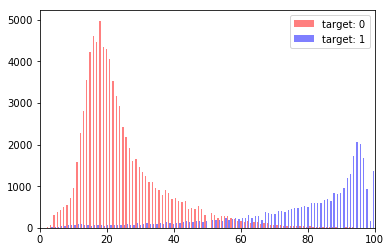

Histogram for token_set_ratio
                        count       mean        std  min  median    max
token_set_ratio (test)  78382  58.988352  26.121557  2.0    61.0  100.0


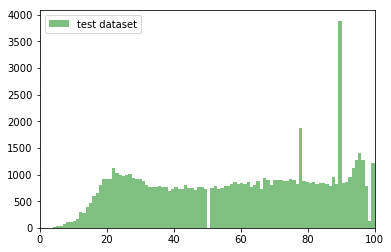

In [127]:
PlotHistByTarget(train_ds['token_set_ratio'], 'token_set_ratio', 0, 100, train_ds, 'train')
PlotHistByTarget(test_ds['token_set_ratio'], 'token_set_ratio', 0, 100, test_ds, 'test')

Histogram for unq_qwords_rate
                             count      mean       std  min  median  max
unq_qwords_rate (target: 0)  85361  0.965489  0.048885  0.5     1.0  1.0
unq_qwords_rate (target: 1)  34037  0.990643  0.030773  0.5     1.0  1.0


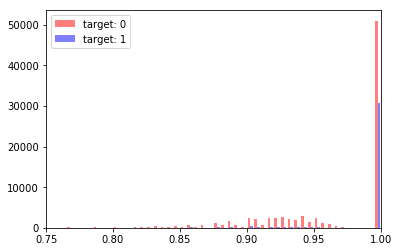

Histogram for unq_qwords_rate
                        count      mean       std       min  median  max
unq_qwords_rate (test)  78382  0.933712  0.141445  0.026316     1.0  1.0


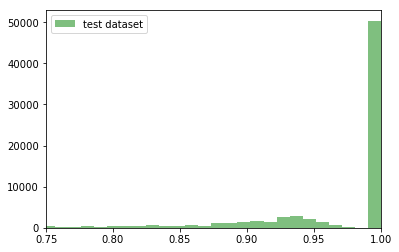

In [131]:
PlotHistByTarget(train_ds['unq_qwords_rate'], 'unq_qwords_rate', 0.75, 1, train_ds, 'train')
PlotHistByTarget(test_ds['unq_qwords_rate'], 'unq_qwords_rate', 0.75, 1, test_ds, 'test')

Histogram for len_question
                          count       mean       std  min  median   max
len_question (target: 0)  85361  15.052214  6.360197  4.0    14.0  64.0
len_question (target: 1)  34037   8.577842  3.949244  2.0     8.0  60.0


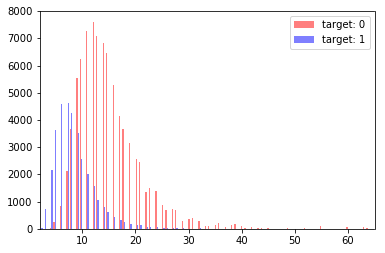

Histogram for len_question
                     count       mean       std  min  median   max
len_question (test)  78382  12.889452  6.297192  1.0    12.0  64.0


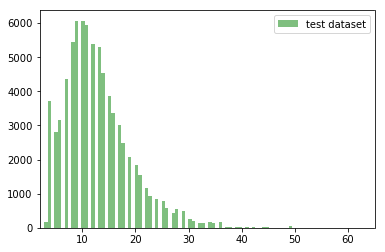

In [133]:
PlotHistByTarget(train_ds['len_question'], 'len_question', 2, 65, train_ds, 'train')
PlotHistByTarget(test_ds['len_question'], 'len_question', 2, 65, test_ds, 'test')

Histogram for len_percent
                         count       mean        std  min   median       max
len_percent (target: 0)  85361  16.326694  10.463707  0.0  13.9130  176.9231
len_percent (target: 1)  34037   3.850301   3.263605  0.0   3.1746   90.0000


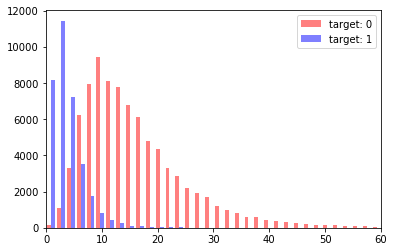

Histogram for len_percent
                    count      mean       std  min  median       max
len_percent (test)  78382  9.772418  8.207596  0.0  7.7922  227.7778


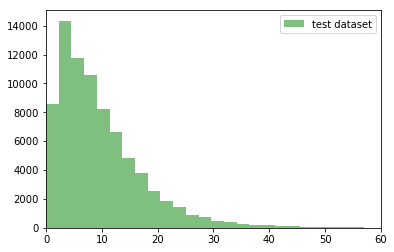

In [135]:
PlotHistByTarget(train_ds['len_percent'], 'len_percent', 0, 60, train_ds, 'train')
PlotHistByTarget(test_ds['len_percent'], 'len_percent', 0, 60, test_ds, 'test')

In [126]:
test_ds[test_ds.token_set_ratio==51]

paragraph_id  question_id  \
50             1301        38838   
247             830        37033   
567             713        30489   
576            1621        24846   
603            1156          713   
629             498         1063   
731             501        25256   
790             243        10769   
832             322        26290   
836            1397         4573   
892             371        41474   
1058            657         5777   
1351             55        16945   
1664             48         4573   
1676           1310        22087   
1704            153        22290   
1808           1434        37449   
1827           1352         6936   
1866           1009        40544   
1892           1085        29731   
1958           1494        17942   
2200            928          422   
2210           1180        26523   
2224           1317          459   
2230           1091        16881   
2881            300        22386   
2891           1317        31488   
3202           1212        23165   
3274            454        40929   
3305           1362        40235   
...             ...          ...   
73603           679         1435   
73663          1276         6170   
73970          1602        34073   
73986           997        41902   
74063           449        11296   
74289           223        17219   
74292          1611        22190   
74362           782        38216   
74463           438        27276   
74512          1035        23545   
74740          1129        18935   
74973           928        32380   
75049          1590        19592   
75324          1085        31019   
75399          1608         5543   
75586           428        12271   
75741          1030        11498   
76507           852         1234   
76543           550          644   
76631          1372        39548   
76637          1590        40172   
76695           839        27294   
76796           213         2157   
76910           876        28986   
76982           195        28660   
77627             3        29717   
77660            37        35339   
78010           216        12430   
78060          1525        27547   
78128           278        36338   

                                               paragraph  \
50     У насекомых со сложным поведением (общественны...   
247    Слухи о новом инструменте быстро дошли до Лонд...   
567    В 1679 году Ньютон познакомился в Тринити с 18...   
576    В октябре The Damned стали первой британской п...   
603    Во время брачного лёта самки и самцы выходят и...   
629    Программа Божественной Комедии охватывала всю ...   
731    Экосистема — сложная (по определению сложных с...   
790    Скорость (дрейфовая) направленного движения ча...   
832    Промежуточное положение между бактериями и выс...   
836    Во время второго пролёта мимо планеты 6 октябр...   
892    Хранение углекислоты в стальном баллоне в сжиж...   
1058   Многие насекомые совершают миграции — как в од...   
1351   UTF-8 — представление Юникода, обеспечивающее ...   
1664   Второй стала миссия НАСА под названием Мессенд...   
1676   В юриспруденции в основном означает практикует...   
1704   В 1976 году — сначала в Лондоне, затем в США —...   
1808   В XVII и XVIII веках продолжается укрепление п...   
1827   В 1998 году американский бизнесмен Руперт Мёрд...   
1866   Хоум Кредит энд Финанс Банк — российский комме...   
1892   На основании временного социального паразитизм...   
1958   Большинство мелких древесно-кустарниковых птиц...   
2200   В 20-е годы XX века немецкий инженер Роберт Бо...   
2210   У аскомицетов сливаются не отдельные клетки, а...   
2224   Файлы нелатинского текста в Юникоде всегда зан...   
2230   Большинство пользователей компьютеров использу...   
2881   С ростом размера и сложности программ уже при ...   
2891   Файлы нелатинского текста в Юникоде всегда зан...   
3202   Многие парадигмы являются условно провозглашён...   
3274   Широко распространено у раз

Histogram for diff_score
                        count      mean       std  min   median       max
diff_score (target: 0)  85361  0.212558  0.167705  0.0  0.19566  0.940040
diff_score (target: 1)  34037  0.000556  0.006435  0.0  0.00000  0.242666


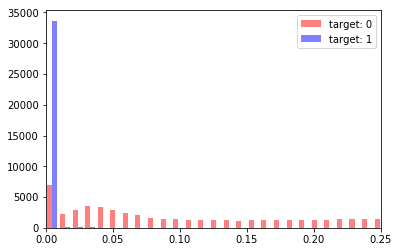

Histogram for diff_score
                   count     mean       std  min  median       max
diff_score (test)  78382  0.08493  0.130045  0.0     0.0  0.792519


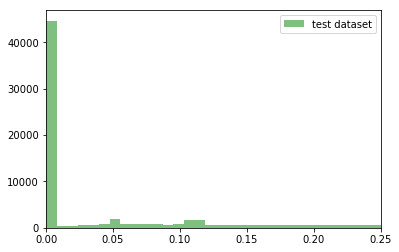

In [137]:
PlotHistByTarget(train_ds['diff_score'], 'diff_score', 0, 0.25, train_ds, 'train')
PlotHistByTarget(test_ds['diff_score'], 'diff_score', 0, 0.25, test_ds, 'test')

In [144]:
test_ds[test_ds.diff_score>0].shape

(35026, 25)

In [143]:
test_ds[test_ds.diff_score>0]['prediction'].sum()

3277.7749

In [20]:
train_ds.to_csv('NA_train3.csv', encoding ='utf-8')
test_ds.to_csv('NA_test3.csv', encoding ='utf-8')

In [19]:
train_ds, test_ds = pd.read_csv('NA_train3.csv', encoding ='utf-8', index_col = 0), pd.read_csv('NA_test3.csv', encoding ='utf-8', index_col = 0)

In [20]:
train_ds.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'target',
       'paragraph_uid', 'question_uid', 'list_of_paragraphs',
       'num_related_pars', 'list_ntokens_p', 'list_ntokens_q',
       'flat_list_ntokens_p', 'flat_list_ntokens_q', 'score', 'best_paragraph',
       'best_score', 'len_question', 'len_percent', 'num_sentences',
       'unq_qwords_rate', 'score_list', 'min_sent_score', 'token_set_ratio',
       'diff_score', 'cos_dist'],
      dtype='object')

In [18]:
#for df in (train_ds, test_ds):
#    for col in ['len_question_y', 'len_percent_y', 'list_ntokens_p_y', 'list_ntokens_q_y', 'num_sentences_y', 'unq_qwords_rate_y']:
#        del df[col]
#        df.rename(columns={'len_question_x': 'len_question',
#                           'len_percent_x': 'len_percent',
#                           'list_ntokens_p_x': 'list_ntokens_p',
#                           'list_ntokens_q_x': 'list_ntokens_q',
#                           'num_sentences_x': 'num_sentences', 
#                           'unq_qwords_rate_x': 'unq_qwords_rate'
#                          }, inplace=True)

In [19]:
train_ds = pd.merge(train_ds, train_tokens, how = 'left', on=['paragraph_id', 'question_id','paragraph_uid','question_uid'])
test_ds = pd.merge(test_ds, test_tokens, how = 'left', on=['paragraph_id', 'question_id','paragraph_uid','question_uid'])

In [21]:
train_ds.head(10)

paragraph_id  question_id  \
0          1094        46273   
1          7414        19164   
2          6744        39767   
3          7300        36318   
4          7077        41534   
5          3559        62585   
6          4350         3730   
7          8012        86629   
8          3634        69421   
9          4350        27335   

                                           paragraph  \
0  В отличие от рыб, земноводные (амфибии) и прес...   
1  В 1049 году Балдуину V удалось отнять у Герман...   
2  Стремление достичь предельных значений ёмкости...   
3  Первый практически пригодный двухтактный газов...   
4  Требуя от художника углубленного изучения изоб...   
5  Белки — высокомолекулярные органические вещест...   
6  Прайсинговые методы — в основе лежит принцип и...   
7  Применяли изначально для определения близкород...   
8  Успешная конверсия по-разному определяется гру...   
9  Прайсинговые методы — в основе лежит принцип и...   

                                            question  target paragraph_uid  \
0  С какого года Русское Царство перешло на летои...     0.0  p_train_1094   
1  Кто упомянул о его первых разногласиях со Штей...     0.0  p_train_7414   
2  Как называется имеющая мировое значение эпоха ...     0.0  p_train_6744   
3  Что усугублялось из-за международного давления...     0.0  p_train_7300   
4  Какой характер носят пророчества Леонардо да В...     0.0  p_train_7077   
5  Какие действия предприняла подводная лодка Чер...     0.0  p_train_3559   
6  Как называют остановки, до которых и на которы...     0.0  p_train_4350   
7  Какой признак киевский монах Нестор-летописец ...     1.0  p_train_8012   
8  Чтобы понять, по какому рекламному каналу приш...     1.0  p_train_3634   
9  Урожайность сои в каких странах почти не отлич...     0.0  p_train_4350   

    question_uid                                 list_of_paragraphs  \
0  q_train_46273  ['p_train_1094|0.0', 'p_train_3845|0.0', 'p_tr...   
1  q_train_19164  ['p_train_7414|0.0', 'p_train_4095|0.0', 'p_tr...   
2  q_train_39767  ['p_train_6744|0.0', 'p_train_152|0.0', 'p_tra...   
3  q_train_36318  ['p_train_7300|0.0', 'p_train_3726|0.0', 'p_tr...   
4  q_train_41534  ['p_train_7077|0.0', 'p_train_4101|1.0', 'p_tr...   
5  q_train_62585  ['p_train_3559|0.0', 'p_train_2644|0.0', 'p_tr...   
6   q_train_3730  ['p_train_4350|0.0', 'p_train_7990|0.0', 'p_tr...   
7  q_train_86629                               ['p_train_8012|1.0']   
8  q_train_69421           ['p_train_3634|1.0', 'p_train_4214|0.0']   
9  q_train_27335  ['p_train_4350|0.0', 'p_train_6602|1.0', 'p_tr...   

   num_related_pars                                   list_ntokens_p_x  \
0                25  [['в', 'отличие', 'от', 'рыба', 'земноводный',...   
1                45  [['в', '1049', 'год', 'балдуин', 'v', 'удаться...   
2                26  [['стремление', 'достигнуть', 'предельный', 'з...   
3                27  [['один', 'практически', 'пригодный', 'двухтак...   
4                 4  [['требовать', 'от', 'художник', 'углублённый'...   
5                 6  [['белка', 'высокомолекулярный', 'органический...   
6                12  [['прайсинговый', 'метод', 'в', 'основа', 'леж...   
7                 1  [['применять', 'изначально', 'для', 'определен...   
8                 2  [['успешный', 'конверсия', 'по-разному', 'опре...   
9                 8  [['прайсинговый', 'метод', 'в', 'основа', 'леж...   

     ...    min_sent_score token_set_ratio diff_score  len_question_y  \
0    ...           0.95385            18.0   0.430980            19.0   
1    ...           0.88385             8.0   0.026633            31.0   
2    ...           0.94380            23.0   0.435241            20.0   
3    ...           0.93975            16.0   0.393170            14.0   
4    ...           0.73558            51.0   0.204801             7.0   
5    ...           0.95228            20.0   0.219339            16.0   
6    ...           0.81168            16.0   0.325226            1

In [ ]:
print('Релевантный класс: score<0.5; len_percent<5; unq_qwords_rate -> 1.0:' test_ds[test_ds.score<0.5&])

# Model

In [11]:
def split_tt(train, test_size):
    train_sort = train.sort_values(['paragraph_id'])
    
    train_len =  int((1-test_size)*len(set(list(train_sort.paragraph_id))))
    print(train_sort.shape, train_len)
    X_train = train_sort[train_sort.paragraph_id<=train_len]
    X_valid = train_sort[train_sort.paragraph_id>train_len]
    y_train = train_sort.target[train_sort.paragraph_id<=train_len]
    y_valid = train_sort.target[train_sort.paragraph_id>train_len]
    
    del X_train['target']
    del X_valid['target']
    
    return X_train, X_valid, y_train, y_valid

In [4]:
def split_grp2fold(train):
    from sklearn.model_selection import GroupKFold
    X = train.as_matrix(columns=['paragraph_id','question_id'])
    X_i = np.array(train.index)

    groups =  np.array(train.target.values)
    group_kfold = GroupKFold(n_splits=2)
    group_kfold.get_n_splits(X, X_i)
    
    print(train.target.sum())
    
    GroupKFold(n_splits=2)
    for train_index, valid_index in group_kfold.split(X, X_i, groups):
        print("TRAIN:", train_index, "VALID:", valid_index)

    #X_train, X_valid = X[train_index], X[valid_index]
    X_i_train, X_i_valid = X_i[train_index], X_i[valid_index]

    X_train = train.iloc[list(X_i_train),:]
    X_valid = train.iloc[list(X_i_valid),:]

    y_train = train.target[list(X_i_train)]
    y_valid = train.target[list(X_i_valid)]

    del X_train['target']
    del X_valid['target']
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    return X_train, X_valid, y_train, y_valid

In [21]:
def submit(preds,model_name):
    res_frame = pd.DataFrame({"paragraph_id": test_ds.paragraph_id,
              "question_id": test_ds.question_id,
              "prediction": preds.values})
    res_frame[['paragraph_id','question_id','prediction']].to_csv("NewApproach_"+model_name+".csv", index=False)

In [22]:
columns = ['num_related_pars',
           'score',
           'best_score', 
           'len_question', 
           'len_percent', 
           'num_sentences',
           'unq_qwords_rate',
           'min_sent_score',
           'token_set_ratio',
           'diff_score',
           'cos_dist']

## Общая модель

In [8]:
params ={
        'eta':0.01,
        'n_estimators': 1278,
        'max_depth': 10,
        'min_child_weight': 1,
        'colsample_bytree': 0.3,
        'scale_pos_weight': 2.5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

X_train, X_valid, y_train, y_valid = split_tt(train_ds, test_size = 0.2)#split_grp2fold(train_ds) #  # 

do_validation = False

if do_validation:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(train_ds[columns], label = train_ds.target)
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

#xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, 
            #feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, 
            #verbose_eval=None, show_stdv=True, seed=0, callbacks=None)

#%txgb.to_graphviz(bst, num_trees=2)ime xgb_model = xgb.cv(params = params, dtrain = dtrain, num_boost_round = params['n_estimators'], metrics='auc', stratified=True, nfold=5, verbose_eval=100, early_stopping_rounds=100)

dtest = xgb.DMatrix(test_ds[columns])
#preds = xgb_model.predict(dtest)

test_ds['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

[0]	train-auc:0.984828
Will train until train-auc hasn't improved in 100 rounds.


KeyboardInterrupt: 

NameError: name 'xgb_model' is not defined

## 2 Модели

### Часть I

In [12]:
X_train, X_valid, y_train, y_valid = split_tt(train_ds[train_ds.num_related_pars>1], test_size = 0.2)

(94330, 25) 4684


In [13]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(45476, 24)
(48854, 24)
(45476,)
(48854,)


In [18]:
y_valid[:10].sum()

0.0

In [23]:
from sklearn.model_selection import train_test_split

In [ ]:
params ={
        'eta':0.01,
        'n_estimators': 1278,
        'max_depth': 10,
        'min_child_weight': 1,
        'colsample_bytree': 0.3,
        'scale_pos_weight': 2.5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

#X_train, X_valid, y_train, y_valid = split_tt(train_ds[train_ds.num_related_pars>1], test_size = 0.2)#split_grp2fold(train_ds) #  # 
X_train, X_valid, y_train, y_valid =train_test_split(train_ds[train_ds.num_related_pars>1].values,
                                                     train_ds[train_ds.num_related_pars>1]['target'],
                                                     test_size = 0.2)

do_validation = False

if do_validation:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(train_ds[train_ds.num_related_pars>1][columns], label = train_ds.target)
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

#xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, 
            #feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, 
            #verbose_eval=None, show_stdv=True, seed=0, callbacks=None)

#%txgb.to_graphviz(bst, num_trees=2)ime xgb_model = xgb.cv(params = params, dtrain = dtrain, num_boost_round = params['n_estimators'], metrics='auc', stratified=True, nfold=5, verbose_eval=100, early_stopping_rounds=100)

dtest1 = xgb.DMatrix(test_ds[train_ds.num_related_pars>1][columns])
#preds = xgb_model.predict(dtest)

test_ds['prediction'] = xgb_model.predict(dtest1,ntree_limit=xgb_model.best_iteration)

### Часть II

In [89]:
def xgb_cv(params, validation, columns):

    X_train, X_valid, y_train, y_valid = split_tt(train_ds, test_size = 0.2) #split_grp2fold(train_ds) #  # 

    do_validation = validation
     
    if do_validation:
        dtrain = xgb.DMatrix(X_train[columns], label = y_train)
        dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
        watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
    else:
        dtrain = xgb.DMatrix(train_ds[columns], label = train_ds.target)
        watchlist = [(dtrain, 'train')]

    %time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

    dtest = xgb.DMatrix(test_ds[columns])
    
    return xgb_model

#    if validation == False:
#        test_ds['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

In [92]:
columns = ['num_related_pars',
           'score',
           'best_score', 
           'len_question', 
           'len_percent', 
           #'num_sentences',
           #'unq_qwords_rate',
           'min_sent_score',
           #'token_set_ratio',
           'diff_score',
           'cos_dist']

params ={
        'eta':0.01,
        #'max_depth': 10,
        #'min_child_weight': 1,
        #'colsample_bytree': 0.3,
        #'scale_pos_weight': 2.5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

def launch_xgb(params, columns, def_iterations):
    params['n_estimators'] = 3000
    best_iter = xgb_cv(params, True, columns).best_iteration
    print(best_iter)
    params['n_estimators'] = best_iter
    print(params)
    best_iter = xgb_cv(params, False, columns)
    test_ds['prediction'] = xgb_model.predict(dtest,ntree_limit=best_iter)

In [93]:
launch_xgb(params, columns, 3000)

[0]	train-auc:0.995955	train(test)-auc:0.995905
Multiple eval metrics have been passed: 'train(test)-auc' will be used for early stopping.

Will train until train(test)-auc hasn't improved in 100 rounds.
[100]	train-auc:0.997846	train(test)-auc:0.997883
[200]	train-auc:0.998164	train(test)-auc:0.998112
[300]	train-auc:0.998348	train(test)-auc:0.998224
[400]	train-auc:0.998614	train(test)-auc:0.998449
[500]	train-auc:0.998716	train(test)-auc:0.998524
[600]	train-auc:0.998759	train(test)-auc:0.998534
[700]	train-auc:0.99882	train(test)-auc:0.998555
[800]	train-auc:0.998853	train(test)-auc:0.998566
[900]	train-auc:0.998881	train(test)-auc:0.998571
[1000]	train-auc:0.998921	train(test)-auc:0.998574
[1100]	train-auc:0.99897	train(test)-auc:0.998572
Stopping. Best iteration:
[1013]	train-auc:0.998927	train(test)-auc:0.998575

Wall time: 1min 19s
1273
{'eta': 0.01, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 1273}
[0]	train-auc:0.996322
Will train until train-auc has

KeyboardInterrupt: 

ArgumentError: argument 4: <class 'TypeError'>: Don't know how to convert parameter 4

In [76]:
params

{'eta': 0.01,
 'eval_metric': 'auc',
 'n_estimators': 1273,
 'objective': 'binary:logistic'}

In [42]:
train_ds.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'target',
       'paragraph_uid', 'question_uid', 'list_of_paragraphs',
       'num_related_pars', 'list_ntokens_p', 'list_ntokens_q',
       'flat_list_ntokens_p', 'flat_list_ntokens_q', 'score', 'best_paragraph',
       'best_score', 'len_question', 'len_percent', 'num_sentences',
       'unq_qwords_rate', 'score_list', 'min_sent_score', 'token_set_ratio',
       'diff_score', 'cos_dist'],
      dtype='object')

In [26]:
#X_train1, X_valid1, y_train1, y_valid1 = split_tt(train_ds, columns, test_size = 0.2)
#print(X_train1.shape, X_valid1.shape, y_train1.shape, y_valid1.shape)

In [27]:
#X_train, X_valid, y_train, y_valid = split_grp2fold(train_ds)
#print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

In [28]:
#y_valid.sum()

In [65]:
par = []
score = []
for k in xgb_model.get_fscore():
    par.append(k)
    score.append(xgb_model.get_fscore()[k])
res = pd.DataFrame({'variable':par,'split_counts':score})
res['importance'] = res['split_counts']/res['split_counts'].sum()
res.sort_values(by='importance',ascending=False)

split_counts          variable  importance
2          44693          cos_dist    0.151735
8          43022       len_percent    0.146062
1          41808    min_sent_score    0.141940
5          39351        best_score    0.133599
9          37538             score    0.127444
6          23198   token_set_ratio    0.078758
10         16379     num_sentences    0.055608
3          16104        diff_score    0.054674
7          13958      len_question    0.047388
0          10802  num_related_pars    0.036673
4           7693   unq_qwords_rate    0.026118

In [66]:
submit(test_ds['prediction'],'XGB_091017_1')

## Simple Check

In [50]:
from sklearn.metrics import roc_auc_score

first200 = pd.read_csv('test_first200_marked.csv', index_col = 0)
print(roc_auc_score(first200.target[:200],test_ds.prediction[:200]))

0.819365530303


## CV

In [6]:
from sklearn.model_selection import GroupKFold
X = train_ds.as_matrix(columns=['paragraph_id','question_id'])
X_i = np.array(train_ds.index)

groups =  np.array(train_ds.target.values)
group_kfold = GroupKFold(n_splits=2)
group_kfold.get_n_splits(X, X_i)

GroupKFold(n_splits=2)
for train_index, valid_index in group_kfold.split(X, X_i, groups):
    print("TRAIN:", train_index, "VALID:", valid_index)

X_train, X_valid = X[train_index], X[valid_index]
X_i_train, X_i_valid = X_i[train_index], X_i[valid_index]

A = train_ds.iloc[list(X_i_train),:]
B = train_ds.iloc[list(X_i_valid),:]

y_train = A['target']
y_valid = B['target']

TRAIN: [     7      8     10 ..., 119381 119384 119385] VALID: [     0      1      2 ..., 119395 119396 119397]
TRAIN: [     0      1      2 ..., 119395 119396 119397] VALID: [     7      8     10 ..., 119381 119384 119385]


In [9]:
y_train.shape

(85361,)

In [210]:
X_train, X_i

(array([[ 1094, 46273],
        [ 7414, 19164],
        [ 6744, 39767],
        ..., 
        [ 3845,  2104],
        [  168, 92509],
        [ 2679, 41770]], dtype=int64),
 array([     0,      1,      2, ..., 119395, 119396, 119397], dtype=int64))

In [1]:
y_valid = train_ds.target[list(X_i_train)]

NameError: name 'train_ds' is not defined

paragraph_id  question_id  \
0               1094        46273   
1               7414        19164   
2               6744        39767   
3               7300        36318   
4               7077        41534   
5               3559        62585   
6               4350         3730   
9               4350        27335   
11               949        51239   
13              3489        43748   
14              5156        87209   
16              2270        78977   
17              5116        59287   
18               254        87786   
19              7990        36305   
20              1646        44327   
21              3726        12085   
24              6193        62697   
25              1898        99146   
26              1957        70656   
29              8461        30985   
30              5164        27631   
32              7990         9838   
33              5071        23057   
35              3309        29514   
38              6568        59952   
41              2679        74574   
42              8873        47339   
43              4350        73092   
47              5845        26977   
...              ...          ...   
119354          8350        32631   
119355          5116        91206   
119359          3726        15125   
119360          7744        53738   
119361          2105        19385   
119366          3153       100839   
119367          8941        47180   
119369          8969        83004   
119370          4130        66375   
119371           949        18147   
119373          6193        70518   
119375          1898        52885   
119377          7183        88645   
119378          4205        24854   
119379           949        41227   
119380          7719        45002   
119382          1867       100451   
119383          1957        26879   
119386          5612        52408   
119387          8941        52337   
119388          4076        12347   
119389          5116        36648   
119390          5690        14434   
119391          6193        19600   
119392          3726        89623   
119393           787        78704   
119394          7414        97752   
119395          3845         2104   
119396           168        92509   
119397          2679        41770   

                                                paragraph  \
0       В отличие от рыб, земноводные (амфибии) и прес...   
1       В 1049 году Балдуину V удалось отнять у Герман...   
2       Стремление достичь предельных значений ёмкости...   
3       Первый практически пригодный двухтактный газов...   
4       Требуя от художника углубленного изучения изоб...   
5       Белки — высокомолекулярные органические вещест...   
6       Прайсинговые методы — в основе лежит принцип и...   
9       Прайсинговые методы — в основе лежит принцип и...   
11      1980-е годы для Спилберга были своего рода пло...   
13      После Платона и Аристотеля в Греции, а затем в...   
14      В древности разум традиционно связывался с бла...   
16      Из российских и советских актёров ролями в амп...   
17      Отец Ивана Сергей Николаевич Тургенев (1793—18...   
18      В древнегреческой мысли монотеистическая идея ...   
19      В СССР бытовые магнитофоны стали широко доступ...   
20      Рязанская земля одна из древнейших территорий ...   
21      Из войны буффонов родилась французская комичес...   
24      В течение десятилетий имя Бунина часто упомина...   
25      В июле 1980 года ВКНВ запретил рабство. Маврит...   
26      На 4-м канале Британского телевидения с 1998 г...   
29      Вслед за бешеной популярностью цветных фильмов...   
30      В 1695 году во время первого Азовского похода ...   
32      В СССР бытовые магнитофоны стали широко доступ...   
33      Хотя машины Формулы-1 нередко превышают скорос...   
35      В России в XVI—XVIII веках уже существовали ап...   
38      В 30-х годах XX века был сконструирован электр...   
41      У типичной свободной программы (то есть, неком...   
42   

In [176]:
X_p_train.tolist()[0][0]

1094

In [177]:
print(X_train[0][0], y_train[0][0])
print(train_ds[(train_ds.paragraph_id==1094)&(train_ds.question_id==46273)].paragraph)

1094 46273
0    В отличие от рыб, земноводные (амфибии) и прес...
Name: paragraph, dtype: object


In [148]:
len(set(list(X[train_index]))&set(list(X[test_index])))

TypeError: unhashable type: 'numpy.ndarray'

In [70]:
A = 
#A =np.array([[train_ds.paragraph_id.values],[train_ds.question_id.values]])

In [72]:
A.shape

(119398, 2)

In [114]:
for i in range(30):
    print(i, [fuzz.token_set_ratio(' '.join(x), ' '.join(train_ds.flat_list_ntokens_q[i])) for x in ast.literal_eval(train_ds.list_ntokens_p[i])], train_ds.target[i])
    print(i, fuzz.token_set_ratio(train_ds.paragraph[i],train_ds.question[i]),train_ds.target[i])

0 [20, 12, 22, 20] 0.0
0 18 0.0
1 [28, 11, 16, 18, 20, 17, 20] 0.0
1 8 0.0
2 [25, 19] 0.0
2 23 0.0
3 [29, 20, 13, 15, 16, 10, 15] 0.0
3 16 0.0
4 [24, 27, 21, 32, 25] 0.0
4 51 0.0
5 [23, 13, 15, 20, 26] 0.0
5 20 0.0
6 [15, 19, 21, 28, 10] 0.0
6 16 0.0
7 [38, 38, 8, 20, 25, 14, 11] 1.0
7 79 1.0
8 [26, 20, 21, 17, 22] 1.0
8 92 1.0
9 [16, 24, 24, 25, 10] 0.0
9 18 0.0
10 [29, 12, 20, 15] 1.0
10 98 1.0
11 [36, 17, 7, 25] 0.0
11 11 0.0
12 [10, 16, 23, 23] 1.0
12 46 1.0
13 [19, 14, 19, 29, 24, 18] 0.0
13 15 0.0
14 [27, 25, 25, 18] 0.0
14 19 0.0
15 [24, 21, 23, 27, 14, 17] 1.0
15 52 1.0
16 [14, 22, 38, 25] 0.0
16 36 0.0
17 [28, 26, 24, 33, 25, 34, 23, 27, 26, 25] 0.0
17 28 0.0
18 [31, 18, 15, 28, 16, 30] 0.0
18 24 0.0
19 [35, 25, 41] 0.0
19 24 0.0
20 [26, 30, 14, 31] 0.0
20 40 0.0
21 [9, 22, 21, 18, 16] 0.0
21 40 0.0
22 [22, 19, 27, 15, 29] 1.0
22 87 1.0
23 [28, 17, 16, 26, 19] 1.0
23 88 1.0
24 [31, 11, 23, 11] 0.0
24 23 0.0
25 [18, 37, 31, 21, 25, 20, 32, 26] 0.0
25 24 0.0
26 [22, 28, 29, 23, 

In [91]:
print(train_ds.paragraph[12])
print('-'*50)
print(train_ds.question[12])

Первым романтическим увлечением юного Тургенева была влюблённость в дочь княгини Шаховской — Екатерину (1815—1836), юную поэтессу. Имения их родителей в Подмосковье граничили, они часто обменивались визитами. Ему было 15, ей 19. В письмах к сыну Варвара Тургенева называла Екатерину Шаховскую поэткой и злодейкой , поскольку не устоял против чар молодой княжны и сам Сергей Николаевич, отец Ивана Тургенева, которому девушка ответила взаимностью, что разбило сердце будущего писателя. Эпизод намного позже, в 1860 году, отразился в повести Первая любовь , в которой писатель наделил некоторыми чертами Кати Шаховской героиню повести Зинаиду Засекину.
--------------------------------------------------
Кто в итоге стал любовником Екатерины Шаховской, возлюбленной Тургенева?
